In [1]:
!nvidia-smi

Thu Feb 22 21:41:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   53C    P8              23W / 215W |   1780MiB /  8192MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.getcwd()

'/home/linh/projects/IConNet/notebooks'

In [4]:
os.chdir('..')

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [7]:
data_dir = '../data/CREMA-D/'

In [8]:
sr = 16000

x_train = np.load(f'{data_dir}crema_d.audio16k.train.npy', allow_pickle=True)
x_test = np.load(f'{data_dir}crema_d.audio16k.test.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}crema_d.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}crema_d.labels.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}crema_d.labels.test.npy', allow_pickle=True)

In [9]:
labels = ['ANG', 'NEU', 'SAD', 'HAP']

def label_filter(idx):
    return classnames[idx] in labels

def label_to_index(idx):
    return labels.index(classnames[idx])
    
filtered_idx = [label_filter(idx) for idx in y_train]
x_train = x_train[filtered_idx]
y_train = [label_to_index(idx) for idx in y_train[filtered_idx]]
print(x_train.shape)

filtered_idx = [label_filter(idx) for idx in y_test]
x_test = x_test[filtered_idx]
y_test = [label_to_index(idx) for idx in y_test[filtered_idx]]
print(x_test.shape)

(3387,)
(1025,)


In [10]:
l = [len(i) for i in x_train]
print(min(l))
print(max(l))
sum(l) / len(l)

21355
80080


39776.52967227635

In [11]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [12]:
sample_rate=16000

In [13]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=3, sample_rate=16000):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = [waveform[offset: length-offset]]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float).squeeze(), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label, dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 32

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [14]:
from IConNet.nn.model import M12

In [15]:
from omegaconf import OmegaConf as ocf

In [16]:
import traceback

In [17]:
model_config_path = 'config/model/m12_debug.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M12_debug', 'description': 'FirConv sequential for iemocap', 'fe': {'n_block': 2, 'n_channel': [64, 32], 'kernel_size': [63, 31], 'stride': [4, 4], 'window_k': [5, 9], 'residual_connection_type': 'stack', 'pooling': False, 'filter_type': 'firwin', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'seq': {'n_block': 1, 'n_channel': 48, 'pooling': 'max', 'use_context': False, 'bidirectional': False}, 'cls': {'n_block': 2, 'n_hidden_dim': [256, 256], 'norm_type': 'LayerNorm'}}

In [18]:
model = M12(config=model_config,
           n_input=1, n_output=len(labels))
model

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [19]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [20]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [21]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|▎                                                                                                                                                                             | 0.014598540145985401/10 [00:00<07:05, 42.59s/it]

Train Epoch: 1 [0/3387 (0%)]	Loss: 1.399542
Mem before-during-after: 529408 1929976320 21018112


  3%|█████▍                                                                                                                                                                          | 0.3065693430656933/10 [00:10<05:16, 32.60s/it]

Train Epoch: 1 [1280/3387 (38%)]	Loss: 0.980688
Mem before-during-after: 21018112 1938932224 21018112


  6%|██████████▌                                                                                                                                                                      | 0.598540145985401/10 [00:19<05:07, 32.71s/it]

Train Epoch: 1 [2560/3387 (76%)]	Loss: 1.029866
Mem before-during-after: 21018112 1940229120 21018112


 10%|█████████████████▋                                                                                                                                                               | 0.999999999999999/10 [00:31<03:52, 25.89s/it]


Test Epoch: 1	Accuracy: 619/1024 (60%)



 10%|█████████████████▊                                                                                                                                                              | 1.0145985401459845/10 [00:31<03:57, 26.40s/it]

Train Epoch: 2 [0/3387 (0%)]	Loss: 0.949221
Mem before-during-after: 21014016 1936212480 21018112


 13%|██████████████████████▉                                                                                                                                                         | 1.3065693430656966/10 [00:40<04:35, 31.68s/it]

Train Epoch: 2 [1280/3387 (38%)]	Loss: 1.128754
Mem before-during-after: 21018112 1940360192 21018112


 16%|████████████████████████████▏                                                                                                                                                   | 1.5985401459854087/10 [00:50<04:29, 32.13s/it]

Train Epoch: 2 [2560/3387 (76%)]	Loss: 0.865661
Mem before-during-after: 21018112 1938309632 21018112


 20%|███████████████████████████████████▍                                                                                                                                             | 2.000000000000013/10 [01:01<03:16, 24.51s/it]


Test Epoch: 2	Accuracy: 625/1024 (61%)



 20%|███████████████████████████████████▋                                                                                                                                             | 2.014598540145998/10 [01:02<03:28, 26.14s/it]

Train Epoch: 3 [0/3387 (0%)]	Loss: 0.783523
Mem before-during-after: 21014016 1936212480 21018112


 23%|████████████████████████████████████████▌                                                                                                                                       | 2.3065693430657013/10 [01:11<04:07, 32.20s/it]

Train Epoch: 3 [1280/3387 (38%)]	Loss: 0.744044
Mem before-during-after: 21018112 1939723264 21018112


 26%|█████████████████████████████████████████████▋                                                                                                                                  | 2.5985401459854045/10 [01:21<03:55, 31.79s/it]

Train Epoch: 3 [2560/3387 (76%)]	Loss: 0.924652
Mem before-during-after: 21018112 1939723264 21018112


 30%|████████████████████████████████████████████████████▊                                                                                                                           | 2.9999999999999964/10 [01:32<02:51, 24.50s/it]


Test Epoch: 3	Accuracy: 626/1024 (61%)



 30%|█████████████████████████████████████████████████████                                                                                                                           | 3.0145985401459816/10 [01:32<03:08, 26.94s/it]

Train Epoch: 4 [0/3387 (0%)]	Loss: 0.958624
Mem before-during-after: 21014016 1941400576 21018112


 33%|██████████████████████████████████████████████████████████                                                                                                                      | 3.2992700729926923/10 [01:42<03:52, 34.72s/it]

Train Epoch: 4 [1280/3387 (38%)]	Loss: 0.932109
Mem before-during-after: 21018112 1940239360 21018112


 36%|███████████████████████████████████████████████████████████████▋                                                                                                                 | 3.598540145985388/10 [01:51<03:27, 32.48s/it]

Train Epoch: 4 [2560/3387 (76%)]	Loss: 0.869222
Mem before-during-after: 21018112 1940239360 21018112


 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                          | 3.99999999999998/10 [02:03<02:26, 24.40s/it]


Test Epoch: 4	Accuracy: 610/1024 (60%)



 40%|███████████████████████████████████████████████████████████████████████                                                                                                          | 4.014598540145966/10 [02:03<02:34, 25.84s/it]

Train Epoch: 5 [0/3387 (0%)]	Loss: 0.890472
Mem before-during-after: 21014016 1941400576 21018112


 43%|████████████████████████████████████████████████████████████████████████████                                                                                                     | 4.299270072992694/10 [02:12<03:19, 34.95s/it]

Train Epoch: 5 [1280/3387 (38%)]	Loss: 0.873305
Mem before-during-after: 21018112 1940239360 21018112


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 4.598540145985408/10 [02:22<02:53, 32.15s/it]

Train Epoch: 5 [2560/3387 (76%)]	Loss: 0.805819
Mem before-during-after: 21018112 1940239360 21018112


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5.000000000000024/10 [02:33<02:08, 25.78s/it]


Test Epoch: 5	Accuracy: 642/1024 (63%)



 50%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 5.01459854014601/10 [02:34<02:13, 26.79s/it]

Train Epoch: 6 [0/3387 (0%)]	Loss: 0.816609
Mem before-during-after: 21014016 1941400576 21018112


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 5.299270072992738/10 [02:43<02:47, 35.55s/it]

Train Epoch: 6 [1280/3387 (38%)]	Loss: 1.112787
Mem before-during-after: 21018112 1940239360 21018112


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 5.598540145985452/10 [02:53<03:08, 42.82s/it]

Train Epoch: 6 [2560/3387 (76%)]	Loss: 0.895323
Mem before-during-after: 21018112 1940239360 21018112


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 6.000000000000068/10 [03:05<01:36, 24.05s/it]


Test Epoch: 6	Accuracy: 632/1024 (62%)



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 6.014598540146054/10 [03:05<01:44, 26.19s/it]

Train Epoch: 7 [0/3387 (0%)]	Loss: 0.754950
Mem before-during-after: 21014016 1941400576 21018112


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 6.306569343065775/10 [03:15<02:00, 32.50s/it]

Train Epoch: 7 [1280/3387 (38%)]	Loss: 0.885937
Mem before-during-after: 21018112 1940239360 21018112


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 6.591240875912503/10 [03:24<02:00, 35.23s/it]

Train Epoch: 7 [2560/3387 (76%)]	Loss: 0.941533
Mem before-during-after: 21018112 1940239360 21018112


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 7.000000000000113/10 [03:35<01:11, 23.79s/it]


Test Epoch: 7	Accuracy: 572/1024 (56%)



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 7.014598540146099/10 [03:36<01:16, 25.50s/it]

Train Epoch: 8 [0/3387 (0%)]	Loss: 1.019176
Mem before-during-after: 21014016 1941400576 21018112


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 7.30656934306582/10 [03:45<01:25, 31.67s/it]

Train Epoch: 8 [1280/3387 (38%)]	Loss: 1.261851
Mem before-during-after: 21018112 1940239360 21018112


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 7.598540145985541/10 [03:55<01:20, 33.49s/it]

Train Epoch: 8 [2560/3387 (76%)]	Loss: 0.946940
Mem before-during-after: 21018112 1940239360 21018112


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 8.000000000000156/10 [04:06<00:47, 23.62s/it]


Test Epoch: 8	Accuracy: 658/1024 (64%)



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 8.014598540146142/10 [04:06<00:50, 25.42s/it]

Train Epoch: 9 [0/3387 (0%)]	Loss: 0.946385
Mem before-during-after: 21014016 1936212480 21018112


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 8.306569343065863/10 [04:16<00:54, 32.43s/it]

Train Epoch: 9 [1280/3387 (38%)]	Loss: 0.705323
Mem before-during-after: 21018112 1939723264 21018112


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8.598540145985584/10 [04:25<00:43, 31.18s/it]

Train Epoch: 9 [2560/3387 (76%)]	Loss: 1.007762
Mem before-during-after: 21018112 1939723264 21018112


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 9.0000000000002/10 [04:37<00:26, 26.10s/it]


Test Epoch: 9	Accuracy: 628/1024 (61%)



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 9.014598540146187/10 [04:37<00:27, 28.16s/it]

Train Epoch: 10 [0/3387 (0%)]	Loss: 0.950375
Mem before-during-after: 21014016 1941400576 21018112


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9.306569343065908/10 [04:47<00:22, 32.19s/it]

Train Epoch: 10 [1280/3387 (38%)]	Loss: 1.104173
Mem before-during-after: 21018112 1938309632 21018112


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9.598540145985629/10 [04:56<00:12, 32.10s/it]

Train Epoch: 10 [2560/3387 (76%)]	Loss: 0.838257
Mem before-during-after: 21018112 1940239360 21018112


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 9.992700729927252/10 [05:07<00:00, 23.99s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10.000000000000245/10 [05:08<00:00, 30.80s/it]


Test Epoch: 10	Accuracy: 613/1024 (60%)



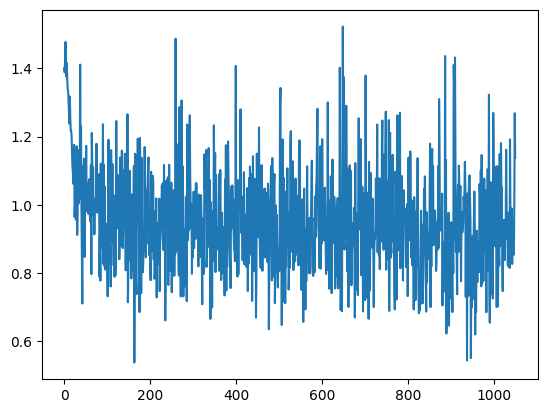

In [22]:
plt.plot(train_losses)

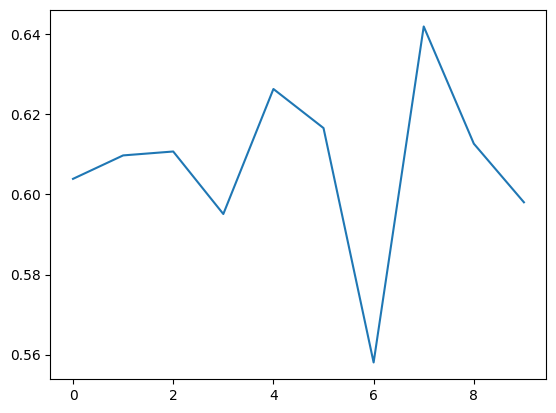

In [23]:
plt.plot(test_accuracy)

In [24]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [25]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 613/1024 (0.5986)
{'acc_detail': tensor([0.5414, 0.3684, 0.8981, 0.5547], device='cuda:0'),
 'acc_unweighted': tensor(0.5907, device='cuda:0'),
 'acc_weighted': tensor(0.5986, device='cuda:0'),
 'f1s': tensor(0.5832, device='cuda:0'),
 'f1s_detail': tensor([0.6545, 0.4190, 0.7267, 0.5326], device='cuda:0'),
 'precision_detail': tensor([0.8276, 0.4855, 0.6103, 0.5122], device='cuda:0'),
 'recall_detail': tensor([0.5414, 0.3684, 0.8981, 0.5547], device='cuda:0'),
 'rocauc': tensor([0.9259, 0.8319, 0.9366, 0.7636], device='cuda:0'),
 'uar': tensor(0.5907, device='cuda:0'),
 'wap': tensor(0.6136, device='cuda:0')}


tensor([[144,  18,   7,  97],
        [  1,  84, 105,  38],
        [  2,  20, 238,   5],
        [ 27,  51,  40, 147]], device='cuda:0')

In [26]:
model_path = '../models_cremad4/cremad_label4_m12new_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [27]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_cremad4/cremad_label4_m12new_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                              | 0.014598540145985401/50 [00:00<23:59, 28.79s/it]

Train Epoch: 11 [0/3387 (0%)]	Loss: 0.942101
Mem before-during-after: 20014592 1940401152 21073408


  1%|█                                                                                                                                                                               | 0.2992700729927006/50 [00:10<31:05, 37.54s/it]

Train Epoch: 11 [1280/3387 (38%)]	Loss: 0.698546
Mem before-during-after: 21073408 1940294656 21073408


  1%|██                                                                                                                                                                              | 0.5912408759124083/50 [00:20<30:18, 36.80s/it]

Train Epoch: 11 [2560/3387 (76%)]	Loss: 0.909575
Mem before-during-after: 21073408 1940294656 21073408


  2%|███▌                                                                                                                                                                             | 0.999999999999999/50 [00:33<22:20, 27.36s/it]


Test Epoch: 11	Accuracy: 670/1024 (65%)

saved model: ../models_cremad4/cremad_label4_m12new_best_11epoch.pt


  2%|███▌                                                                                                                                                                            | 1.0145985401459845/50 [00:33<23:27, 28.73s/it]

Train Epoch: 12 [0/3387 (0%)]	Loss: 0.842363
Mem before-during-after: 21069312 1941455872 21073408


  3%|████▌                                                                                                                                                                           | 1.2992700729927038/50 [00:43<29:27, 36.30s/it]

Train Epoch: 12 [1280/3387 (38%)]	Loss: 0.824504
Mem before-during-after: 21073408 1940294656 21073408


  3%|█████▋                                                                                                                                                                           | 1.591240875912416/50 [00:53<29:16, 36.29s/it]

Train Epoch: 12 [2560/3387 (76%)]	Loss: 0.799577
Mem before-during-after: 21073408 1940294656 21073408


  4%|███████                                                                                                                                                                          | 2.000000000000013/50 [01:06<21:21, 26.70s/it]


Test Epoch: 12	Accuracy: 677/1024 (66%)

saved model: ../models_cremad4/cremad_label4_m12new_best_12epoch.pt


  4%|███████                                                                                                                                                                         | 2.0072992700730055/50 [01:06<23:40, 29.60s/it]

Train Epoch: 13 [0/3387 (0%)]	Loss: 1.039517
Mem before-during-after: 21069312 1941455872 21073408


  5%|████████                                                                                                                                                                        | 2.2992700729927087/50 [01:16<29:28, 37.07s/it]

Train Epoch: 13 [1280/3387 (38%)]	Loss: 0.665484
Mem before-during-after: 21073408 1940294656 21073408


  5%|█████████▏                                                                                                                                                                       | 2.591240875912412/50 [01:27<29:25, 37.24s/it]

Train Epoch: 13 [2560/3387 (76%)]	Loss: 0.918921
Mem before-during-after: 21073408 1940294656 21073408


  6%|██████████▌                                                                                                                                                                     | 2.9999999999999964/50 [01:39<19:53, 25.40s/it]


Test Epoch: 13	Accuracy: 674/1024 (66%)



  6%|██████████▌                                                                                                                                                                     | 3.0145985401459816/50 [01:40<22:06, 28.24s/it]

Train Epoch: 14 [0/3387 (0%)]	Loss: 0.691262
Mem before-during-after: 21069312 1941455872 21073408


  7%|███████████▌                                                                                                                                                                    | 3.2992700729926923/50 [01:50<29:43, 38.20s/it]

Train Epoch: 14 [1280/3387 (38%)]	Loss: 0.656786
Mem before-during-after: 21073408 1940294656 21073408


  7%|████████████▋                                                                                                                                                                   | 3.5912408759123955/50 [02:00<29:04, 37.60s/it]

Train Epoch: 14 [2560/3387 (76%)]	Loss: 1.022742
Mem before-during-after: 21073408 1940294656 21073408


  8%|██████████████▏                                                                                                                                                                   | 3.99999999999998/50 [02:12<19:35, 25.56s/it]


Test Epoch: 14	Accuracy: 681/1024 (66%)

saved model: ../models_cremad4/cremad_label4_m12new_best_14epoch.pt


  8%|██████████████▏                                                                                                                                                                  | 4.014598540145966/50 [02:13<21:13, 27.69s/it]

Train Epoch: 15 [0/3387 (0%)]	Loss: 0.883679
Mem before-during-after: 21069312 1941455872 21073408


  9%|███████████████▏                                                                                                                                                                 | 4.299270072992694/50 [02:23<27:48, 36.50s/it]

Train Epoch: 15 [1280/3387 (38%)]	Loss: 0.894023
Mem before-during-after: 21073408 1940294656 21073408


  9%|████████████████▎                                                                                                                                                                | 4.591240875912415/50 [02:33<27:22, 36.17s/it]

Train Epoch: 15 [2560/3387 (76%)]	Loss: 0.977814
Mem before-during-after: 21073408 1940294656 21073408


 10%|█████████████████▋                                                                                                                                                               | 5.000000000000024/50 [02:45<20:21, 27.14s/it]


Test Epoch: 15	Accuracy: 679/1024 (66%)



 10%|█████████████████▋                                                                                                                                                               | 5.007299270073017/50 [02:46<21:45, 29.01s/it]

Train Epoch: 16 [0/3387 (0%)]	Loss: 0.810730
Mem before-during-after: 21069312 1941455872 21073408


 11%|██████████████████▊                                                                                                                                                              | 5.299270072992738/50 [02:56<27:19, 36.68s/it]

Train Epoch: 16 [1280/3387 (38%)]	Loss: 0.816262
Mem before-during-after: 21073408 1940294656 21073408


 11%|███████████████████▊                                                                                                                                                             | 5.591240875912459/50 [03:06<26:46, 36.18s/it]

Train Epoch: 16 [2560/3387 (76%)]	Loss: 0.935299
Mem before-during-after: 21073408 1940294656 21073408


 12%|█████████████████████▏                                                                                                                                                           | 6.000000000000068/50 [03:18<19:13, 26.21s/it]


Test Epoch: 16	Accuracy: 680/1024 (66%)



 12%|█████████████████████▎                                                                                                                                                           | 6.007299270073061/50 [03:19<21:06, 28.80s/it]

Train Epoch: 17 [0/3387 (0%)]	Loss: 0.746738
Mem before-during-after: 21069312 1941455872 21073408


 13%|██████████████████████▎                                                                                                                                                          | 6.299270072992782/50 [03:29<26:22, 36.20s/it]

Train Epoch: 17 [1280/3387 (38%)]	Loss: 0.647178
Mem before-during-after: 21073408 1940294656 21073408


 13%|███████████████████████▎                                                                                                                                                         | 6.591240875912503/50 [03:39<26:25, 36.52s/it]

Train Epoch: 17 [2560/3387 (76%)]	Loss: 0.752067
Mem before-during-after: 21073408 1940294656 21073408


 14%|████████████████████████▊                                                                                                                                                        | 7.000000000000113/50 [03:51<18:38, 26.01s/it]


Test Epoch: 17	Accuracy: 664/1024 (65%)



 14%|████████████████████████▊                                                                                                                                                        | 7.014598540146099/50 [03:52<20:29, 28.61s/it]

Train Epoch: 18 [0/3387 (0%)]	Loss: 0.726590
Mem before-during-after: 21069312 1941455872 21073408


 15%|█████████████████████████▊                                                                                                                                                       | 7.299270072992827/50 [04:01<25:38, 36.03s/it]

Train Epoch: 18 [1280/3387 (38%)]	Loss: 0.974643
Mem before-during-after: 21073408 1940294656 21073408


 15%|██████████████████████████▊                                                                                                                                                      | 7.591240875912548/50 [04:12<27:51, 39.41s/it]

Train Epoch: 18 [2560/3387 (76%)]	Loss: 0.881405
Mem before-during-after: 21073408 1940294656 21073408


 16%|████████████████████████████▎                                                                                                                                                    | 8.000000000000156/50 [04:24<18:35, 26.56s/it]


Test Epoch: 18	Accuracy: 676/1024 (66%)



 16%|████████████████████████████▎                                                                                                                                                    | 8.014598540146142/50 [04:25<19:43, 28.19s/it]

Train Epoch: 19 [0/3387 (0%)]	Loss: 0.780567
Mem before-during-after: 21069312 1941455872 21073408


 17%|█████████████████████████████▍                                                                                                                                                   | 8.306569343065863/50 [04:35<24:29, 35.25s/it]

Train Epoch: 19 [1280/3387 (38%)]	Loss: 1.009127
Mem before-during-after: 21073408 1940204544 21073408


 17%|██████████████████████████████▍                                                                                                                                                  | 8.591240875912591/50 [04:46<26:21, 38.19s/it]

Train Epoch: 19 [2560/3387 (76%)]	Loss: 0.725353
Mem before-during-after: 21073408 1940294656 21073408


 18%|████████████████████████████████▏                                                                                                                                                  | 9.0000000000002/50 [04:58<17:58, 26.31s/it]


Test Epoch: 19	Accuracy: 677/1024 (66%)



 18%|███████████████████████████████▉                                                                                                                                                 | 9.014598540146187/50 [04:59<19:09, 28.04s/it]

Train Epoch: 20 [0/3387 (0%)]	Loss: 0.838976
Mem before-during-after: 21069312 1941455872 21073408


 19%|████████████████████████████████▉                                                                                                                                                | 9.299270072992915/50 [05:09<24:53, 36.69s/it]

Train Epoch: 20 [1280/3387 (38%)]	Loss: 0.662378
Mem before-during-after: 21073408 1940294656 21073408


 19%|█████████████████████████████████▉                                                                                                                                               | 9.591240875912636/50 [05:19<24:32, 36.45s/it]

Train Epoch: 20 [2560/3387 (76%)]	Loss: 0.672843
Mem before-during-after: 21073408 1940294656 21073408


 20%|███████████████████████████████████▏                                                                                                                                            | 10.000000000000245/50 [05:31<18:01, 27.03s/it]


Test Epoch: 20	Accuracy: 688/1024 (67%)

saved model: ../models_cremad4/cremad_label4_m12new_best_20epoch.pt


 20%|███████████████████████████████████▎                                                                                                                                            | 10.014598540146231/50 [05:32<19:02, 28.57s/it]

Train Epoch: 21 [0/3387 (0%)]	Loss: 0.782339
Mem before-during-after: 21069312 1941455872 21073408


 21%|████████████████████████████████████▍                                                                                                                                            | 10.29927007299296/50 [05:42<24:43, 37.37s/it]

Train Epoch: 21 [1280/3387 (38%)]	Loss: 0.897584
Mem before-during-after: 21073408 1940204544 21073408


 21%|█████████████████████████████████████▍                                                                                                                                           | 10.59124087591268/50 [05:52<24:20, 37.05s/it]

Train Epoch: 21 [2560/3387 (76%)]	Loss: 0.896984
Mem before-during-after: 21073408 1940294656 21073408


 22%|██████████████████████████████████████▉                                                                                                                                          | 11.00000000000029/50 [06:04<17:10, 26.42s/it]


Test Epoch: 21	Accuracy: 685/1024 (67%)



 22%|██████████████████████████████████████▊                                                                                                                                         | 11.014598540146276/50 [06:05<18:22, 28.29s/it]

Train Epoch: 22 [0/3387 (0%)]	Loss: 0.839590
Mem before-during-after: 21069312 1941455872 21073408


 23%|███████████████████████████████████████▊                                                                                                                                        | 11.299270072993004/50 [06:15<24:08, 37.43s/it]

Train Epoch: 22 [1280/3387 (38%)]	Loss: 0.827794
Mem before-during-after: 21073408 1940294656 21073408


 23%|████████████████████████████████████████▊                                                                                                                                       | 11.591240875912725/50 [06:25<23:18, 36.41s/it]

Train Epoch: 22 [2560/3387 (76%)]	Loss: 0.891325
Mem before-during-after: 21073408 1940204544 21073408


 24%|██████████████████████████████████████████▏                                                                                                                                     | 12.000000000000334/50 [06:37<16:54, 26.71s/it]


Test Epoch: 22	Accuracy: 683/1024 (67%)



 24%|██████████████████████████████████████████▌                                                                                                                                      | 12.01459854014632/50 [06:38<17:45, 28.06s/it]

Train Epoch: 23 [0/3387 (0%)]	Loss: 0.719138
Mem before-during-after: 21069312 1936267776 21073408


 25%|███████████████████████████████████████████▎                                                                                                                                    | 12.299270072993048/50 [06:48<23:03, 36.70s/it]

Train Epoch: 23 [1280/3387 (38%)]	Loss: 0.742455
Mem before-during-after: 21073408 1939778560 21073408


 25%|████████████████████████████████████████████▎                                                                                                                                   | 12.591240875912769/50 [06:58<23:26, 37.59s/it]

Train Epoch: 23 [2560/3387 (76%)]	Loss: 0.781318
Mem before-during-after: 21073408 1939778560 21073408


 26%|█████████████████████████████████████████████▊                                                                                                                                  | 13.000000000000378/50 [07:10<16:14, 26.35s/it]


Test Epoch: 23	Accuracy: 697/1024 (68%)

saved model: ../models_cremad4/cremad_label4_m12new_best_23epoch.pt


 26%|█████████████████████████████████████████████▊                                                                                                                                  | 13.014598540146364/50 [07:11<17:23, 28.20s/it]

Train Epoch: 24 [0/3387 (0%)]	Loss: 0.932531
Mem before-during-after: 21069312 1941455872 21073408


 27%|██████████████████████████████████████████████▊                                                                                                                                 | 13.299270072993092/50 [07:21<23:14, 38.00s/it]

Train Epoch: 24 [1280/3387 (38%)]	Loss: 0.834201
Mem before-during-after: 21073408 1940294656 21073408


 27%|███████████████████████████████████████████████▊                                                                                                                                | 13.591240875912813/50 [07:31<22:35, 37.22s/it]

Train Epoch: 24 [2560/3387 (76%)]	Loss: 1.022236
Mem before-during-after: 21073408 1940294656 21073408


 28%|█████████████████████████████████████████████████▎                                                                                                                              | 14.000000000000423/50 [07:43<15:37, 26.05s/it]


Test Epoch: 24	Accuracy: 686/1024 (67%)



 28%|█████████████████████████████████████████████████▎                                                                                                                              | 14.007299270073416/50 [07:43<17:14, 28.73s/it]

Train Epoch: 25 [0/3387 (0%)]	Loss: 0.771963
Mem before-during-after: 21069312 1941455872 21073408


 29%|██████████████████████████████████████████████████▎                                                                                                                             | 14.299270072993137/50 [07:54<22:00, 36.97s/it]

Train Epoch: 25 [1280/3387 (38%)]	Loss: 0.849123
Mem before-during-after: 21073408 1940204544 21073408


 29%|███████████████████████████████████████████████████▎                                                                                                                            | 14.591240875912858/50 [08:04<22:24, 37.97s/it]

Train Epoch: 25 [2560/3387 (76%)]	Loss: 0.819571
Mem before-during-after: 21073408 1940294656 21073408


 30%|████████████████████████████████████████████████████▊                                                                                                                           | 15.000000000000467/50 [08:17<15:14, 26.12s/it]


Test Epoch: 25	Accuracy: 692/1024 (68%)



 30%|████████████████████████████████████████████████████▊                                                                                                                           | 15.014598540146453/50 [08:17<16:33, 28.41s/it]

Train Epoch: 26 [0/3387 (0%)]	Loss: 0.728392
Mem before-during-after: 21069312 1941455872 21073408


 31%|█████████████████████████████████████████████████████▊                                                                                                                          | 15.299270072993181/50 [08:27<21:13, 36.69s/it]

Train Epoch: 26 [1280/3387 (38%)]	Loss: 0.723095
Mem before-during-after: 21073408 1940294656 21073408


 31%|██████████████████████████████████████████████████████▉                                                                                                                         | 15.591240875912902/50 [08:37<21:11, 36.94s/it]

Train Epoch: 26 [2560/3387 (76%)]	Loss: 0.891447
Mem before-during-after: 21073408 1940294656 21073408


 32%|████████████████████████████████████████████████████████▋                                                                                                                        | 16.00000000000051/50 [08:49<15:03, 26.58s/it]


Test Epoch: 26	Accuracy: 694/1024 (68%)



 32%|████████████████████████████████████████████████████████▎                                                                                                                       | 16.007299270073503/50 [08:50<16:40, 29.44s/it]

Train Epoch: 27 [0/3387 (0%)]	Loss: 0.712905
Mem before-during-after: 21069312 1941455872 21073408


 33%|█████████████████████████████████████████████████████████▎                                                                                                                      | 16.299270072993153/50 [09:00<20:31, 36.55s/it]

Train Epoch: 27 [1280/3387 (38%)]	Loss: 0.740945
Mem before-during-after: 21073408 1940294656 21073408


 33%|██████████████████████████████████████████████████████████▍                                                                                                                     | 16.591240875912803/50 [09:10<20:30, 36.82s/it]

Train Epoch: 27 [2560/3387 (76%)]	Loss: 0.618894
Mem before-during-after: 21073408 1940294656 21073408


 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 17.000000000000313/50 [09:22<14:43, 26.77s/it]


Test Epoch: 27	Accuracy: 695/1024 (68%)



 34%|███████████████████████████████████████████████████████████▉                                                                                                                    | 17.014598540146295/50 [09:23<15:35, 28.38s/it]

Train Epoch: 28 [0/3387 (0%)]	Loss: 0.590189
Mem before-during-after: 21069312 1941455872 21073408


 35%|████████████████████████████████████████████████████████████▉                                                                                                                   | 17.306569343065945/50 [09:33<18:21, 33.70s/it]

Train Epoch: 28 [1280/3387 (38%)]	Loss: 0.815157
Mem before-during-after: 21073408 1940294656 21073408


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                  | 17.591240875912604/50 [09:43<19:46, 36.61s/it]

Train Epoch: 28 [2560/3387 (76%)]	Loss: 0.742321
Mem before-during-after: 21073408 1940294656 21073408


 36%|███████████████████████████████████████████████████████████████▎                                                                                                                | 18.000000000000114/50 [09:55<14:01, 26.29s/it]


Test Epoch: 28	Accuracy: 693/1024 (68%)



 36%|███████████████████████████████████████████████████████████████▍                                                                                                                | 18.007299270073105/50 [09:55<15:31, 29.12s/it]

Train Epoch: 29 [0/3387 (0%)]	Loss: 0.851084
Mem before-during-after: 21069312 1941455872 21073408


 37%|████████████████████████████████████████████████████████████████▍                                                                                                               | 18.299270072992755/50 [10:05<19:20, 36.60s/it]

Train Epoch: 29 [1280/3387 (38%)]	Loss: 0.958586
Mem before-during-after: 21073408 1940294656 21073408


 37%|█████████████████████████████████████████████████████████████████▍                                                                                                              | 18.591240875912405/50 [10:16<19:17, 36.86s/it]

Train Epoch: 29 [2560/3387 (76%)]	Loss: 0.692610
Mem before-during-after: 21073408 1940294656 21073408


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                             | 18.999999999999915/50 [10:28<14:32, 28.15s/it]


Test Epoch: 29	Accuracy: 688/1024 (67%)



 38%|██████████████████████████████████████████████████████████████████▉                                                                                                             | 19.007299270072906/50 [10:28<15:36, 30.20s/it]

Train Epoch: 30 [0/3387 (0%)]	Loss: 0.676979
Mem before-during-after: 21069312 1941455872 21073408


 39%|███████████████████████████████████████████████████████████████████▉                                                                                                            | 19.299270072992556/50 [10:39<18:49, 36.77s/it]

Train Epoch: 30 [1280/3387 (38%)]	Loss: 0.598798
Mem before-during-after: 21073408 1940294656 21073408


 39%|████████████████████████████████████████████████████████████████████▉                                                                                                           | 19.591240875912206/50 [10:49<18:48, 37.13s/it]

Train Epoch: 30 [2560/3387 (76%)]	Loss: 0.635771
Mem before-during-after: 21073408 1940294656 21073408


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 19.999999999999716/50 [11:01<13:18, 26.61s/it]


Test Epoch: 30	Accuracy: 678/1024 (66%)



 40%|███████████████████████████████████████████████████████████████████████▎                                                                                                          | 20.0145985401457/50 [11:02<14:27, 28.93s/it]

Train Epoch: 31 [0/3387 (0%)]	Loss: 0.709355
Mem before-during-after: 21069312 1936267776 21073408


 41%|███████████████████████████████████████████████████████████████████████▍                                                                                                        | 20.299270072992357/50 [11:12<18:20, 37.05s/it]

Train Epoch: 31 [1280/3387 (38%)]	Loss: 0.746177
Mem before-during-after: 21073408 1939778560 21073408


 41%|████████████████████████████████████████████████████████████████████████▍                                                                                                       | 20.591240875912007/50 [11:22<18:03, 36.86s/it]

Train Epoch: 31 [2560/3387 (76%)]	Loss: 1.114535
Mem before-during-after: 21073408 1938364928 21073408


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                      | 20.999999999999517/50 [11:34<12:52, 26.63s/it]


Test Epoch: 31	Accuracy: 684/1024 (67%)



 42%|██████████████████████████████████████████████████████████████████████████▊                                                                                                       | 21.0145985401455/50 [11:35<13:52, 28.71s/it]

Train Epoch: 32 [0/3387 (0%)]	Loss: 0.855822
Mem before-during-after: 21069312 1936267776 21073408


 43%|██████████████████████████████████████████████████████████████████████████▉                                                                                                     | 21.299270072992158/50 [11:45<17:50, 37.31s/it]

Train Epoch: 32 [1280/3387 (38%)]	Loss: 0.627777
Mem before-during-after: 21073408 1939778560 21073408


 43%|████████████████████████████████████████████████████████████████████████████                                                                                                    | 21.591240875911808/50 [11:55<17:53, 37.79s/it]

Train Epoch: 32 [2560/3387 (76%)]	Loss: 0.725556
Mem before-during-after: 21073408 1939778560 21073408


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 21.999999999999318/50 [12:07<12:22, 26.51s/it]


Test Epoch: 32	Accuracy: 656/1024 (64%)



 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 22.00729927007231/50 [12:07<13:34, 29.09s/it]

Train Epoch: 33 [0/3387 (0%)]	Loss: 0.921841
Mem before-during-after: 21069312 1936267776 21073408


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 22.29927007299196/50 [12:18<18:12, 39.44s/it]

Train Epoch: 33 [1280/3387 (38%)]	Loss: 0.996003
Mem before-during-after: 21073408 1939778560 21073408


 45%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 22.59124087591161/50 [12:28<16:51, 36.89s/it]

Train Epoch: 33 [2560/3387 (76%)]	Loss: 0.813369
Mem before-during-after: 21073408 1939778560 21073408


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 22.99999999999912/50 [12:41<14:24, 32.00s/it]


Test Epoch: 33	Accuracy: 679/1024 (66%)



 46%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 23.0145985401451/50 [12:41<13:53, 30.88s/it]

Train Epoch: 34 [0/3387 (0%)]	Loss: 0.800012
Mem before-during-after: 21069312 1941455872 21073408


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 23.29927007299176/50 [12:51<16:56, 38.07s/it]

Train Epoch: 34 [1280/3387 (38%)]	Loss: 0.580990
Mem before-during-after: 21073408 1940294656 21073408


 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 23.59124087591141/50 [13:01<16:08, 36.69s/it]

Train Epoch: 34 [2560/3387 (76%)]	Loss: 0.739607
Mem before-during-after: 21073408 1940294656 21073408


 48%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 23.99999999999892/50 [13:14<11:26, 26.41s/it]


Test Epoch: 34	Accuracy: 670/1024 (65%)



 48%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 24.00729927007191/50 [13:14<12:32, 28.95s/it]

Train Epoch: 35 [0/3387 (0%)]	Loss: 0.738303
Mem before-during-after: 21069312 1941455872 21073408


 49%|██████████████████████████████████████████████████████████████████████████████████████                                                                                           | 24.29927007299156/50 [13:24<16:10, 37.76s/it]

Train Epoch: 35 [1280/3387 (38%)]	Loss: 0.599812
Mem before-during-after: 21073408 1940294656 21073408


 49%|███████████████████████████████████████████████████████████████████████████████████████                                                                                          | 24.59124087591121/50 [13:35<15:57, 37.68s/it]

Train Epoch: 35 [2560/3387 (76%)]	Loss: 1.060411
Mem before-during-after: 21073408 1940204544 21073408


 50%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 24.99999999999872/50 [13:47<11:14, 26.99s/it]


Test Epoch: 35	Accuracy: 691/1024 (67%)



 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 25.014598540144704/50 [13:48<11:56, 28.70s/it]

Train Epoch: 36 [0/3387 (0%)]	Loss: 0.802444
Mem before-during-after: 21069312 1941455872 21073408


 51%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25.299270072991362/50 [13:58<15:16, 37.11s/it]

Train Epoch: 36 [1280/3387 (38%)]	Loss: 0.977227
Mem before-during-after: 21073408 1940294656 21073408


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 25.591240875911012/50 [14:08<15:28, 38.03s/it]

Train Epoch: 36 [2560/3387 (76%)]	Loss: 0.859706
Mem before-during-after: 21073408 1940294656 21073408


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 25.999999999998522/50 [14:21<10:36, 26.51s/it]


Test Epoch: 36	Accuracy: 685/1024 (67%)



 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 26.007299270071513/50 [14:21<11:45, 29.40s/it]

Train Epoch: 37 [0/3387 (0%)]	Loss: 0.546576
Mem before-during-after: 21069312 1941455872 21073408


 53%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 26.299270072991163/50 [14:31<14:45, 37.37s/it]

Train Epoch: 37 [1280/3387 (38%)]	Loss: 0.679073
Mem before-during-after: 21073408 1939778560 21073408


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 26.591240875910813/50 [14:42<14:56, 38.32s/it]

Train Epoch: 37 [2560/3387 (76%)]	Loss: 0.921827
Mem before-during-after: 21073408 1939778560 21073408


 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 26.999999999998323/50 [14:54<09:54, 25.86s/it]


Test Epoch: 37	Accuracy: 687/1024 (67%)



 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 27.007299270071314/50 [14:55<11:10, 29.16s/it]

Train Epoch: 38 [0/3387 (0%)]	Loss: 0.641916
Mem before-during-after: 21069312 1941455872 21073408


 55%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 27.299270072990964/50 [15:05<14:15, 37.68s/it]

Train Epoch: 38 [1280/3387 (38%)]	Loss: 0.799919
Mem before-during-after: 21073408 1940294656 21073408


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 27.591240875910614/50 [15:15<13:49, 37.03s/it]

Train Epoch: 38 [2560/3387 (76%)]	Loss: 0.603234
Mem before-during-after: 21073408 1940294656 21073408


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 27.999999999998124/50 [15:28<10:06, 27.59s/it]


Test Epoch: 38	Accuracy: 682/1024 (67%)



 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 28.014598540144107/50 [15:28<10:39, 29.07s/it]

Train Epoch: 39 [0/3387 (0%)]	Loss: 0.683893
Mem before-during-after: 21069312 1941455872 21073408


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 28.299270072990765/50 [15:38<13:50, 38.26s/it]

Train Epoch: 39 [1280/3387 (38%)]	Loss: 1.032896
Mem before-during-after: 21073408 1940294656 21073408


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 28.591240875910415/50 [15:49<13:18, 37.32s/it]

Train Epoch: 39 [2560/3387 (76%)]	Loss: 0.819614
Mem before-during-after: 21073408 1940294656 21073408


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 28.999999999997925/50 [16:02<10:50, 30.96s/it]


Test Epoch: 39	Accuracy: 691/1024 (67%)



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 29.014598540143908/50 [16:02<10:35, 30.26s/it]

Train Epoch: 40 [0/3387 (0%)]	Loss: 1.271863
Mem before-during-after: 21069312 1941455872 21073408


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 29.299270072990566/50 [16:12<12:48, 37.14s/it]

Train Epoch: 40 [1280/3387 (38%)]	Loss: 0.775660
Mem before-during-after: 21073408 1940294656 21073408


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 29.591240875910216/50 [16:22<12:46, 37.56s/it]

Train Epoch: 40 [2560/3387 (76%)]	Loss: 0.858479
Mem before-during-after: 21073408 1940294656 21073408


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 29.999999999997726/50 [16:35<09:03, 27.20s/it]


Test Epoch: 40	Accuracy: 672/1024 (66%)



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 30.007299270070718/50 [16:35<09:52, 29.64s/it]

Train Epoch: 41 [0/3387 (0%)]	Loss: 0.711420
Mem before-during-after: 21069312 1941455872 21073408


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 30.299270072990367/50 [16:45<12:30, 38.07s/it]

Train Epoch: 41 [1280/3387 (38%)]	Loss: 0.936178
Mem before-during-after: 21073408 1940204544 21073408


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 30.591240875910017/50 [16:56<12:04, 37.31s/it]

Train Epoch: 41 [2560/3387 (76%)]	Loss: 0.657054
Mem before-during-after: 21073408 1940294656 21073408


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 30.999999999997527/50 [17:08<08:35, 27.15s/it]


Test Epoch: 41	Accuracy: 683/1024 (67%)



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 31.01459854014351/50 [17:09<09:16, 29.29s/it]

Train Epoch: 42 [0/3387 (0%)]	Loss: 0.844056
Mem before-during-after: 21069312 1941455872 21073408


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 31.29927007299017/50 [17:19<11:30, 36.95s/it]

Train Epoch: 42 [1280/3387 (38%)]	Loss: 1.003803
Mem before-during-after: 21073408 1940294656 21073408


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 31.59124087590982/50 [17:29<11:35, 37.79s/it]

Train Epoch: 42 [2560/3387 (76%)]	Loss: 0.547168
Mem before-during-after: 21073408 1940294656 21073408


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 31.99999999999733/50 [17:42<08:08, 27.15s/it]


Test Epoch: 42	Accuracy: 669/1024 (65%)



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 32.00729927007032/50 [17:42<08:53, 29.64s/it]

Train Epoch: 43 [0/3387 (0%)]	Loss: 0.781585
Mem before-during-after: 21069312 1941455872 21073408


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32.29927007298997/50 [17:52<11:04, 37.52s/it]

Train Epoch: 43 [1280/3387 (38%)]	Loss: 0.658491
Mem before-during-after: 21073408 1940294656 21073408


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 32.59124087590962/50 [18:03<11:06, 38.26s/it]

Train Epoch: 43 [2560/3387 (76%)]	Loss: 0.744342
Mem before-during-after: 21073408 1940294656 21073408


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 32.99999999999713/50 [18:15<07:59, 28.18s/it]


Test Epoch: 43	Accuracy: 678/1024 (66%)



 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 33.01459854014311/50 [18:16<08:15, 29.18s/it]

Train Epoch: 44 [0/3387 (0%)]	Loss: 0.663447
Mem before-during-after: 21069312 1936267776 21073408


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 33.29927007298977/50 [18:26<10:34, 38.01s/it]

Train Epoch: 44 [1280/3387 (38%)]	Loss: 1.027266
Mem before-during-after: 21073408 1939778560 21073408


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 33.59124087590942/50 [18:36<10:17, 37.62s/it]

Train Epoch: 44 [2560/3387 (76%)]	Loss: 0.608644
Mem before-during-after: 21073408 1939778560 21073408


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 33.99999999999693/50 [18:49<07:09, 26.84s/it]


Test Epoch: 44	Accuracy: 667/1024 (65%)



 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 34.00729927006992/50 [18:49<07:46, 29.20s/it]

Train Epoch: 45 [0/3387 (0%)]	Loss: 0.794081
Mem before-during-after: 21069312 1936267776 21073408


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 34.29927007298957/50 [18:59<10:13, 39.09s/it]

Train Epoch: 45 [1280/3387 (38%)]	Loss: 0.600763
Mem before-during-after: 21073408 1940294656 21073408


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 34.59854014598221/50 [19:10<08:59, 35.06s/it]

Train Epoch: 45 [2560/3387 (76%)]	Loss: 0.975539
Mem before-during-after: 21073408 1940294656 21073408


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 34.99999999999673/50 [19:22<06:52, 27.47s/it]


Test Epoch: 45	Accuracy: 669/1024 (65%)



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 35.014598540142714/50 [19:23<07:15, 29.04s/it]

Train Epoch: 46 [0/3387 (0%)]	Loss: 0.617567
Mem before-during-after: 21069312 1941455872 21073408


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 35.29927007298937/50 [19:33<09:06, 37.19s/it]

Train Epoch: 46 [1280/3387 (38%)]	Loss: 0.744616
Mem before-during-after: 21073408 1940294656 21073408


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 35.59124087590902/50 [19:43<09:03, 37.75s/it]

Train Epoch: 46 [2560/3387 (76%)]	Loss: 0.527745
Mem before-during-after: 21073408 1940294656 21073408


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 35.99999999999653/50 [19:55<06:12, 26.63s/it]


Test Epoch: 46	Accuracy: 677/1024 (66%)



 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 36.014598540142515/50 [19:56<06:52, 29.51s/it]

Train Epoch: 47 [0/3387 (0%)]	Loss: 0.758868
Mem before-during-after: 21069312 1941455872 21073408


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 36.299270072989174/50 [20:06<08:26, 36.97s/it]

Train Epoch: 47 [1280/3387 (38%)]	Loss: 0.615473
Mem before-during-after: 21073408 1939516416 21073408


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 36.591240875908824/50 [20:16<08:22, 37.48s/it]

Train Epoch: 47 [2560/3387 (76%)]	Loss: 0.859062
Mem before-during-after: 21073408 1940204544 21073408


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 36.999999999996334/50 [20:29<05:42, 26.37s/it]


Test Epoch: 47	Accuracy: 665/1024 (65%)



 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 37.014598540142316/50 [20:29<06:15, 28.89s/it]

Train Epoch: 48 [0/3387 (0%)]	Loss: 0.591302
Mem before-during-after: 21069312 1941455872 21073408


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 37.299270072988975/50 [20:39<08:17, 39.18s/it]

Train Epoch: 48 [1280/3387 (38%)]	Loss: 0.587469
Mem before-during-after: 21073408 1940294656 21073408


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 37.591240875908625/50 [20:49<07:45, 37.54s/it]

Train Epoch: 48 [2560/3387 (76%)]	Loss: 0.600684
Mem before-during-after: 21073408 1940294656 21073408


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 37.999999999996135/50 [21:02<05:34, 27.86s/it]


Test Epoch: 48	Accuracy: 679/1024 (66%)



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 38.01459854014212/50 [21:02<05:45, 28.84s/it]

Train Epoch: 49 [0/3387 (0%)]	Loss: 0.912010
Mem before-during-after: 21069312 1936267776 21073408


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 38.299270072988776/50 [21:12<07:15, 37.24s/it]

Train Epoch: 49 [1280/3387 (38%)]	Loss: 0.625687
Mem before-during-after: 21073408 1939778560 21073408


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 38.591240875908426/50 [21:22<07:04, 37.18s/it]

Train Epoch: 49 [2560/3387 (76%)]	Loss: 0.766561
Mem before-during-after: 21073408 1939778560 21073408


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 38.999999999995936/50 [21:35<04:55, 26.87s/it]


Test Epoch: 49	Accuracy: 672/1024 (66%)



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 39.00729927006893/50 [21:35<05:22, 29.31s/it]

Train Epoch: 50 [0/3387 (0%)]	Loss: 0.650549
Mem before-during-after: 21069312 1941455872 21073408


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 39.29927007298858/50 [21:45<06:46, 38.02s/it]

Train Epoch: 50 [1280/3387 (38%)]	Loss: 0.670237
Mem before-during-after: 21073408 1940294656 21073408


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 39.59124087590823/50 [21:56<06:27, 37.25s/it]

Train Epoch: 50 [2560/3387 (76%)]	Loss: 0.639064
Mem before-during-after: 21073408 1940294656 21073408


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 39.99999999999574/50 [22:09<04:29, 27.00s/it]


Test Epoch: 50	Accuracy: 650/1024 (63%)



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 40.00729927006873/50 [22:09<05:01, 30.14s/it]

Train Epoch: 51 [0/3387 (0%)]	Loss: 0.571822
Mem before-during-after: 21069312 1941455872 21073408


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 40.29927007298838/50 [22:19<05:57, 36.90s/it]

Train Epoch: 51 [1280/3387 (38%)]	Loss: 0.764450
Mem before-during-after: 21073408 1940294656 21073408


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 40.59124087590803/50 [22:29<05:46, 36.83s/it]

Train Epoch: 51 [2560/3387 (76%)]	Loss: 0.599479
Mem before-during-after: 21073408 1940294656 21073408


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 40.99999999999554/50 [22:42<03:58, 26.54s/it]


Test Epoch: 51	Accuracy: 669/1024 (65%)



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 41.00729927006853/50 [22:42<04:21, 29.11s/it]

Train Epoch: 52 [0/3387 (0%)]	Loss: 0.675157
Mem before-during-after: 21069312 1941455872 21073408


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 41.29927007298818/50 [22:52<05:24, 37.27s/it]

Train Epoch: 52 [1280/3387 (38%)]	Loss: 0.747149
Mem before-during-after: 21073408 1940294656 21073408


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 41.59124087590783/50 [23:03<05:17, 37.77s/it]

Train Epoch: 52 [2560/3387 (76%)]	Loss: 0.614714
Mem before-during-after: 21073408 1940294656 21073408


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 41.99999999999534/50 [23:15<03:34, 26.87s/it]


Test Epoch: 52	Accuracy: 668/1024 (65%)



 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 42.01459854014132/50 [23:15<03:49, 28.72s/it]

Train Epoch: 53 [0/3387 (0%)]	Loss: 0.511027
Mem before-during-after: 21069312 1941455872 21073408


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 42.29927007298798/50 [23:26<04:46, 37.25s/it]

Train Epoch: 53 [1280/3387 (38%)]	Loss: 0.779865
Mem before-during-after: 21073408 1940294656 21073408


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 42.59124087590763/50 [23:36<04:33, 36.92s/it]

Train Epoch: 53 [2560/3387 (76%)]	Loss: 0.852232
Mem before-during-after: 21073408 1940204544 21073408


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 42.99999999999514/50 [23:48<03:11, 27.29s/it]


Test Epoch: 53	Accuracy: 664/1024 (65%)



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 43.01459854014112/50 [23:49<03:25, 29.43s/it]

Train Epoch: 54 [0/3387 (0%)]	Loss: 0.852880
Mem before-during-after: 21069312 1941455872 21073408


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 43.29927007298778/50 [23:59<04:08, 37.13s/it]

Train Epoch: 54 [1280/3387 (38%)]	Loss: 0.811139
Mem before-during-after: 21073408 1940294656 21073408


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 43.59124087590743/50 [24:09<03:58, 37.19s/it]

Train Epoch: 54 [2560/3387 (76%)]	Loss: 0.545836
Mem before-during-after: 21073408 1940294656 21073408


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 43.99999999999494/50 [24:22<02:45, 27.52s/it]


Test Epoch: 54	Accuracy: 673/1024 (66%)



 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 44.00729927006793/50 [24:22<02:56, 29.52s/it]

Train Epoch: 55 [0/3387 (0%)]	Loss: 0.879600
Mem before-during-after: 21069312 1875927552 21073408


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 44.29927007298758/50 [24:32<03:34, 37.59s/it]

Train Epoch: 55 [1280/3387 (38%)]	Loss: 0.694491
Mem before-during-after: 21073408 1939254272 21073408


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 44.59854014598022/50 [24:43<03:03, 34.00s/it]

Train Epoch: 55 [2560/3387 (76%)]	Loss: 0.668999
Mem before-during-after: 21073408 1939778560 21073408


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 44.99999999999474/50 [24:55<02:12, 26.42s/it]


Test Epoch: 55	Accuracy: 663/1024 (65%)



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 45.014598540140724/50 [24:56<02:22, 28.63s/it]

Train Epoch: 56 [0/3387 (0%)]	Loss: 0.529485
Mem before-during-after: 21069312 1941455872 21073408


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 45.29927007298738/50 [25:06<02:54, 37.03s/it]

Train Epoch: 56 [1280/3387 (38%)]	Loss: 0.685072
Mem before-during-after: 21073408 1940294656 21073408


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 45.59124087590703/50 [25:16<02:43, 36.98s/it]

Train Epoch: 56 [2560/3387 (76%)]	Loss: 0.662810
Mem before-during-after: 21073408 1940294656 21073408


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 45.99999999999454/50 [25:28<01:49, 27.29s/it]


Test Epoch: 56	Accuracy: 676/1024 (66%)



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 46.014598540140526/50 [25:29<01:55, 28.89s/it]

Train Epoch: 57 [0/3387 (0%)]	Loss: 0.369422
Mem before-during-after: 21069312 1941455872 21073408


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 46.299270072987184/50 [25:39<02:16, 36.97s/it]

Train Epoch: 57 [1280/3387 (38%)]	Loss: 0.759342
Mem before-during-after: 21073408 1940294656 21073408


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 46.591240875906834/50 [25:49<02:11, 38.46s/it]

Train Epoch: 57 [2560/3387 (76%)]	Loss: 0.847905
Mem before-during-after: 21073408 1940294656 21073408


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 46.999999999994344/50 [26:02<01:20, 26.97s/it]


Test Epoch: 57	Accuracy: 652/1024 (64%)



 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 47.01459854014033/50 [26:02<01:26, 29.13s/it]

Train Epoch: 58 [0/3387 (0%)]	Loss: 0.551105
Mem before-during-after: 21069312 1941455872 21073408


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 47.299270072986985/50 [26:12<01:43, 38.50s/it]

Train Epoch: 58 [1280/3387 (38%)]	Loss: 0.767325
Mem before-during-after: 21073408 1940294656 21073408


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 47.591240875906635/50 [26:23<01:36, 40.11s/it]

Train Epoch: 58 [2560/3387 (76%)]	Loss: 0.445290
Mem before-during-after: 21073408 1940294656 21073408


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 47.999999999994145/50 [26:36<01:09, 34.85s/it]


Test Epoch: 58	Accuracy: 639/1024 (62%)



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 48.01459854014013/50 [26:36<01:03, 32.14s/it]

Train Epoch: 59 [0/3387 (0%)]	Loss: 0.693769
Mem before-during-after: 21069312 1941455872 21073408


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 48.299270072986786/50 [26:46<01:04, 37.67s/it]

Train Epoch: 59 [1280/3387 (38%)]	Loss: 0.660141
Mem before-during-after: 21073408 1940294656 21073408


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 48.591240875906436/50 [26:57<00:52, 36.91s/it]

Train Epoch: 59 [2560/3387 (76%)]	Loss: 0.642802
Mem before-during-after: 21073408 1940294656 21073408


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 48.999999999993946/50 [27:09<00:27, 27.61s/it]


Test Epoch: 59	Accuracy: 660/1024 (64%)



 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49.01459854013993/50 [27:10<00:28, 29.24s/it]

Train Epoch: 60 [0/3387 (0%)]	Loss: 0.547858
Mem before-during-after: 21069312 1941455872 21073408


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 49.29927007298659/50 [27:20<00:26, 38.09s/it]

Train Epoch: 60 [1280/3387 (38%)]	Loss: 0.530525
Mem before-during-after: 21073408 1940294656 21073408


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 49.59124087590624/50 [27:30<00:15, 37.26s/it]

Train Epoch: 60 [2560/3387 (76%)]	Loss: 0.759033
Mem before-during-after: 21073408 1940294656 21073408


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 49.99999999999375/50 [27:43<00:00, 33.26s/it]


Test Epoch: 60	Accuracy: 643/1024 (63%)



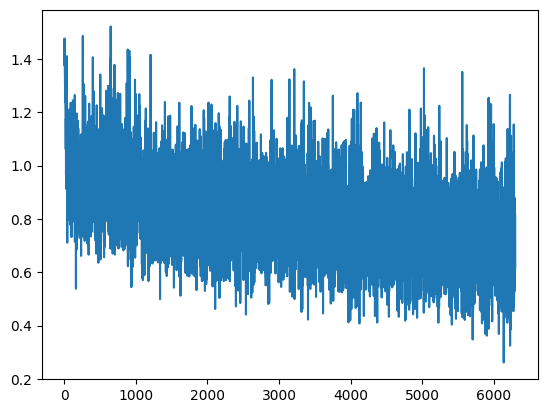

In [28]:
plt.plot(train_losses)

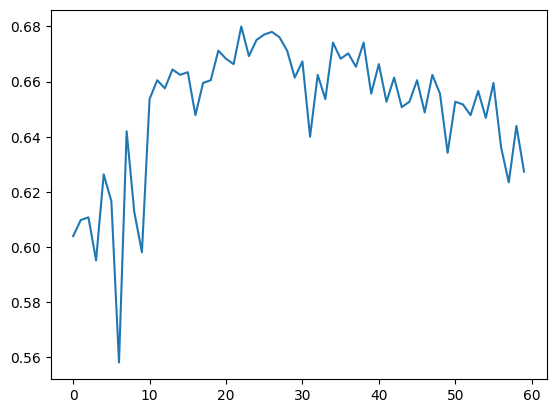

In [29]:
plt.plot(test_accuracy)

In [30]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 643/1024 (0.6279)
{'acc_detail': tensor([0.7519, 0.6228, 0.7736, 0.3623], device='cuda:0'),
 'acc_unweighted': tensor(0.6276, device='cuda:0'),
 'acc_weighted': tensor(0.6279, device='cuda:0'),
 'f1s': tensor(0.6158, device='cuda:0'),
 'f1s_detail': tensor([0.7407, 0.5613, 0.6973, 0.4638], device='cuda:0'),
 'precision_detail': tensor([0.7299, 0.5108, 0.6347, 0.6443], device='cuda:0'),
 'recall_detail': tensor([0.7519, 0.6228, 0.7736, 0.3623], device='cuda:0'),
 'rocauc': tensor([0.9202, 0.8430, 0.9154, 0.7699], device='cuda:0'),
 'uar': tensor(0.6276, device='cuda:0'),
 'wap': tensor(0.6343, device='cuda:0')}


tensor([[200,  19,  15,  32],
        [  6, 142,  61,  19],
        [  2,  56, 205,   2],
        [ 66,  61,  42,  96]], device='cuda:0')

In [31]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M12(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m12new_best_23epoch.pt
Correct: 697/1024 (0.6807)
{'acc_detail': tensor([0.8421, 0.6447, 0.8000, 0.4302], device='cuda:0'),
 'acc_unweighted': tensor(0.6793, device='cuda:0'),
 'acc_weighted': tensor(0.6807, device='cuda:0'),
 'f1s': tensor(0.6692, device='cuda:0'),
 'f1s_detail': tensor([0.7791, 0.5963, 0.7737, 0.5278], device='cuda:0'),
 'precision_detail': tensor([0.7249, 0.5547, 0.7491, 0.6826], device='cuda:0'),
 'recall_detail': tensor([0.8421, 0.6447, 0.8000, 0.4302], device='cuda:0'),
 'rocauc': tensor([0.9302, 0.8608, 0.9376, 0.7920], device='cuda:0'),
 'uar': tensor(0.6793, device='cuda:0'),
 'wap': tensor(0.6823, device='cuda:0')}


tensor([[224,  17,   3,  22],
        [  9, 147,  45,  27],
        [  4,  45, 212,   4],
        [ 72,  56,  23, 114]], device='cuda:0')

In [32]:
np.save('../models_cremad4/cremad4_m12new_60epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../models_cremad4/cremad4_m12new_60epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

In [33]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 440
# train_losses = []
# test_accuracy = []

optimizer = optim.RAdam(model.parameters(), lr=0.000005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                                    | 0.014598540145985401/440 [00:00<3:45:08, 30.70s/it]

Train Epoch: 61 [0/3387 (0%)]	Loss: 0.716178
Mem before-during-after: 21784576 1942171136 22842880


  0%|                                                                                                                                                                                      | 0.2992700729927006/440 [00:10<4:33:01, 37.26s/it]

Train Epoch: 61 [1280/3387 (38%)]	Loss: 0.589373
Mem before-during-after: 22842880 1941285888 22842880


  0%|▏                                                                                                                                                                                     | 0.5912408759124083/440 [00:21<4:45:52, 39.03s/it]

Train Epoch: 61 [2560/3387 (76%)]	Loss: 0.779425
Mem before-during-after: 22842880 1942064128 22842880


  0%|▍                                                                                                                                                                                      | 0.999999999999999/440 [00:33<3:19:47, 27.31s/it]


Test Epoch: 61	Accuracy: 668/1024 (65%)



  0%|▍                                                                                                                                                                                     | 1.0072992700729917/440 [00:34<3:41:13, 30.24s/it]

Train Epoch: 62 [0/3387 (0%)]	Loss: 0.524117
Mem before-during-after: 22838784 1943225344 22842880


  0%|▌                                                                                                                                                                                     | 1.2992700729927038/440 [00:44<4:34:59, 37.61s/it]

Train Epoch: 62 [1280/3387 (38%)]	Loss: 0.675562
Mem before-during-after: 22842880 1942064128 22842880


  0%|▋                                                                                                                                                                                      | 1.591240875912416/440 [00:54<4:42:56, 38.72s/it]

Train Epoch: 62 [2560/3387 (76%)]	Loss: 0.798212
Mem before-during-after: 22842880 1942064128 22842880


  0%|▊                                                                                                                                                                                      | 2.000000000000013/440 [01:07<3:13:07, 26.46s/it]


Test Epoch: 62	Accuracy: 628/1024 (61%)



  0%|▊                                                                                                                                                                                     | 2.0072992700730055/440 [01:07<3:34:25, 29.37s/it]

Train Epoch: 63 [0/3387 (0%)]	Loss: 0.669379
Mem before-during-after: 22838784 1943225344 22842880


  1%|▉                                                                                                                                                                                     | 2.2992700729927087/440 [01:18<4:33:24, 37.48s/it]

Train Epoch: 63 [1280/3387 (38%)]	Loss: 0.723300
Mem before-during-after: 22842880 1942184960 22842880


  1%|█                                                                                                                                                                                      | 2.591240875912412/440 [01:28<4:31:37, 37.26s/it]

Train Epoch: 63 [2560/3387 (76%)]	Loss: 0.755879
Mem before-during-after: 22842880 1942184960 22842880


  1%|█▏                                                                                                                                                                                    | 2.9999999999999964/440 [01:40<3:15:22, 26.83s/it]


Test Epoch: 63	Accuracy: 655/1024 (64%)



  1%|█▏                                                                                                                                                                                    | 3.0145985401459816/440 [01:41<3:27:53, 28.54s/it]

Train Epoch: 64 [0/3387 (0%)]	Loss: 0.517940
Mem before-during-after: 22838784 1943225344 22842880


  1%|█▎                                                                                                                                                                                    | 3.2992700729926923/440 [01:51<4:32:18, 37.41s/it]

Train Epoch: 64 [1280/3387 (38%)]	Loss: 0.639421
Mem before-during-after: 22842880 1942064128 22842880


  1%|█▍                                                                                                                                                                                    | 3.5912408759123955/440 [02:01<4:36:20, 37.99s/it]

Train Epoch: 64 [2560/3387 (76%)]	Loss: 0.773189
Mem before-during-after: 22842880 1942064128 22842880


  1%|█▋                                                                                                                                                                                      | 3.99999999999998/440 [02:14<3:21:15, 27.70s/it]


Test Epoch: 64	Accuracy: 661/1024 (64%)



  1%|█▋                                                                                                                                                                                     | 4.014598540145966/440 [02:14<3:28:25, 28.68s/it]

Train Epoch: 65 [0/3387 (0%)]	Loss: 0.660861
Mem before-during-after: 22838784 1943225344 22842880


  1%|█▊                                                                                                                                                                                     | 4.299270072992694/440 [02:25<4:38:02, 38.29s/it]

Train Epoch: 65 [1280/3387 (38%)]	Loss: 0.917615
Mem before-during-after: 22842880 1942064128 22842880


  1%|█▉                                                                                                                                                                                     | 4.591240875912415/440 [02:35<4:34:52, 37.88s/it]

Train Epoch: 65 [2560/3387 (76%)]	Loss: 0.649253
Mem before-during-after: 22842880 1942064128 22842880


  1%|██                                                                                                                                                                                     | 5.000000000000024/440 [02:48<3:15:21, 26.95s/it]


Test Epoch: 65	Accuracy: 685/1024 (67%)



  1%|██                                                                                                                                                                                      | 5.01459854014601/440 [02:48<3:33:28, 29.45s/it]

Train Epoch: 66 [0/3387 (0%)]	Loss: 0.760480
Mem before-during-after: 22838784 1943225344 22842880


  1%|██▏                                                                                                                                                                                    | 5.299270072992738/440 [02:59<4:35:31, 38.03s/it]

Train Epoch: 66 [1280/3387 (38%)]	Loss: 0.686785
Mem before-during-after: 22842880 1942064128 22842880


  1%|██▎                                                                                                                                                                                    | 5.591240875912459/440 [03:09<4:30:34, 37.37s/it]

Train Epoch: 66 [2560/3387 (76%)]	Loss: 0.700753
Mem before-during-after: 22842880 1942064128 22842880


  1%|██▍                                                                                                                                                                                    | 6.000000000000068/440 [03:22<3:21:45, 27.89s/it]


Test Epoch: 66	Accuracy: 673/1024 (66%)



  1%|██▌                                                                                                                                                                                    | 6.014598540146054/440 [03:22<3:30:15, 29.07s/it]

Train Epoch: 67 [0/3387 (0%)]	Loss: 0.549657
Mem before-during-after: 22838784 1943225344 22842880


  1%|██▌                                                                                                                                                                                    | 6.299270072992782/440 [03:32<4:32:46, 37.74s/it]

Train Epoch: 67 [1280/3387 (38%)]	Loss: 0.827777
Mem before-during-after: 22842880 1942064128 22842880


  1%|██▋                                                                                                                                                                                    | 6.591240875912503/440 [03:43<4:36:57, 38.34s/it]

Train Epoch: 67 [2560/3387 (76%)]	Loss: 0.732914
Mem before-during-after: 22842880 1942064128 22842880


  2%|██▉                                                                                                                                                                                    | 7.000000000000113/440 [03:55<3:11:40, 26.56s/it]


Test Epoch: 67	Accuracy: 643/1024 (63%)



  2%|██▉                                                                                                                                                                                    | 7.007299270073106/440 [03:56<3:30:51, 29.22s/it]

Train Epoch: 68 [0/3387 (0%)]	Loss: 0.887225
Mem before-during-after: 22838784 1943225344 22842880


  2%|███                                                                                                                                                                                    | 7.299270072992827/440 [04:06<4:31:40, 37.67s/it]

Train Epoch: 68 [1280/3387 (38%)]	Loss: 0.824702
Mem before-during-after: 22842880 1941285888 22842880


  2%|███▏                                                                                                                                                                                   | 7.591240875912548/440 [04:17<4:32:18, 37.78s/it]

Train Epoch: 68 [2560/3387 (76%)]	Loss: 0.492086
Mem before-during-after: 22842880 1942064128 22842880


  2%|███▎                                                                                                                                                                                   | 8.000000000000156/440 [04:29<3:12:17, 26.71s/it]


Test Epoch: 68	Accuracy: 663/1024 (65%)



  2%|███▎                                                                                                                                                                                   | 8.014598540146142/440 [04:30<3:21:53, 28.04s/it]

Train Epoch: 69 [0/3387 (0%)]	Loss: 0.649635
Mem before-during-after: 22838784 1943225344 22842880


  2%|███▍                                                                                                                                                                                    | 8.29927007299287/440 [04:40<4:28:40, 37.34s/it]

Train Epoch: 69 [1280/3387 (38%)]	Loss: 0.748300
Mem before-during-after: 22842880 1942064128 22842880


  2%|███▌                                                                                                                                                                                   | 8.591240875912591/440 [04:50<4:27:20, 37.18s/it]

Train Epoch: 69 [2560/3387 (76%)]	Loss: 0.695570
Mem before-during-after: 22842880 1942064128 22842880


  2%|███▊                                                                                                                                                                                     | 9.0000000000002/440 [05:02<3:11:54, 26.72s/it]


Test Epoch: 69	Accuracy: 658/1024 (64%)



  2%|███▋                                                                                                                                                                                   | 9.007299270073194/440 [05:03<3:28:02, 28.96s/it]

Train Epoch: 70 [0/3387 (0%)]	Loss: 1.002167
Mem before-during-after: 22838784 1943225344 22842880


  2%|███▊                                                                                                                                                                                   | 9.306569343065908/440 [05:13<4:07:54, 34.54s/it]

Train Epoch: 70 [1280/3387 (38%)]	Loss: 0.678503
Mem before-during-after: 22842880 1942064128 22842880


  2%|███▉                                                                                                                                                                                   | 9.591240875912636/440 [05:24<4:32:07, 37.93s/it]

Train Epoch: 70 [2560/3387 (76%)]	Loss: 0.733415
Mem before-during-after: 22842880 1942064128 22842880


  2%|████▏                                                                                                                                                                                 | 10.000000000000245/440 [05:36<3:21:24, 28.10s/it]


Test Epoch: 70	Accuracy: 665/1024 (65%)



  2%|████▏                                                                                                                                                                                 | 10.014598540146231/440 [05:36<3:25:04, 28.62s/it]

Train Epoch: 71 [0/3387 (0%)]	Loss: 0.474880
Mem before-during-after: 22838784 1943225344 22842880


  2%|████▎                                                                                                                                                                                  | 10.29927007299296/440 [05:47<4:28:55, 37.55s/it]

Train Epoch: 71 [1280/3387 (38%)]	Loss: 0.713227
Mem before-during-after: 22842880 1942064128 22842880


  2%|████▍                                                                                                                                                                                  | 10.59124087591268/440 [05:57<4:32:11, 38.03s/it]

Train Epoch: 71 [2560/3387 (76%)]	Loss: 0.761346
Mem before-during-after: 22842880 1942064128 22842880


  3%|████▌                                                                                                                                                                                  | 11.00000000000029/440 [06:09<3:08:52, 26.42s/it]


Test Epoch: 71	Accuracy: 684/1024 (67%)



  3%|████▌                                                                                                                                                                                 | 11.014598540146276/440 [06:10<3:56:22, 33.06s/it]

Train Epoch: 72 [0/3387 (0%)]	Loss: 0.804743
Mem before-during-after: 22838784 1938037248 22842880


  3%|████▋                                                                                                                                                                                 | 11.299270072993004/440 [06:20<4:35:25, 38.55s/it]

Train Epoch: 72 [1280/3387 (38%)]	Loss: 0.835495
Mem before-during-after: 22842880 1941548032 22842880


  3%|████▊                                                                                                                                                                                 | 11.591240875912725/440 [06:31<4:28:13, 37.57s/it]

Train Epoch: 72 [2560/3387 (76%)]	Loss: 0.763065
Mem before-during-after: 22842880 1941548032 22842880


  3%|████▉                                                                                                                                                                                 | 12.000000000000334/440 [06:43<3:07:40, 26.31s/it]


Test Epoch: 72	Accuracy: 670/1024 (65%)



  3%|████▉                                                                                                                                                                                 | 12.007299270073327/440 [06:44<3:24:31, 28.67s/it]

Train Epoch: 73 [0/3387 (0%)]	Loss: 0.673692
Mem before-during-after: 22838784 1943225344 22842880


  3%|█████                                                                                                                                                                                 | 12.299270072993048/440 [06:54<4:28:13, 37.63s/it]

Train Epoch: 73 [1280/3387 (38%)]	Loss: 0.839911
Mem before-during-after: 22842880 1942064128 22842880


  3%|█████▏                                                                                                                                                                                | 12.591240875912769/440 [07:05<4:35:21, 38.65s/it]

Train Epoch: 73 [2560/3387 (76%)]	Loss: 0.623231
Mem before-during-after: 22842880 1942064128 22842880


  3%|█████▍                                                                                                                                                                                | 13.000000000000378/440 [07:17<3:20:13, 28.14s/it]


Test Epoch: 73	Accuracy: 673/1024 (66%)



  3%|█████▍                                                                                                                                                                                | 13.014598540146364/440 [07:18<3:25:58, 28.94s/it]

Train Epoch: 74 [0/3387 (0%)]	Loss: 0.870689
Mem before-during-after: 22838784 1943225344 22842880


  3%|█████▌                                                                                                                                                                                | 13.299270072993092/440 [07:28<4:29:41, 37.92s/it]

Train Epoch: 74 [1280/3387 (38%)]	Loss: 1.042717
Mem before-during-after: 22842880 1942064128 22842880


  3%|█████▌                                                                                                                                                                                | 13.591240875912813/440 [07:38<4:25:41, 37.39s/it]

Train Epoch: 74 [2560/3387 (76%)]	Loss: 0.698261
Mem before-during-after: 22842880 1942064128 22842880


  3%|█████▊                                                                                                                                                                                | 14.000000000000423/440 [07:51<3:15:13, 27.50s/it]


Test Epoch: 74	Accuracy: 655/1024 (64%)



  3%|█████▊                                                                                                                                                                                | 14.014598540146409/440 [07:51<3:22:10, 28.48s/it]

Train Epoch: 75 [0/3387 (0%)]	Loss: 0.597414
Mem before-during-after: 22838784 1943225344 22842880


  3%|█████▉                                                                                                                                                                                | 14.299270072993137/440 [08:02<4:34:58, 38.76s/it]

Train Epoch: 75 [1280/3387 (38%)]	Loss: 0.859620
Mem before-during-after: 22842880 1942064128 22842880


  3%|██████                                                                                                                                                                                | 14.591240875912858/440 [08:12<4:29:30, 38.01s/it]

Train Epoch: 75 [2560/3387 (76%)]	Loss: 0.645098
Mem before-during-after: 22842880 1941974016 22842880


  3%|██████▏                                                                                                                                                                               | 15.000000000000467/440 [08:25<3:11:21, 27.02s/it]


Test Epoch: 75	Accuracy: 665/1024 (65%)



  3%|██████▏                                                                                                                                                                               | 15.014598540146453/440 [08:25<3:23:11, 28.69s/it]

Train Epoch: 76 [0/3387 (0%)]	Loss: 0.685612
Mem before-during-after: 22838784 1943225344 22842880


  3%|██████▎                                                                                                                                                                               | 15.299270072993181/440 [08:36<4:23:58, 37.29s/it]

Train Epoch: 76 [1280/3387 (38%)]	Loss: 0.486926
Mem before-during-after: 22842880 1942064128 22842880


  4%|██████▍                                                                                                                                                                               | 15.591240875912902/440 [08:46<4:28:51, 38.01s/it]

Train Epoch: 76 [2560/3387 (76%)]	Loss: 0.547090
Mem before-during-after: 22842880 1942064128 22842880


  4%|██████▋                                                                                                                                                                                | 16.00000000000051/440 [08:59<3:12:03, 27.18s/it]


Test Epoch: 76	Accuracy: 658/1024 (64%)



  4%|██████▌                                                                                                                                                                               | 16.007299270073503/440 [08:59<3:30:32, 29.79s/it]

Train Epoch: 77 [0/3387 (0%)]	Loss: 0.559260
Mem before-during-after: 22838784 1943225344 22842880


  4%|██████▋                                                                                                                                                                               | 16.299270072993153/440 [09:09<4:29:27, 38.16s/it]

Train Epoch: 77 [1280/3387 (38%)]	Loss: 0.941129
Mem before-during-after: 22842880 1942064128 22842880


  4%|██████▊                                                                                                                                                                               | 16.591240875912803/440 [09:19<4:24:51, 37.53s/it]

Train Epoch: 77 [2560/3387 (76%)]	Loss: 0.711880
Mem before-during-after: 22842880 1942064128 22842880


  4%|███████                                                                                                                                                                               | 17.000000000000313/440 [09:32<3:08:09, 26.69s/it]


Test Epoch: 77	Accuracy: 670/1024 (65%)



  4%|███████                                                                                                                                                                               | 17.007299270073304/440 [09:32<3:26:37, 29.31s/it]

Train Epoch: 78 [0/3387 (0%)]	Loss: 0.658613
Mem before-during-after: 22838784 1943225344 22842880


  4%|███████▏                                                                                                                                                                              | 17.299270072992954/440 [09:43<4:21:56, 37.18s/it]

Train Epoch: 78 [1280/3387 (38%)]	Loss: 0.751966
Mem before-during-after: 22842880 1942064128 22842880


  4%|███████▎                                                                                                                                                                              | 17.591240875912604/440 [09:53<4:28:43, 38.17s/it]

Train Epoch: 78 [2560/3387 (76%)]	Loss: 0.786606
Mem before-during-after: 22842880 1942064128 22842880


  4%|███████▍                                                                                                                                                                              | 18.000000000000114/440 [10:06<3:07:18, 26.63s/it]


Test Epoch: 78	Accuracy: 668/1024 (65%)



  4%|███████▍                                                                                                                                                                              | 18.014598540146096/440 [10:06<3:23:18, 28.91s/it]

Train Epoch: 79 [0/3387 (0%)]	Loss: 0.667156
Mem before-during-after: 22838784 1943225344 22842880


  4%|███████▌                                                                                                                                                                              | 18.299270072992755/440 [10:16<4:26:54, 37.98s/it]

Train Epoch: 79 [1280/3387 (38%)]	Loss: 1.371524
Mem before-during-after: 22842880 1942064128 22842880


  4%|███████▋                                                                                                                                                                              | 18.591240875912405/440 [10:27<4:34:02, 39.02s/it]

Train Epoch: 79 [2560/3387 (76%)]	Loss: 0.885425
Mem before-during-after: 22842880 1942064128 22842880


  4%|███████▊                                                                                                                                                                              | 18.999999999999915/440 [10:39<3:03:40, 26.18s/it]


Test Epoch: 79	Accuracy: 644/1024 (63%)



  4%|███████▊                                                                                                                                                                              | 19.014598540145897/440 [10:40<3:18:19, 28.26s/it]

Train Epoch: 80 [0/3387 (0%)]	Loss: 0.692499
Mem before-during-after: 22838784 1943225344 22842880


  4%|███████▉                                                                                                                                                                              | 19.299270072992556/440 [10:50<4:29:04, 38.37s/it]

Train Epoch: 80 [1280/3387 (38%)]	Loss: 0.692870
Mem before-during-after: 22842880 1942064128 22842880


  4%|████████                                                                                                                                                                              | 19.591240875912206/440 [11:01<4:24:13, 37.71s/it]

Train Epoch: 80 [2560/3387 (76%)]	Loss: 0.519452
Mem before-during-after: 22842880 1942064128 22842880


  5%|████████▎                                                                                                                                                                             | 19.999999999999716/440 [11:13<3:08:16, 26.90s/it]


Test Epoch: 80	Accuracy: 665/1024 (65%)



  5%|████████▎                                                                                                                                                                               | 20.0145985401457/440 [11:13<3:20:37, 28.66s/it]

Train Epoch: 81 [0/3387 (0%)]	Loss: 1.140013
Mem before-during-after: 22838784 1938037248 22842880


  5%|████████▍                                                                                                                                                                             | 20.299270072992357/440 [11:24<4:22:46, 37.57s/it]

Train Epoch: 81 [1280/3387 (38%)]	Loss: 0.660909
Mem before-during-after: 22842880 1942981632 22842880


  5%|████████▌                                                                                                                                                                             | 20.591240875912007/440 [11:34<4:25:59, 38.05s/it]

Train Epoch: 81 [2560/3387 (76%)]	Loss: 0.697102
Mem before-during-after: 22842880 1942981632 22842880


  5%|████████▋                                                                                                                                                                             | 20.999999999999517/440 [11:47<3:06:36, 26.72s/it]


Test Epoch: 81	Accuracy: 675/1024 (66%)



  5%|████████▋                                                                                                                                                                             | 21.007299270072508/440 [11:47<3:24:40, 29.31s/it]

Train Epoch: 82 [0/3387 (0%)]	Loss: 0.663591
Mem before-during-after: 22838784 1943225344 22842880


  5%|████████▊                                                                                                                                                                             | 21.299270072992158/440 [11:57<4:20:58, 37.40s/it]

Train Epoch: 82 [1280/3387 (38%)]	Loss: 0.715279
Mem before-during-after: 22842880 1942064128 22842880


  5%|████████▉                                                                                                                                                                             | 21.591240875911808/440 [12:08<4:28:16, 38.47s/it]

Train Epoch: 82 [2560/3387 (76%)]	Loss: 0.590129
Mem before-during-after: 22842880 1942064128 22842880


  5%|█████████                                                                                                                                                                             | 21.999999999999318/440 [12:20<3:07:18, 26.89s/it]


Test Epoch: 82	Accuracy: 658/1024 (64%)



  5%|█████████▏                                                                                                                                                                              | 22.0145985401453/440 [12:21<3:17:29, 28.35s/it]

Train Epoch: 83 [0/3387 (0%)]	Loss: 0.545955
Mem before-during-after: 22838784 1943225344 22842880


  5%|█████████▎                                                                                                                                                                             | 22.30656934306495/440 [12:31<4:00:30, 34.55s/it]

Train Epoch: 83 [1280/3387 (38%)]	Loss: 1.096823
Mem before-during-after: 22842880 1942064128 22842880


  5%|█████████▍                                                                                                                                                                             | 22.59124087591161/440 [12:41<4:23:44, 37.91s/it]

Train Epoch: 83 [2560/3387 (76%)]	Loss: 0.559029
Mem before-during-after: 22842880 1942064128 22842880


  5%|█████████▌                                                                                                                                                                             | 22.99999999999912/440 [12:53<3:03:57, 26.47s/it]


Test Epoch: 83	Accuracy: 673/1024 (66%)



  5%|█████████▌                                                                                                                                                                              | 23.0145985401451/440 [12:54<3:19:37, 28.72s/it]

Train Epoch: 84 [0/3387 (0%)]	Loss: 0.555730
Mem before-during-after: 22838784 1943225344 22842880


  5%|█████████▋                                                                                                                                                                             | 23.29927007299176/440 [13:04<4:17:39, 37.10s/it]

Train Epoch: 84 [1280/3387 (38%)]	Loss: 1.169050
Mem before-during-after: 22842880 1941974016 22842880


  5%|█████████▊                                                                                                                                                                             | 23.59124087591141/440 [13:14<4:22:35, 37.84s/it]

Train Epoch: 84 [2560/3387 (76%)]	Loss: 0.422263
Mem before-during-after: 22842880 1942064128 22842880


  5%|█████████▉                                                                                                                                                                             | 23.99999999999892/440 [13:27<3:05:07, 26.70s/it]


Test Epoch: 84	Accuracy: 654/1024 (64%)



  5%|█████████▉                                                                                                                                                                            | 24.014598540144902/440 [13:27<3:22:26, 29.20s/it]

Train Epoch: 85 [0/3387 (0%)]	Loss: 0.534556
Mem before-during-after: 22838784 1943225344 22842880


  6%|██████████                                                                                                                                                                             | 24.29927007299156/440 [13:37<4:22:54, 37.95s/it]

Train Epoch: 85 [1280/3387 (38%)]	Loss: 1.336345
Mem before-during-after: 22842880 1941285888 22842880


  6%|██████████▏                                                                                                                                                                            | 24.59124087591121/440 [13:48<4:22:42, 37.94s/it]

Train Epoch: 85 [2560/3387 (76%)]	Loss: 0.680023
Mem before-during-after: 22842880 1942064128 22842880


  6%|██████████▍                                                                                                                                                                            | 24.99999999999872/440 [14:00<2:59:57, 26.02s/it]


Test Epoch: 85	Accuracy: 665/1024 (65%)



  6%|██████████▎                                                                                                                                                                           | 25.007299270071712/440 [14:01<3:20:48, 29.03s/it]

Train Epoch: 86 [0/3387 (0%)]	Loss: 0.893147
Mem before-during-after: 22838784 1943225344 22842880


  6%|██████████▍                                                                                                                                                                           | 25.299270072991362/440 [14:11<4:21:22, 37.82s/it]

Train Epoch: 86 [1280/3387 (38%)]	Loss: 0.608918
Mem before-during-after: 22842880 1942064128 22842880


  6%|██████████▌                                                                                                                                                                           | 25.591240875911012/440 [14:21<4:18:45, 37.46s/it]

Train Epoch: 86 [2560/3387 (76%)]	Loss: 0.699364
Mem before-during-after: 22842880 1942064128 22842880


  6%|██████████▊                                                                                                                                                                           | 25.999999999998522/440 [14:34<3:11:06, 27.70s/it]


Test Epoch: 86	Accuracy: 650/1024 (63%)



  6%|██████████▊                                                                                                                                                                           | 26.014598540144505/440 [14:34<3:17:27, 28.62s/it]

Train Epoch: 87 [0/3387 (0%)]	Loss: 0.452983
Mem before-during-after: 22838784 1943225344 22842880


  6%|██████████▉                                                                                                                                                                           | 26.299270072991163/440 [14:44<4:18:01, 37.42s/it]

Train Epoch: 87 [1280/3387 (38%)]	Loss: 0.757882
Mem before-during-after: 22842880 1942064128 22842880


  6%|██████████▉                                                                                                                                                                           | 26.591240875910813/440 [14:55<4:14:33, 36.95s/it]

Train Epoch: 87 [2560/3387 (76%)]	Loss: 1.289770
Mem before-during-after: 22842880 1941974016 22842880


  6%|███████████▏                                                                                                                                                                          | 26.999999999998323/440 [15:07<3:01:13, 26.33s/it]


Test Epoch: 87	Accuracy: 684/1024 (67%)



  6%|███████████▏                                                                                                                                                                          | 27.014598540144306/440 [15:08<3:26:19, 29.98s/it]

Train Epoch: 88 [0/3387 (0%)]	Loss: 0.942494
Mem before-during-after: 22838784 1938037248 22842880


  6%|███████████▎                                                                                                                                                                          | 27.299270072990964/440 [15:18<4:25:57, 38.67s/it]

Train Epoch: 88 [1280/3387 (38%)]	Loss: 0.584250
Mem before-during-after: 22842880 1941548032 22842880


  6%|███████████▍                                                                                                                                                                          | 27.591240875910614/440 [15:28<4:13:38, 36.90s/it]

Train Epoch: 88 [2560/3387 (76%)]	Loss: 0.806715
Mem before-during-after: 22842880 1940134400 22842880


  6%|███████████▌                                                                                                                                                                          | 27.999999999998124/440 [15:40<3:03:25, 26.71s/it]


Test Epoch: 88	Accuracy: 570/1024 (56%)



  6%|███████████▌                                                                                                                                                                          | 28.014598540144107/440 [15:41<3:18:11, 28.86s/it]

Train Epoch: 89 [0/3387 (0%)]	Loss: 0.799337
Mem before-during-after: 22838784 1943225344 22842880


  6%|███████████▋                                                                                                                                                                          | 28.299270072990765/440 [15:51<4:14:18, 37.06s/it]

Train Epoch: 89 [1280/3387 (38%)]	Loss: 0.685122
Mem before-during-after: 22842880 1942064128 22842880


  6%|███████████▊                                                                                                                                                                          | 28.598540145983407/440 [16:02<3:53:51, 34.11s/it]

Train Epoch: 89 [2560/3387 (76%)]	Loss: 0.932240
Mem before-during-after: 22842880 1941974016 22842880


  7%|███████████▉                                                                                                                                                                          | 28.999999999997925/440 [16:14<2:58:48, 26.10s/it]


Test Epoch: 89	Accuracy: 658/1024 (64%)



  7%|███████████▉                                                                                                                                                                          | 29.007299270070916/440 [16:14<3:17:39, 28.86s/it]

Train Epoch: 90 [0/3387 (0%)]	Loss: 0.483392
Mem before-during-after: 22838784 1943225344 22842880


  7%|████████████                                                                                                                                                                          | 29.299270072990566/440 [16:24<4:13:11, 36.99s/it]

Train Epoch: 90 [1280/3387 (38%)]	Loss: 0.587434
Mem before-during-after: 22842880 1942064128 22842880


  7%|████████████▏                                                                                                                                                                         | 29.591240875910216/440 [16:35<4:16:39, 37.52s/it]

Train Epoch: 90 [2560/3387 (76%)]	Loss: 0.748039
Mem before-during-after: 22842880 1942064128 22842880


  7%|████████████▍                                                                                                                                                                         | 29.999999999997726/440 [16:47<2:59:19, 26.24s/it]


Test Epoch: 90	Accuracy: 655/1024 (64%)



  7%|████████████▍                                                                                                                                                                         | 30.007299270070718/440 [16:48<3:16:01, 28.69s/it]

Train Epoch: 91 [0/3387 (0%)]	Loss: 1.125942
Mem before-during-after: 22838784 1938037248 22842880


  7%|████████████▌                                                                                                                                                                          | 30.30656934306336/440 [16:58<4:01:19, 35.34s/it]

Train Epoch: 91 [1280/3387 (38%)]	Loss: 0.306353
Mem before-during-after: 22842880 1941548032 22842880


  7%|████████████▋                                                                                                                                                                         | 30.591240875910017/440 [17:08<4:22:47, 38.51s/it]

Train Epoch: 91 [2560/3387 (76%)]	Loss: 0.955563
Mem before-during-after: 22842880 1941548032 22842880


  7%|████████████▊                                                                                                                                                                         | 30.999999999997527/440 [17:21<2:59:50, 26.38s/it]


Test Epoch: 91	Accuracy: 653/1024 (64%)



  7%|████████████▉                                                                                                                                                                          | 31.01459854014351/440 [17:21<3:14:08, 28.48s/it]

Train Epoch: 92 [0/3387 (0%)]	Loss: 0.558974
Mem before-during-after: 22838784 1943225344 22842880


  7%|█████████████                                                                                                                                                                          | 31.29927007299017/440 [17:31<4:14:57, 37.43s/it]

Train Epoch: 92 [1280/3387 (38%)]	Loss: 0.662066
Mem before-during-after: 22842880 1942064128 22842880


  7%|█████████████▏                                                                                                                                                                         | 31.59124087590982/440 [17:42<4:16:32, 37.69s/it]

Train Epoch: 92 [2560/3387 (76%)]	Loss: 0.498410
Mem before-during-after: 22842880 1942064128 22842880


  7%|█████████████▎                                                                                                                                                                         | 31.99999999999733/440 [17:54<3:01:43, 26.72s/it]


Test Epoch: 92	Accuracy: 651/1024 (64%)



  7%|█████████████▎                                                                                                                                                                         | 32.01459854014331/440 [17:55<3:13:00, 28.38s/it]

Train Epoch: 93 [0/3387 (0%)]	Loss: 0.716530
Mem before-during-after: 22838784 1943225344 22842880


  7%|█████████████▍                                                                                                                                                                         | 32.29927007298997/440 [18:05<4:13:25, 37.30s/it]

Train Epoch: 93 [1280/3387 (38%)]	Loss: 1.104699
Mem before-during-after: 22842880 1942064128 22842880


  7%|█████████████▌                                                                                                                                                                         | 32.59124087590962/440 [18:15<4:15:30, 37.63s/it]

Train Epoch: 93 [2560/3387 (76%)]	Loss: 0.702476
Mem before-during-after: 22842880 1942064128 22842880


  7%|█████████████▋                                                                                                                                                                         | 32.99999999999713/440 [18:27<2:58:17, 26.28s/it]


Test Epoch: 93	Accuracy: 673/1024 (66%)



  8%|█████████████▋                                                                                                                                                                         | 33.01459854014311/440 [18:28<3:12:38, 28.40s/it]

Train Epoch: 94 [0/3387 (0%)]	Loss: 0.517832
Mem before-during-after: 22838784 1943225344 22842880


  8%|█████████████▊                                                                                                                                                                         | 33.29927007298977/440 [18:38<4:15:17, 37.66s/it]

Train Epoch: 94 [1280/3387 (38%)]	Loss: 0.778614
Mem before-during-after: 22842880 1941285888 22842880


  8%|█████████████▉                                                                                                                                                                         | 33.59124087590942/440 [18:48<4:13:20, 37.40s/it]

Train Epoch: 94 [2560/3387 (76%)]	Loss: 0.659473
Mem before-during-after: 22842880 1942064128 22842880


  8%|██████████████▏                                                                                                                                                                        | 33.99999999999693/440 [19:01<2:55:33, 25.94s/it]


Test Epoch: 94	Accuracy: 677/1024 (66%)



  8%|██████████████▏                                                                                                                                                                        | 34.01459854014291/440 [19:01<3:08:29, 27.86s/it]

Train Epoch: 95 [0/3387 (0%)]	Loss: 0.567942
Mem before-during-after: 22838784 1943225344 22842880


  8%|██████████████▎                                                                                                                                                                        | 34.29927007298957/440 [19:11<4:18:56, 38.30s/it]

Train Epoch: 95 [1280/3387 (38%)]	Loss: 1.394826
Mem before-during-after: 22842880 1941974016 22842880


  8%|██████████████▍                                                                                                                                                                        | 34.59124087590922/440 [19:22<4:12:36, 37.39s/it]

Train Epoch: 95 [2560/3387 (76%)]	Loss: 0.503452
Mem before-during-after: 22842880 1942064128 22842880


  8%|██████████████▌                                                                                                                                                                        | 34.99999999999673/440 [19:34<2:52:55, 25.62s/it]


Test Epoch: 95	Accuracy: 662/1024 (65%)



  8%|██████████████▍                                                                                                                                                                       | 35.014598540142714/440 [19:34<3:07:01, 27.71s/it]

Train Epoch: 96 [0/3387 (0%)]	Loss: 0.683625
Mem before-during-after: 22838784 1943225344 22842880


  8%|██████████████▋                                                                                                                                                                        | 35.29927007298937/440 [19:44<4:13:43, 37.62s/it]

Train Epoch: 96 [1280/3387 (38%)]	Loss: 0.669983
Mem before-during-after: 22842880 1942064128 22842880


  8%|██████████████▊                                                                                                                                                                        | 35.59124087590902/440 [19:55<4:12:08, 37.41s/it]

Train Epoch: 96 [2560/3387 (76%)]	Loss: 0.590839
Mem before-during-after: 22842880 1942064128 22842880


  8%|██████████████▉                                                                                                                                                                        | 35.99999999999653/440 [20:07<2:55:39, 26.09s/it]


Test Epoch: 96	Accuracy: 648/1024 (63%)



  8%|██████████████▉                                                                                                                                                                       | 36.014598540142515/440 [20:08<3:09:30, 28.15s/it]

Train Epoch: 97 [0/3387 (0%)]	Loss: 0.768338
Mem before-during-after: 22838784 1943225344 22842880


  8%|███████████████                                                                                                                                                                       | 36.299270072989174/440 [20:18<4:11:09, 37.33s/it]

Train Epoch: 97 [1280/3387 (38%)]	Loss: 0.573760
Mem before-during-after: 22842880 1942064128 22842880


  8%|███████████████▏                                                                                                                                                                      | 36.591240875908824/440 [20:28<4:12:43, 37.59s/it]

Train Epoch: 97 [2560/3387 (76%)]	Loss: 0.360492
Mem before-during-after: 22842880 1942064128 22842880


  8%|███████████████▎                                                                                                                                                                      | 36.999999999996334/440 [20:40<2:57:50, 26.48s/it]


Test Epoch: 97	Accuracy: 650/1024 (63%)



  8%|███████████████▎                                                                                                                                                                      | 37.007299270069325/440 [20:41<3:17:33, 29.41s/it]

Train Epoch: 98 [0/3387 (0%)]	Loss: 0.720600
Mem before-during-after: 22838784 1943225344 22842880


  8%|███████████████▍                                                                                                                                                                      | 37.299270072988975/440 [20:51<4:14:19, 37.89s/it]

Train Epoch: 98 [1280/3387 (38%)]	Loss: 0.386223
Mem before-during-after: 22842880 1942064128 22842880


  9%|███████████████▌                                                                                                                                                                      | 37.591240875908625/440 [21:02<4:11:14, 37.46s/it]

Train Epoch: 98 [2560/3387 (76%)]	Loss: 0.760095
Mem before-during-after: 22842880 1942064128 22842880


  9%|███████████████▋                                                                                                                                                                      | 37.999999999996135/440 [21:14<2:57:51, 26.55s/it]


Test Epoch: 98	Accuracy: 666/1024 (65%)



  9%|███████████████▊                                                                                                                                                                       | 38.01459854014212/440 [21:14<3:11:53, 28.64s/it]

Train Epoch: 99 [0/3387 (0%)]	Loss: 0.444502
Mem before-during-after: 22838784 1943225344 22842880


  9%|███████████████▊                                                                                                                                                                      | 38.299270072988776/440 [21:25<4:21:06, 39.00s/it]

Train Epoch: 99 [1280/3387 (38%)]	Loss: 0.602493
Mem before-during-after: 22842880 1942064128 22842880


  9%|███████████████▉                                                                                                                                                                      | 38.591240875908426/440 [21:35<4:06:40, 36.87s/it]

Train Epoch: 99 [2560/3387 (76%)]	Loss: 0.525030
Mem before-during-after: 22842880 1942064128 22842880


  9%|████████████████▏                                                                                                                                                                     | 38.999999999995936/440 [21:47<2:56:52, 26.46s/it]


Test Epoch: 99	Accuracy: 650/1024 (63%)



  9%|████████████████▏                                                                                                                                                                      | 39.00729927006893/440 [21:47<3:12:51, 28.86s/it]

Train Epoch: 100 [0/3387 (0%)]	Loss: 0.628356
Mem before-during-after: 22838784 1943225344 22842880


  9%|████████████████▎                                                                                                                                                                      | 39.29927007298858/440 [21:58<4:11:46, 37.70s/it]

Train Epoch: 100 [1280/3387 (38%)]	Loss: 0.669220
Mem before-during-after: 22842880 1942064128 22842880


  9%|████████████████▍                                                                                                                                                                      | 39.59124087590823/440 [22:08<4:08:22, 37.22s/it]

Train Epoch: 100 [2560/3387 (76%)]	Loss: 0.531221
Mem before-during-after: 22842880 1942064128 22842880


  9%|████████████████▋                                                                                                                                                                      | 39.99999999999574/440 [22:21<2:55:30, 26.33s/it]


Test Epoch: 100	Accuracy: 655/1024 (64%)



  9%|████████████████▋                                                                                                                                                                      | 40.00729927006873/440 [22:21<3:11:42, 28.76s/it]

Train Epoch: 101 [0/3387 (0%)]	Loss: 0.941144
Mem before-during-after: 22838784 1943225344 22842880


  9%|████████████████▊                                                                                                                                                                      | 40.29927007298838/440 [22:31<4:06:16, 36.97s/it]

Train Epoch: 101 [1280/3387 (38%)]	Loss: 0.781159
Mem before-during-after: 22842880 1941974016 22842880


  9%|████████████████▉                                                                                                                                                                      | 40.59124087590803/440 [22:42<4:15:32, 38.39s/it]

Train Epoch: 101 [2560/3387 (76%)]	Loss: 0.593421
Mem before-during-after: 22842880 1942064128 22842880


  9%|█████████████████                                                                                                                                                                      | 40.99999999999554/440 [22:54<2:53:38, 26.11s/it]


Test Epoch: 101	Accuracy: 671/1024 (65%)



  9%|█████████████████                                                                                                                                                                      | 41.00729927006853/440 [22:54<3:12:42, 28.98s/it]

Train Epoch: 102 [0/3387 (0%)]	Loss: 0.491035
Mem before-during-after: 22838784 1943225344 22842880


  9%|█████████████████▏                                                                                                                                                                     | 41.29927007298818/440 [23:05<4:08:24, 37.38s/it]

Train Epoch: 102 [1280/3387 (38%)]	Loss: 0.566318
Mem before-during-after: 22842880 1942064128 22842880


  9%|█████████████████▎                                                                                                                                                                     | 41.59124087590783/440 [23:15<4:12:37, 38.05s/it]

Train Epoch: 102 [2560/3387 (76%)]	Loss: 0.734681
Mem before-during-after: 22842880 1942064128 22842880


 10%|█████████████████▍                                                                                                                                                                     | 41.99999999999534/440 [23:28<2:56:43, 26.64s/it]


Test Epoch: 102	Accuracy: 669/1024 (65%)



 10%|█████████████████▍                                                                                                                                                                     | 42.00729927006833/440 [23:28<3:21:50, 30.43s/it]

Train Epoch: 103 [0/3387 (0%)]	Loss: 0.654477
Mem before-during-after: 22838784 1943225344 22842880


 10%|█████████████████▌                                                                                                                                                                     | 42.29927007298798/440 [23:38<4:09:18, 37.61s/it]

Train Epoch: 103 [1280/3387 (38%)]	Loss: 0.902924
Mem before-during-after: 22842880 1942064128 22842880


 10%|█████████████████▋                                                                                                                                                                     | 42.59124087590763/440 [23:48<4:07:54, 37.43s/it]

Train Epoch: 103 [2560/3387 (76%)]	Loss: 0.582131
Mem before-during-after: 22842880 1942064128 22842880


 10%|█████████████████▉                                                                                                                                                                     | 42.99999999999514/440 [24:01<2:54:16, 26.34s/it]


Test Epoch: 103	Accuracy: 673/1024 (66%)



 10%|█████████████████▉                                                                                                                                                                     | 43.01459854014112/440 [24:01<3:09:17, 28.61s/it]

Train Epoch: 104 [0/3387 (0%)]	Loss: 0.642310
Mem before-during-after: 22838784 1943225344 22842880


 10%|██████████████████                                                                                                                                                                     | 43.29927007298778/440 [24:12<4:12:19, 38.16s/it]

Train Epoch: 104 [1280/3387 (38%)]	Loss: 0.547356
Mem before-during-after: 22842880 1942064128 22842880


 10%|██████████████████▏                                                                                                                                                                    | 43.59124087590743/440 [24:22<4:06:44, 37.35s/it]

Train Epoch: 104 [2560/3387 (76%)]	Loss: 0.375044
Mem before-during-after: 22842880 1942064128 22842880


 10%|██████████████████▎                                                                                                                                                                    | 43.99999999999494/440 [24:34<2:53:00, 26.21s/it]


Test Epoch: 104	Accuracy: 655/1024 (64%)



 10%|██████████████████▎                                                                                                                                                                    | 44.01459854014092/440 [24:35<3:07:27, 28.40s/it]

Train Epoch: 105 [0/3387 (0%)]	Loss: 0.753730
Mem before-during-after: 22838784 1938037248 22842880


 10%|██████████████████▍                                                                                                                                                                    | 44.29927007298758/440 [24:45<4:05:12, 37.18s/it]

Train Epoch: 105 [1280/3387 (38%)]	Loss: 0.528198
Mem before-during-after: 22842880 1941548032 22842880


 10%|██████████████████▌                                                                                                                                                                    | 44.59124087590723/440 [24:55<4:06:51, 37.46s/it]

Train Epoch: 105 [2560/3387 (76%)]	Loss: 0.643569
Mem before-during-after: 22842880 1941548032 22842880


 10%|██████████████████▋                                                                                                                                                                    | 44.99999999999474/440 [25:08<2:55:01, 26.59s/it]


Test Epoch: 105	Accuracy: 653/1024 (64%)



 10%|██████████████████▋                                                                                                                                                                    | 45.00729927006773/440 [25:08<3:09:29, 28.78s/it]

Train Epoch: 106 [0/3387 (0%)]	Loss: 0.586394
Mem before-during-after: 22838784 1943225344 22842880


 10%|██████████████████▊                                                                                                                                                                    | 45.29927007298738/440 [25:18<4:05:42, 37.35s/it]

Train Epoch: 106 [1280/3387 (38%)]	Loss: 0.548764
Mem before-during-after: 22842880 1942064128 22842880


 10%|██████████████████▉                                                                                                                                                                    | 45.59124087590703/440 [25:28<4:07:08, 37.60s/it]

Train Epoch: 106 [2560/3387 (76%)]	Loss: 0.389629
Mem before-during-after: 22842880 1942064128 22842880


 10%|███████████████████▏                                                                                                                                                                   | 45.99999999999454/440 [25:41<2:55:54, 26.79s/it]


Test Epoch: 106	Accuracy: 659/1024 (64%)



 10%|███████████████████                                                                                                                                                                   | 46.007299270067534/440 [25:41<3:11:32, 29.17s/it]

Train Epoch: 107 [0/3387 (0%)]	Loss: 0.664388
Mem before-during-after: 22838784 1943225344 22842880


 11%|███████████████████▏                                                                                                                                                                  | 46.299270072987184/440 [25:52<4:07:03, 37.65s/it]

Train Epoch: 107 [1280/3387 (38%)]	Loss: 0.512634
Mem before-during-after: 22842880 1941285888 22842880


 11%|███████████████████▎                                                                                                                                                                  | 46.591240875906834/440 [26:02<4:28:34, 40.96s/it]

Train Epoch: 107 [2560/3387 (76%)]	Loss: 0.687438
Mem before-during-after: 22842880 1942064128 22842880


 11%|███████████████████▍                                                                                                                                                                  | 46.999999999994344/440 [26:15<2:53:59, 26.56s/it]


Test Epoch: 107	Accuracy: 657/1024 (64%)



 11%|███████████████████▌                                                                                                                                                                   | 47.01459854014033/440 [26:15<3:05:13, 28.28s/it]

Train Epoch: 108 [0/3387 (0%)]	Loss: 0.496058
Mem before-during-after: 22838784 1943225344 22842880


 11%|███████████████████▌                                                                                                                                                                  | 47.299270072986985/440 [26:25<4:17:20, 39.32s/it]

Train Epoch: 108 [1280/3387 (38%)]	Loss: 0.560681
Mem before-during-after: 22842880 1942064128 22842880


 11%|███████████████████▋                                                                                                                                                                  | 47.591240875906635/440 [26:35<4:01:24, 36.91s/it]

Train Epoch: 108 [2560/3387 (76%)]	Loss: 1.138537
Mem before-during-after: 22842880 1941974016 22842880


 11%|███████████████████▊                                                                                                                                                                  | 47.999999999994145/440 [26:48<2:54:04, 26.64s/it]


Test Epoch: 108	Accuracy: 641/1024 (63%)



 11%|███████████████████▉                                                                                                                                                                   | 48.01459854014013/440 [26:48<3:06:32, 28.55s/it]

Train Epoch: 109 [0/3387 (0%)]	Loss: 0.270686
Mem before-during-after: 22838784 1943225344 22842880


 11%|███████████████████▉                                                                                                                                                                  | 48.299270072986786/440 [26:59<4:10:19, 38.34s/it]

Train Epoch: 109 [1280/3387 (38%)]	Loss: 0.633139
Mem before-during-after: 22842880 1941285888 22842880


 11%|████████████████████                                                                                                                                                                  | 48.591240875906436/440 [27:09<4:08:43, 38.13s/it]

Train Epoch: 109 [2560/3387 (76%)]	Loss: 0.567234
Mem before-during-after: 22842880 1942064128 22842880


 11%|████████████████████▎                                                                                                                                                                 | 48.999999999993946/440 [27:22<2:48:57, 25.93s/it]


Test Epoch: 109	Accuracy: 654/1024 (64%)



 11%|████████████████████▍                                                                                                                                                                  | 49.01459854013993/440 [27:22<3:04:18, 28.28s/it]

Train Epoch: 110 [0/3387 (0%)]	Loss: 0.363844
Mem before-during-after: 22838784 1943225344 22842880


 11%|████████████████████▌                                                                                                                                                                  | 49.29927007298659/440 [27:32<4:03:28, 37.39s/it]

Train Epoch: 110 [1280/3387 (38%)]	Loss: 0.584969
Mem before-during-after: 22842880 1942064128 22842880


 11%|████████████████████▋                                                                                                                                                                  | 49.59124087590624/440 [27:43<4:03:23, 37.41s/it]

Train Epoch: 110 [2560/3387 (76%)]	Loss: 0.562048
Mem before-during-after: 22842880 1942064128 22842880


 11%|████████████████████▊                                                                                                                                                                  | 49.99999999999375/440 [27:55<3:00:17, 27.74s/it]


Test Epoch: 110	Accuracy: 668/1024 (65%)



 11%|████████████████████▊                                                                                                                                                                  | 50.01459854013973/440 [27:56<3:08:37, 29.02s/it]

Train Epoch: 111 [0/3387 (0%)]	Loss: 0.335540
Mem before-during-after: 22838784 1943225344 22842880


 11%|████████████████████▉                                                                                                                                                                  | 50.29927007298639/440 [28:06<4:07:37, 38.13s/it]

Train Epoch: 111 [1280/3387 (38%)]	Loss: 0.573921
Mem before-during-after: 22842880 1942064128 22842880


 11%|█████████████████████                                                                                                                                                                  | 50.59124087590604/440 [28:16<4:02:15, 37.33s/it]

Train Epoch: 111 [2560/3387 (76%)]	Loss: 0.523179
Mem before-during-after: 22842880 1942064128 22842880


 12%|█████████████████████▏                                                                                                                                                                 | 50.99999999999355/440 [28:29<2:50:15, 26.26s/it]


Test Epoch: 111	Accuracy: 632/1024 (62%)



 12%|█████████████████████▏                                                                                                                                                                 | 51.01459854013953/440 [28:29<3:06:38, 28.79s/it]

Train Epoch: 112 [0/3387 (0%)]	Loss: 0.475654
Mem before-during-after: 22838784 1943225344 22842880


 12%|█████████████████████▎                                                                                                                                                                 | 51.29927007298619/440 [28:39<4:08:46, 38.40s/it]

Train Epoch: 112 [1280/3387 (38%)]	Loss: 0.651468
Mem before-during-after: 22842880 1942184960 22842880


 12%|█████████████████████▍                                                                                                                                                                 | 51.59124087590584/440 [28:50<4:08:37, 38.41s/it]

Train Epoch: 112 [2560/3387 (76%)]	Loss: 0.886663
Mem before-during-after: 22842880 1942184960 22842880


 12%|█████████████████████▋                                                                                                                                                                 | 51.99999999999335/440 [29:02<2:48:46, 26.10s/it]


Test Epoch: 112	Accuracy: 650/1024 (63%)



 12%|█████████████████████▋                                                                                                                                                                 | 52.00729927006634/440 [29:02<3:06:40, 28.87s/it]

Train Epoch: 113 [0/3387 (0%)]	Loss: 0.432419
Mem before-during-after: 22838784 1943225344 22842880


 12%|█████████████████████▊                                                                                                                                                                 | 52.29927007298599/440 [29:13<4:01:33, 37.38s/it]

Train Epoch: 113 [1280/3387 (38%)]	Loss: 0.602010
Mem before-during-after: 22842880 1942064128 22842880


 12%|█████████████████████▊                                                                                                                                                                 | 52.59124087590564/440 [29:23<4:03:02, 37.64s/it]

Train Epoch: 113 [2560/3387 (76%)]	Loss: 0.710912
Mem before-during-after: 22842880 1942064128 22842880


 12%|██████████████████████                                                                                                                                                                 | 52.99999999999315/440 [29:35<2:50:25, 26.42s/it]


Test Epoch: 113	Accuracy: 657/1024 (64%)



 12%|██████████████████████                                                                                                                                                                 | 53.01459854013913/440 [29:36<3:27:12, 32.13s/it]

Train Epoch: 114 [0/3387 (0%)]	Loss: 0.704135
Mem before-during-after: 22838784 1943225344 22842880


 12%|██████████████████████▏                                                                                                                                                                | 53.29927007298579/440 [29:46<4:01:01, 37.40s/it]

Train Epoch: 114 [1280/3387 (38%)]	Loss: 0.523837
Mem before-during-after: 22842880 1942064128 22842880


 12%|██████████████████████▎                                                                                                                                                                | 53.59124087590544/440 [29:56<4:03:28, 37.81s/it]

Train Epoch: 114 [2560/3387 (76%)]	Loss: 0.573223
Mem before-during-after: 22842880 1942064128 22842880


 12%|██████████████████████▍                                                                                                                                                                | 53.99999999999295/440 [30:09<2:48:03, 26.12s/it]


Test Epoch: 114	Accuracy: 647/1024 (63%)



 12%|██████████████████████▎                                                                                                                                                               | 54.014598540138934/440 [30:09<3:04:04, 28.61s/it]

Train Epoch: 115 [0/3387 (0%)]	Loss: 0.486995
Mem before-during-after: 22838784 1943225344 22842880


 12%|██████████████████████▌                                                                                                                                                                | 54.29927007298559/440 [30:19<4:01:22, 37.55s/it]

Train Epoch: 115 [1280/3387 (38%)]	Loss: 0.672531
Mem before-during-after: 22842880 1941285888 22842880


 12%|██████████████████████▋                                                                                                                                                                | 54.59124087590524/440 [30:30<4:02:36, 37.77s/it]

Train Epoch: 115 [2560/3387 (76%)]	Loss: 0.650305
Mem before-during-after: 22842880 1942064128 22842880


 12%|██████████████████████▊                                                                                                                                                                | 54.99999999999275/440 [30:42<2:51:18, 26.70s/it]


Test Epoch: 115	Accuracy: 672/1024 (66%)



 13%|██████████████████████▊                                                                                                                                                               | 55.007299270065744/440 [30:43<3:05:35, 28.93s/it]

Train Epoch: 116 [0/3387 (0%)]	Loss: 0.364451
Mem before-during-after: 22838784 1943225344 22842880


 13%|██████████████████████▊                                                                                                                                                               | 55.299270072985394/440 [30:53<4:00:05, 37.45s/it]

Train Epoch: 116 [1280/3387 (38%)]	Loss: 0.316509
Mem before-during-after: 22842880 1942064128 22842880


 13%|██████████████████████▉                                                                                                                                                               | 55.591240875905044/440 [31:03<3:59:40, 37.41s/it]

Train Epoch: 116 [2560/3387 (76%)]	Loss: 0.529548
Mem before-during-after: 22842880 1942064128 22842880


 13%|███████████████████████▎                                                                                                                                                               | 55.99999999999255/440 [31:16<2:47:34, 26.18s/it]


Test Epoch: 116	Accuracy: 654/1024 (64%)



 13%|███████████████████████▏                                                                                                                                                              | 56.007299270065545/440 [31:16<3:04:49, 28.88s/it]

Train Epoch: 117 [0/3387 (0%)]	Loss: 0.459049
Mem before-during-after: 22838784 1943225344 22842880


 13%|███████████████████████▎                                                                                                                                                              | 56.299270072985195/440 [31:26<4:00:34, 37.62s/it]

Train Epoch: 117 [1280/3387 (38%)]	Loss: 0.312290
Mem before-during-after: 22842880 1942064128 22842880


 13%|███████████████████████▍                                                                                                                                                              | 56.591240875904845/440 [31:37<4:00:27, 37.63s/it]

Train Epoch: 117 [2560/3387 (76%)]	Loss: 0.495324
Mem before-during-after: 22842880 1942064128 22842880


 13%|███████████████████████▌                                                                                                                                                              | 56.999999999992355/440 [31:49<2:46:28, 26.08s/it]


Test Epoch: 117	Accuracy: 656/1024 (64%)



 13%|███████████████████████▌                                                                                                                                                              | 57.007299270065346/440 [31:49<3:03:48, 28.79s/it]

Train Epoch: 118 [0/3387 (0%)]	Loss: 0.473351
Mem before-during-after: 22838784 1943225344 22842880


 13%|███████████████████████▋                                                                                                                                                              | 57.299270072984996/440 [32:00<3:59:29, 37.55s/it]

Train Epoch: 118 [1280/3387 (38%)]	Loss: 0.623754
Mem before-during-after: 22842880 1942064128 22842880


 13%|███████████████████████▊                                                                                                                                                              | 57.591240875904646/440 [32:10<3:57:03, 37.19s/it]

Train Epoch: 118 [2560/3387 (76%)]	Loss: 0.355320
Mem before-during-after: 22842880 1942064128 22842880


 13%|███████████████████████▉                                                                                                                                                              | 57.999999999992156/440 [32:22<2:48:47, 26.51s/it]


Test Epoch: 118	Accuracy: 640/1024 (62%)



 13%|████████████████████████▏                                                                                                                                                              | 58.01459854013814/440 [32:22<2:59:39, 28.22s/it]

Train Epoch: 119 [0/3387 (0%)]	Loss: 0.511812
Mem before-during-after: 22838784 1943225344 22842880


 13%|████████████████████████▍                                                                                                                                                               | 58.2992700729848/440 [32:33<3:57:27, 37.33s/it]

Train Epoch: 119 [1280/3387 (38%)]	Loss: 0.473425
Mem before-during-after: 22842880 1942064128 22842880


 13%|████████████████████████▎                                                                                                                                                              | 58.59124087590445/440 [32:43<4:03:11, 38.26s/it]

Train Epoch: 119 [2560/3387 (76%)]	Loss: 0.658546
Mem before-during-after: 22842880 1942064128 22842880


 13%|████████████████████████▌                                                                                                                                                              | 58.99999999999196/440 [32:56<2:46:28, 26.22s/it]


Test Epoch: 119	Accuracy: 674/1024 (66%)



 13%|████████████████████████▌                                                                                                                                                              | 59.00729927006495/440 [32:56<3:04:21, 29.03s/it]

Train Epoch: 120 [0/3387 (0%)]	Loss: 0.247219
Mem before-during-after: 22838784 1943225344 22842880


 13%|████████████████████████▊                                                                                                                                                               | 59.2992700729846/440 [33:06<3:59:10, 37.70s/it]

Train Epoch: 120 [1280/3387 (38%)]	Loss: 0.477799
Mem before-during-after: 22842880 1942064128 22842880


 14%|████████████████████████▊                                                                                                                                                              | 59.59124087590425/440 [33:17<3:58:47, 37.66s/it]

Train Epoch: 120 [2560/3387 (76%)]	Loss: 0.641652
Mem before-during-after: 22842880 1942064128 22842880


 14%|████████████████████████▉                                                                                                                                                              | 59.99999999999176/440 [33:29<2:46:27, 26.28s/it]


Test Epoch: 120	Accuracy: 677/1024 (66%)



 14%|████████████████████████▉                                                                                                                                                              | 60.00729927006475/440 [33:30<3:01:20, 28.63s/it]

Train Epoch: 121 [0/3387 (0%)]	Loss: 0.319776
Mem before-during-after: 22838784 1943225344 22842880


 14%|█████████████████████████                                                                                                                                                              | 60.30656934305739/440 [33:40<3:38:11, 34.48s/it]

Train Epoch: 121 [1280/3387 (38%)]	Loss: 0.149354
Mem before-during-after: 22842880 1942064128 22842880


 14%|█████████████████████████▏                                                                                                                                                             | 60.59124087590405/440 [33:50<3:56:41, 37.43s/it]

Train Epoch: 121 [2560/3387 (76%)]	Loss: 0.469973
Mem before-during-after: 22842880 1942064128 22842880


 14%|█████████████████████████▎                                                                                                                                                             | 60.99999999999156/440 [34:03<2:46:13, 26.31s/it]


Test Epoch: 121	Accuracy: 661/1024 (64%)



 14%|█████████████████████████▍                                                                                                                                                             | 61.01459854013754/440 [34:03<2:57:38, 28.12s/it]

Train Epoch: 122 [0/3387 (0%)]	Loss: 0.359848
Mem before-during-after: 22838784 1943225344 22842880


 14%|█████████████████████████▋                                                                                                                                                              | 61.2992700729842/440 [34:13<3:55:12, 37.26s/it]

Train Epoch: 122 [1280/3387 (38%)]	Loss: 0.431497
Mem before-during-after: 22842880 1942064128 22842880


 14%|█████████████████████████▌                                                                                                                                                             | 61.59124087590385/440 [34:24<3:54:11, 37.13s/it]

Train Epoch: 122 [2560/3387 (76%)]	Loss: 0.327288
Mem before-during-after: 22842880 1942064128 22842880


 14%|█████████████████████████▊                                                                                                                                                             | 61.99999999999136/440 [34:36<2:44:52, 26.17s/it]


Test Epoch: 122	Accuracy: 623/1024 (61%)



 14%|█████████████████████████▊                                                                                                                                                             | 62.01459854013734/440 [34:36<2:59:11, 28.44s/it]

Train Epoch: 123 [0/3387 (0%)]	Loss: 0.582817
Mem before-during-after: 22838784 1943225344 22842880


 14%|██████████████████████████▏                                                                                                                                                              | 62.299270072984/440 [34:46<3:53:31, 37.10s/it]

Train Epoch: 123 [1280/3387 (38%)]	Loss: 0.679719
Mem before-during-after: 22842880 1942064128 22842880


 14%|██████████████████████████                                                                                                                                                             | 62.59124087590365/440 [34:57<3:53:30, 37.12s/it]

Train Epoch: 123 [2560/3387 (76%)]	Loss: 0.596016
Mem before-during-after: 22842880 1942064128 22842880


 14%|██████████████████████████▏                                                                                                                                                            | 62.99999999999116/440 [35:09<2:48:41, 26.85s/it]


Test Epoch: 123	Accuracy: 651/1024 (64%)



 14%|██████████████████████████▏                                                                                                                                                            | 63.00729927006415/440 [35:09<3:02:02, 28.97s/it]

Train Epoch: 124 [0/3387 (0%)]	Loss: 0.391823
Mem before-during-after: 22838784 1943225344 22842880


 14%|██████████████████████████▍                                                                                                                                                             | 63.2992700729838/440 [35:20<3:56:42, 37.70s/it]

Train Epoch: 124 [1280/3387 (38%)]	Loss: 0.340914
Mem before-during-after: 22842880 1942064128 22842880


 14%|██████████████████████████▍                                                                                                                                                            | 63.59124087590345/440 [35:30<3:54:31, 37.38s/it]

Train Epoch: 124 [2560/3387 (76%)]	Loss: 2.008781
Mem before-during-after: 22842880 1899781120 22842880


 15%|██████████████████████████▌                                                                                                                                                            | 63.99999999999096/440 [35:42<2:41:42, 25.80s/it]


Test Epoch: 124	Accuracy: 651/1024 (64%)



 15%|██████████████████████████▌                                                                                                                                                            | 64.01459854013694/440 [35:42<2:55:44, 28.04s/it]

Train Epoch: 125 [0/3387 (0%)]	Loss: 0.280312
Mem before-during-after: 22838784 1943225344 22842880


 15%|██████████████████████████▉                                                                                                                                                             | 64.2992700729836/440 [35:52<3:52:09, 37.08s/it]

Train Epoch: 125 [1280/3387 (38%)]	Loss: 0.552943
Mem before-during-after: 22842880 1941285888 22842880


 15%|██████████████████████████▊                                                                                                                                                            | 64.59124087590325/440 [36:03<3:55:26, 37.63s/it]

Train Epoch: 125 [2560/3387 (76%)]	Loss: 0.335757
Mem before-during-after: 22842880 1942064128 22842880


 15%|███████████████████████████                                                                                                                                                            | 64.99999999999076/440 [36:15<2:46:07, 26.58s/it]


Test Epoch: 125	Accuracy: 660/1024 (64%)



 15%|███████████████████████████                                                                                                                                                            | 65.00729927006375/440 [36:16<3:05:26, 29.67s/it]

Train Epoch: 126 [0/3387 (0%)]	Loss: 0.275545
Mem before-during-after: 22838784 1943225344 22842880


 15%|███████████████████████████▎                                                                                                                                                            | 65.2992700729834/440 [36:26<3:55:02, 37.64s/it]

Train Epoch: 126 [1280/3387 (38%)]	Loss: 0.322779
Mem before-during-after: 22842880 1942064128 22842880


 15%|███████████████████████████▎                                                                                                                                                           | 65.59124087590305/440 [36:36<3:50:38, 36.96s/it]

Train Epoch: 126 [2560/3387 (76%)]	Loss: 0.521236
Mem before-during-after: 22842880 1942064128 22842880


 15%|███████████████████████████▍                                                                                                                                                           | 65.99999999999056/440 [36:49<2:44:58, 26.47s/it]


Test Epoch: 126	Accuracy: 605/1024 (59%)



 15%|███████████████████████████▍                                                                                                                                                           | 66.01459854013655/440 [36:49<2:57:46, 28.52s/it]

Train Epoch: 127 [0/3387 (0%)]	Loss: 0.798089
Mem before-during-after: 22838784 1943225344 22842880


 15%|███████████████████████████▋                                                                                                                                                            | 66.2992700729832/440 [36:59<3:55:10, 37.76s/it]

Train Epoch: 127 [1280/3387 (38%)]	Loss: 0.532245
Mem before-during-after: 22842880 1942064128 22842880


 15%|███████████████████████████▋                                                                                                                                                           | 66.59124087590286/440 [37:10<3:56:18, 37.97s/it]

Train Epoch: 127 [2560/3387 (76%)]	Loss: 0.420462
Mem before-during-after: 22842880 1942064128 22842880


 15%|███████████████████████████▊                                                                                                                                                           | 66.99999999999037/440 [37:22<2:44:01, 26.39s/it]


Test Epoch: 127	Accuracy: 670/1024 (65%)



 15%|███████████████████████████▊                                                                                                                                                           | 67.01459854013635/440 [37:22<2:57:43, 28.59s/it]

Train Epoch: 128 [0/3387 (0%)]	Loss: 0.429882
Mem before-during-after: 22838784 1943225344 22842880


 15%|████████████████████████████▎                                                                                                                                                            | 67.299270072983/440 [37:32<3:57:12, 38.19s/it]

Train Epoch: 128 [1280/3387 (38%)]	Loss: 0.367348
Mem before-during-after: 22842880 1942064128 22842880


 15%|████████████████████████████                                                                                                                                                           | 67.59124087590266/440 [37:43<3:50:49, 37.19s/it]

Train Epoch: 128 [2560/3387 (76%)]	Loss: 0.391754
Mem before-during-after: 22842880 1942064128 22842880


 15%|████████████████████████████▎                                                                                                                                                          | 67.99999999999017/440 [37:55<2:44:04, 26.46s/it]


Test Epoch: 128	Accuracy: 618/1024 (60%)



 15%|████████████████████████████▎                                                                                                                                                          | 68.00729927006316/440 [37:55<3:00:02, 29.04s/it]

Train Epoch: 129 [0/3387 (0%)]	Loss: 0.523995
Mem before-during-after: 22838784 1943225344 22842880


 16%|████████████████████████████▍                                                                                                                                                          | 68.29927007298281/440 [38:06<3:48:44, 36.92s/it]

Train Epoch: 129 [1280/3387 (38%)]	Loss: 0.208556
Mem before-during-after: 22842880 1942064128 22842880


 16%|████████████████████████████▌                                                                                                                                                          | 68.59124087590246/440 [38:16<3:52:33, 37.57s/it]

Train Epoch: 129 [2560/3387 (76%)]	Loss: 0.437410
Mem before-during-after: 22842880 1942064128 22842880


 16%|████████████████████████████▋                                                                                                                                                          | 68.99999999998997/440 [38:28<2:40:47, 26.01s/it]


Test Epoch: 129	Accuracy: 635/1024 (62%)



 16%|████████████████████████████▋                                                                                                                                                          | 69.01459854013595/440 [38:29<2:54:45, 28.26s/it]

Train Epoch: 130 [0/3387 (0%)]	Loss: 0.662860
Mem before-during-after: 22838784 1943225344 22842880


 16%|████████████████████████████▊                                                                                                                                                          | 69.29927007298261/440 [38:39<3:47:34, 36.83s/it]

Train Epoch: 130 [1280/3387 (38%)]	Loss: 0.240086
Mem before-during-after: 22842880 1942064128 22842880


 16%|████████████████████████████▉                                                                                                                                                          | 69.59124087590226/440 [38:49<3:49:29, 37.17s/it]

Train Epoch: 130 [2560/3387 (76%)]	Loss: 0.400751
Mem before-during-after: 22842880 1942064128 22842880


 16%|█████████████████████████████                                                                                                                                                          | 69.99999999998977/440 [39:01<2:43:29, 26.51s/it]


Test Epoch: 130	Accuracy: 649/1024 (63%)



 16%|█████████████████████████████                                                                                                                                                          | 70.00729927006276/440 [39:02<2:58:52, 29.01s/it]

Train Epoch: 131 [0/3387 (0%)]	Loss: 0.360318
Mem before-during-after: 22838784 1943225344 22842880


 16%|█████████████████████████████▏                                                                                                                                                         | 70.29927007298241/440 [39:12<3:51:24, 37.56s/it]

Train Epoch: 131 [1280/3387 (38%)]	Loss: 0.510599
Mem before-during-after: 22842880 1942064128 22842880


 16%|█████████████████████████████▎                                                                                                                                                         | 70.59854014597505/440 [39:22<3:29:35, 34.04s/it]

Train Epoch: 131 [2560/3387 (76%)]	Loss: 0.329430
Mem before-during-after: 22842880 1942064128 22842880


 16%|█████████████████████████████▌                                                                                                                                                         | 70.99999999998957/440 [39:34<2:41:29, 26.26s/it]


Test Epoch: 131	Accuracy: 658/1024 (64%)



 16%|█████████████████████████████▌                                                                                                                                                         | 71.01459854013555/440 [39:35<2:55:31, 28.54s/it]

Train Epoch: 132 [0/3387 (0%)]	Loss: 0.251994
Mem before-during-after: 22838784 1943225344 22842880


 16%|█████████████████████████████▋                                                                                                                                                         | 71.29927007298221/440 [39:45<3:48:17, 37.15s/it]

Train Epoch: 132 [1280/3387 (38%)]	Loss: 0.323941
Mem before-during-after: 22842880 1942064128 22842880


 16%|█████████████████████████████▊                                                                                                                                                         | 71.59124087590186/440 [39:55<3:48:21, 37.19s/it]

Train Epoch: 132 [2560/3387 (76%)]	Loss: 0.343997
Mem before-during-after: 22842880 1942064128 22842880


 16%|█████████████████████████████▉                                                                                                                                                         | 71.99999999998937/440 [40:07<2:42:58, 26.57s/it]


Test Epoch: 132	Accuracy: 639/1024 (62%)



 16%|█████████████████████████████▉                                                                                                                                                         | 72.01459854013535/440 [40:08<2:55:45, 28.66s/it]

Train Epoch: 133 [0/3387 (0%)]	Loss: 0.477660
Mem before-during-after: 22838784 1943225344 22842880


 16%|██████████████████████████████                                                                                                                                                         | 72.29927007298201/440 [40:18<3:54:39, 38.29s/it]

Train Epoch: 133 [1280/3387 (38%)]	Loss: 0.336668
Mem before-during-after: 22842880 1942064128 22842880


 16%|██████████████████████████████▏                                                                                                                                                        | 72.59124087590166/440 [40:28<3:47:44, 37.19s/it]

Train Epoch: 133 [2560/3387 (76%)]	Loss: 0.405011
Mem before-during-after: 22842880 1942064128 22842880


 17%|██████████████████████████████▎                                                                                                                                                        | 72.99999999998917/440 [40:41<2:41:33, 26.41s/it]


Test Epoch: 133	Accuracy: 656/1024 (64%)



 17%|██████████████████████████████▎                                                                                                                                                        | 73.01459854013515/440 [40:41<3:34:50, 35.12s/it]

Train Epoch: 134 [0/3387 (0%)]	Loss: 0.407429
Mem before-during-after: 22838784 1943225344 22842880


 17%|██████████████████████████████▍                                                                                                                                                        | 73.29927007298181/440 [40:51<3:47:08, 37.17s/it]

Train Epoch: 134 [1280/3387 (38%)]	Loss: 0.502994
Mem before-during-after: 22842880 1942064128 22842880


 17%|██████████████████████████████▌                                                                                                                                                        | 73.59124087590146/440 [41:02<3:47:08, 37.19s/it]

Train Epoch: 134 [2560/3387 (76%)]	Loss: 0.392119
Mem before-during-after: 22842880 1942064128 22842880


 17%|██████████████████████████████▊                                                                                                                                                        | 73.99999999998897/440 [41:14<2:42:44, 26.68s/it]


Test Epoch: 134	Accuracy: 638/1024 (62%)



 17%|██████████████████████████████▊                                                                                                                                                        | 74.01459854013495/440 [41:15<2:51:31, 28.12s/it]

Train Epoch: 135 [0/3387 (0%)]	Loss: 0.244389
Mem before-during-after: 22838784 1943225344 22842880


 17%|██████████████████████████████▉                                                                                                                                                        | 74.29927007298161/440 [41:25<3:51:41, 38.01s/it]

Train Epoch: 135 [1280/3387 (38%)]	Loss: 0.508094
Mem before-during-after: 22842880 1942064128 22842880


 17%|███████████████████████████████                                                                                                                                                        | 74.59124087590126/440 [41:35<3:44:53, 36.93s/it]

Train Epoch: 135 [2560/3387 (76%)]	Loss: 0.782098
Mem before-during-after: 22842880 1941974016 22842880


 17%|███████████████████████████████▏                                                                                                                                                       | 74.99999999998877/440 [41:47<2:38:32, 26.06s/it]


Test Epoch: 135	Accuracy: 658/1024 (64%)



 17%|███████████████████████████████▏                                                                                                                                                       | 75.01459854013476/440 [41:48<2:51:53, 28.26s/it]

Train Epoch: 136 [0/3387 (0%)]	Loss: 0.262529
Mem before-during-after: 22838784 1943225344 22842880


 17%|███████████████████████████████▎                                                                                                                                                       | 75.29927007298141/440 [41:58<3:45:14, 37.06s/it]

Train Epoch: 136 [1280/3387 (38%)]	Loss: 0.152836
Mem before-during-after: 22842880 1942064128 22842880


 17%|███████████████████████████████▍                                                                                                                                                       | 75.59124087590106/440 [42:08<3:48:26, 37.61s/it]

Train Epoch: 136 [2560/3387 (76%)]	Loss: 0.664408
Mem before-during-after: 22842880 1942064128 22842880


 17%|███████████████████████████████▌                                                                                                                                                       | 75.99999999998857/440 [42:20<2:43:00, 26.87s/it]


Test Epoch: 136	Accuracy: 631/1024 (62%)



 17%|███████████████████████████████▌                                                                                                                                                       | 76.00729927006157/440 [42:21<2:56:08, 29.04s/it]

Train Epoch: 137 [0/3387 (0%)]	Loss: 0.303969
Mem before-during-after: 22838784 1943225344 22842880


 17%|███████████████████████████████▋                                                                                                                                                       | 76.29927007298122/440 [42:31<3:44:27, 37.03s/it]

Train Epoch: 137 [1280/3387 (38%)]	Loss: 0.514482
Mem before-during-after: 22842880 1942064128 22842880


 17%|███████████████████████████████▊                                                                                                                                                       | 76.59124087590087/440 [42:41<3:45:19, 37.20s/it]

Train Epoch: 137 [2560/3387 (76%)]	Loss: 0.167928
Mem before-during-after: 22842880 1942064128 22842880


 17%|████████████████████████████████                                                                                                                                                       | 76.99999999998838/440 [42:53<2:39:45, 26.41s/it]


Test Epoch: 137	Accuracy: 639/1024 (62%)



 18%|████████████████████████████████                                                                                                                                                       | 77.01459854013436/440 [42:54<2:51:50, 28.40s/it]

Train Epoch: 138 [0/3387 (0%)]	Loss: 0.272588
Mem before-during-after: 22838784 1943225344 22842880


 18%|████████████████████████████████▏                                                                                                                                                      | 77.29927007298102/440 [43:04<3:46:25, 37.46s/it]

Train Epoch: 138 [1280/3387 (38%)]	Loss: 0.247987
Mem before-during-after: 22842880 1942064128 22842880


 18%|████████████████████████████████▎                                                                                                                                                      | 77.59124087590067/440 [43:14<3:43:22, 36.98s/it]

Train Epoch: 138 [2560/3387 (76%)]	Loss: 0.220626
Mem before-during-after: 22842880 1942064128 22842880


 18%|████████████████████████████████▍                                                                                                                                                      | 77.99999999998818/440 [43:27<2:36:19, 25.91s/it]


Test Epoch: 138	Accuracy: 648/1024 (63%)



 18%|████████████████████████████████▍                                                                                                                                                      | 78.01459854013416/440 [43:27<2:49:14, 28.05s/it]

Train Epoch: 139 [0/3387 (0%)]	Loss: 0.147407
Mem before-during-after: 22838784 1943225344 22842880


 18%|████████████████████████████████▌                                                                                                                                                      | 78.29927007298082/440 [43:38<4:41:43, 46.73s/it]

Train Epoch: 139 [1280/3387 (38%)]	Loss: 0.213834
Mem before-during-after: 22842880 1942064128 22842880


 18%|████████████████████████████████▋                                                                                                                                                      | 78.59124087590047/440 [43:48<3:42:59, 37.02s/it]

Train Epoch: 139 [2560/3387 (76%)]	Loss: 0.335169
Mem before-during-after: 22842880 1942064128 22842880


 18%|████████████████████████████████▊                                                                                                                                                      | 78.99999999998798/440 [44:00<2:41:04, 26.77s/it]


Test Epoch: 139	Accuracy: 635/1024 (62%)



 18%|████████████████████████████████▊                                                                                                                                                      | 79.01459854013396/440 [44:01<2:50:28, 28.33s/it]

Train Epoch: 140 [0/3387 (0%)]	Loss: 0.272788
Mem before-during-after: 22838784 1943225344 22842880


 18%|████████████████████████████████▉                                                                                                                                                      | 79.30656934305361/440 [44:11<3:27:04, 34.45s/it]

Train Epoch: 140 [1280/3387 (38%)]	Loss: 0.333767
Mem before-during-after: 22842880 1942064128 22842880


 18%|█████████████████████████████████                                                                                                                                                      | 79.59124087590027/440 [44:21<3:41:23, 36.86s/it]

Train Epoch: 140 [2560/3387 (76%)]	Loss: 0.424911
Mem before-during-after: 22842880 1942064128 22842880


 18%|█████████████████████████████████▎                                                                                                                                                     | 79.99999999998778/440 [44:33<2:43:54, 27.32s/it]


Test Epoch: 140	Accuracy: 638/1024 (62%)



 18%|█████████████████████████████████▎                                                                                                                                                     | 80.01459854013376/440 [44:34<2:49:52, 28.31s/it]

Train Epoch: 141 [0/3387 (0%)]	Loss: 0.158732
Mem before-during-after: 22838784 1943225344 22842880


 18%|█████████████████████████████████▍                                                                                                                                                     | 80.29927007298042/440 [44:44<3:41:56, 37.02s/it]

Train Epoch: 141 [1280/3387 (38%)]	Loss: 0.771619
Mem before-during-after: 22842880 1941974016 22842880


 18%|█████████████████████████████████▌                                                                                                                                                     | 80.59124087590007/440 [44:54<3:45:07, 37.58s/it]

Train Epoch: 141 [2560/3387 (76%)]	Loss: 0.528050
Mem before-during-after: 22842880 1942064128 22842880


 18%|█████████████████████████████████▋                                                                                                                                                     | 80.99999999998758/440 [45:06<2:33:09, 25.60s/it]


Test Epoch: 141	Accuracy: 667/1024 (65%)



 18%|█████████████████████████████████▋                                                                                                                                                     | 81.01459854013356/440 [45:07<2:51:33, 28.67s/it]

Train Epoch: 142 [0/3387 (0%)]	Loss: 0.203000
Mem before-during-after: 22838784 1943225344 22842880


 18%|█████████████████████████████████▊                                                                                                                                                     | 81.29927007298022/440 [45:17<3:46:12, 37.84s/it]

Train Epoch: 142 [1280/3387 (38%)]	Loss: 0.285044
Mem before-during-after: 22842880 1942064128 22842880


 19%|█████████████████████████████████▉                                                                                                                                                     | 81.59124087589987/440 [45:27<3:40:21, 36.89s/it]

Train Epoch: 142 [2560/3387 (76%)]	Loss: 0.220399
Mem before-during-after: 22842880 1942064128 22842880


 19%|██████████████████████████████████                                                                                                                                                     | 81.99999999998738/440 [45:39<2:36:06, 26.16s/it]


Test Epoch: 142	Accuracy: 635/1024 (62%)



 19%|██████████████████████████████████                                                                                                                                                     | 82.00729927006037/440 [45:40<2:55:31, 29.42s/it]

Train Epoch: 143 [0/3387 (0%)]	Loss: 0.207991
Mem before-during-after: 22838784 1943225344 22842880


 19%|██████████████████████████████████▏                                                                                                                                                    | 82.29927007298002/440 [45:50<3:42:57, 37.40s/it]

Train Epoch: 143 [1280/3387 (38%)]	Loss: 0.188104
Mem before-during-after: 22842880 1942064128 22842880


 19%|██████████████████████████████████▎                                                                                                                                                    | 82.59124087589967/440 [46:00<3:45:46, 37.90s/it]

Train Epoch: 143 [2560/3387 (76%)]	Loss: 0.212856
Mem before-during-after: 22842880 1942064128 22842880


 19%|██████████████████████████████████▌                                                                                                                                                    | 82.99999999998718/440 [46:13<2:36:42, 26.34s/it]


Test Epoch: 143	Accuracy: 643/1024 (63%)



 19%|██████████████████████████████████▌                                                                                                                                                    | 83.01459854013316/440 [46:13<2:49:15, 28.45s/it]

Train Epoch: 144 [0/3387 (0%)]	Loss: 0.208074
Mem before-during-after: 22838784 1943225344 22842880


 19%|██████████████████████████████████▋                                                                                                                                                    | 83.29927007297982/440 [46:23<3:39:43, 36.96s/it]

Train Epoch: 144 [1280/3387 (38%)]	Loss: 0.671039
Mem before-during-after: 22842880 1941449728 22842880


 19%|██████████████████████████████████▊                                                                                                                                                    | 83.59124087589947/440 [46:33<3:42:00, 37.37s/it]

Train Epoch: 144 [2560/3387 (76%)]	Loss: 1.007852
Mem before-during-after: 22842880 1941449728 22842880


 19%|██████████████████████████████████▉                                                                                                                                                    | 83.99999999998698/440 [46:46<2:33:54, 25.94s/it]


Test Epoch: 144	Accuracy: 679/1024 (66%)



 19%|██████████████████████████████████▉                                                                                                                                                    | 84.01459854013297/440 [46:46<2:48:03, 28.33s/it]

Train Epoch: 145 [0/3387 (0%)]	Loss: 1.020135
Mem before-during-after: 22838784 1938037248 22842880


 19%|███████████████████████████████████                                                                                                                                                    | 84.29927007297962/440 [46:56<3:39:19, 36.99s/it]

Train Epoch: 145 [1280/3387 (38%)]	Loss: 0.225415
Mem before-during-after: 22842880 1941548032 22842880


 19%|███████████████████████████████████▏                                                                                                                                                   | 84.59124087589927/440 [47:07<3:42:05, 37.49s/it]

Train Epoch: 145 [2560/3387 (76%)]	Loss: 0.171224
Mem before-during-after: 22842880 1941548032 22842880


 19%|███████████████████████████████████▎                                                                                                                                                   | 84.99999999998678/440 [47:19<2:38:20, 26.76s/it]


Test Epoch: 145	Accuracy: 632/1024 (62%)



 19%|███████████████████████████████████▎                                                                                                                                                   | 85.01459854013277/440 [47:20<2:48:52, 28.54s/it]

Train Epoch: 146 [0/3387 (0%)]	Loss: 0.524481
Mem before-during-after: 22838784 1943225344 22842880


 19%|███████████████████████████████████▍                                                                                                                                                   | 85.29927007297943/440 [47:29<3:40:53, 37.37s/it]

Train Epoch: 146 [1280/3387 (38%)]	Loss: 0.206657
Mem before-during-after: 22842880 1942064128 22842880


 19%|███████████████████████████████████▌                                                                                                                                                   | 85.59124087589908/440 [47:40<3:46:59, 38.43s/it]

Train Epoch: 146 [2560/3387 (76%)]	Loss: 0.151514
Mem before-during-after: 22842880 1942064128 22842880


 20%|███████████████████████████████████▊                                                                                                                                                   | 85.99999999998658/440 [47:52<2:39:48, 27.09s/it]


Test Epoch: 146	Accuracy: 643/1024 (63%)



 20%|███████████████████████████████████▊                                                                                                                                                   | 86.00729927005958/440 [47:53<2:53:59, 29.49s/it]

Train Epoch: 147 [0/3387 (0%)]	Loss: 0.119992
Mem before-during-after: 22838784 1943225344 22842880


 20%|███████████████████████████████████▉                                                                                                                                                   | 86.29927007297923/440 [48:03<3:39:38, 37.26s/it]

Train Epoch: 147 [1280/3387 (38%)]	Loss: 0.172462
Mem before-during-after: 22842880 1942064128 22842880


 20%|████████████████████████████████████                                                                                                                                                   | 86.59854014597187/440 [48:13<3:24:05, 34.65s/it]

Train Epoch: 147 [2560/3387 (76%)]	Loss: 0.058405
Mem before-during-after: 22842880 1942064128 22842880


 20%|████████████████████████████████████▏                                                                                                                                                  | 86.99999999998639/440 [48:26<2:37:53, 26.84s/it]


Test Epoch: 147	Accuracy: 630/1024 (61%)



 20%|████████████████████████████████████▏                                                                                                                                                  | 87.01459854013237/440 [48:26<2:47:06, 28.40s/it]

Train Epoch: 148 [0/3387 (0%)]	Loss: 0.168844
Mem before-during-after: 22838784 1943225344 22842880


 20%|████████████████████████████████████▎                                                                                                                                                  | 87.29927007297903/440 [48:36<3:43:14, 37.98s/it]

Train Epoch: 148 [1280/3387 (38%)]	Loss: 0.094626
Mem before-during-after: 22842880 1942064128 22842880


 20%|████████████████████████████████████▍                                                                                                                                                  | 87.59124087589868/440 [48:46<3:39:26, 37.36s/it]

Train Epoch: 148 [2560/3387 (76%)]	Loss: 0.531601
Mem before-during-after: 22842880 1942064128 22842880


 20%|████████████████████████████████████▌                                                                                                                                                  | 87.99999999998619/440 [48:59<2:35:22, 26.48s/it]


Test Epoch: 148	Accuracy: 642/1024 (63%)



 20%|████████████████████████████████████▌                                                                                                                                                  | 88.00729927005918/440 [48:59<2:50:36, 29.08s/it]

Train Epoch: 149 [0/3387 (0%)]	Loss: 0.253909
Mem before-during-after: 22838784 1943225344 22842880


 20%|████████████████████████████████████▋                                                                                                                                                  | 88.29927007297883/440 [49:09<3:38:18, 37.24s/it]

Train Epoch: 149 [1280/3387 (38%)]	Loss: 0.171998
Mem before-during-after: 22842880 1942064128 22842880


 20%|████████████████████████████████████▊                                                                                                                                                  | 88.59124087589848/440 [49:20<3:38:16, 37.27s/it]

Train Epoch: 149 [2560/3387 (76%)]	Loss: 0.172949
Mem before-during-after: 22842880 1942064128 22842880


 20%|█████████████████████████████████████                                                                                                                                                  | 88.99999999998599/440 [49:32<2:31:26, 25.89s/it]


Test Epoch: 149	Accuracy: 645/1024 (63%)



 20%|█████████████████████████████████████                                                                                                                                                  | 89.01459854013197/440 [49:32<2:44:52, 28.18s/it]

Train Epoch: 150 [0/3387 (0%)]	Loss: 0.208617
Mem before-during-after: 22838784 1943225344 22842880


 20%|█████████████████████████████████████▏                                                                                                                                                 | 89.29927007297863/440 [49:42<3:39:18, 37.52s/it]

Train Epoch: 150 [1280/3387 (38%)]	Loss: 0.234999
Mem before-during-after: 22842880 1942064128 22842880


 20%|█████████████████████████████████████▎                                                                                                                                                 | 89.59124087589828/440 [49:53<3:46:04, 38.71s/it]

Train Epoch: 150 [2560/3387 (76%)]	Loss: 0.432325
Mem before-during-after: 22842880 1942064128 22842880


 20%|█████████████████████████████████████▍                                                                                                                                                 | 89.99999999998579/440 [50:05<2:37:40, 27.03s/it]


Test Epoch: 150	Accuracy: 648/1024 (63%)



 20%|█████████████████████████████████████▍                                                                                                                                                 | 90.00729927005878/440 [50:06<2:50:19, 29.20s/it]

Train Epoch: 151 [0/3387 (0%)]	Loss: 1.319124
Mem before-during-after: 22838784 1938037248 22842880


 21%|█████████████████████████████████████▌                                                                                                                                                 | 90.29927007297843/440 [50:16<3:40:55, 37.90s/it]

Train Epoch: 151 [1280/3387 (38%)]	Loss: 0.263926
Mem before-during-after: 22842880 1941548032 22842880


 21%|█████████████████████████████████████▋                                                                                                                                                 | 90.59124087589808/440 [50:26<3:41:14, 37.99s/it]

Train Epoch: 151 [2560/3387 (76%)]	Loss: 0.264915
Mem before-during-after: 22842880 1942184960 22842880


 21%|█████████████████████████████████████▊                                                                                                                                                 | 90.99999999998559/440 [50:39<2:27:38, 25.38s/it]


Test Epoch: 151	Accuracy: 660/1024 (64%)



 21%|█████████████████████████████████████▊                                                                                                                                                 | 91.00729927005858/440 [50:39<2:42:47, 27.99s/it]

Train Epoch: 152 [0/3387 (0%)]	Loss: 0.375134
Mem before-during-after: 22838784 1943225344 22842880


 21%|█████████████████████████████████████▉                                                                                                                                                 | 91.29927007297823/440 [50:49<3:38:33, 37.61s/it]

Train Epoch: 152 [1280/3387 (38%)]	Loss: 0.259097
Mem before-during-after: 22842880 1942064128 22842880


 21%|██████████████████████████████████████                                                                                                                                                 | 91.59124087589788/440 [50:59<3:40:54, 38.04s/it]

Train Epoch: 152 [2560/3387 (76%)]	Loss: 1.532473
Mem before-during-after: 22842880 1941974016 22842880


 21%|██████████████████████████████████████▎                                                                                                                                                | 91.99999999998539/440 [51:12<2:31:08, 26.06s/it]


Test Epoch: 152	Accuracy: 656/1024 (64%)



 21%|██████████████████████████████████████▎                                                                                                                                                | 92.00729927005838/440 [51:12<2:46:35, 28.72s/it]

Train Epoch: 153 [0/3387 (0%)]	Loss: 0.285728
Mem before-during-after: 22838784 1943225344 22842880


 21%|██████████████████████████████████████▍                                                                                                                                                | 92.29927007297803/440 [51:22<3:36:45, 37.40s/it]

Train Epoch: 153 [1280/3387 (38%)]	Loss: 0.422309
Mem before-during-after: 22842880 1942064128 22842880


 21%|██████████████████████████████████████▌                                                                                                                                                | 92.59124087589768/440 [51:33<3:36:43, 37.43s/it]

Train Epoch: 153 [2560/3387 (76%)]	Loss: 0.074075
Mem before-during-after: 22842880 1942064128 22842880


 21%|██████████████████████████████████████▋                                                                                                                                                | 92.99999999998519/440 [51:45<2:31:53, 26.26s/it]


Test Epoch: 153	Accuracy: 633/1024 (62%)



 21%|██████████████████████████████████████▋                                                                                                                                                | 93.01459854013117/440 [51:45<2:43:43, 28.31s/it]

Train Epoch: 154 [0/3387 (0%)]	Loss: 0.377682
Mem before-during-after: 22838784 1943225344 22842880


 21%|██████████████████████████████████████▊                                                                                                                                                | 93.30656934305082/440 [51:56<3:16:45, 34.05s/it]

Train Epoch: 154 [1280/3387 (38%)]	Loss: 0.239657
Mem before-during-after: 22842880 1942064128 22842880


 21%|██████████████████████████████████████▉                                                                                                                                                | 93.59124087589748/440 [52:06<3:36:34, 37.51s/it]

Train Epoch: 154 [2560/3387 (76%)]	Loss: 0.195369
Mem before-during-after: 22842880 1942064128 22842880


 21%|███████████████████████████████████████▌                                                                                                                                                 | 93.999999999985/440 [52:18<2:32:33, 26.46s/it]


Test Epoch: 154	Accuracy: 646/1024 (63%)



 21%|███████████████████████████████████████                                                                                                                                                | 94.01459854013098/440 [52:19<2:45:23, 28.68s/it]

Train Epoch: 155 [0/3387 (0%)]	Loss: 0.158833
Mem before-during-after: 22838784 1943225344 22842880


 21%|███████████████████████████████████████▏                                                                                                                                               | 94.29927007297763/440 [52:29<3:32:06, 36.81s/it]

Train Epoch: 155 [1280/3387 (38%)]	Loss: 0.258560
Mem before-during-after: 22842880 1942064128 22842880


 21%|███████████████████████████████████████▎                                                                                                                                               | 94.59124087589728/440 [52:39<3:32:39, 36.94s/it]

Train Epoch: 155 [2560/3387 (76%)]	Loss: 0.376815
Mem before-during-after: 22842880 1942064128 22842880


 22%|███████████████████████████████████████▋                                                                                                                                                | 94.9999999999848/440 [52:51<2:31:35, 26.36s/it]


Test Epoch: 155	Accuracy: 648/1024 (63%)



 22%|███████████████████████████████████████▌                                                                                                                                               | 95.01459854013078/440 [52:52<2:43:57, 28.51s/it]

Train Epoch: 156 [0/3387 (0%)]	Loss: 0.235528
Mem before-during-after: 22838784 1943225344 22842880


 22%|███████████████████████████████████████▋                                                                                                                                               | 95.29927007297744/440 [53:02<3:34:53, 37.41s/it]

Train Epoch: 156 [1280/3387 (38%)]	Loss: 0.234390
Mem before-during-after: 22842880 1942064128 22842880


 22%|███████████████████████████████████████▊                                                                                                                                               | 95.59124087589709/440 [53:12<3:39:05, 38.17s/it]

Train Epoch: 156 [2560/3387 (76%)]	Loss: 0.283083
Mem before-during-after: 22842880 1942064128 22842880


 22%|████████████████████████████████████████▏                                                                                                                                               | 95.9999999999846/440 [53:24<2:31:24, 26.41s/it]


Test Epoch: 156	Accuracy: 631/1024 (62%)



 22%|███████████████████████████████████████▉                                                                                                                                               | 96.01459854013058/440 [53:25<2:43:35, 28.53s/it]

Train Epoch: 157 [0/3387 (0%)]	Loss: 0.205802
Mem before-during-after: 22838784 1943225344 22842880


 22%|████████████████████████████████████████                                                                                                                                               | 96.29927007297724/440 [53:35<3:33:29, 37.27s/it]

Train Epoch: 157 [1280/3387 (38%)]	Loss: 2.044768
Mem before-during-after: 22842880 1941974016 22842880


 22%|████████████████████████████████████████▏                                                                                                                                              | 96.59124087589689/440 [53:45<3:31:27, 36.95s/it]

Train Epoch: 157 [2560/3387 (76%)]	Loss: 0.282005
Mem before-during-after: 22842880 1942064128 22842880


 22%|████████████████████████████████████████▌                                                                                                                                               | 96.9999999999844/440 [53:58<2:30:47, 26.38s/it]


Test Epoch: 157	Accuracy: 636/1024 (62%)



 22%|████████████████████████████████████████▎                                                                                                                                              | 97.01459854013038/440 [53:58<2:42:26, 28.42s/it]

Train Epoch: 158 [0/3387 (0%)]	Loss: 0.124962
Mem before-during-after: 22838784 1943225344 22842880


 22%|████████████████████████████████████████▍                                                                                                                                              | 97.29927007297704/440 [54:08<3:34:47, 37.61s/it]

Train Epoch: 158 [1280/3387 (38%)]	Loss: 0.158756
Mem before-during-after: 22842880 1942064128 22842880


 22%|████████████████████████████████████████▌                                                                                                                                              | 97.59124087589669/440 [54:19<3:33:18, 37.38s/it]

Train Epoch: 158 [2560/3387 (76%)]	Loss: 0.217009
Mem before-during-after: 22842880 1942064128 22842880


 22%|████████████████████████████████████████▉                                                                                                                                               | 97.9999999999842/440 [54:31<2:30:57, 26.48s/it]


Test Epoch: 158	Accuracy: 642/1024 (63%)



 22%|████████████████████████████████████████▊                                                                                                                                              | 98.01459854013018/440 [54:31<2:41:52, 28.40s/it]

Train Epoch: 159 [0/3387 (0%)]	Loss: 0.059512
Mem before-during-after: 22838784 1943225344 22842880


 22%|████████████████████████████████████████▉                                                                                                                                              | 98.29927007297684/440 [54:41<3:35:32, 37.85s/it]

Train Epoch: 159 [1280/3387 (38%)]	Loss: 0.247968
Mem before-during-after: 22842880 1942064128 22842880


 22%|█████████████████████████████████████████                                                                                                                                              | 98.59124087589649/440 [54:52<3:35:02, 37.79s/it]

Train Epoch: 159 [2560/3387 (76%)]	Loss: 0.264511
Mem before-during-after: 22842880 1942064128 22842880


 22%|█████████████████████████████████████████▌                                                                                                                                               | 98.999999999984/440 [55:04<2:32:17, 26.80s/it]


Test Epoch: 159	Accuracy: 627/1024 (61%)



 23%|█████████████████████████████████████████▏                                                                                                                                             | 99.01459854012998/440 [55:04<2:41:57, 28.50s/it]

Train Epoch: 160 [0/3387 (0%)]	Loss: 0.320578
Mem before-during-after: 22838784 1943225344 22842880


 23%|█████████████████████████████████████████▎                                                                                                                                             | 99.29927007297664/440 [55:14<3:29:46, 36.94s/it]

Train Epoch: 160 [1280/3387 (38%)]	Loss: 0.780948
Mem before-during-after: 22842880 1940134400 22842880


 23%|█████████████████████████████████████████▍                                                                                                                                             | 99.59124087589629/440 [55:25<3:29:55, 37.00s/it]

Train Epoch: 160 [2560/3387 (76%)]	Loss: 0.217170
Mem before-during-after: 22842880 1942064128 22842880


 23%|█████████████████████████████████████████▊                                                                                                                                              | 99.9999999999838/440 [55:37<2:30:03, 26.48s/it]


Test Epoch: 160	Accuracy: 616/1024 (60%)



 23%|█████████████████████████████████████████▎                                                                                                                                            | 100.01459854012978/440 [55:37<2:42:18, 28.64s/it]

Train Epoch: 161 [0/3387 (0%)]	Loss: 0.105673
Mem before-during-after: 22838784 1943225344 22842880


 23%|█████████████████████████████████████████▍                                                                                                                                            | 100.29927007297644/440 [55:48<3:34:57, 37.97s/it]

Train Epoch: 161 [1280/3387 (38%)]	Loss: 0.542244
Mem before-during-after: 22842880 1941974016 22842880


 23%|█████████████████████████████████████████▌                                                                                                                                            | 100.59124087589609/440 [55:58<3:30:32, 37.22s/it]

Train Epoch: 161 [2560/3387 (76%)]	Loss: 0.307379
Mem before-during-after: 22842880 1942064128 22842880


 23%|██████████████████████████████████████████                                                                                                                                             | 100.9999999999836/440 [56:11<2:28:33, 26.29s/it]


Test Epoch: 161	Accuracy: 647/1024 (63%)



 23%|█████████████████████████████████████████▊                                                                                                                                            | 101.00729927005659/440 [56:11<2:41:56, 28.66s/it]

Train Epoch: 162 [0/3387 (0%)]	Loss: 0.058628
Mem before-during-after: 22838784 1943225344 22842880


 23%|█████████████████████████████████████████▉                                                                                                                                            | 101.29927007297624/440 [56:21<3:28:09, 36.88s/it]

Train Epoch: 162 [1280/3387 (38%)]	Loss: 0.258508
Mem before-during-after: 22842880 1942064128 22842880


 23%|██████████████████████████████████████████                                                                                                                                            | 101.59124087589589/440 [56:31<3:30:51, 37.39s/it]

Train Epoch: 162 [2560/3387 (76%)]	Loss: 0.193792
Mem before-during-after: 22842880 1942064128 22842880


 23%|██████████████████████████████████████████▍                                                                                                                                            | 101.9999999999834/440 [56:44<2:27:06, 26.11s/it]


Test Epoch: 162	Accuracy: 632/1024 (62%)



 23%|██████████████████████████████████████████▏                                                                                                                                           | 102.01459854012938/440 [56:44<2:44:01, 29.12s/it]

Train Epoch: 163 [0/3387 (0%)]	Loss: 0.155955
Mem before-during-after: 22838784 1943225344 22842880


 23%|██████████████████████████████████████████▎                                                                                                                                           | 102.29927007297604/440 [56:54<3:31:00, 37.49s/it]

Train Epoch: 163 [1280/3387 (38%)]	Loss: 1.014884
Mem before-during-after: 22842880 1941974016 22842880


 23%|██████████████████████████████████████████▍                                                                                                                                           | 102.59124087589569/440 [57:05<3:29:47, 37.31s/it]

Train Epoch: 163 [2560/3387 (76%)]	Loss: 0.324973
Mem before-during-after: 22842880 1942064128 22842880


 23%|██████████████████████████████████████████▊                                                                                                                                            | 102.9999999999832/440 [57:17<2:25:23, 25.88s/it]


Test Epoch: 163	Accuracy: 620/1024 (60%)



 23%|██████████████████████████████████████████▌                                                                                                                                           | 103.01459854012919/440 [57:18<2:38:28, 28.22s/it]

Train Epoch: 164 [0/3387 (0%)]	Loss: 0.304922
Mem before-during-after: 22838784 1943225344 22842880


 23%|██████████████████████████████████████████▋                                                                                                                                           | 103.29927007297584/440 [57:28<3:29:28, 37.33s/it]

Train Epoch: 164 [1280/3387 (38%)]	Loss: 0.226748
Mem before-during-after: 22842880 1942064128 22842880


 24%|███████████████████████████████████████████                                                                                                                                            | 103.5912408758955/440 [57:38<3:26:47, 36.88s/it]

Train Epoch: 164 [2560/3387 (76%)]	Loss: 0.065444
Mem before-during-after: 22842880 1942064128 22842880


 24%|███████████████████████████████████████████▍                                                                                                                                            | 103.999999999983/440 [57:50<2:29:45, 26.74s/it]


Test Epoch: 164	Accuracy: 601/1024 (59%)



 24%|███████████████████████████████████████████▍                                                                                                                                            | 104.007299270056/440 [57:51<2:42:57, 29.10s/it]

Train Epoch: 165 [0/3387 (0%)]	Loss: 1.105457
Mem before-during-after: 22838784 1938037248 22842880


 24%|███████████████████████████████████████████▏                                                                                                                                          | 104.29927007297565/440 [58:01<3:28:09, 37.20s/it]

Train Epoch: 165 [1280/3387 (38%)]	Loss: 0.208017
Mem before-during-after: 22842880 1941548032 22842880


 24%|███████████████████████████████████████████▌                                                                                                                                           | 104.5912408758953/440 [58:11<3:28:25, 37.29s/it]

Train Epoch: 165 [2560/3387 (76%)]	Loss: 0.199959
Mem before-during-after: 22842880 1941548032 22842880


 24%|███████████████████████████████████████████▋                                                                                                                                           | 104.9999999999828/440 [58:24<2:25:42, 26.10s/it]


Test Epoch: 165	Accuracy: 651/1024 (64%)



 24%|███████████████████████████████████████████▍                                                                                                                                          | 105.01459854012879/440 [58:24<2:37:33, 28.22s/it]

Train Epoch: 166 [0/3387 (0%)]	Loss: 0.260372
Mem before-during-after: 22838784 1943225344 22842880


 24%|███████████████████████████████████████████▌                                                                                                                                          | 105.29927007297545/440 [58:34<3:30:13, 37.69s/it]

Train Epoch: 166 [1280/3387 (38%)]	Loss: 0.341287
Mem before-during-after: 22842880 1943645184 22842880


 24%|███████████████████████████████████████████▉                                                                                                                                           | 105.5912408758951/440 [58:45<3:28:25, 37.40s/it]

Train Epoch: 166 [2560/3387 (76%)]	Loss: 0.519559
Mem before-during-after: 22842880 1943645184 22842880


 24%|████████████████████████████████████████████                                                                                                                                           | 105.9999999999826/440 [58:57<2:26:50, 26.38s/it]


Test Epoch: 166	Accuracy: 609/1024 (59%)



 24%|███████████████████████████████████████████▊                                                                                                                                          | 106.01459854012859/440 [58:57<2:37:49, 28.35s/it]

Train Epoch: 167 [0/3387 (0%)]	Loss: 0.279488
Mem before-during-after: 22838784 1943225344 22842880


 24%|███████████████████████████████████████████▉                                                                                                                                          | 106.29927007297525/440 [59:08<3:29:34, 37.68s/it]

Train Epoch: 167 [1280/3387 (38%)]	Loss: 0.116484
Mem before-during-after: 22842880 1942064128 22842880


 24%|████████████████████████████████████████████▎                                                                                                                                          | 106.5912408758949/440 [59:18<3:26:11, 37.11s/it]

Train Epoch: 167 [2560/3387 (76%)]	Loss: 0.266209
Mem before-during-after: 22842880 1942064128 22842880


 24%|████████████████████████████████████████████▌                                                                                                                                          | 106.9999999999824/440 [59:30<2:24:25, 26.02s/it]


Test Epoch: 167	Accuracy: 640/1024 (62%)



 24%|████████████████████████████████████████████▎                                                                                                                                         | 107.01459854012839/440 [59:31<2:37:12, 28.33s/it]

Train Epoch: 168 [0/3387 (0%)]	Loss: 0.089065
Mem before-during-after: 22838784 1943225344 22842880


 24%|████████████████████████████████████████████▍                                                                                                                                         | 107.29927007297505/440 [59:41<3:24:17, 36.84s/it]

Train Epoch: 168 [1280/3387 (38%)]	Loss: 0.651820
Mem before-during-after: 22842880 1941974016 22842880


 24%|████████████████████████████████████████████▋                                                                                                                                          | 107.5912408758947/440 [59:51<3:26:23, 37.25s/it]

Train Epoch: 168 [2560/3387 (76%)]	Loss: 0.110253
Mem before-during-after: 22842880 1942064128 22842880


 25%|████████████████████████████████████████████▏                                                                                                                                       | 107.99999999998221/440 [1:00:03<2:22:32, 25.76s/it]


Test Epoch: 168	Accuracy: 616/1024 (60%)



 25%|████████████████████████████████████████████▏                                                                                                                                       | 108.01459854012819/440 [1:00:04<2:35:37, 28.13s/it]

Train Epoch: 169 [0/3387 (0%)]	Loss: 0.251728
Mem before-during-after: 22838784 1943225344 22842880


 25%|████████████████████████████████████████████▎                                                                                                                                       | 108.29927007297485/440 [1:00:14<3:25:31, 37.18s/it]

Train Epoch: 169 [1280/3387 (38%)]	Loss: 0.108354
Mem before-during-after: 22842880 1941285888 22842880


 25%|████████████████████████████████████████████▋                                                                                                                                        | 108.5912408758945/440 [1:00:24<3:28:47, 37.80s/it]

Train Epoch: 169 [2560/3387 (76%)]	Loss: 0.186640
Mem before-during-after: 22842880 1942064128 22842880


 25%|████████████████████████████████████████████▌                                                                                                                                       | 108.99999999998201/440 [1:00:37<2:21:01, 25.56s/it]


Test Epoch: 169	Accuracy: 641/1024 (63%)



 25%|█████████████████████████████████████████████                                                                                                                                         | 109.007299270055/440 [1:00:37<2:35:42, 28.23s/it]

Train Epoch: 170 [0/3387 (0%)]	Loss: 0.152642
Mem before-during-after: 22838784 1943225344 22842880


 25%|████████████████████████████████████████████▋                                                                                                                                       | 109.29927007297465/440 [1:00:47<3:29:49, 38.07s/it]

Train Epoch: 170 [1280/3387 (38%)]	Loss: 0.036297
Mem before-during-after: 22842880 1942064128 22842880


 25%|█████████████████████████████████████████████                                                                                                                                        | 109.5912408758943/440 [1:00:57<3:24:04, 37.06s/it]

Train Epoch: 170 [2560/3387 (76%)]	Loss: 0.271847
Mem before-during-after: 22842880 1942064128 22842880


 25%|████████████████████████████████████████████▉                                                                                                                                       | 109.99999999998181/440 [1:01:10<2:27:27, 26.81s/it]


Test Epoch: 170	Accuracy: 648/1024 (63%)



 25%|█████████████████████████████████████████████                                                                                                                                       | 110.01459854012779/440 [1:01:10<2:35:54, 28.35s/it]

Train Epoch: 171 [0/3387 (0%)]	Loss: 0.615951
Mem before-during-after: 22838784 1943225344 22842880


 25%|█████████████████████████████████████████████                                                                                                                                       | 110.29927007297445/440 [1:01:20<3:26:03, 37.50s/it]

Train Epoch: 171 [1280/3387 (38%)]	Loss: 0.199729
Mem before-during-after: 22842880 1942064128 22842880


 25%|█████████████████████████████████████████████▍                                                                                                                                       | 110.5912408758941/440 [1:01:30<3:24:47, 37.30s/it]

Train Epoch: 171 [2560/3387 (76%)]	Loss: 0.186547
Mem before-during-after: 22842880 1942064128 22842880


 25%|█████████████████████████████████████████████▍                                                                                                                                      | 110.99999999998161/440 [1:01:43<2:23:56, 26.25s/it]


Test Epoch: 171	Accuracy: 645/1024 (63%)



 25%|█████████████████████████████████████████████▋                                                                                                                                       | 111.0145985401276/440 [1:01:43<2:38:12, 28.85s/it]

Train Epoch: 172 [0/3387 (0%)]	Loss: 0.643084
Mem before-during-after: 22838784 1938037248 22842880


 25%|█████████████████████████████████████████████▌                                                                                                                                      | 111.30656934304724/440 [1:01:53<3:08:48, 34.47s/it]

Train Epoch: 172 [1280/3387 (38%)]	Loss: 0.083184
Mem before-during-after: 22842880 1941548032 22842880


 25%|█████████████████████████████████████████████▉                                                                                                                                       | 111.5912408758939/440 [1:02:04<3:22:24, 36.98s/it]

Train Epoch: 172 [2560/3387 (76%)]	Loss: 1.362368
Mem before-during-after: 22842880 1940134400 22842880


 25%|█████████████████████████████████████████████▊                                                                                                                                      | 111.99999999998141/440 [1:02:16<2:23:13, 26.20s/it]


Test Epoch: 172	Accuracy: 646/1024 (63%)



 25%|██████████████████████████████████████████████                                                                                                                                       | 112.0072992700544/440 [1:02:16<2:37:49, 28.87s/it]

Train Epoch: 173 [0/3387 (0%)]	Loss: 0.146171
Mem before-during-after: 22838784 1943225344 22842880


 26%|█████████████████████████████████████████████▉                                                                                                                                      | 112.29927007297405/440 [1:02:27<3:25:07, 37.56s/it]

Train Epoch: 173 [1280/3387 (38%)]	Loss: 0.313520
Mem before-during-after: 22842880 1942064128 22842880


 26%|██████████████████████████████████████████████▎                                                                                                                                      | 112.5912408758937/440 [1:02:37<3:24:25, 37.46s/it]

Train Epoch: 173 [2560/3387 (76%)]	Loss: 1.179405
Mem before-during-after: 22842880 1941974016 22842880


 26%|██████████████████████████████████████████████▏                                                                                                                                     | 112.99999999998121/440 [1:02:49<2:22:38, 26.17s/it]


Test Epoch: 173	Accuracy: 643/1024 (63%)



 26%|██████████████████████████████████████████████▍                                                                                                                                      | 113.0072992700542/440 [1:02:49<2:35:21, 28.51s/it]

Train Epoch: 174 [0/3387 (0%)]	Loss: 1.040373
Mem before-during-after: 22838784 1938037248 22842880


 26%|██████████████████████████████████████████████▎                                                                                                                                     | 113.29927007297385/440 [1:03:00<3:25:15, 37.70s/it]

Train Epoch: 174 [1280/3387 (38%)]	Loss: 0.197625
Mem before-during-after: 22842880 1941548032 22842880


 26%|██████████████████████████████████████████████▋                                                                                                                                      | 113.5985401459665/440 [1:03:10<3:11:41, 35.24s/it]

Train Epoch: 174 [2560/3387 (76%)]	Loss: 0.383718
Mem before-during-after: 22842880 1941548032 22842880


 26%|██████████████████████████████████████████████▋                                                                                                                                     | 113.99999999998101/440 [1:03:22<2:20:12, 25.81s/it]


Test Epoch: 174	Accuracy: 663/1024 (65%)



 26%|███████████████████████████████████████████████▏                                                                                                                                      | 114.007299270054/440 [1:03:23<2:37:44, 29.03s/it]

Train Epoch: 175 [0/3387 (0%)]	Loss: 0.229740
Mem before-during-after: 22838784 1943225344 22842880


 26%|██████████████████████████████████████████████▊                                                                                                                                     | 114.29927007297366/440 [1:03:33<3:23:55, 37.57s/it]

Train Epoch: 175 [1280/3387 (38%)]	Loss: 0.130556
Mem before-during-after: 22842880 1941285888 22842880


 26%|███████████████████████████████████████████████▏                                                                                                                                     | 114.5912408758933/440 [1:03:43<3:20:41, 37.00s/it]

Train Epoch: 175 [2560/3387 (76%)]	Loss: 0.386642
Mem before-during-after: 22842880 1942064128 22842880


 26%|███████████████████████████████████████████████                                                                                                                                     | 114.99999999998082/440 [1:03:55<2:20:02, 25.85s/it]


Test Epoch: 175	Accuracy: 622/1024 (61%)



 26%|███████████████████████████████████████████████▎                                                                                                                                     | 115.0072992700538/440 [1:03:56<2:34:53, 28.59s/it]

Train Epoch: 176 [0/3387 (0%)]	Loss: 0.265007
Mem before-during-after: 22838784 1943225344 22842880


 26%|███████████████████████████████████████████████▏                                                                                                                                    | 115.29927007297346/440 [1:04:06<3:22:02, 37.33s/it]

Train Epoch: 176 [1280/3387 (38%)]	Loss: 0.455811
Mem before-during-after: 22842880 1942064128 22842880


 26%|███████████████████████████████████████████████▌                                                                                                                                     | 115.5912408758931/440 [1:04:16<3:21:16, 37.23s/it]

Train Epoch: 176 [2560/3387 (76%)]	Loss: 0.958402
Mem before-during-after: 22842880 1941974016 22842880


 26%|███████████████████████████████████████████████▍                                                                                                                                    | 115.99999999998062/440 [1:04:29<2:20:03, 25.94s/it]


Test Epoch: 176	Accuracy: 646/1024 (63%)



 26%|███████████████████████████████████████████████▋                                                                                                                                     | 116.0145985401266/440 [1:04:29<2:35:04, 28.72s/it]

Train Epoch: 177 [0/3387 (0%)]	Loss: 0.173903
Mem before-during-after: 22838784 1943225344 22842880


 26%|███████████████████████████████████████████████▌                                                                                                                                    | 116.29927007297326/440 [1:04:39<3:19:44, 37.02s/it]

Train Epoch: 177 [1280/3387 (38%)]	Loss: 0.021242
Mem before-during-after: 22842880 1942064128 22842880


 26%|███████████████████████████████████████████████▋                                                                                                                                    | 116.59124087589291/440 [1:04:50<3:21:03, 37.30s/it]

Train Epoch: 177 [2560/3387 (76%)]	Loss: 0.174146
Mem before-during-after: 22842880 1942064128 22842880


 27%|███████████████████████████████████████████████▊                                                                                                                                    | 116.99999999998042/440 [1:05:02<2:22:07, 26.40s/it]


Test Epoch: 177	Accuracy: 654/1024 (64%)



 27%|████████████████████████████████████████████████▏                                                                                                                                    | 117.0145985401264/440 [1:05:03<2:33:12, 28.46s/it]

Train Epoch: 178 [0/3387 (0%)]	Loss: 0.112024
Mem before-during-after: 22838784 1943225344 22842880


 27%|███████████████████████████████████████████████▉                                                                                                                                    | 117.29927007297306/440 [1:05:13<3:21:31, 37.47s/it]

Train Epoch: 178 [1280/3387 (38%)]	Loss: 0.222274
Mem before-during-after: 22842880 1942064128 22842880


 27%|████████████████████████████████████████████████                                                                                                                                    | 117.59124087589271/440 [1:05:23<3:20:32, 37.32s/it]

Train Epoch: 178 [2560/3387 (76%)]	Loss: 0.236202
Mem before-during-after: 22842880 1942064128 22842880


 27%|████████████████████████████████████████████████▎                                                                                                                                   | 117.99999999998022/440 [1:05:35<2:21:22, 26.34s/it]


Test Epoch: 178	Accuracy: 639/1024 (62%)



 27%|████████████████████████████████████████████████▌                                                                                                                                    | 118.0145985401262/440 [1:05:36<2:31:54, 28.31s/it]

Train Epoch: 179 [0/3387 (0%)]	Loss: 0.123023
Mem before-during-after: 22838784 1943225344 22842880


 27%|████████████████████████████████████████████████▍                                                                                                                                   | 118.29927007297286/440 [1:05:46<3:19:08, 37.14s/it]

Train Epoch: 179 [1280/3387 (38%)]	Loss: 0.041981
Mem before-during-after: 22842880 1942064128 22842880


 27%|████████████████████████████████████████████████▌                                                                                                                                   | 118.59124087589251/440 [1:05:56<3:18:17, 37.02s/it]

Train Epoch: 179 [2560/3387 (76%)]	Loss: 0.414898
Mem before-during-after: 22842880 1942064128 22842880


 27%|████████████████████████████████████████████████▋                                                                                                                                   | 118.99999999998002/440 [1:06:09<2:22:57, 26.72s/it]


Test Epoch: 179	Accuracy: 638/1024 (62%)



 27%|█████████████████████████████████████████████████▏                                                                                                                                    | 119.014598540126/440 [1:06:09<2:29:57, 28.03s/it]

Train Epoch: 180 [0/3387 (0%)]	Loss: 0.105532
Mem before-during-after: 22838784 1943225344 22842880


 27%|████████████████████████████████████████████████▊                                                                                                                                   | 119.29927007297266/440 [1:06:19<3:17:12, 36.89s/it]

Train Epoch: 180 [1280/3387 (38%)]	Loss: 0.030361
Mem before-during-after: 22842880 1942064128 22842880


 27%|████████████████████████████████████████████████▉                                                                                                                                   | 119.59124087589231/440 [1:06:29<3:25:01, 38.39s/it]

Train Epoch: 180 [2560/3387 (76%)]	Loss: 0.255826
Mem before-during-after: 22842880 1942064128 22842880


 27%|█████████████████████████████████████████████████                                                                                                                                   | 119.99999999997982/440 [1:06:42<2:18:10, 25.91s/it]


Test Epoch: 180	Accuracy: 657/1024 (64%)



 27%|█████████████████████████████████████████████████▎                                                                                                                                   | 120.0145985401258/440 [1:06:42<2:31:46, 28.46s/it]

Train Epoch: 181 [0/3387 (0%)]	Loss: 0.097430
Mem before-during-after: 22838784 1943225344 22842880


 27%|█████████████████████████████████████████████████▏                                                                                                                                  | 120.30656934304545/440 [1:06:52<3:08:29, 35.38s/it]

Train Epoch: 181 [1280/3387 (38%)]	Loss: 0.147849
Mem before-during-after: 22842880 1942064128 22842880


 27%|█████████████████████████████████████████████████▎                                                                                                                                  | 120.59124087589211/440 [1:07:03<3:19:09, 37.41s/it]

Train Epoch: 181 [2560/3387 (76%)]	Loss: 0.158832
Mem before-during-after: 22842880 1942064128 22842880


 27%|█████████████████████████████████████████████████▍                                                                                                                                  | 120.99999999997962/440 [1:07:15<2:25:39, 27.40s/it]


Test Epoch: 181	Accuracy: 635/1024 (62%)



 28%|█████████████████████████████████████████████████▊                                                                                                                                   | 121.0145985401256/440 [1:07:15<2:32:16, 28.64s/it]

Train Epoch: 182 [0/3387 (0%)]	Loss: 0.218755
Mem before-during-after: 22838784 1943225344 22842880


 28%|█████████████████████████████████████████████████▌                                                                                                                                  | 121.29927007297226/440 [1:07:25<3:17:01, 37.09s/it]

Train Epoch: 182 [1280/3387 (38%)]	Loss: 0.115189
Mem before-during-after: 22842880 1942064128 22842880


 28%|█████████████████████████████████████████████████▋                                                                                                                                  | 121.59124087589191/440 [1:07:36<3:18:27, 37.40s/it]

Train Epoch: 182 [2560/3387 (76%)]	Loss: 0.067475
Mem before-during-after: 22842880 1942064128 22842880


 28%|█████████████████████████████████████████████████▉                                                                                                                                  | 121.99999999997942/440 [1:07:48<2:28:20, 27.99s/it]


Test Epoch: 182	Accuracy: 646/1024 (63%)



 28%|██████████████████████████████████████████████████▏                                                                                                                                  | 122.0145985401254/440 [1:07:49<2:32:19, 28.74s/it]

Train Epoch: 183 [0/3387 (0%)]	Loss: 0.056151
Mem before-during-after: 22838784 1943225344 22842880


 28%|██████████████████████████████████████████████████                                                                                                                                  | 122.29927007297206/440 [1:07:59<3:20:24, 37.85s/it]

Train Epoch: 183 [1280/3387 (38%)]	Loss: 0.085689
Mem before-during-after: 22842880 1941285888 22842880


 28%|██████████████████████████████████████████████████▏                                                                                                                                 | 122.59124087589171/440 [1:08:09<3:17:16, 37.29s/it]

Train Epoch: 183 [2560/3387 (76%)]	Loss: 0.296721
Mem before-during-after: 22842880 1941285888 22842880


 28%|██████████████████████████████████████████████████▎                                                                                                                                 | 122.99999999997922/440 [1:08:22<2:19:12, 26.35s/it]


Test Epoch: 183	Accuracy: 654/1024 (64%)



 28%|██████████████████████████████████████████████████▌                                                                                                                                  | 123.0145985401252/440 [1:08:22<2:31:07, 28.61s/it]

Train Epoch: 184 [0/3387 (0%)]	Loss: 0.692722
Mem before-during-after: 22838784 1938037248 22842880


 28%|██████████████████████████████████████████████████▍                                                                                                                                 | 123.29927007297186/440 [1:08:32<3:16:42, 37.27s/it]

Train Epoch: 184 [1280/3387 (38%)]	Loss: 0.165997
Mem before-during-after: 22842880 1941548032 22842880


 28%|██████████████████████████████████████████████████▌                                                                                                                                 | 123.59124087589151/440 [1:08:42<3:16:03, 37.18s/it]

Train Epoch: 184 [2560/3387 (76%)]	Loss: 0.111565
Mem before-during-after: 22842880 1941548032 22842880


 28%|██████████████████████████████████████████████████▋                                                                                                                                 | 123.99999999997902/440 [1:08:55<2:20:27, 26.67s/it]


Test Epoch: 184	Accuracy: 630/1024 (61%)



 28%|██████████████████████████████████████████████████▋                                                                                                                                 | 124.01459854012501/440 [1:08:55<2:27:57, 28.09s/it]

Train Epoch: 185 [0/3387 (0%)]	Loss: 0.086797
Mem before-during-after: 22838784 1943225344 22842880


 28%|██████████████████████████████████████████████████▊                                                                                                                                 | 124.29927007297167/440 [1:09:06<3:16:15, 37.30s/it]

Train Epoch: 185 [1280/3387 (38%)]	Loss: 0.422347
Mem before-during-after: 22842880 1942064128 22842880


 28%|██████████████████████████████████████████████████▉                                                                                                                                 | 124.59124087589132/440 [1:09:16<3:18:29, 37.76s/it]

Train Epoch: 185 [2560/3387 (76%)]	Loss: 0.160712
Mem before-during-after: 22842880 1942064128 22842880


 28%|███████████████████████████████████████████████████▏                                                                                                                                | 124.99999999997883/440 [1:09:28<2:17:12, 26.14s/it]


Test Epoch: 185	Accuracy: 649/1024 (63%)



 28%|███████████████████████████████████████████████████▏                                                                                                                                | 125.01459854012481/440 [1:09:29<2:27:57, 28.18s/it]

Train Epoch: 186 [0/3387 (0%)]	Loss: 0.892341
Mem before-during-after: 22838784 1938037248 22842880


 28%|███████████████████████████████████████████████████▎                                                                                                                                | 125.29927007297147/440 [1:09:39<3:14:55, 37.16s/it]

Train Epoch: 186 [1280/3387 (38%)]	Loss: 0.022506
Mem before-during-after: 22842880 1941548032 22842880


 29%|███████████████████████████████████████████████████▍                                                                                                                                | 125.59124087589112/440 [1:09:49<3:14:19, 37.08s/it]

Train Epoch: 186 [2560/3387 (76%)]	Loss: 0.367000
Mem before-during-after: 22842880 1941548032 22842880


 29%|███████████████████████████████████████████████████▌                                                                                                                                | 125.99999999997863/440 [1:10:01<2:16:05, 26.00s/it]


Test Epoch: 186	Accuracy: 639/1024 (62%)



 29%|███████████████████████████████████████████████████▌                                                                                                                                | 126.00729927005162/440 [1:10:02<2:33:24, 29.32s/it]

Train Epoch: 187 [0/3387 (0%)]	Loss: 0.374735
Mem before-during-after: 22838784 1943225344 22842880


 29%|███████████████████████████████████████████████████▋                                                                                                                                | 126.29927007297127/440 [1:10:12<3:13:17, 36.97s/it]

Train Epoch: 187 [1280/3387 (38%)]	Loss: 0.158996
Mem before-during-after: 22842880 1942064128 22842880


 29%|███████████████████████████████████████████████████▊                                                                                                                                | 126.59124087589092/440 [1:10:22<3:13:54, 37.12s/it]

Train Epoch: 187 [2560/3387 (76%)]	Loss: 0.226919
Mem before-during-after: 22842880 1942064128 22842880


 29%|███████████████████████████████████████████████████▉                                                                                                                                | 126.99999999997843/440 [1:10:35<2:18:23, 26.53s/it]


Test Epoch: 187	Accuracy: 630/1024 (61%)



 29%|███████████████████████████████████████████████████▉                                                                                                                                | 127.01459854012441/440 [1:10:35<2:28:08, 28.40s/it]

Train Epoch: 188 [0/3387 (0%)]	Loss: 1.399021
Mem before-during-after: 22838784 1938037248 22842880


 29%|████████████████████████████████████████████████████                                                                                                                                | 127.29927007297107/440 [1:10:45<3:17:49, 37.96s/it]

Train Epoch: 188 [1280/3387 (38%)]	Loss: 1.131983
Mem before-during-after: 22842880 1940134400 22842880


 29%|████████████████████████████████████████████████████▏                                                                                                                               | 127.59124087589072/440 [1:10:55<3:14:29, 37.35s/it]

Train Epoch: 188 [2560/3387 (76%)]	Loss: 1.252537
Mem before-during-after: 22842880 1940134400 22842880


 29%|████████████████████████████████████████████████████▎                                                                                                                               | 127.99999999997823/440 [1:11:08<2:16:22, 26.23s/it]


Test Epoch: 188	Accuracy: 665/1024 (65%)



 29%|████████████████████████████████████████████████████▎                                                                                                                               | 128.00729927005122/440 [1:11:08<2:28:51, 28.63s/it]

Train Epoch: 189 [0/3387 (0%)]	Loss: 0.172412
Mem before-during-after: 22838784 1943225344 22842880


 29%|████████████████████████████████████████████████████▍                                                                                                                               | 128.29927007297087/440 [1:11:19<3:13:52, 37.32s/it]

Train Epoch: 189 [1280/3387 (38%)]	Loss: 0.143828
Mem before-during-after: 22842880 1942064128 22842880


 29%|████████████████████████████████████████████████████▉                                                                                                                                | 128.5985401459635/440 [1:11:29<3:01:02, 34.88s/it]

Train Epoch: 189 [2560/3387 (76%)]	Loss: 0.082132
Mem before-during-after: 22842880 1942064128 22842880


 29%|████████████████████████████████████████████████████▊                                                                                                                               | 128.99999999997803/440 [1:11:41<2:19:49, 26.98s/it]


Test Epoch: 189	Accuracy: 645/1024 (63%)



 29%|████████████████████████████████████████████████████▊                                                                                                                               | 129.00729927005102/440 [1:11:42<2:31:59, 29.32s/it]

Train Epoch: 190 [0/3387 (0%)]	Loss: 0.059489
Mem before-during-after: 22838784 1943225344 22842880


 29%|████████████████████████████████████████████████████▉                                                                                                                               | 129.29927007297067/440 [1:11:52<3:13:44, 37.41s/it]

Train Epoch: 190 [1280/3387 (38%)]	Loss: 0.323596
Mem before-during-after: 22842880 1942064128 22842880


 29%|█████████████████████████████████████████████████████                                                                                                                               | 129.59124087589032/440 [1:12:02<3:14:54, 37.67s/it]

Train Epoch: 190 [2560/3387 (76%)]	Loss: 0.327912
Mem before-during-after: 22842880 1942064128 22842880


 30%|█████████████████████████████████████████████████████▏                                                                                                                              | 129.99999999997783/440 [1:12:14<2:13:02, 25.75s/it]


Test Epoch: 190	Accuracy: 588/1024 (57%)



 30%|█████████████████████████████████████████████████████▏                                                                                                                              | 130.00729927005082/440 [1:12:15<2:29:19, 28.90s/it]

Train Epoch: 191 [0/3387 (0%)]	Loss: 0.331491
Mem before-during-after: 22838784 1943225344 22842880


 30%|█████████████████████████████████████████████████████▎                                                                                                                              | 130.29927007297047/440 [1:12:25<3:13:44, 37.53s/it]

Train Epoch: 191 [1280/3387 (38%)]	Loss: 0.045477
Mem before-during-after: 22842880 1942064128 22842880


 30%|█████████████████████████████████████████████████████▍                                                                                                                              | 130.59124087589012/440 [1:12:35<3:16:54, 38.18s/it]

Train Epoch: 191 [2560/3387 (76%)]	Loss: 0.039270
Mem before-during-after: 22842880 1942064128 22842880


 30%|█████████████████████████████████████████████████████▌                                                                                                                              | 130.99999999997763/440 [1:12:48<2:18:06, 26.82s/it]


Test Epoch: 191	Accuracy: 629/1024 (61%)



 30%|█████████████████████████████████████████████████████▌                                                                                                                              | 131.01459854012361/440 [1:12:48<2:26:44, 28.49s/it]

Train Epoch: 192 [0/3387 (0%)]	Loss: 0.060313
Mem before-during-after: 22838784 1943225344 22842880


 30%|█████████████████████████████████████████████████████▋                                                                                                                              | 131.29927007297027/440 [1:12:58<3:18:22, 38.56s/it]

Train Epoch: 192 [1280/3387 (38%)]	Loss: 0.109582
Mem before-during-after: 22842880 1942064128 22842880


 30%|█████████████████████████████████████████████████████▊                                                                                                                              | 131.59124087588992/440 [1:13:09<3:11:16, 37.21s/it]

Train Epoch: 192 [2560/3387 (76%)]	Loss: 1.403082
Mem before-during-after: 22842880 1941974016 22842880


 30%|█████████████████████████████████████████████████████▉                                                                                                                              | 131.99999999997743/440 [1:13:21<2:15:07, 26.32s/it]


Test Epoch: 192	Accuracy: 644/1024 (63%)



 30%|██████████████████████████████████████████████████████                                                                                                                              | 132.01459854012342/440 [1:13:22<2:24:10, 28.09s/it]

Train Epoch: 193 [0/3387 (0%)]	Loss: 0.030547
Mem before-during-after: 22838784 1943225344 22842880


 30%|██████████████████████████████████████████████████████                                                                                                                              | 132.29927007297007/440 [1:13:32<3:13:19, 37.70s/it]

Train Epoch: 193 [1280/3387 (38%)]	Loss: 0.074277
Mem before-during-after: 22842880 1942064128 22842880


 30%|██████████████████████████████████████████████████████▏                                                                                                                             | 132.59124087588972/440 [1:13:42<3:12:46, 37.63s/it]

Train Epoch: 193 [2560/3387 (76%)]	Loss: 0.060632
Mem before-during-after: 22842880 1942064128 22842880


 30%|██████████████████████████████████████████████████████▍                                                                                                                             | 132.99999999997723/440 [1:13:54<2:15:05, 26.40s/it]


Test Epoch: 193	Accuracy: 658/1024 (64%)



 30%|██████████████████████████████████████████████████████▍                                                                                                                             | 133.01459854012322/440 [1:13:55<2:25:30, 28.44s/it]

Train Epoch: 194 [0/3387 (0%)]	Loss: 0.115978
Mem before-during-after: 22838784 1943225344 22842880


 30%|██████████████████████████████████████████████████████▌                                                                                                                             | 133.29927007296988/440 [1:14:05<3:13:41, 37.89s/it]

Train Epoch: 194 [1280/3387 (38%)]	Loss: 0.266256
Mem before-during-after: 22842880 1942064128 22842880


 30%|██████████████████████████████████████████████████████▋                                                                                                                             | 133.59124087588953/440 [1:14:15<3:10:58, 37.40s/it]

Train Epoch: 194 [2560/3387 (76%)]	Loss: 0.036342
Mem before-during-after: 22842880 1942064128 22842880


 30%|██████████████████████████████████████████████████████▊                                                                                                                             | 133.99999999997704/440 [1:14:28<2:38:08, 31.01s/it]


Test Epoch: 194	Accuracy: 657/1024 (64%)



 30%|██████████████████████████████████████████████████████▊                                                                                                                             | 134.01459854012302/440 [1:14:28<2:35:14, 30.44s/it]

Train Epoch: 195 [0/3387 (0%)]	Loss: 0.118372
Mem before-during-after: 22838784 1943225344 22842880


 31%|██████████████████████████████████████████████████████▉                                                                                                                             | 134.29927007296968/440 [1:14:38<3:09:59, 37.29s/it]

Train Epoch: 195 [1280/3387 (38%)]	Loss: 0.281186
Mem before-during-after: 22842880 1941285888 22842880


 31%|███████████████████████████████████████████████████████                                                                                                                             | 134.59124087588933/440 [1:14:48<3:11:49, 37.69s/it]

Train Epoch: 195 [2560/3387 (76%)]	Loss: 0.212826
Mem before-during-after: 22842880 1942064128 22842880


 31%|███████████████████████████████████████████████████████▏                                                                                                                            | 134.99999999997684/440 [1:15:01<3:05:41, 36.53s/it]


Test Epoch: 195	Accuracy: 636/1024 (62%)



 31%|███████████████████████████████████████████████████████▏                                                                                                                            | 135.01459854012282/440 [1:15:02<2:47:25, 32.94s/it]

Train Epoch: 196 [0/3387 (0%)]	Loss: 0.078890
Mem before-during-after: 22838784 1943225344 22842880


 31%|███████████████████████████████████████████████████████▎                                                                                                                            | 135.29927007296948/440 [1:15:12<3:13:25, 38.09s/it]

Train Epoch: 196 [1280/3387 (38%)]	Loss: 0.203999
Mem before-during-after: 22842880 1942064128 22842880


 31%|███████████████████████████████████████████████████████▍                                                                                                                            | 135.59124087588913/440 [1:15:22<3:10:34, 37.56s/it]

Train Epoch: 196 [2560/3387 (76%)]	Loss: 0.133396
Mem before-during-after: 22842880 1942064128 22842880


 31%|███████████████████████████████████████████████████████▋                                                                                                                            | 135.99999999997664/440 [1:15:35<2:13:23, 26.33s/it]


Test Epoch: 196	Accuracy: 652/1024 (64%)



 31%|███████████████████████████████████████████████████████▋                                                                                                                            | 136.01459854012262/440 [1:15:35<2:23:59, 28.42s/it]

Train Epoch: 197 [0/3387 (0%)]	Loss: 0.109075
Mem before-during-after: 22838784 1943225344 22842880


 31%|███████████████████████████████████████████████████████▊                                                                                                                            | 136.29927007296928/440 [1:15:45<3:10:08, 37.56s/it]

Train Epoch: 197 [1280/3387 (38%)]	Loss: 0.025330
Mem before-during-after: 22842880 1942064128 22842880


 31%|███████████████████████████████████████████████████████▉                                                                                                                            | 136.59124087588893/440 [1:15:56<3:10:31, 37.68s/it]

Train Epoch: 197 [2560/3387 (76%)]	Loss: 0.232314
Mem before-during-after: 22842880 1942064128 22842880


 31%|████████████████████████████████████████████████████████                                                                                                                            | 136.99999999997644/440 [1:16:08<2:10:31, 25.85s/it]


Test Epoch: 197	Accuracy: 627/1024 (61%)



 31%|████████████████████████████████████████████████████████                                                                                                                            | 137.01459854012242/440 [1:16:09<2:22:29, 28.22s/it]

Train Epoch: 198 [0/3387 (0%)]	Loss: 0.167034
Mem before-during-after: 22838784 1943225344 22842880


 31%|████████████████████████████████████████████████████████▏                                                                                                                           | 137.29927007296908/440 [1:16:19<3:07:31, 37.17s/it]

Train Epoch: 198 [1280/3387 (38%)]	Loss: 0.294450
Mem before-during-after: 22842880 1941548032 22842880


 31%|████████████████████████████████████████████████████████▎                                                                                                                           | 137.59124087588873/440 [1:16:29<3:08:08, 37.33s/it]

Train Epoch: 198 [2560/3387 (76%)]	Loss: 0.167613
Mem before-during-after: 22842880 1941548032 22842880


 31%|████████████████████████████████████████████████████████▍                                                                                                                           | 137.99999999997624/440 [1:16:41<2:13:00, 26.43s/it]


Test Epoch: 198	Accuracy: 669/1024 (65%)



 31%|████████████████████████████████████████████████████████▍                                                                                                                           | 138.01459854012222/440 [1:16:42<2:21:33, 28.13s/it]

Train Epoch: 199 [0/3387 (0%)]	Loss: 0.131799
Mem before-during-after: 22838784 1943225344 22842880


 31%|████████████████████████████████████████████████████████▌                                                                                                                           | 138.29927007296888/440 [1:16:52<3:08:22, 37.46s/it]

Train Epoch: 199 [1280/3387 (38%)]	Loss: 0.061810
Mem before-during-after: 22842880 1942064128 22842880


 31%|████████████████████████████████████████████████████████▋                                                                                                                           | 138.59124087588853/440 [1:17:02<3:09:17, 37.68s/it]

Train Epoch: 199 [2560/3387 (76%)]	Loss: 0.076755
Mem before-during-after: 22842880 1942064128 22842880


 32%|████████████████████████████████████████████████████████▊                                                                                                                           | 138.99999999997604/440 [1:17:15<2:13:45, 26.66s/it]


Test Epoch: 199	Accuracy: 638/1024 (62%)



 32%|████████████████████████████████████████████████████████▊                                                                                                                           | 139.01459854012202/440 [1:17:15<2:24:26, 28.79s/it]

Train Epoch: 200 [0/3387 (0%)]	Loss: 0.091952
Mem before-during-after: 22838784 1943225344 22842880


 32%|████████████████████████████████████████████████████████▉                                                                                                                           | 139.29927007296868/440 [1:17:25<3:09:58, 37.91s/it]

Train Epoch: 200 [1280/3387 (38%)]	Loss: 0.266342
Mem before-during-after: 22842880 1941548032 22842880


 32%|█████████████████████████████████████████████████████████                                                                                                                           | 139.59124087588833/440 [1:17:35<3:08:29, 37.65s/it]

Train Epoch: 200 [2560/3387 (76%)]	Loss: 0.128029
Mem before-during-after: 22842880 1941548032 22842880


 32%|█████████████████████████████████████████████████████████▎                                                                                                                          | 139.99999999997584/440 [1:17:48<2:08:37, 25.73s/it]


Test Epoch: 200	Accuracy: 651/1024 (64%)



 32%|█████████████████████████████████████████████████████████▎                                                                                                                          | 140.01459854012182/440 [1:17:48<2:21:21, 28.27s/it]

Train Epoch: 201 [0/3387 (0%)]	Loss: 0.075249
Mem before-during-after: 22838784 1943225344 22842880


 32%|█████████████████████████████████████████████████████████▍                                                                                                                          | 140.29927007296848/440 [1:17:58<3:09:49, 38.00s/it]

Train Epoch: 201 [1280/3387 (38%)]	Loss: 0.125770
Mem before-during-after: 22842880 1942064128 22842880


 32%|█████████████████████████████████████████████████████████▌                                                                                                                          | 140.59124087588813/440 [1:18:09<3:05:43, 37.22s/it]

Train Epoch: 201 [2560/3387 (76%)]	Loss: 0.399275
Mem before-during-after: 22842880 1942064128 22842880


 32%|█████████████████████████████████████████████████████████▋                                                                                                                          | 140.99999999997564/440 [1:18:21<2:13:22, 26.76s/it]


Test Epoch: 201	Accuracy: 657/1024 (64%)



 32%|█████████████████████████████████████████████████████████▋                                                                                                                          | 141.01459854012163/440 [1:18:22<2:23:38, 28.83s/it]

Train Epoch: 202 [0/3387 (0%)]	Loss: 0.021938
Mem before-during-after: 22838784 1943225344 22842880


 32%|█████████████████████████████████████████████████████████▊                                                                                                                          | 141.29927007296828/440 [1:18:32<3:05:30, 37.26s/it]

Train Epoch: 202 [1280/3387 (38%)]	Loss: 0.037132
Mem before-during-after: 22842880 1942064128 22842880


 32%|█████████████████████████████████████████████████████████▉                                                                                                                          | 141.59124087588793/440 [1:18:42<3:06:25, 37.48s/it]

Train Epoch: 202 [2560/3387 (76%)]	Loss: 1.345040
Mem before-during-after: 22842880 1941974016 22842880


 32%|██████████████████████████████████████████████████████████                                                                                                                          | 141.99999999997544/440 [1:18:54<2:09:56, 26.16s/it]


Test Epoch: 202	Accuracy: 654/1024 (64%)



 32%|██████████████████████████████████████████████████████████                                                                                                                          | 142.01459854012143/440 [1:18:55<2:21:34, 28.51s/it]

Train Epoch: 203 [0/3387 (0%)]	Loss: 0.244273
Mem before-during-after: 22838784 1943225344 22842880


 32%|██████████████████████████████████████████████████████████▏                                                                                                                         | 142.29927007296808/440 [1:19:05<3:06:09, 37.52s/it]

Train Epoch: 203 [1280/3387 (38%)]	Loss: 0.222777
Mem before-during-after: 22842880 1942064128 22842880


 32%|██████████████████████████████████████████████████████████▎                                                                                                                         | 142.59124087588773/440 [1:19:15<3:10:06, 38.35s/it]

Train Epoch: 203 [2560/3387 (76%)]	Loss: 0.099139
Mem before-during-after: 22842880 1942064128 22842880


 32%|██████████████████████████████████████████████████████████▍                                                                                                                         | 142.99999999997524/440 [1:19:28<2:08:35, 25.98s/it]


Test Epoch: 203	Accuracy: 630/1024 (61%)



 33%|██████████████████████████████████████████████████████████▌                                                                                                                         | 143.01459854012123/440 [1:19:28<2:19:33, 28.20s/it]

Train Epoch: 204 [0/3387 (0%)]	Loss: 0.083031
Mem before-during-after: 22838784 1943225344 22842880


 33%|██████████████████████████████████████████████████████████▉                                                                                                                          | 143.2992700729679/440 [1:19:38<3:02:59, 37.00s/it]

Train Epoch: 204 [1280/3387 (38%)]	Loss: 0.286623
Mem before-during-after: 22842880 1942064128 22842880


 33%|██████████████████████████████████████████████████████████▋                                                                                                                         | 143.59124087588754/440 [1:19:49<3:06:11, 37.69s/it]

Train Epoch: 204 [2560/3387 (76%)]	Loss: 0.224179
Mem before-during-after: 22842880 1942064128 22842880


 33%|██████████████████████████████████████████████████████████▉                                                                                                                         | 143.99999999997505/440 [1:20:01<2:10:45, 26.51s/it]


Test Epoch: 204	Accuracy: 625/1024 (61%)



 33%|██████████████████████████████████████████████████████████▉                                                                                                                         | 144.01459854012103/440 [1:20:02<2:20:20, 28.45s/it]

Train Epoch: 205 [0/3387 (0%)]	Loss: 0.054454
Mem before-during-after: 22838784 1943225344 22842880


 33%|███████████████████████████████████████████████████████████▎                                                                                                                         | 144.2992700729677/440 [1:20:12<3:02:00, 36.93s/it]

Train Epoch: 205 [1280/3387 (38%)]	Loss: 0.086472
Mem before-during-after: 22842880 1942064128 22842880


 33%|███████████████████████████████████████████████████████████▏                                                                                                                        | 144.59124087588734/440 [1:20:22<3:11:21, 38.86s/it]

Train Epoch: 205 [2560/3387 (76%)]	Loss: 0.019814
Mem before-during-after: 22842880 1942064128 22842880


 33%|███████████████████████████████████████████████████████████▎                                                                                                                        | 144.99999999997485/440 [1:20:34<2:08:11, 26.07s/it]


Test Epoch: 205	Accuracy: 633/1024 (62%)



 33%|███████████████████████████████████████████████████████████▎                                                                                                                        | 145.00729927004784/440 [1:20:34<2:20:08, 28.50s/it]

Train Epoch: 206 [0/3387 (0%)]	Loss: 0.033445
Mem before-during-after: 22838784 1943225344 22842880


 33%|███████████████████████████████████████████████████████████▊                                                                                                                         | 145.2992700729675/440 [1:20:45<3:03:21, 37.33s/it]

Train Epoch: 206 [1280/3387 (38%)]	Loss: 0.146451
Mem before-during-after: 22842880 1942064128 22842880


 33%|███████████████████████████████████████████████████████████▌                                                                                                                        | 145.59124087588714/440 [1:20:55<3:00:23, 36.76s/it]

Train Epoch: 206 [2560/3387 (76%)]	Loss: 0.343585
Mem before-during-after: 22842880 1942064128 22842880


 33%|███████████████████████████████████████████████████████████▋                                                                                                                        | 145.99999999997465/440 [1:21:08<2:34:03, 31.44s/it]


Test Epoch: 206	Accuracy: 640/1024 (62%)



 33%|███████████████████████████████████████████████████████████▋                                                                                                                        | 146.01459854012063/440 [1:21:08<2:30:44, 30.76s/it]

Train Epoch: 207 [0/3387 (0%)]	Loss: 0.052102
Mem before-during-after: 22838784 1943225344 22842880


 33%|████████████████████████████████████████████████████████████▏                                                                                                                        | 146.2992700729673/440 [1:21:18<3:04:23, 37.67s/it]

Train Epoch: 207 [1280/3387 (38%)]	Loss: 0.066505
Mem before-during-after: 22842880 1942064128 22842880


 33%|███████████████████████████████████████████████████████████▉                                                                                                                        | 146.59124087588694/440 [1:21:29<3:03:12, 37.47s/it]

Train Epoch: 207 [2560/3387 (76%)]	Loss: 0.258260
Mem before-during-after: 22842880 1942064128 22842880


 33%|████████████████████████████████████████████████████████████▏                                                                                                                       | 146.99999999997445/440 [1:21:41<2:09:51, 26.59s/it]


Test Epoch: 207	Accuracy: 617/1024 (60%)



 33%|████████████████████████████████████████████████████████████▏                                                                                                                       | 147.00729927004744/440 [1:21:41<2:20:40, 28.81s/it]

Train Epoch: 208 [0/3387 (0%)]	Loss: 0.559252
Mem before-during-after: 22838784 1938037248 22842880


 33%|████████████████████████████████████████████████████████████▌                                                                                                                        | 147.2992700729671/440 [1:21:51<3:03:21, 37.59s/it]

Train Epoch: 208 [1280/3387 (38%)]	Loss: 0.091512
Mem before-during-after: 22842880 1941548032 22842880


 34%|████████████████████████████████████████████████████████████▍                                                                                                                       | 147.59124087588674/440 [1:22:02<3:02:21, 37.42s/it]

Train Epoch: 208 [2560/3387 (76%)]	Loss: 0.172140
Mem before-during-after: 22842880 1941548032 22842880


 34%|████████████████████████████████████████████████████████████▌                                                                                                                       | 147.99999999997425/440 [1:22:14<2:09:17, 26.57s/it]


Test Epoch: 208	Accuracy: 649/1024 (63%)



 34%|████████████████████████████████████████████████████████████▌                                                                                                                       | 148.00729927004724/440 [1:22:14<2:22:04, 29.19s/it]

Train Epoch: 209 [0/3387 (0%)]	Loss: 0.025443
Mem before-during-after: 22838784 1943225344 22842880


 34%|█████████████████████████████████████████████████████████████                                                                                                                        | 148.2992700729669/440 [1:22:25<3:03:38, 37.77s/it]

Train Epoch: 209 [1280/3387 (38%)]	Loss: 0.046234
Mem before-during-after: 22842880 1942064128 22842880


 34%|████████████████████████████████████████████████████████████▊                                                                                                                       | 148.59124087588654/440 [1:22:35<3:04:11, 37.92s/it]

Train Epoch: 209 [2560/3387 (76%)]	Loss: 0.314075
Mem before-during-after: 22842880 1942064128 22842880


 34%|████████████████████████████████████████████████████████████▉                                                                                                                       | 148.99999999997405/440 [1:22:48<2:05:10, 25.81s/it]


Test Epoch: 209	Accuracy: 631/1024 (62%)



 34%|████████████████████████████████████████████████████████████▉                                                                                                                       | 149.01459854012003/440 [1:22:48<2:14:27, 27.73s/it]

Train Epoch: 210 [0/3387 (0%)]	Loss: 0.158023
Mem before-during-after: 22838784 1943225344 22842880


 34%|█████████████████████████████████████████████████████████████▍                                                                                                                       | 149.2992700729667/440 [1:22:58<3:00:25, 37.24s/it]

Train Epoch: 210 [1280/3387 (38%)]	Loss: 0.111564
Mem before-during-after: 22842880 1942064128 22842880


 34%|█████████████████████████████████████████████████████████████▏                                                                                                                      | 149.59124087588634/440 [1:23:08<3:00:01, 37.19s/it]

Train Epoch: 210 [2560/3387 (76%)]	Loss: 0.002576
Mem before-during-after: 22842880 1942064128 22842880


 34%|█████████████████████████████████████████████████████████████▎                                                                                                                      | 149.99999999997385/440 [1:23:21<2:08:35, 26.61s/it]


Test Epoch: 210	Accuracy: 652/1024 (64%)



 34%|█████████████████████████████████████████████████████████████▎                                                                                                                      | 150.01459854011983/440 [1:23:21<2:18:06, 28.58s/it]

Train Epoch: 211 [0/3387 (0%)]	Loss: 0.037051
Mem before-during-after: 22838784 1943225344 22842880


 34%|█████████████████████████████████████████████████████████████▊                                                                                                                       | 150.2992700729665/440 [1:23:31<3:02:31, 37.80s/it]

Train Epoch: 211 [1280/3387 (38%)]	Loss: 0.110872
Mem before-during-after: 22842880 1942064128 22842880


 34%|█████████████████████████████████████████████████████████████▌                                                                                                                      | 150.59124087588614/440 [1:23:42<3:02:02, 37.74s/it]

Train Epoch: 211 [2560/3387 (76%)]	Loss: 0.328395
Mem before-during-after: 22842880 1942064128 22842880


 34%|█████████████████████████████████████████████████████████████▊                                                                                                                      | 150.99999999997365/440 [1:23:54<2:07:38, 26.50s/it]


Test Epoch: 211	Accuracy: 622/1024 (61%)



 34%|█████████████████████████████████████████████████████████████▊                                                                                                                      | 151.01459854011964/440 [1:23:55<2:17:54, 28.63s/it]

Train Epoch: 212 [0/3387 (0%)]	Loss: 0.259884
Mem before-during-after: 22838784 1943225344 22842880


 34%|██████████████████████████████████████████████████████████████▏                                                                                                                      | 151.2992700729663/440 [1:24:05<2:58:47, 37.16s/it]

Train Epoch: 212 [1280/3387 (38%)]	Loss: 0.022383
Mem before-during-after: 22842880 1941285888 22842880


 34%|██████████████████████████████████████████████████████████████                                                                                                                      | 151.59124087588594/440 [1:24:15<3:02:32, 37.97s/it]

Train Epoch: 212 [2560/3387 (76%)]	Loss: 1.601783
Mem before-during-after: 22842880 1941974016 22842880


 35%|██████████████████████████████████████████████████████████████▏                                                                                                                     | 151.99999999997345/440 [1:24:27<2:06:39, 26.39s/it]


Test Epoch: 212	Accuracy: 622/1024 (61%)



 35%|██████████████████████████████████████████████████████████████▏                                                                                                                     | 152.01459854011944/440 [1:24:28<2:16:26, 28.43s/it]

Train Epoch: 213 [0/3387 (0%)]	Loss: 0.078207
Mem before-during-after: 22838784 1943225344 22842880


 35%|██████████████████████████████████████████████████████████████▋                                                                                                                      | 152.2992700729661/440 [1:24:38<2:57:36, 37.04s/it]

Train Epoch: 213 [1280/3387 (38%)]	Loss: 0.050853
Mem before-during-after: 22842880 1942064128 22842880


 35%|██████████████████████████████████████████████████████████████▍                                                                                                                     | 152.59124087588575/440 [1:24:48<2:59:24, 37.45s/it]

Train Epoch: 213 [2560/3387 (76%)]	Loss: 0.054075
Mem before-during-after: 22842880 1942064128 22842880


 35%|██████████████████████████████████████████████████████████████▌                                                                                                                     | 152.99999999997326/440 [1:25:01<2:10:41, 27.32s/it]


Test Epoch: 213	Accuracy: 607/1024 (59%)



 35%|██████████████████████████████████████████████████████████████▌                                                                                                                     | 153.00729927004625/440 [1:25:01<2:20:29, 29.37s/it]

Train Epoch: 214 [0/3387 (0%)]	Loss: 0.027496
Mem before-during-after: 22838784 1943225344 22842880


 35%|███████████████████████████████████████████████████████████████                                                                                                                      | 153.2992700729659/440 [1:25:11<2:59:06, 37.48s/it]

Train Epoch: 214 [1280/3387 (38%)]	Loss: 0.111867
Mem before-during-after: 22842880 1942064128 22842880


 35%|██████████████████████████████████████████████████████████████▊                                                                                                                     | 153.59124087588555/440 [1:25:21<2:58:04, 37.31s/it]

Train Epoch: 214 [2560/3387 (76%)]	Loss: 0.089885
Mem before-during-after: 22842880 1942064128 22842880


 35%|██████████████████████████████████████████████████████████████▉                                                                                                                     | 153.99999999997306/440 [1:25:34<2:10:17, 27.33s/it]


Test Epoch: 214	Accuracy: 610/1024 (60%)



 35%|███████████████████████████████████████████████████████████████                                                                                                                     | 154.01459854011904/440 [1:25:34<2:14:55, 28.31s/it]

Train Epoch: 215 [0/3387 (0%)]	Loss: 0.171274
Mem before-during-after: 22838784 1943225344 22842880


 35%|███████████████████████████████████████████████████████████████▍                                                                                                                     | 154.2992700729657/440 [1:25:45<2:58:58, 37.59s/it]

Train Epoch: 215 [1280/3387 (38%)]	Loss: 0.402301
Mem before-during-after: 22842880 1942064128 22842880


 35%|███████████████████████████████████████████████████████████████▏                                                                                                                    | 154.59124087588535/440 [1:25:55<2:56:44, 37.15s/it]

Train Epoch: 215 [2560/3387 (76%)]	Loss: 0.025964
Mem before-during-after: 22842880 1942064128 22842880


 35%|███████████████████████████████████████████████████████████████▍                                                                                                                    | 154.99999999997286/440 [1:26:08<2:06:57, 26.73s/it]


Test Epoch: 215	Accuracy: 618/1024 (60%)



 35%|███████████████████████████████████████████████████████████████▍                                                                                                                    | 155.01459854011884/440 [1:26:08<2:16:12, 28.68s/it]

Train Epoch: 216 [0/3387 (0%)]	Loss: 0.087930
Mem before-during-after: 22838784 1943225344 22842880


 35%|███████████████████████████████████████████████████████████████▉                                                                                                                     | 155.2992700729655/440 [1:26:18<2:56:26, 37.19s/it]

Train Epoch: 216 [1280/3387 (38%)]	Loss: 0.424739
Mem before-during-after: 22842880 1942064128 22842880


 35%|███████████████████████████████████████████████████████████████▋                                                                                                                    | 155.59124087588515/440 [1:26:29<3:00:37, 38.10s/it]

Train Epoch: 216 [2560/3387 (76%)]	Loss: 0.099786
Mem before-during-after: 22842880 1942064128 22842880


 35%|███████████████████████████████████████████████████████████████▊                                                                                                                    | 155.99999999997266/440 [1:26:41<2:09:29, 27.36s/it]


Test Epoch: 216	Accuracy: 655/1024 (64%)



 35%|███████████████████████████████████████████████████████████████▊                                                                                                                    | 156.01459854011864/440 [1:26:41<2:15:16, 28.58s/it]

Train Epoch: 217 [0/3387 (0%)]	Loss: 0.082842
Mem before-during-after: 22838784 1943225344 22842880


 36%|████████████████████████████████████████████████████████████████▎                                                                                                                    | 156.2992700729653/440 [1:26:51<2:55:54, 37.20s/it]

Train Epoch: 217 [1280/3387 (38%)]	Loss: 0.096460
Mem before-during-after: 22842880 1942064128 22842880


 36%|████████████████████████████████████████████████████████████████                                                                                                                    | 156.59124087588495/440 [1:27:02<3:04:10, 38.99s/it]

Train Epoch: 217 [2560/3387 (76%)]	Loss: 0.063250
Mem before-during-after: 22842880 1942064128 22842880


 36%|████████████████████████████████████████████████████████████████▏                                                                                                                   | 156.99999999997246/440 [1:27:14<2:07:13, 26.97s/it]


Test Epoch: 217	Accuracy: 653/1024 (64%)



 36%|████████████████████████████████████████████████████████████████▏                                                                                                                   | 157.01459854011844/440 [1:27:15<2:16:36, 28.96s/it]

Train Epoch: 218 [0/3387 (0%)]	Loss: 1.058968
Mem before-during-after: 22838784 1938037248 22842880


 36%|████████████████████████████████████████████████████████████████▋                                                                                                                    | 157.2992700729651/440 [1:27:25<3:02:20, 38.70s/it]

Train Epoch: 218 [1280/3387 (38%)]	Loss: 0.127879
Mem before-during-after: 22842880 1941548032 22842880


 36%|████████████████████████████████████████████████████████████████▍                                                                                                                   | 157.59124087588475/440 [1:27:35<2:54:56, 37.17s/it]

Train Epoch: 218 [2560/3387 (76%)]	Loss: 0.345610
Mem before-during-after: 22842880 1941548032 22842880


 36%|████████████████████████████████████████████████████████████████▋                                                                                                                   | 157.99999999997226/440 [1:27:48<2:05:25, 26.68s/it]


Test Epoch: 218	Accuracy: 643/1024 (63%)



 36%|████████████████████████████████████████████████████████████████▋                                                                                                                   | 158.01459854011824/440 [1:27:48<2:14:19, 28.58s/it]

Train Epoch: 219 [0/3387 (0%)]	Loss: 0.072568
Mem before-during-after: 22838784 1943225344 22842880


 36%|█████████████████████████████████████████████████████████████████                                                                                                                    | 158.2992700729649/440 [1:27:58<2:55:12, 37.32s/it]

Train Epoch: 219 [1280/3387 (38%)]	Loss: 0.028251
Mem before-during-after: 22842880 1941285888 22842880


 36%|████████████████████████████████████████████████████████████████▉                                                                                                                   | 158.59124087588455/440 [1:28:08<2:53:57, 37.09s/it]

Train Epoch: 219 [2560/3387 (76%)]	Loss: 0.304572
Mem before-during-after: 22842880 1942064128 22842880


 36%|█████████████████████████████████████████████████████████████████                                                                                                                   | 158.99999999997206/440 [1:28:21<2:04:24, 26.57s/it]


Test Epoch: 219	Accuracy: 642/1024 (63%)



 36%|█████████████████████████████████████████████████████████████████                                                                                                                   | 159.00729927004505/440 [1:28:21<2:17:32, 29.37s/it]

Train Epoch: 220 [0/3387 (0%)]	Loss: 0.123046
Mem before-during-after: 22838784 1943225344 22842880


 36%|█████████████████████████████████████████████████████████████████▌                                                                                                                   | 159.2992700729647/440 [1:28:31<2:55:41, 37.55s/it]

Train Epoch: 220 [1280/3387 (38%)]	Loss: 0.125132
Mem before-during-after: 22842880 1942064128 22842880


 36%|█████████████████████████████████████████████████████████████████▎                                                                                                                  | 159.59124087588435/440 [1:28:41<2:54:22, 37.31s/it]

Train Epoch: 220 [2560/3387 (76%)]	Loss: 0.045868
Mem before-during-after: 22842880 1942064128 22842880


 36%|█████████████████████████████████████████████████████████████████▍                                                                                                                  | 159.99999999997186/440 [1:28:54<2:02:23, 26.23s/it]


Test Epoch: 220	Accuracy: 645/1024 (63%)



 36%|█████████████████████████████████████████████████████████████████▍                                                                                                                  | 160.01459854011785/440 [1:28:54<2:12:50, 28.47s/it]

Train Epoch: 221 [0/3387 (0%)]	Loss: 0.027166
Mem before-during-after: 22838784 1943225344 22842880


 36%|█████████████████████████████████████████████████████████████████▉                                                                                                                   | 160.2992700729645/440 [1:29:04<2:54:28, 37.43s/it]

Train Epoch: 221 [1280/3387 (38%)]	Loss: 0.091386
Mem before-during-after: 22842880 1942064128 22842880


 36%|█████████████████████████████████████████████████████████████████▋                                                                                                                  | 160.59124087588415/440 [1:29:15<2:58:49, 38.40s/it]

Train Epoch: 221 [2560/3387 (76%)]	Loss: 0.124609
Mem before-during-after: 22842880 1942064128 22842880


 37%|█████████████████████████████████████████████████████████████████▊                                                                                                                  | 160.99999999997166/440 [1:29:27<2:03:38, 26.59s/it]


Test Epoch: 221	Accuracy: 633/1024 (62%)



 37%|█████████████████████████████████████████████████████████████████▊                                                                                                                  | 161.00729927004465/440 [1:29:27<2:15:19, 29.10s/it]

Train Epoch: 222 [0/3387 (0%)]	Loss: 0.455766
Mem before-during-after: 22838784 1943225344 22842880


 37%|██████████████████████████████████████████████████████████████████▎                                                                                                                  | 161.2992700729643/440 [1:29:38<2:53:41, 37.39s/it]

Train Epoch: 222 [1280/3387 (38%)]	Loss: 0.210338
Mem before-during-after: 22842880 1942064128 22842880


 37%|██████████████████████████████████████████████████████████████████                                                                                                                  | 161.59124087588395/440 [1:29:48<2:53:38, 37.42s/it]

Train Epoch: 222 [2560/3387 (76%)]	Loss: 0.078582
Mem before-during-after: 22842880 1942064128 22842880


 37%|██████████████████████████████████████████████████████████████████▎                                                                                                                 | 161.99999999997146/440 [1:30:00<2:00:53, 26.09s/it]


Test Epoch: 222	Accuracy: 644/1024 (63%)



 37%|██████████████████████████████████████████████████████████████████▎                                                                                                                 | 162.01459854011745/440 [1:30:01<2:09:59, 28.06s/it]

Train Epoch: 223 [0/3387 (0%)]	Loss: 0.144710
Mem before-during-after: 22838784 1943225344 22842880


 37%|██████████████████████████████████████████████████████████████████▊                                                                                                                  | 162.2992700729641/440 [1:30:11<2:52:36, 37.29s/it]

Train Epoch: 223 [1280/3387 (38%)]	Loss: 0.184132
Mem before-during-after: 22842880 1942064128 22842880


 37%|██████████████████████████████████████████████████████████████████▌                                                                                                                 | 162.59124087588376/440 [1:30:21<2:53:07, 37.45s/it]

Train Epoch: 223 [2560/3387 (76%)]	Loss: 0.162987
Mem before-during-after: 22842880 1942064128 22842880


 37%|██████████████████████████████████████████████████████████████████▋                                                                                                                 | 162.99999999997127/440 [1:30:33<2:01:18, 26.28s/it]


Test Epoch: 223	Accuracy: 633/1024 (62%)



 37%|██████████████████████████████████████████████████████████████████▋                                                                                                                 | 163.01459854011725/440 [1:30:34<2:11:21, 28.45s/it]

Train Epoch: 224 [0/3387 (0%)]	Loss: 0.241093
Mem before-during-after: 22838784 1943225344 22842880


 37%|███████████████████████████████████████████████████████████████████▏                                                                                                                 | 163.2992700729639/440 [1:30:44<2:54:28, 37.83s/it]

Train Epoch: 224 [1280/3387 (38%)]	Loss: 0.001911
Mem before-during-after: 22842880 1942064128 22842880


 37%|██████████████████████████████████████████████████████████████████▉                                                                                                                 | 163.59124087588356/440 [1:30:55<2:56:12, 38.25s/it]

Train Epoch: 224 [2560/3387 (76%)]	Loss: 0.046131
Mem before-during-after: 22842880 1942064128 22842880


 37%|███████████████████████████████████████████████████████████████████                                                                                                                 | 163.99999999997107/440 [1:31:07<1:59:49, 26.05s/it]


Test Epoch: 224	Accuracy: 625/1024 (61%)



 37%|███████████████████████████████████████████████████████████████████                                                                                                                 | 164.00729927004406/440 [1:31:08<2:14:21, 29.21s/it]

Train Epoch: 225 [0/3387 (0%)]	Loss: 0.044168
Mem before-during-after: 22838784 1943225344 22842880


 37%|███████████████████████████████████████████████████████████████████▌                                                                                                                 | 164.2992700729637/440 [1:31:18<2:52:24, 37.52s/it]

Train Epoch: 225 [1280/3387 (38%)]	Loss: 0.015074
Mem before-during-after: 22842880 1941285888 22842880


 37%|███████████████████████████████████████████████████████████████████▎                                                                                                                | 164.59124087588336/440 [1:31:28<2:53:03, 37.70s/it]

Train Epoch: 225 [2560/3387 (76%)]	Loss: 1.069783
Mem before-during-after: 22842880 1941449728 22842880


 37%|███████████████████████████████████████████████████████████████████▍                                                                                                                | 164.99999999997087/440 [1:31:41<2:06:59, 27.71s/it]


Test Epoch: 225	Accuracy: 641/1024 (63%)



 38%|███████████████████████████████████████████████████████████████████▌                                                                                                                | 165.00729927004386/440 [1:31:41<2:15:42, 29.61s/it]

Train Epoch: 226 [0/3387 (0%)]	Loss: 0.047005
Mem before-during-after: 22838784 1943225344 22842880


 38%|███████████████████████████████████████████████████████████████████▉                                                                                                                 | 165.2992700729635/440 [1:31:51<2:53:40, 37.93s/it]

Train Epoch: 226 [1280/3387 (38%)]	Loss: 0.177310
Mem before-during-after: 22842880 1942064128 22842880


 38%|███████████████████████████████████████████████████████████████████▋                                                                                                                | 165.59124087588316/440 [1:32:02<2:53:05, 37.85s/it]

Train Epoch: 226 [2560/3387 (76%)]	Loss: 0.102603
Mem before-during-after: 22842880 1942064128 22842880


 38%|███████████████████████████████████████████████████████████████████▉                                                                                                                | 165.99999999997067/440 [1:32:14<1:58:33, 25.96s/it]


Test Epoch: 226	Accuracy: 615/1024 (60%)



 38%|███████████████████████████████████████████████████████████████████▉                                                                                                                | 166.00729927004366/440 [1:32:14<2:11:37, 28.82s/it]

Train Epoch: 227 [0/3387 (0%)]	Loss: 0.329910
Mem before-during-after: 22838784 1943225344 22842880


 38%|████████████████████████████████████████████████████████████████████▍                                                                                                                | 166.3065693430363/440 [1:32:25<2:38:22, 34.72s/it]

Train Epoch: 227 [1280/3387 (38%)]	Loss: 0.042221
Mem before-during-after: 22842880 1942064128 22842880


 38%|████████████████████████████████████████████████████████████████████▏                                                                                                               | 166.59854014595595/440 [1:32:35<2:36:21, 34.31s/it]

Train Epoch: 227 [2560/3387 (76%)]	Loss: 0.214209
Mem before-during-after: 22842880 1942064128 22842880


 38%|████████████████████████████████████████████████████████████████████▎                                                                                                               | 166.99999999997047/440 [1:32:47<2:03:57, 27.24s/it]


Test Epoch: 227	Accuracy: 622/1024 (61%)



 38%|████████████████████████████████████████████████████████████████████▎                                                                                                               | 167.00729927004346/440 [1:32:48<2:14:25, 29.54s/it]

Train Epoch: 228 [0/3387 (0%)]	Loss: 0.180984
Mem before-during-after: 22838784 1943225344 22842880


 38%|████████████████████████████████████████████████████████████████████▊                                                                                                                | 167.2992700729631/440 [1:32:58<2:48:34, 37.09s/it]

Train Epoch: 228 [1280/3387 (38%)]	Loss: 0.011657
Mem before-during-after: 22842880 1942064128 22842880


 38%|████████████████████████████████████████████████████████████████████▌                                                                                                               | 167.59854014595575/440 [1:33:08<2:36:47, 34.54s/it]

Train Epoch: 228 [2560/3387 (76%)]	Loss: 0.141333
Mem before-during-after: 22842880 1942064128 22842880


 38%|████████████████████████████████████████████████████████████████████▋                                                                                                               | 167.99999999997027/440 [1:33:20<1:58:53, 26.23s/it]


Test Epoch: 228	Accuracy: 662/1024 (65%)



 38%|████████████████████████████████████████████████████████████████████▋                                                                                                               | 168.01459854011625/440 [1:33:21<2:05:48, 27.75s/it]

Train Epoch: 229 [0/3387 (0%)]	Loss: 0.023870
Mem before-during-after: 22838784 1943225344 22842880


 38%|█████████████████████████████████████████████████████████████████████▏                                                                                                               | 168.2992700729629/440 [1:33:31<2:49:03, 37.33s/it]

Train Epoch: 229 [1280/3387 (38%)]	Loss: 0.096144
Mem before-during-after: 22842880 1942064128 22842880


 38%|████████████████████████████████████████████████████████████████████▉                                                                                                               | 168.59124087588256/440 [1:33:42<2:52:18, 38.09s/it]

Train Epoch: 229 [2560/3387 (76%)]	Loss: 1.117308
Mem before-during-after: 22842880 1941974016 22842880


 38%|█████████████████████████████████████████████████████████████████████▏                                                                                                              | 168.99999999997007/440 [1:33:54<1:57:58, 26.12s/it]


Test Epoch: 229	Accuracy: 627/1024 (61%)



 38%|█████████████████████████████████████████████████████████████████████▏                                                                                                              | 169.01459854011605/440 [1:33:54<2:09:55, 28.77s/it]

Train Epoch: 230 [0/3387 (0%)]	Loss: 0.031211
Mem before-during-after: 22838784 1943225344 22842880


 38%|█████████████████████████████████████████████████████████████████████▋                                                                                                               | 169.2992700729627/440 [1:34:05<2:50:18, 37.75s/it]

Train Epoch: 230 [1280/3387 (38%)]	Loss: 0.085244
Mem before-during-after: 22842880 1941285888 22842880


 39%|█████████████████████████████████████████████████████████████████████▍                                                                                                              | 169.59124087588236/440 [1:34:15<2:51:17, 38.01s/it]

Train Epoch: 230 [2560/3387 (76%)]	Loss: 0.070715
Mem before-during-after: 22842880 1942064128 22842880


 39%|█████████████████████████████████████████████████████████████████████▌                                                                                                              | 169.99999999996987/440 [1:34:27<1:57:37, 26.14s/it]


Test Epoch: 230	Accuracy: 633/1024 (62%)



 39%|█████████████████████████████████████████████████████████████████████▌                                                                                                              | 170.01459854011586/440 [1:34:28<2:06:33, 28.13s/it]

Train Epoch: 231 [0/3387 (0%)]	Loss: 0.009050
Mem before-during-after: 22838784 1943225344 22842880


 39%|██████████████████████████████████████████████████████████████████████                                                                                                               | 170.2992700729625/440 [1:34:38<2:46:05, 36.95s/it]

Train Epoch: 231 [1280/3387 (38%)]	Loss: 0.040579
Mem before-during-after: 22842880 1941285888 22842880


 39%|█████████████████████████████████████████████████████████████████████▊                                                                                                              | 170.59124087588216/440 [1:34:48<2:45:21, 36.83s/it]

Train Epoch: 231 [2560/3387 (76%)]	Loss: 0.037058
Mem before-during-after: 22842880 1942064128 22842880


 39%|█████████████████████████████████████████████████████████████████████▉                                                                                                              | 170.99999999996967/440 [1:35:00<1:58:59, 26.54s/it]


Test Epoch: 231	Accuracy: 635/1024 (62%)



 39%|█████████████████████████████████████████████████████████████████████▉                                                                                                              | 171.01459854011566/440 [1:35:01<2:07:25, 28.42s/it]

Train Epoch: 232 [0/3387 (0%)]	Loss: 0.880314
Mem before-during-after: 22838784 1938037248 22842880


 39%|██████████████████████████████████████████████████████████████████████                                                                                                              | 171.29927007296232/440 [1:35:11<2:46:01, 37.07s/it]

Train Epoch: 232 [1280/3387 (38%)]	Loss: 0.035133
Mem before-during-after: 22842880 1941548032 22842880


 39%|██████████████████████████████████████████████████████████████████████▏                                                                                                             | 171.59124087588197/440 [1:35:21<2:45:45, 37.05s/it]

Train Epoch: 232 [2560/3387 (76%)]	Loss: 0.071781
Mem before-during-after: 22842880 1941548032 22842880


 39%|██████████████████████████████████████████████████████████████████████▎                                                                                                             | 171.99999999996948/440 [1:35:34<1:56:57, 26.19s/it]


Test Epoch: 232	Accuracy: 642/1024 (63%)



 39%|██████████████████████████████████████████████████████████████████████▎                                                                                                             | 172.01459854011546/440 [1:35:34<2:07:11, 28.48s/it]

Train Epoch: 233 [0/3387 (0%)]	Loss: 0.237712
Mem before-during-after: 22838784 1943225344 22842880


 39%|██████████████████████████████████████████████████████████████████████▍                                                                                                             | 172.29927007296212/440 [1:35:44<2:45:18, 37.05s/it]

Train Epoch: 233 [1280/3387 (38%)]	Loss: 0.285486
Mem before-during-after: 22842880 1942064128 22842880


 39%|██████████████████████████████████████████████████████████████████████▌                                                                                                             | 172.59124087588177/440 [1:35:54<2:46:07, 37.27s/it]

Train Epoch: 233 [2560/3387 (76%)]	Loss: 0.059041
Mem before-during-after: 22842880 1943645184 22842880


 39%|██████████████████████████████████████████████████████████████████████▊                                                                                                             | 172.99999999996928/440 [1:36:07<1:58:20, 26.59s/it]


Test Epoch: 233	Accuracy: 632/1024 (62%)



 39%|██████████████████████████████████████████████████████████████████████▊                                                                                                             | 173.01459854011526/440 [1:36:07<2:05:45, 28.26s/it]

Train Epoch: 234 [0/3387 (0%)]	Loss: 0.293578
Mem before-during-after: 22838784 1943225344 22842880


 39%|███████████████████████████████████████████████████████████████████████▎                                                                                                             | 173.3065693430349/440 [1:36:18<2:40:32, 36.12s/it]

Train Epoch: 234 [1280/3387 (38%)]	Loss: 0.112631
Mem before-during-after: 22842880 1942064128 22842880


 39%|███████████████████████████████████████████████████████████████████████                                                                                                             | 173.59124087588157/440 [1:36:28<2:50:51, 38.48s/it]

Train Epoch: 234 [2560/3387 (76%)]	Loss: 0.049242
Mem before-during-after: 22842880 1942064128 22842880


 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                            | 173.99999999996908/440 [1:36:40<1:57:41, 26.55s/it]


Test Epoch: 234	Accuracy: 640/1024 (62%)



 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                            | 174.01459854011506/440 [1:36:41<2:32:11, 34.33s/it]

Train Epoch: 235 [0/3387 (0%)]	Loss: 0.147333
Mem before-during-after: 22838784 1943225344 22842880


 40%|███████████████████████████████████████████████████████████████████████▎                                                                                                            | 174.29927007296172/440 [1:36:51<2:50:08, 38.42s/it]

Train Epoch: 235 [1280/3387 (38%)]	Loss: 0.017481
Mem before-during-after: 22842880 1942064128 22842880


 40%|███████████████████████████████████████████████████████████████████████▍                                                                                                            | 174.59124087588137/440 [1:37:01<2:49:11, 38.25s/it]

Train Epoch: 235 [2560/3387 (76%)]	Loss: 0.012038
Mem before-during-after: 22842880 1942064128 22842880


 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                            | 174.99999999996888/440 [1:37:14<2:04:20, 28.15s/it]


Test Epoch: 235	Accuracy: 666/1024 (65%)



 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                            | 175.01459854011486/440 [1:37:14<2:09:40, 29.36s/it]

Train Epoch: 236 [0/3387 (0%)]	Loss: 0.183205
Mem before-during-after: 22838784 1943225344 22842880


 40%|███████████████████████████████████████████████████████████████████████▋                                                                                                            | 175.29927007296152/440 [1:37:25<2:45:23, 37.49s/it]

Train Epoch: 236 [1280/3387 (38%)]	Loss: 0.010290
Mem before-during-after: 22842880 1942064128 22842880


 40%|███████████████████████████████████████████████████████████████████████▊                                                                                                            | 175.59124087588117/440 [1:37:35<2:45:17, 37.51s/it]

Train Epoch: 236 [2560/3387 (76%)]	Loss: 0.062360
Mem before-during-after: 22842880 1942064128 22842880


 40%|███████████████████████████████████████████████████████████████████████▉                                                                                                            | 175.99999999996868/440 [1:37:47<1:57:01, 26.60s/it]


Test Epoch: 236	Accuracy: 635/1024 (62%)



 40%|████████████████████████████████████████████████████████████████████████                                                                                                            | 176.01459854011466/440 [1:37:48<2:06:46, 28.81s/it]

Train Epoch: 237 [0/3387 (0%)]	Loss: 0.026141
Mem before-during-after: 22838784 1943225344 22842880


 40%|████████████████████████████████████████████████████████████████████████                                                                                                            | 176.29927007296132/440 [1:37:58<2:48:08, 38.26s/it]

Train Epoch: 237 [1280/3387 (38%)]	Loss: 0.233038
Mem before-during-after: 22842880 1942064128 22842880


 40%|████████████████████████████████████████████████████████████████████████▏                                                                                                           | 176.59124087588097/440 [1:38:08<2:46:05, 37.83s/it]

Train Epoch: 237 [2560/3387 (76%)]	Loss: 0.064767
Mem before-during-after: 22842880 1942064128 22842880


 40%|████████████████████████████████████████████████████████████████████████▍                                                                                                           | 176.99999999996848/440 [1:38:21<1:56:05, 26.49s/it]


Test Epoch: 237	Accuracy: 625/1024 (61%)



 40%|████████████████████████████████████████████████████████████████████████▍                                                                                                           | 177.01459854011446/440 [1:38:21<2:04:25, 28.39s/it]

Train Epoch: 238 [0/3387 (0%)]	Loss: 0.135263
Mem before-during-after: 22838784 1943225344 22842880


 40%|████████████████████████████████████████████████████████████████████████▌                                                                                                           | 177.29927007296112/440 [1:38:31<2:44:09, 37.49s/it]

Train Epoch: 238 [1280/3387 (38%)]	Loss: 0.097992
Mem before-during-after: 22842880 1942064128 22842880


 40%|████████████████████████████████████████████████████████████████████████▋                                                                                                           | 177.59854014595376/440 [1:38:42<2:31:36, 34.66s/it]

Train Epoch: 238 [2560/3387 (76%)]	Loss: 0.071525
Mem before-during-after: 22842880 1942064128 22842880


 40%|████████████████████████████████████████████████████████████████████████▊                                                                                                           | 177.99999999996828/440 [1:38:54<1:56:29, 26.68s/it]


Test Epoch: 238	Accuracy: 630/1024 (61%)



 40%|████████████████████████████████████████████████████████████████████████▊                                                                                                           | 178.01459854011426/440 [1:38:54<2:03:52, 28.37s/it]

Train Epoch: 239 [0/3387 (0%)]	Loss: 0.116454
Mem before-during-after: 22838784 1943225344 22842880


 41%|████████████████████████████████████████████████████████████████████████▉                                                                                                           | 178.29927007296092/440 [1:39:04<2:42:49, 37.33s/it]

Train Epoch: 239 [1280/3387 (38%)]	Loss: 0.095028
Mem before-during-after: 22842880 1942064128 22842880


 41%|█████████████████████████████████████████████████████████████████████████                                                                                                           | 178.59124087588057/440 [1:39:15<2:42:49, 37.37s/it]

Train Epoch: 239 [2560/3387 (76%)]	Loss: 1.056248
Mem before-during-after: 22842880 1941974016 22842880


 41%|█████████████████████████████████████████████████████████████████████████▏                                                                                                          | 178.99999999996808/440 [1:39:27<2:02:21, 28.13s/it]


Test Epoch: 239	Accuracy: 628/1024 (61%)



 41%|█████████████████████████████████████████████████████████████████████████▏                                                                                                          | 179.01459854011406/440 [1:39:28<2:04:50, 28.70s/it]

Train Epoch: 240 [0/3387 (0%)]	Loss: 0.190723
Mem before-during-after: 22838784 1943225344 22842880


 41%|█████████████████████████████████████████████████████████████████████████▎                                                                                                          | 179.30656934303371/440 [1:39:38<2:31:10, 34.79s/it]

Train Epoch: 240 [1280/3387 (38%)]	Loss: 0.047902
Mem before-during-after: 22842880 1942064128 22842880


 41%|█████████████████████████████████████████████████████████████████████████▍                                                                                                          | 179.59124087588037/440 [1:39:48<2:43:14, 37.61s/it]

Train Epoch: 240 [2560/3387 (76%)]	Loss: 1.090780
Mem before-during-after: 22842880 1941974016 22842880


 41%|█████████████████████████████████████████████████████████████████████████▋                                                                                                          | 179.99999999996788/440 [1:40:00<1:55:45, 26.71s/it]


Test Epoch: 240	Accuracy: 639/1024 (62%)



 41%|█████████████████████████████████████████████████████████████████████████▋                                                                                                          | 180.01459854011387/440 [1:40:01<2:04:34, 28.75s/it]

Train Epoch: 241 [0/3387 (0%)]	Loss: 0.078711
Mem before-during-after: 22838784 1943225344 22842880


 41%|█████████████████████████████████████████████████████████████████████████▊                                                                                                          | 180.30656934303352/440 [1:40:11<2:28:36, 34.33s/it]

Train Epoch: 241 [1280/3387 (38%)]	Loss: 0.149583
Mem before-during-after: 22842880 1942064128 22842880


 41%|█████████████████████████████████████████████████████████████████████████▉                                                                                                          | 180.59124087588017/440 [1:40:21<2:43:00, 37.70s/it]

Train Epoch: 241 [2560/3387 (76%)]	Loss: 0.160030
Mem before-during-after: 22842880 1942064128 22842880


 41%|██████████████████████████████████████████████████████████████████████████                                                                                                          | 180.99999999996768/440 [1:40:34<1:55:59, 26.87s/it]


Test Epoch: 241	Accuracy: 640/1024 (62%)



 41%|██████████████████████████████████████████████████████████████████████████                                                                                                          | 181.00729927004068/440 [1:40:34<2:12:36, 30.72s/it]

Train Epoch: 242 [0/3387 (0%)]	Loss: 0.007323
Mem before-during-after: 22838784 1943225344 22842880


 41%|██████████████████████████████████████████████████████████████████████████▏                                                                                                         | 181.29927007296033/440 [1:40:44<2:39:42, 37.04s/it]

Train Epoch: 242 [1280/3387 (38%)]	Loss: 0.012191
Mem before-during-after: 22842880 1942064128 22842880


 41%|██████████████████████████████████████████████████████████████████████████▎                                                                                                         | 181.59124087587998/440 [1:40:55<2:40:05, 37.17s/it]

Train Epoch: 242 [2560/3387 (76%)]	Loss: 1.413045
Mem before-during-after: 22842880 1941974016 22842880


 41%|██████████████████████████████████████████████████████████████████████████▍                                                                                                         | 181.99999999996749/440 [1:41:07<2:00:10, 27.95s/it]


Test Epoch: 242	Accuracy: 637/1024 (62%)



 41%|██████████████████████████████████████████████████████████████████████████▍                                                                                                         | 182.00729927004048/440 [1:41:07<2:08:49, 29.96s/it]

Train Epoch: 243 [0/3387 (0%)]	Loss: 0.202152
Mem before-during-after: 22838784 1943225344 22842880


 41%|██████████████████████████████████████████████████████████████████████████▌                                                                                                         | 182.29927007296013/440 [1:41:18<2:42:32, 37.84s/it]

Train Epoch: 243 [1280/3387 (38%)]	Loss: 0.120012
Mem before-during-after: 22842880 1942064128 22842880


 41%|██████████████████████████████████████████████████████████████████████████▋                                                                                                         | 182.59124087587978/440 [1:41:28<2:41:32, 37.65s/it]

Train Epoch: 243 [2560/3387 (76%)]	Loss: 0.018491
Mem before-during-after: 22842880 1942064128 22842880


 42%|███████████████████████████████████████████████████████████████████████████▎                                                                                                         | 182.9999999999673/440 [1:41:40<1:55:42, 27.01s/it]


Test Epoch: 243	Accuracy: 651/1024 (64%)



 42%|██████████████████████████████████████████████████████████████████████████▊                                                                                                         | 183.01459854011327/440 [1:41:41<2:00:39, 28.17s/it]

Train Epoch: 244 [0/3387 (0%)]	Loss: 0.042090
Mem before-during-after: 22838784 1943225344 22842880


 42%|██████████████████████████████████████████████████████████████████████████▉                                                                                                         | 183.29927007295993/440 [1:41:51<2:45:11, 38.61s/it]

Train Epoch: 244 [1280/3387 (38%)]	Loss: 0.012426
Mem before-during-after: 22842880 1942064128 22842880


 42%|███████████████████████████████████████████████████████████████████████████                                                                                                         | 183.59854014595257/440 [1:42:01<2:26:12, 34.21s/it]

Train Epoch: 244 [2560/3387 (76%)]	Loss: 0.237336
Mem before-during-after: 22842880 1942064128 22842880


 42%|███████████████████████████████████████████████████████████████████████████▋                                                                                                         | 183.9999999999671/440 [1:42:13<1:55:56, 27.17s/it]


Test Epoch: 244	Accuracy: 652/1024 (64%)



 42%|███████████████████████████████████████████████████████████████████████████▎                                                                                                        | 184.00729927004008/440 [1:42:14<2:07:19, 29.84s/it]

Train Epoch: 245 [0/3387 (0%)]	Loss: 0.107861
Mem before-during-after: 22838784 1943225344 22842880


 42%|███████████████████████████████████████████████████████████████████████████▍                                                                                                        | 184.29927007295973/440 [1:42:24<2:42:34, 38.15s/it]

Train Epoch: 245 [1280/3387 (38%)]	Loss: 0.016610
Mem before-during-after: 22842880 1942064128 22842880


 42%|███████████████████████████████████████████████████████████████████████████▌                                                                                                        | 184.59124087587938/440 [1:42:34<2:37:52, 37.09s/it]

Train Epoch: 245 [2560/3387 (76%)]	Loss: 0.093722
Mem before-during-after: 22842880 1942064128 22842880


 42%|████████████████████████████████████████████████████████████████████████████                                                                                                         | 184.9999999999669/440 [1:42:47<1:50:20, 25.96s/it]


Test Epoch: 245	Accuracy: 622/1024 (61%)



 42%|███████████████████████████████████████████████████████████████████████████▋                                                                                                        | 185.01459854011287/440 [1:42:47<2:01:33, 28.61s/it]

Train Epoch: 246 [0/3387 (0%)]	Loss: 0.116987
Mem before-during-after: 22838784 1943225344 22842880


 42%|███████████████████████████████████████████████████████████████████████████▊                                                                                                        | 185.29927007295953/440 [1:42:57<2:39:00, 37.46s/it]

Train Epoch: 246 [1280/3387 (38%)]	Loss: 0.005859
Mem before-during-after: 22842880 1942064128 22842880


 42%|███████████████████████████████████████████████████████████████████████████▉                                                                                                        | 185.59124087587918/440 [1:43:08<2:39:08, 37.53s/it]

Train Epoch: 246 [2560/3387 (76%)]	Loss: 0.684454
Mem before-during-after: 22842880 1941974016 22842880


 42%|████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 185.9999999999667/440 [1:43:20<1:51:52, 26.43s/it]


Test Epoch: 246	Accuracy: 645/1024 (63%)



 42%|████████████████████████████████████████████████████████████████████████████                                                                                                        | 186.01459854011267/440 [1:43:20<2:00:53, 28.56s/it]

Train Epoch: 247 [0/3387 (0%)]	Loss: 0.091557
Mem before-during-after: 22838784 1943225344 22842880


 42%|████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 186.29927007295933/440 [1:43:30<2:39:31, 37.73s/it]

Train Epoch: 247 [1280/3387 (38%)]	Loss: 1.080295
Mem before-during-after: 22842880 1941974016 22842880


 42%|████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 186.59124087587898/440 [1:43:41<2:43:21, 38.68s/it]

Train Epoch: 247 [2560/3387 (76%)]	Loss: 0.137253
Mem before-during-after: 22842880 1942064128 22842880


 42%|████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 186.9999999999665/440 [1:43:53<1:52:32, 26.69s/it]


Test Epoch: 247	Accuracy: 637/1024 (62%)



 43%|████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 187.01459854011247/440 [1:43:54<2:00:29, 28.58s/it]

Train Epoch: 248 [0/3387 (0%)]	Loss: 0.050097
Mem before-during-after: 22838784 1943225344 22842880


 43%|████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 187.30656934303212/440 [1:44:04<2:26:37, 34.82s/it]

Train Epoch: 248 [1280/3387 (38%)]	Loss: 0.039065
Mem before-during-after: 22842880 1942064128 22842880


 43%|████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 187.59124087587878/440 [1:44:14<2:38:34, 37.70s/it]

Train Epoch: 248 [2560/3387 (76%)]	Loss: 0.064415
Mem before-during-after: 22842880 1942064128 22842880


 43%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 187.9999999999663/440 [1:44:27<1:50:45, 26.37s/it]


Test Epoch: 248	Accuracy: 613/1024 (60%)



 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 188.01459854011227/440 [1:44:27<1:59:02, 28.34s/it]

Train Epoch: 249 [0/3387 (0%)]	Loss: 0.037103
Mem before-during-after: 22838784 1943225344 22842880


 43%|█████████████████████████████████████████████████████████████████████████████                                                                                                       | 188.29927007295893/440 [1:44:37<2:36:25, 37.29s/it]

Train Epoch: 249 [1280/3387 (38%)]	Loss: 0.092401
Mem before-during-after: 22842880 1942064128 22842880


 43%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 188.59124087587858/440 [1:44:48<2:38:01, 37.71s/it]

Train Epoch: 249 [2560/3387 (76%)]	Loss: 0.185224
Mem before-during-after: 22842880 1942064128 22842880


 43%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 188.9999999999661/440 [1:45:00<1:51:30, 26.66s/it]


Test Epoch: 249	Accuracy: 636/1024 (62%)



 43%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 189.01459854011208/440 [1:45:01<1:58:30, 28.33s/it]

Train Epoch: 250 [0/3387 (0%)]	Loss: 0.127263
Mem before-during-after: 22838784 1943225344 22842880


 43%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 189.29927007295873/440 [1:45:11<2:34:47, 37.04s/it]

Train Epoch: 250 [1280/3387 (38%)]	Loss: 0.479125
Mem before-during-after: 22842880 1941974016 22842880


 43%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 189.59124087587838/440 [1:45:21<2:39:50, 38.30s/it]

Train Epoch: 250 [2560/3387 (76%)]	Loss: 0.036838
Mem before-during-after: 22842880 1942064128 22842880


 43%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 189.9999999999659/440 [1:45:34<1:48:04, 25.94s/it]


Test Epoch: 250	Accuracy: 603/1024 (59%)



 43%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 190.01459854011188/440 [1:45:34<1:58:36, 28.47s/it]

Train Epoch: 251 [0/3387 (0%)]	Loss: 0.464044
Mem before-during-after: 22838784 1943225344 22842880


 43%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 190.29927007295854/440 [1:45:44<2:35:41, 37.41s/it]

Train Epoch: 251 [1280/3387 (38%)]	Loss: 0.144244
Mem before-during-after: 22842880 1942064128 22842880


 43%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 190.59124087587819/440 [1:45:54<2:34:11, 37.09s/it]

Train Epoch: 251 [2560/3387 (76%)]	Loss: 0.283664
Mem before-during-after: 22842880 1942064128 22842880


 43%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 190.9999999999657/440 [1:46:07<2:18:47, 33.45s/it]


Test Epoch: 251	Accuracy: 643/1024 (63%)



 43%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 191.01459854011168/440 [1:46:07<2:09:39, 31.24s/it]

Train Epoch: 252 [0/3387 (0%)]	Loss: 0.009803
Mem before-during-after: 22838784 1943225344 22842880


 43%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 191.29927007295834/440 [1:46:17<2:35:57, 37.63s/it]

Train Epoch: 252 [1280/3387 (38%)]	Loss: 0.045213
Mem before-during-after: 22842880 1942064128 22842880


 44%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 191.591240875878/440 [1:46:28<2:34:35, 37.34s/it]

Train Epoch: 252 [2560/3387 (76%)]	Loss: 0.107418
Mem before-during-after: 22842880 1942064128 22842880


 44%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 191.9999999999655/440 [1:46:40<1:48:46, 26.32s/it]


Test Epoch: 252	Accuracy: 655/1024 (64%)



 44%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 192.0072992700385/440 [1:46:40<1:59:53, 29.01s/it]

Train Epoch: 253 [0/3387 (0%)]	Loss: 0.059758
Mem before-during-after: 22838784 1943225344 22842880


 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 192.29927007295814/440 [1:46:51<2:35:34, 37.68s/it]

Train Epoch: 253 [1280/3387 (38%)]	Loss: 0.281151
Mem before-during-after: 22842880 1942064128 22842880


 44%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 192.5912408758778/440 [1:47:01<2:33:32, 37.24s/it]

Train Epoch: 253 [2560/3387 (76%)]	Loss: 0.016658
Mem before-during-after: 22842880 1942064128 22842880


 44%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 192.9999999999653/440 [1:47:13<1:49:47, 26.67s/it]


Test Epoch: 253	Accuracy: 629/1024 (61%)



 44%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 193.0072992700383/440 [1:47:14<2:00:39, 29.31s/it]

Train Epoch: 254 [0/3387 (0%)]	Loss: 0.050679
Mem before-during-after: 22838784 1943225344 22842880


 44%|███████████████████████████████████████████████████████████████████████████████                                                                                                     | 193.30656934303093/440 [1:47:24<2:20:14, 34.11s/it]

Train Epoch: 254 [1280/3387 (38%)]	Loss: 0.127338
Mem before-during-after: 22842880 1942064128 22842880


 44%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 193.5912408758776/440 [1:47:34<2:35:46, 37.93s/it]

Train Epoch: 254 [2560/3387 (76%)]	Loss: 0.364034
Mem before-during-after: 22842880 1942064128 22842880


 44%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 193.9999999999651/440 [1:47:47<1:46:56, 26.08s/it]


Test Epoch: 254	Accuracy: 634/1024 (62%)



 44%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 194.0072992700381/440 [1:47:47<1:58:21, 28.87s/it]

Train Epoch: 255 [0/3387 (0%)]	Loss: 0.054184
Mem before-during-after: 22838784 1943225344 22842880


 44%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 194.29927007295774/440 [1:47:58<2:32:32, 37.25s/it]

Train Epoch: 255 [1280/3387 (38%)]	Loss: 0.024568
Mem before-during-after: 22842880 1942064128 22842880


 44%|████████████████████████████████████████████████████████████████████████████████                                                                                                     | 194.5912408758774/440 [1:48:08<2:34:10, 37.69s/it]

Train Epoch: 255 [2560/3387 (76%)]	Loss: 0.207191
Mem before-during-after: 22842880 1942064128 22842880


 44%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 194.9999999999649/440 [1:48:20<1:46:31, 26.09s/it]


Test Epoch: 255	Accuracy: 636/1024 (62%)



 44%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 195.01459854011088/440 [1:48:21<1:54:33, 28.06s/it]

Train Epoch: 256 [0/3387 (0%)]	Loss: 0.240435
Mem before-during-after: 22838784 1943225344 22842880


 44%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 195.29927007295754/440 [1:48:31<2:32:24, 37.37s/it]

Train Epoch: 256 [1280/3387 (38%)]	Loss: 1.132410
Mem before-during-after: 22842880 1941449728 22842880


 44%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 195.5912408758772/440 [1:48:41<2:34:35, 37.95s/it]

Train Epoch: 256 [2560/3387 (76%)]	Loss: 0.073737
Mem before-during-after: 22842880 1943383040 22842880


 45%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 195.9999999999647/440 [1:48:54<1:49:28, 26.92s/it]


Test Epoch: 256	Accuracy: 665/1024 (65%)



 45%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 196.01459854011068/440 [1:48:54<1:55:43, 28.46s/it]

Train Epoch: 257 [0/3387 (0%)]	Loss: 0.014205
Mem before-during-after: 22838784 1943225344 22842880


 45%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 196.29927007295734/440 [1:49:05<2:32:03, 37.44s/it]

Train Epoch: 257 [1280/3387 (38%)]	Loss: 0.228054
Mem before-during-after: 22842880 1942064128 22842880


 45%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 196.591240875877/440 [1:49:15<2:32:14, 37.53s/it]

Train Epoch: 257 [2560/3387 (76%)]	Loss: 0.200416
Mem before-during-after: 22842880 1942064128 22842880


 45%|█████████████████████████████████████████████████████████████████████████████████                                                                                                    | 196.9999999999645/440 [1:49:27<1:44:55, 25.91s/it]


Test Epoch: 257	Accuracy: 631/1024 (62%)



 45%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 197.01459854011048/440 [1:49:28<1:52:13, 27.71s/it]

Train Epoch: 258 [0/3387 (0%)]	Loss: 0.138190
Mem before-during-after: 22838784 1943225344 22842880


 45%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 197.29927007295714/440 [1:49:38<2:29:42, 37.01s/it]

Train Epoch: 258 [1280/3387 (38%)]	Loss: 0.170101
Mem before-during-after: 22842880 1942064128 22842880


 45%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 197.5912408758768/440 [1:49:48<2:29:59, 37.13s/it]

Train Epoch: 258 [2560/3387 (76%)]	Loss: 0.057377
Mem before-during-after: 22842880 1942064128 22842880


 45%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 197.9999999999643/440 [1:50:00<1:45:40, 26.20s/it]


Test Epoch: 258	Accuracy: 652/1024 (64%)



 45%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 198.0072992700373/440 [1:50:00<1:56:37, 28.92s/it]

Train Epoch: 259 [0/3387 (0%)]	Loss: 0.030739
Mem before-during-after: 22838784 1943225344 22842880


 45%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 198.30656934302993/440 [1:50:11<2:17:01, 34.01s/it]

Train Epoch: 259 [1280/3387 (38%)]	Loss: 0.643403
Mem before-during-after: 22842880 1941974016 22842880


 45%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 198.5912408758766/440 [1:50:21<2:29:52, 37.25s/it]

Train Epoch: 259 [2560/3387 (76%)]	Loss: 0.143316
Mem before-during-after: 22842880 1942064128 22842880


 45%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 198.9999999999641/440 [1:50:34<1:44:59, 26.14s/it]


Test Epoch: 259	Accuracy: 645/1024 (63%)



 45%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 199.0145985401101/440 [1:50:34<1:53:29, 28.26s/it]

Train Epoch: 260 [0/3387 (0%)]	Loss: 0.007445
Mem before-during-after: 22838784 1943225344 22842880


 45%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 199.29927007295674/440 [1:50:44<2:30:27, 37.51s/it]

Train Epoch: 260 [1280/3387 (38%)]	Loss: 0.053802
Mem before-during-after: 22842880 1942064128 22842880


 45%|██████████████████████████████████████████████████████████████████████████████████                                                                                                   | 199.5912408758764/440 [1:50:54<2:30:57, 37.68s/it]

Train Epoch: 260 [2560/3387 (76%)]	Loss: 0.015252
Mem before-during-after: 22842880 1942064128 22842880


 45%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 199.9999999999639/440 [1:51:07<1:45:54, 26.48s/it]


Test Epoch: 260	Accuracy: 644/1024 (63%)



 45%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 200.0145985401099/440 [1:51:07<1:52:24, 28.10s/it]

Train Epoch: 261 [0/3387 (0%)]	Loss: 0.005916
Mem before-during-after: 22838784 1943225344 22842880


 46%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 200.29927007295655/440 [1:51:17<2:30:54, 37.77s/it]

Train Epoch: 261 [1280/3387 (38%)]	Loss: 0.048028
Mem before-during-after: 22842880 1942064128 22842880


 46%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 200.5912408758762/440 [1:51:28<2:32:42, 38.27s/it]

Train Epoch: 261 [2560/3387 (76%)]	Loss: 0.257207
Mem before-during-after: 22842880 1942064128 22842880


 46%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 200.9999999999637/440 [1:51:41<1:46:49, 26.82s/it]


Test Epoch: 261	Accuracy: 634/1024 (62%)



 46%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 201.0072992700367/440 [1:51:41<1:56:34, 29.27s/it]

Train Epoch: 262 [0/3387 (0%)]	Loss: 0.051057
Mem before-during-after: 22838784 1943225344 22842880


 46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 201.29927007295635/440 [1:51:51<2:32:32, 38.34s/it]

Train Epoch: 262 [1280/3387 (38%)]	Loss: 0.442087
Mem before-during-after: 22842880 1942064128 22842880


 46%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 201.591240875876/440 [1:52:02<2:28:51, 37.46s/it]

Train Epoch: 262 [2560/3387 (76%)]	Loss: 0.072867
Mem before-during-after: 22842880 1942064128 22842880


 46%|███████████████████████████████████████████████████████████████████████████████████                                                                                                  | 201.9999999999635/440 [1:52:14<1:46:54, 26.95s/it]


Test Epoch: 262	Accuracy: 628/1024 (61%)



 46%|███████████████████████████████████████████████████████████████████████████████████                                                                                                  | 202.0072992700365/440 [1:52:15<1:57:05, 29.52s/it]

Train Epoch: 263 [0/3387 (0%)]	Loss: 0.064157
Mem before-during-after: 22838784 1943225344 22842880


 46%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 202.29927007295615/440 [1:52:25<2:29:09, 37.65s/it]

Train Epoch: 263 [1280/3387 (38%)]	Loss: 0.007643
Mem before-during-after: 22842880 1942064128 22842880


 46%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 202.5985401459488/440 [1:52:35<2:15:29, 34.24s/it]

Train Epoch: 263 [2560/3387 (76%)]	Loss: 0.029040
Mem before-during-after: 22842880 1942064128 22842880


 46%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 202.9999999999633/440 [1:52:48<1:45:07, 26.61s/it]


Test Epoch: 263	Accuracy: 623/1024 (61%)



 46%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 203.0145985401093/440 [1:52:48<1:53:16, 28.68s/it]

Train Epoch: 264 [0/3387 (0%)]	Loss: 0.057901
Mem before-during-after: 22838784 1943225344 22842880


 46%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 203.29927007295595/440 [1:52:58<2:27:00, 37.26s/it]

Train Epoch: 264 [1280/3387 (38%)]	Loss: 0.005841
Mem before-during-after: 22842880 1942064128 22842880


 46%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 203.5912408758756/440 [1:53:08<2:26:10, 37.10s/it]

Train Epoch: 264 [2560/3387 (76%)]	Loss: 0.009365
Mem before-during-after: 22842880 1942064128 22842880


 46%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 203.9999999999631/440 [1:53:21<1:41:52, 25.90s/it]


Test Epoch: 264	Accuracy: 643/1024 (63%)



 46%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 204.0145985401091/440 [1:53:21<1:52:43, 28.66s/it]

Train Epoch: 265 [0/3387 (0%)]	Loss: 0.014945
Mem before-during-after: 22838784 1943225344 22842880


 46%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 204.29927007295575/440 [1:53:32<2:28:08, 37.71s/it]

Train Epoch: 265 [1280/3387 (38%)]	Loss: 0.183053
Mem before-during-after: 22842880 1942064128 22842880


 46%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 204.5912408758754/440 [1:53:42<2:29:43, 38.16s/it]

Train Epoch: 265 [2560/3387 (76%)]	Loss: 0.047736
Mem before-during-after: 22842880 1942064128 22842880


 47%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 204.9999999999629/440 [1:53:54<1:46:01, 27.07s/it]


Test Epoch: 265	Accuracy: 622/1024 (61%)



 47%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 205.0072992700359/440 [1:53:55<1:56:26, 29.73s/it]

Train Epoch: 266 [0/3387 (0%)]	Loss: 0.014191
Mem before-during-after: 22838784 1943225344 22842880


 47%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 205.29927007295555/440 [1:54:05<2:25:25, 37.18s/it]

Train Epoch: 266 [1280/3387 (38%)]	Loss: 1.104754
Mem before-during-after: 22842880 1941974016 22842880


 47%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 205.5912408758752/440 [1:54:15<2:28:45, 38.08s/it]

Train Epoch: 266 [2560/3387 (76%)]	Loss: 0.027205
Mem before-during-after: 22842880 1942064128 22842880


 47%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 205.9999999999627/440 [1:54:28<1:45:59, 27.18s/it]


Test Epoch: 266	Accuracy: 629/1024 (61%)



 47%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 206.0072992700357/440 [1:54:28<1:56:07, 29.78s/it]

Train Epoch: 267 [0/3387 (0%)]	Loss: 0.007802
Mem before-during-after: 22838784 1943225344 22842880


 47%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 206.29927007295535/440 [1:54:39<2:24:35, 37.12s/it]

Train Epoch: 267 [1280/3387 (38%)]	Loss: 0.066594
Mem before-during-after: 22842880 1942064128 22842880


 47%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 206.591240875875/440 [1:54:49<2:23:29, 36.88s/it]

Train Epoch: 267 [2560/3387 (76%)]	Loss: 1.001624
Mem before-during-after: 22842880 1941974016 22842880


 47%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 206.9999999999625/440 [1:55:01<1:41:58, 26.26s/it]


Test Epoch: 267	Accuracy: 632/1024 (62%)



 47%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 207.0145985401085/440 [1:55:02<1:54:10, 29.40s/it]

Train Epoch: 268 [0/3387 (0%)]	Loss: 0.125770
Mem before-during-after: 22838784 1943225344 22842880


 47%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 207.29927007295515/440 [1:55:12<2:25:41, 37.56s/it]

Train Epoch: 268 [1280/3387 (38%)]	Loss: 0.067480
Mem before-during-after: 22842880 1942064128 22842880


 47%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 207.5985401459478/440 [1:55:22<2:13:45, 34.53s/it]

Train Epoch: 268 [2560/3387 (76%)]	Loss: 0.739563
Mem before-during-after: 22842880 1942064128 22842880


 47%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 207.9999999999623/440 [1:55:35<1:41:18, 26.20s/it]


Test Epoch: 268	Accuracy: 634/1024 (62%)



 47%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 208.0145985401083/440 [1:55:35<1:50:29, 28.58s/it]

Train Epoch: 269 [0/3387 (0%)]	Loss: 0.011854
Mem before-during-after: 22838784 1943225344 22842880


 47%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 208.29927007295495/440 [1:55:45<2:24:49, 37.50s/it]

Train Epoch: 269 [1280/3387 (38%)]	Loss: 1.117676
Mem before-during-after: 22842880 1941974016 22842880


 47%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 208.5912408758746/440 [1:55:56<2:26:41, 38.04s/it]

Train Epoch: 269 [2560/3387 (76%)]	Loss: 1.011428
Mem before-during-after: 22842880 1941974016 22842880


 47%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 208.9999999999621/440 [1:56:08<1:40:51, 26.20s/it]


Test Epoch: 269	Accuracy: 635/1024 (62%)



 48%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 209.0072992700351/440 [1:56:09<1:51:43, 29.02s/it]

Train Epoch: 270 [0/3387 (0%)]	Loss: 0.029986
Mem before-during-after: 22838784 1943225344 22842880


 48%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 209.29927007295476/440 [1:56:19<2:24:32, 37.59s/it]

Train Epoch: 270 [1280/3387 (38%)]	Loss: 0.120196
Mem before-during-after: 22842880 1942064128 22842880


 48%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 209.5912408758744/440 [1:56:29<2:28:04, 38.56s/it]

Train Epoch: 270 [2560/3387 (76%)]	Loss: 0.170330
Mem before-during-after: 22842880 1942064128 22842880


 48%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 209.99999999996191/440 [1:56:42<1:42:22, 26.71s/it]


Test Epoch: 270	Accuracy: 632/1024 (62%)



 48%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 210.0145985401079/440 [1:56:43<1:51:16, 29.03s/it]

Train Epoch: 271 [0/3387 (0%)]	Loss: 0.040289
Mem before-during-after: 22838784 1943225344 22842880


 48%|██████████████████████████████████████████████████████████████████████████████████████                                                                                              | 210.29927007295456/440 [1:56:53<2:22:53, 37.32s/it]

Train Epoch: 271 [1280/3387 (38%)]	Loss: 0.208338
Mem before-during-after: 22842880 1942064128 22842880


 48%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 210.5985401459472/440 [1:57:03<2:15:40, 35.48s/it]

Train Epoch: 271 [2560/3387 (76%)]	Loss: 0.021236
Mem before-during-after: 22842880 1942064128 22842880


 48%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 210.99999999996172/440 [1:57:15<1:41:22, 26.56s/it]


Test Epoch: 271	Accuracy: 612/1024 (60%)



 48%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 211.0145985401077/440 [1:57:16<1:47:08, 28.07s/it]

Train Epoch: 272 [0/3387 (0%)]	Loss: 0.236527
Mem before-during-after: 22838784 1943225344 22842880


 48%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 211.29927007295436/440 [1:57:26<2:22:07, 37.29s/it]

Train Epoch: 272 [1280/3387 (38%)]	Loss: 0.008689
Mem before-during-after: 22842880 1942064128 22842880


 48%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 211.598540145947/440 [1:57:36<2:10:53, 34.39s/it]

Train Epoch: 272 [2560/3387 (76%)]	Loss: 0.079216
Mem before-during-after: 22842880 1942064128 22842880


 48%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 211.99999999996152/440 [1:57:49<1:40:25, 26.43s/it]


Test Epoch: 272	Accuracy: 649/1024 (63%)



 48%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 212.0145985401075/440 [1:57:49<1:49:03, 28.70s/it]

Train Epoch: 273 [0/3387 (0%)]	Loss: 0.088039
Mem before-during-after: 22838784 1943225344 22842880


 48%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 212.29927007295416/440 [1:57:59<2:21:20, 37.24s/it]

Train Epoch: 273 [1280/3387 (38%)]	Loss: 0.085994
Mem before-during-after: 22842880 1942064128 22842880


 48%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 212.5912408758738/440 [1:58:10<2:22:18, 37.55s/it]

Train Epoch: 273 [2560/3387 (76%)]	Loss: 0.211576
Mem before-during-after: 22842880 1942064128 22842880


 48%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 212.99999999996132/440 [1:58:22<1:39:03, 26.18s/it]


Test Epoch: 273	Accuracy: 651/1024 (64%)



 48%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 213.0145985401073/440 [1:58:23<1:47:17, 28.36s/it]

Train Epoch: 274 [0/3387 (0%)]	Loss: 0.000851
Mem before-during-after: 22838784 1943225344 22842880


 48%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 213.29927007295396/440 [1:58:33<2:20:23, 37.16s/it]

Train Epoch: 274 [1280/3387 (38%)]	Loss: 0.307189
Mem before-during-after: 22842880 1942064128 22842880


 49%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 213.5912408758736/440 [1:58:43<2:19:44, 37.03s/it]

Train Epoch: 274 [2560/3387 (76%)]	Loss: 0.065719
Mem before-during-after: 22842880 1942064128 22842880


 49%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 213.99999999996112/440 [1:58:55<1:39:51, 26.51s/it]


Test Epoch: 274	Accuracy: 627/1024 (61%)



 49%|████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 214.0145985401071/440 [1:58:56<1:46:27, 28.27s/it]

Train Epoch: 275 [0/3387 (0%)]	Loss: 0.046079
Mem before-during-after: 22838784 1943225344 22842880


 49%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 214.29927007295376/440 [1:59:06<2:21:40, 37.66s/it]

Train Epoch: 275 [1280/3387 (38%)]	Loss: 0.615025
Mem before-during-after: 22842880 1942064128 22842880


 49%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 214.5912408758734/440 [1:59:16<2:21:55, 37.78s/it]

Train Epoch: 275 [2560/3387 (76%)]	Loss: 0.045928
Mem before-during-after: 22842880 1942064128 22842880


 49%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 214.99999999996092/440 [1:59:29<1:38:55, 26.38s/it]


Test Epoch: 275	Accuracy: 642/1024 (63%)



 49%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 215.0072992700339/440 [1:59:29<1:49:28, 29.19s/it]

Train Epoch: 276 [0/3387 (0%)]	Loss: 0.089702
Mem before-during-after: 22838784 1943225344 22842880


 49%|████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 215.29927007295356/440 [1:59:39<2:18:36, 37.01s/it]

Train Epoch: 276 [1280/3387 (38%)]	Loss: 0.058767
Mem before-during-after: 22842880 1942064128 22842880


 49%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 215.5912408758732/440 [1:59:50<2:22:17, 38.05s/it]

Train Epoch: 276 [2560/3387 (76%)]	Loss: 0.048095
Mem before-during-after: 22842880 1942064128 22842880


 49%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 215.99999999996072/440 [2:00:02<1:37:41, 26.17s/it]


Test Epoch: 276	Accuracy: 606/1024 (59%)



 49%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 216.0145985401067/440 [2:00:03<1:45:20, 28.22s/it]

Train Epoch: 277 [0/3387 (0%)]	Loss: 0.021153
Mem before-during-after: 22838784 1943225344 22842880


 49%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 216.29927007295336/440 [2:00:13<2:23:29, 38.49s/it]

Train Epoch: 277 [1280/3387 (38%)]	Loss: 0.927834
Mem before-during-after: 22842880 1941974016 22842880


 49%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 216.591240875873/440 [2:00:23<2:22:12, 38.19s/it]

Train Epoch: 277 [2560/3387 (76%)]	Loss: 0.196485
Mem before-during-after: 22842880 1942064128 22842880


 49%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 216.99999999996052/440 [2:00:36<1:39:21, 26.73s/it]


Test Epoch: 277	Accuracy: 646/1024 (63%)



 49%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 217.0145985401065/440 [2:00:36<1:45:43, 28.45s/it]

Train Epoch: 278 [0/3387 (0%)]	Loss: 0.034035
Mem before-during-after: 22838784 1943225344 22842880


 49%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 217.29927007295316/440 [2:00:46<2:17:32, 37.06s/it]

Train Epoch: 278 [1280/3387 (38%)]	Loss: 0.042713
Mem before-during-after: 22842880 1942064128 22842880


 49%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 217.5912408758728/440 [2:00:57<2:21:14, 38.10s/it]

Train Epoch: 278 [2560/3387 (76%)]	Loss: 0.971688
Mem before-during-after: 22842880 1941974016 22842880


 50%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 217.99999999996032/440 [2:01:09<1:40:22, 27.13s/it]


Test Epoch: 278	Accuracy: 624/1024 (61%)



 50%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 218.0145985401063/440 [2:01:10<1:45:44, 28.58s/it]

Train Epoch: 279 [0/3387 (0%)]	Loss: 0.008148
Mem before-during-after: 22838784 1943225344 22842880


 50%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 218.29927007295296/440 [2:01:20<2:20:10, 37.94s/it]

Train Epoch: 279 [1280/3387 (38%)]	Loss: 0.094347
Mem before-during-after: 22842880 1942064128 22842880


 50%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 218.59124087587261/440 [2:01:30<2:16:26, 36.97s/it]

Train Epoch: 279 [2560/3387 (76%)]	Loss: 0.044865
Mem before-during-after: 22842880 1942064128 22842880


 50%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 218.99999999996012/440 [2:01:43<1:41:51, 27.65s/it]


Test Epoch: 279	Accuracy: 638/1024 (62%)



 50%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 219.0145985401061/440 [2:01:43<1:46:30, 28.92s/it]

Train Epoch: 280 [0/3387 (0%)]	Loss: 0.041923
Mem before-during-after: 22838784 1943225344 22842880


 50%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 219.29927007295277/440 [2:01:54<2:18:20, 37.61s/it]

Train Epoch: 280 [1280/3387 (38%)]	Loss: 0.000610
Mem before-during-after: 22842880 1941285888 22842880


 50%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 219.59124087587242/440 [2:02:04<2:18:42, 37.76s/it]

Train Epoch: 280 [2560/3387 (76%)]	Loss: 0.048961
Mem before-during-after: 22842880 1942064128 22842880


 50%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 219.99999999995993/440 [2:02:16<1:37:22, 26.56s/it]


Test Epoch: 280	Accuracy: 655/1024 (64%)



 50%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 220.00729927003292/440 [2:02:17<1:48:26, 29.58s/it]

Train Epoch: 281 [0/3387 (0%)]	Loss: 0.067607
Mem before-during-after: 22838784 1943225344 22842880


 50%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 220.29927007295257/440 [2:02:27<2:15:32, 37.02s/it]

Train Epoch: 281 [1280/3387 (38%)]	Loss: 0.003764
Mem before-during-after: 22842880 1942064128 22842880


 50%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 220.59124087587222/440 [2:02:37<2:18:04, 37.76s/it]

Train Epoch: 281 [2560/3387 (76%)]	Loss: 0.009647
Mem before-during-after: 22842880 1942064128 22842880


 50%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 220.99999999995973/440 [2:02:49<1:36:32, 26.45s/it]


Test Epoch: 281	Accuracy: 644/1024 (63%)



 50%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 221.00729927003272/440 [2:02:50<1:46:43, 29.24s/it]

Train Epoch: 282 [0/3387 (0%)]	Loss: 0.001401
Mem before-during-after: 22838784 1943225344 22842880


 50%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 221.29927007295237/440 [2:03:00<2:16:18, 37.40s/it]

Train Epoch: 282 [1280/3387 (38%)]	Loss: 0.754843
Mem before-during-after: 22842880 1941974016 22842880


 50%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 221.59124087587202/440 [2:03:10<2:16:24, 37.47s/it]

Train Epoch: 282 [2560/3387 (76%)]	Loss: 0.110811
Mem before-during-after: 22842880 1942064128 22842880


 50%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 221.99999999995953/440 [2:03:23<1:37:38, 26.87s/it]


Test Epoch: 282	Accuracy: 642/1024 (63%)



 50%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 222.0145985401055/440 [2:03:23<1:44:22, 28.73s/it]

Train Epoch: 283 [0/3387 (0%)]	Loss: 0.146860
Mem before-during-after: 22838784 1943225344 22842880


 51%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 222.29927007295217/440 [2:03:33<2:15:41, 37.40s/it]

Train Epoch: 283 [1280/3387 (38%)]	Loss: 0.263582
Mem before-during-after: 22842880 1942064128 22842880


 51%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 222.59124087587182/440 [2:03:44<2:15:41, 37.45s/it]

Train Epoch: 283 [2560/3387 (76%)]	Loss: 0.014641
Mem before-during-after: 22842880 1942064128 22842880


 51%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 222.99999999995933/440 [2:03:56<1:34:55, 26.25s/it]


Test Epoch: 283	Accuracy: 622/1024 (61%)



 51%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 223.0145985401053/440 [2:03:57<1:44:17, 28.84s/it]

Train Epoch: 284 [0/3387 (0%)]	Loss: 0.065931
Mem before-during-after: 22838784 1943225344 22842880


 51%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 223.29927007295197/440 [2:04:07<2:17:31, 38.08s/it]

Train Epoch: 284 [1280/3387 (38%)]	Loss: 0.052786
Mem before-during-after: 22842880 1942064128 22842880


 51%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 223.59124087587162/440 [2:04:17<2:22:42, 39.57s/it]

Train Epoch: 284 [2560/3387 (76%)]	Loss: 0.001308
Mem before-during-after: 22842880 1942064128 22842880


 51%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 223.99999999995913/440 [2:04:29<1:34:25, 26.23s/it]


Test Epoch: 284	Accuracy: 647/1024 (63%)



 51%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 224.00729927003212/440 [2:04:30<1:46:41, 29.64s/it]

Train Epoch: 285 [0/3387 (0%)]	Loss: 0.060041
Mem before-during-after: 22838784 1943225344 22842880


 51%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 224.29927007295177/440 [2:04:40<2:13:43, 37.20s/it]

Train Epoch: 285 [1280/3387 (38%)]	Loss: 0.019519
Mem before-during-after: 22842880 1942064128 22842880


 51%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 224.59124087587142/440 [2:04:50<2:13:01, 37.05s/it]

Train Epoch: 285 [2560/3387 (76%)]	Loss: 0.107281
Mem before-during-after: 22842880 1942064128 22842880


 51%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 224.99999999995893/440 [2:05:03<1:38:38, 27.53s/it]


Test Epoch: 285	Accuracy: 628/1024 (61%)



 51%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 225.0145985401049/440 [2:05:03<1:42:39, 28.65s/it]

Train Epoch: 286 [0/3387 (0%)]	Loss: 0.019606
Mem before-during-after: 22838784 1943225344 22842880


 51%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 225.29927007295157/440 [2:05:13<2:14:29, 37.59s/it]

Train Epoch: 286 [1280/3387 (38%)]	Loss: 0.003600
Mem before-during-after: 22842880 1942064128 22842880


 51%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 225.59124087587122/440 [2:05:23<2:13:56, 37.48s/it]

Train Epoch: 286 [2560/3387 (76%)]	Loss: 0.082564
Mem before-during-after: 22842880 1942064128 22842880


 51%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 225.99999999995873/440 [2:05:36<1:33:58, 26.35s/it]


Test Epoch: 286	Accuracy: 644/1024 (63%)



 51%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 226.00729927003172/440 [2:05:36<1:43:21, 28.98s/it]

Train Epoch: 287 [0/3387 (0%)]	Loss: 0.152838
Mem before-during-after: 22838784 1943225344 22842880


 51%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 226.30656934302436/440 [2:05:47<2:01:58, 34.25s/it]

Train Epoch: 287 [1280/3387 (38%)]	Loss: 1.038956
Mem before-during-after: 22842880 1941974016 22842880


 51%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 226.59124087587102/440 [2:05:57<2:13:58, 37.67s/it]

Train Epoch: 287 [2560/3387 (76%)]	Loss: 0.004093
Mem before-during-after: 22842880 1942064128 22842880


 52%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 226.99999999995853/440 [2:06:09<1:36:44, 27.25s/it]


Test Epoch: 287	Accuracy: 659/1024 (64%)



 52%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 227.01459854010452/440 [2:06:10<1:41:57, 28.72s/it]

Train Epoch: 288 [0/3387 (0%)]	Loss: 0.732216
Mem before-during-after: 22838784 1938037248 22842880


 52%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 227.29927007295117/440 [2:06:20<2:14:06, 37.83s/it]

Train Epoch: 288 [1280/3387 (38%)]	Loss: 0.023805
Mem before-during-after: 22842880 1941548032 22842880


 52%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 227.59124087587082/440 [2:06:30<2:13:45, 37.78s/it]

Train Epoch: 288 [2560/3387 (76%)]	Loss: 0.194589
Mem before-during-after: 22842880 1941548032 22842880


 52%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 227.99999999995833/440 [2:06:42<1:33:23, 26.43s/it]


Test Epoch: 288	Accuracy: 616/1024 (60%)



 52%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 228.01459854010432/440 [2:06:43<1:42:02, 28.88s/it]

Train Epoch: 289 [0/3387 (0%)]	Loss: 0.046527
Mem before-during-after: 22838784 1943225344 22842880


 52%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 228.29927007295097/440 [2:06:53<2:12:59, 37.69s/it]

Train Epoch: 289 [1280/3387 (38%)]	Loss: 0.153152
Mem before-during-after: 22842880 1942064128 22842880


 52%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 228.59854014594362/440 [2:07:03<2:00:59, 34.34s/it]

Train Epoch: 289 [2560/3387 (76%)]	Loss: 0.052851
Mem before-during-after: 22842880 1942064128 22842880


 52%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 228.99999999995813/440 [2:07:16<1:34:11, 26.78s/it]


Test Epoch: 289	Accuracy: 648/1024 (63%)



 52%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 229.01459854010412/440 [2:07:16<1:40:57, 28.71s/it]

Train Epoch: 290 [0/3387 (0%)]	Loss: 0.020800
Mem before-during-after: 22838784 1943225344 22842880


 52%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 229.29927007295078/440 [2:07:26<2:13:33, 38.03s/it]

Train Epoch: 290 [1280/3387 (38%)]	Loss: 0.003330
Mem before-during-after: 22842880 1942064128 22842880


 52%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 229.59124087587043/440 [2:07:37<2:13:18, 38.01s/it]

Train Epoch: 290 [2560/3387 (76%)]	Loss: 0.048761
Mem before-during-after: 22842880 1942064128 22842880


 52%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 229.99999999995794/440 [2:07:50<1:37:58, 27.99s/it]


Test Epoch: 290	Accuracy: 632/1024 (62%)



 52%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 230.01459854010392/440 [2:07:50<1:41:17, 28.94s/it]

Train Epoch: 291 [0/3387 (0%)]	Loss: 0.093299
Mem before-during-after: 22838784 1943225344 22842880


 52%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 230.29927007295058/440 [2:08:00<2:09:59, 37.19s/it]

Train Epoch: 291 [1280/3387 (38%)]	Loss: 0.734759
Mem before-during-after: 22842880 1941974016 22842880


 52%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 230.59124087587023/440 [2:08:11<2:08:52, 36.92s/it]

Train Epoch: 291 [2560/3387 (76%)]	Loss: 0.066300
Mem before-during-after: 22842880 1942064128 22842880


 52%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 230.99999999995774/440 [2:08:23<1:31:02, 26.14s/it]


Test Epoch: 291	Accuracy: 648/1024 (63%)



 53%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 231.00729927003073/440 [2:08:23<1:40:16, 28.79s/it]

Train Epoch: 292 [0/3387 (0%)]	Loss: 0.616530
Mem before-during-after: 22838784 1938037248 22842880


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 231.29927007295038/440 [2:08:33<2:09:02, 37.10s/it]

Train Epoch: 292 [1280/3387 (38%)]	Loss: 0.942422
Mem before-during-after: 22842880 1940134400 22842880


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 231.59124087587003/440 [2:08:44<2:09:17, 37.22s/it]

Train Epoch: 292 [2560/3387 (76%)]	Loss: 0.027036
Mem before-during-after: 22842880 1941548032 22842880


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 231.99999999995754/440 [2:08:56<1:33:56, 27.10s/it]


Test Epoch: 292	Accuracy: 635/1024 (62%)



 53%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 232.01459854010352/440 [2:08:57<1:38:53, 28.53s/it]

Train Epoch: 293 [0/3387 (0%)]	Loss: 0.023181
Mem before-during-after: 22838784 1943225344 22842880


 53%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 232.29927007295018/440 [2:09:07<2:12:21, 38.24s/it]

Train Epoch: 293 [1280/3387 (38%)]	Loss: 0.103570
Mem before-during-after: 22842880 1942064128 22842880


 53%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 232.59124087586983/440 [2:09:18<2:14:53, 39.02s/it]

Train Epoch: 293 [2560/3387 (76%)]	Loss: 0.006492
Mem before-during-after: 22842880 1942064128 22842880


 53%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 232.99999999995734/440 [2:09:30<1:33:50, 27.20s/it]


Test Epoch: 293	Accuracy: 622/1024 (61%)



 53%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 233.01459854010332/440 [2:09:31<1:38:37, 28.59s/it]

Train Epoch: 294 [0/3387 (0%)]	Loss: 0.020237
Mem before-during-after: 22838784 1943225344 22842880


 53%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 233.29927007294998/440 [2:09:41<2:11:04, 38.05s/it]

Train Epoch: 294 [1280/3387 (38%)]	Loss: 0.100026
Mem before-during-after: 22842880 1942064128 22842880


 53%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 233.59124087586963/440 [2:09:51<2:08:51, 37.45s/it]

Train Epoch: 294 [2560/3387 (76%)]	Loss: 0.012329
Mem before-during-after: 22842880 1942064128 22842880


 53%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 233.99999999995714/440 [2:10:04<1:42:27, 29.84s/it]


Test Epoch: 294	Accuracy: 642/1024 (63%)



 53%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 234.00729927003013/440 [2:10:04<1:47:26, 31.30s/it]

Train Epoch: 295 [0/3387 (0%)]	Loss: 0.003534
Mem before-during-after: 22838784 1943225344 22842880


 53%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 234.29927007294978/440 [2:10:14<2:07:44, 37.26s/it]

Train Epoch: 295 [1280/3387 (38%)]	Loss: 0.001417
Mem before-during-after: 22842880 1942064128 22842880


 53%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 234.59124087586943/440 [2:10:25<2:08:18, 37.48s/it]

Train Epoch: 295 [2560/3387 (76%)]	Loss: 0.011738
Mem before-during-after: 22842880 1942064128 22842880


 53%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 234.99999999995694/440 [2:10:37<1:28:07, 25.79s/it]


Test Epoch: 295	Accuracy: 652/1024 (64%)



 53%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 235.00729927002993/440 [2:10:37<1:37:52, 28.65s/it]

Train Epoch: 296 [0/3387 (0%)]	Loss: 0.076970
Mem before-during-after: 22838784 1943225344 22842880


 53%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 235.29927007294958/440 [2:10:48<2:16:31, 40.02s/it]

Train Epoch: 296 [1280/3387 (38%)]	Loss: 0.037444
Mem before-during-after: 22842880 1942064128 22842880


 54%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 235.59124087586923/440 [2:10:58<2:09:08, 37.91s/it]

Train Epoch: 296 [2560/3387 (76%)]	Loss: 0.061575
Mem before-during-after: 22842880 1942064128 22842880


 54%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 235.99999999995674/440 [2:11:10<1:30:12, 26.53s/it]


Test Epoch: 296	Accuracy: 615/1024 (60%)



 54%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 236.00729927002973/440 [2:11:11<1:38:18, 28.92s/it]

Train Epoch: 297 [0/3387 (0%)]	Loss: 0.041457
Mem before-during-after: 22838784 1943225344 22842880


 54%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 236.29927007294938/440 [2:11:21<2:07:45, 37.63s/it]

Train Epoch: 297 [1280/3387 (38%)]	Loss: 0.028438
Mem before-during-after: 22842880 1942064128 22842880


 54%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 236.59124087586903/440 [2:11:31<2:10:03, 38.36s/it]

Train Epoch: 297 [2560/3387 (76%)]	Loss: 0.043845
Mem before-during-after: 22842880 1942064128 22842880


 54%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 236.99999999995654/440 [2:11:44<1:30:47, 26.84s/it]


Test Epoch: 297	Accuracy: 618/1024 (60%)



 54%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 237.00729927002953/440 [2:11:44<1:39:00, 29.26s/it]

Train Epoch: 298 [0/3387 (0%)]	Loss: 0.352713
Mem before-during-after: 22838784 1943225344 22842880


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 237.29927007294918/440 [2:11:54<2:05:44, 37.22s/it]

Train Epoch: 298 [1280/3387 (38%)]	Loss: 0.005204
Mem before-during-after: 22842880 1942064128 22842880


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 237.59124087586883/440 [2:12:05<2:11:22, 38.94s/it]

Train Epoch: 298 [2560/3387 (76%)]	Loss: 0.072156
Mem before-during-after: 22842880 1942064128 22842880


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 237.99999999995634/440 [2:12:17<1:30:01, 26.74s/it]


Test Epoch: 298	Accuracy: 621/1024 (61%)



 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 238.00729927002934/440 [2:12:17<1:38:42, 29.32s/it]

Train Epoch: 299 [0/3387 (0%)]	Loss: 0.177031
Mem before-during-after: 22838784 1943225344 22842880


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 238.29927007294899/440 [2:12:28<2:06:00, 37.48s/it]

Train Epoch: 299 [1280/3387 (38%)]	Loss: 0.495971
Mem before-during-after: 22842880 1942064128 22842880


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 238.59124087586864/440 [2:12:38<2:12:20, 39.42s/it]

Train Epoch: 299 [2560/3387 (76%)]	Loss: 0.168654
Mem before-during-after: 22842880 1942064128 22842880


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 238.99999999995615/440 [2:12:51<1:27:52, 26.23s/it]


Test Epoch: 299	Accuracy: 633/1024 (62%)



 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 239.01459854010213/440 [2:12:51<1:34:48, 28.30s/it]

Train Epoch: 300 [0/3387 (0%)]	Loss: 0.130839
Mem before-during-after: 22838784 1943225344 22842880


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 239.2992700729488/440 [2:13:01<2:04:35, 37.25s/it]

Train Epoch: 300 [1280/3387 (38%)]	Loss: 0.079310
Mem before-during-after: 22842880 1942064128 22842880


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 239.59124087586844/440 [2:13:12<2:06:25, 37.85s/it]

Train Epoch: 300 [2560/3387 (76%)]	Loss: 0.063842
Mem before-during-after: 22842880 1942064128 22842880


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 239.99999999995595/440 [2:13:24<1:30:12, 27.06s/it]


Test Epoch: 300	Accuracy: 665/1024 (65%)



 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 240.01459854010193/440 [2:13:25<1:36:12, 28.87s/it]

Train Epoch: 301 [0/3387 (0%)]	Loss: 0.150411
Mem before-during-after: 22838784 1943225344 22842880


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 240.2992700729486/440 [2:13:35<2:06:39, 38.05s/it]

Train Epoch: 301 [1280/3387 (38%)]	Loss: 0.112756
Mem before-during-after: 22842880 1942064128 22842880


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 240.59854014594123/440 [2:13:45<1:56:51, 35.16s/it]

Train Epoch: 301 [2560/3387 (76%)]	Loss: 0.053446
Mem before-during-after: 22842880 1942064128 22842880


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 240.99999999995575/440 [2:13:58<1:29:42, 27.05s/it]


Test Epoch: 301	Accuracy: 625/1024 (61%)



 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 241.00729927002874/440 [2:13:58<1:37:04, 29.27s/it]

Train Epoch: 302 [0/3387 (0%)]	Loss: 0.102787
Mem before-during-after: 22838784 1943225344 22842880


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 241.2992700729484/440 [2:14:08<2:04:56, 37.73s/it]

Train Epoch: 302 [1280/3387 (38%)]	Loss: 0.355618
Mem before-during-after: 22842880 1942064128 22842880


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 241.59124087586804/440 [2:14:19<2:05:42, 38.02s/it]

Train Epoch: 302 [2560/3387 (76%)]	Loss: 0.007843
Mem before-during-after: 22842880 1942064128 22842880


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 241.99999999995555/440 [2:14:31<1:26:19, 26.16s/it]


Test Epoch: 302	Accuracy: 629/1024 (61%)



 55%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 242.01459854010153/440 [2:14:31<1:33:42, 28.40s/it]

Train Epoch: 303 [0/3387 (0%)]	Loss: 0.040210
Mem before-during-after: 22838784 1943225344 22842880


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 242.2992700729482/440 [2:14:42<2:07:15, 38.62s/it]

Train Epoch: 303 [1280/3387 (38%)]	Loss: 0.008523
Mem before-during-after: 22842880 1942064128 22842880


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 242.59124087586784/440 [2:14:52<2:06:12, 38.36s/it]

Train Epoch: 303 [2560/3387 (76%)]	Loss: 0.074254
Mem before-during-after: 22842880 1942064128 22842880


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 242.99999999995535/440 [2:15:05<1:30:44, 27.64s/it]


Test Epoch: 303	Accuracy: 648/1024 (63%)



 55%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 243.00729927002834/440 [2:15:05<1:37:56, 29.83s/it]

Train Epoch: 304 [0/3387 (0%)]	Loss: 0.113821
Mem before-during-after: 22838784 1943225344 22842880


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 243.299270072948/440 [2:15:15<2:04:45, 38.06s/it]

Train Epoch: 304 [1280/3387 (38%)]	Loss: 0.015684
Mem before-during-after: 22842880 1942064128 22842880


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 243.59124087586764/440 [2:15:25<2:03:00, 37.58s/it]

Train Epoch: 304 [2560/3387 (76%)]	Loss: 0.034069
Mem before-during-after: 22842880 1942064128 22842880


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 243.99999999995515/440 [2:15:38<1:25:29, 26.17s/it]


Test Epoch: 304	Accuracy: 647/1024 (63%)



 55%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 244.01459854010113/440 [2:15:38<1:33:14, 28.55s/it]

Train Epoch: 305 [0/3387 (0%)]	Loss: 0.003260
Mem before-during-after: 22838784 1943225344 22842880


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 244.2992700729478/440 [2:15:48<2:02:28, 37.55s/it]

Train Epoch: 305 [1280/3387 (38%)]	Loss: 0.041632
Mem before-during-after: 22842880 1942064128 22842880


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 244.59124087586744/440 [2:15:59<2:02:58, 37.76s/it]

Train Epoch: 305 [2560/3387 (76%)]	Loss: 0.011100
Mem before-during-after: 22842880 1942064128 22842880


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 244.99999999995495/440 [2:16:11<1:25:16, 26.24s/it]


Test Epoch: 305	Accuracy: 638/1024 (62%)



 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 245.01459854010093/440 [2:16:12<1:31:53, 28.28s/it]

Train Epoch: 306 [0/3387 (0%)]	Loss: 0.004216
Mem before-during-after: 22838784 1943225344 22842880


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 245.2992700729476/440 [2:16:22<2:06:24, 38.95s/it]

Train Epoch: 306 [1280/3387 (38%)]	Loss: 0.016287
Mem before-during-after: 22842880 1942064128 22842880


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 245.59124087586724/440 [2:16:32<2:00:06, 37.07s/it]

Train Epoch: 306 [2560/3387 (76%)]	Loss: 0.032162
Mem before-during-after: 22842880 1942064128 22842880


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 245.99999999995475/440 [2:16:45<1:26:27, 26.74s/it]


Test Epoch: 306	Accuracy: 665/1024 (65%)



 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 246.00729927002774/440 [2:16:45<1:34:07, 29.11s/it]

Train Epoch: 307 [0/3387 (0%)]	Loss: 0.144922
Mem before-during-after: 22838784 1943225344 22842880


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 246.2992700729474/440 [2:16:55<2:02:14, 37.86s/it]

Train Epoch: 307 [1280/3387 (38%)]	Loss: 0.082374
Mem before-during-after: 22842880 1942064128 22842880


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 246.59124087586704/440 [2:17:05<2:00:48, 37.48s/it]

Train Epoch: 307 [2560/3387 (76%)]	Loss: 0.003318
Mem before-during-after: 22842880 1942064128 22842880


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 246.99999999995455/440 [2:17:18<1:26:58, 27.04s/it]


Test Epoch: 307	Accuracy: 640/1024 (62%)



 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 247.01459854010054/440 [2:17:19<1:32:02, 28.62s/it]

Train Epoch: 308 [0/3387 (0%)]	Loss: 0.043231
Mem before-during-after: 22838784 1943225344 22842880


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 247.2992700729472/440 [2:17:29<1:59:37, 37.24s/it]

Train Epoch: 308 [1280/3387 (38%)]	Loss: 0.057328
Mem before-during-after: 22842880 1942064128 22842880


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 247.59124087586684/440 [2:17:39<1:58:59, 37.11s/it]

Train Epoch: 308 [2560/3387 (76%)]	Loss: 0.022044
Mem before-during-after: 22842880 1942064128 22842880


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 247.99999999995435/440 [2:17:52<1:25:38, 26.76s/it]


Test Epoch: 308	Accuracy: 643/1024 (63%)



 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 248.01459854010034/440 [2:17:52<1:35:56, 29.98s/it]

Train Epoch: 309 [0/3387 (0%)]	Loss: 0.021557
Mem before-during-after: 22838784 1943225344 22842880


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 248.299270072947/440 [2:18:02<2:00:57, 37.86s/it]

Train Epoch: 309 [1280/3387 (38%)]	Loss: 0.187041
Mem before-during-after: 22842880 1942064128 22842880


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 248.59854014593964/440 [2:18:13<1:51:41, 35.01s/it]

Train Epoch: 309 [2560/3387 (76%)]	Loss: 0.348725
Mem before-during-after: 22842880 1942064128 22842880


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 248.99999999995416/440 [2:18:25<1:23:09, 26.12s/it]


Test Epoch: 309	Accuracy: 617/1024 (60%)



 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 249.01459854010014/440 [2:18:26<1:30:06, 28.31s/it]

Train Epoch: 310 [0/3387 (0%)]	Loss: 0.100308
Mem before-during-after: 22838784 1943225344 22842880


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 249.2992700729468/440 [2:18:36<1:59:34, 37.62s/it]

Train Epoch: 310 [1280/3387 (38%)]	Loss: 0.116536
Mem before-during-after: 22842880 1942064128 22842880


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 249.59124087586645/440 [2:18:46<2:00:40, 38.03s/it]

Train Epoch: 310 [2560/3387 (76%)]	Loss: 0.185459
Mem before-during-after: 22842880 1942064128 22842880


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 249.99999999995396/440 [2:18:58<1:23:56, 26.51s/it]


Test Epoch: 310	Accuracy: 636/1024 (62%)



 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 250.00729927002695/440 [2:18:59<1:31:10, 28.80s/it]

Train Epoch: 311 [0/3387 (0%)]	Loss: 0.122956
Mem before-during-after: 22838784 1943225344 22842880


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 250.2992700729466/440 [2:19:09<1:59:50, 37.90s/it]

Train Epoch: 311 [1280/3387 (38%)]	Loss: 0.117083
Mem before-during-after: 22842880 1942064128 22842880


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 250.59124087586625/440 [2:19:19<1:57:11, 37.12s/it]

Train Epoch: 311 [2560/3387 (76%)]	Loss: 0.007577
Mem before-during-after: 22842880 1942064128 22842880


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 250.99999999995376/440 [2:19:32<1:20:43, 25.63s/it]


Test Epoch: 311	Accuracy: 638/1024 (62%)



 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 251.00729927002675/440 [2:19:32<1:31:42, 29.11s/it]

Train Epoch: 312 [0/3387 (0%)]	Loss: 0.072938
Mem before-during-after: 22838784 1943225344 22842880


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 251.2992700729464/440 [2:19:42<1:58:07, 37.56s/it]

Train Epoch: 312 [1280/3387 (38%)]	Loss: 0.362472
Mem before-during-after: 22842880 1942064128 22842880


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 251.59124087586605/440 [2:19:53<1:57:07, 37.30s/it]

Train Epoch: 312 [2560/3387 (76%)]	Loss: 0.239267
Mem before-during-after: 22842880 1942064128 22842880


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 251.99999999995356/440 [2:20:05<1:24:41, 27.03s/it]


Test Epoch: 312	Accuracy: 647/1024 (63%)



 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 252.00729927002655/440 [2:20:05<1:31:23, 29.17s/it]

Train Epoch: 313 [0/3387 (0%)]	Loss: 0.072279
Mem before-during-after: 22838784 1943225344 22842880


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 252.2992700729462/440 [2:20:16<1:59:17, 38.13s/it]

Train Epoch: 313 [1280/3387 (38%)]	Loss: 0.271850
Mem before-during-after: 22842880 1942064128 22842880


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 252.59124087586585/440 [2:20:26<1:57:31, 37.63s/it]

Train Epoch: 313 [2560/3387 (76%)]	Loss: 0.477067
Mem before-during-after: 22842880 1942064128 22842880


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 252.99999999995336/440 [2:20:38<1:22:13, 26.38s/it]


Test Epoch: 313	Accuracy: 643/1024 (63%)



 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 253.01459854009934/440 [2:20:39<1:28:36, 28.44s/it]

Train Epoch: 314 [0/3387 (0%)]	Loss: 0.091628
Mem before-during-after: 22838784 1943225344 22842880


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 253.299270072946/440 [2:20:49<1:57:12, 37.67s/it]

Train Epoch: 314 [1280/3387 (38%)]	Loss: 0.049921
Mem before-during-after: 22842880 1942064128 22842880


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 253.59124087586565/440 [2:20:59<1:58:14, 38.06s/it]

Train Epoch: 314 [2560/3387 (76%)]	Loss: 0.043366
Mem before-during-after: 22842880 1942064128 22842880


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 253.99999999995316/440 [2:21:12<1:21:50, 26.40s/it]


Test Epoch: 314	Accuracy: 631/1024 (62%)



 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 254.00729927002615/440 [2:21:12<1:29:42, 28.94s/it]

Train Epoch: 315 [0/3387 (0%)]	Loss: 0.007519
Mem before-during-after: 22838784 1943225344 22842880


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 254.2992700729458/440 [2:21:22<1:56:19, 37.58s/it]

Train Epoch: 315 [1280/3387 (38%)]	Loss: 0.020216
Mem before-during-after: 22842880 1942064128 22842880


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 254.59124087586545/440 [2:21:33<1:58:33, 38.36s/it]

Train Epoch: 315 [2560/3387 (76%)]	Loss: 0.102934
Mem before-during-after: 22842880 1942064128 22842880


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 254.99999999995296/440 [2:21:45<1:24:45, 27.49s/it]


Test Epoch: 315	Accuracy: 646/1024 (63%)



 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 255.01459854009894/440 [2:21:46<1:30:35, 29.38s/it]

Train Epoch: 316 [0/3387 (0%)]	Loss: 0.015535
Mem before-during-after: 22838784 1943225344 22842880


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 255.2992700729456/440 [2:21:56<1:58:24, 38.47s/it]

Train Epoch: 316 [1280/3387 (38%)]	Loss: 0.363054
Mem before-during-after: 22842880 1942064128 22842880


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 255.59124087586525/440 [2:22:06<1:54:31, 37.26s/it]

Train Epoch: 316 [2560/3387 (76%)]	Loss: 0.003225
Mem before-during-after: 22842880 1942064128 22842880


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 255.99999999995276/440 [2:22:19<1:25:10, 27.78s/it]


Test Epoch: 316	Accuracy: 640/1024 (62%)



 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 256.0145985400988/440 [2:22:19<1:28:15, 28.78s/it]

Train Epoch: 317 [0/3387 (0%)]	Loss: 0.014290
Mem before-during-after: 22838784 1943225344 22842880


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 256.29927007294657/440 [2:22:30<1:54:57, 37.55s/it]

Train Epoch: 317 [1280/3387 (38%)]	Loss: 0.809913
Mem before-during-after: 22842880 1941974016 22842880


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 256.59124087586736/440 [2:22:40<1:54:59, 37.62s/it]

Train Epoch: 317 [2560/3387 (76%)]	Loss: 0.042860
Mem before-during-after: 22842880 1942064128 22842880


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 256.99999999995646/440 [2:22:52<1:19:50, 26.18s/it]


Test Epoch: 317	Accuracy: 636/1024 (62%)



 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 257.0145985401025/440 [2:22:53<1:27:19, 28.63s/it]

Train Epoch: 318 [0/3387 (0%)]	Loss: 0.066274
Mem before-during-after: 22838784 1943225344 22842880


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 257.29927007295026/440 [2:23:03<1:54:26, 37.58s/it]

Train Epoch: 318 [1280/3387 (38%)]	Loss: 0.083874
Mem before-during-after: 22842880 1942064128 22842880


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 257.59124087587105/440 [2:23:13<1:55:42, 38.06s/it]

Train Epoch: 318 [2560/3387 (76%)]	Loss: 0.130778
Mem before-during-after: 22842880 1942064128 22842880


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 257.99999999996015/440 [2:23:26<1:20:13, 26.45s/it]


Test Epoch: 318	Accuracy: 631/1024 (62%)



 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 258.0072992700332/440 [2:23:26<1:28:30, 29.18s/it]

Train Epoch: 319 [0/3387 (0%)]	Loss: 0.017890
Mem before-during-after: 22838784 1943225344 22842880


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 258.29927007295396/440 [2:23:36<1:54:34, 37.84s/it]

Train Epoch: 319 [1280/3387 (38%)]	Loss: 0.260102
Mem before-during-after: 22842880 1941285888 22842880


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 258.59124087587475/440 [2:23:47<1:53:39, 37.59s/it]

Train Epoch: 319 [2560/3387 (76%)]	Loss: 0.007014
Mem before-during-after: 22842880 1942064128 22842880


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 258.99999999996385/440 [2:23:59<1:21:50, 27.13s/it]


Test Epoch: 319	Accuracy: 638/1024 (62%)



 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 259.0145985401099/440 [2:24:00<1:25:30, 28.35s/it]

Train Epoch: 320 [0/3387 (0%)]	Loss: 0.067052
Mem before-during-after: 22838784 1943225344 22842880


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 259.29927007295765/440 [2:24:10<1:52:33, 37.37s/it]

Train Epoch: 320 [1280/3387 (38%)]	Loss: 0.207437
Mem before-during-after: 22842880 1942064128 22842880


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 259.59124087587844/440 [2:24:20<1:53:33, 37.77s/it]

Train Epoch: 320 [2560/3387 (76%)]	Loss: 0.049885
Mem before-during-after: 22842880 1942064128 22842880


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 259.99999999996754/440 [2:24:33<1:23:25, 27.81s/it]


Test Epoch: 320	Accuracy: 640/1024 (62%)



 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 260.0145985401136/440 [2:24:33<1:25:54, 28.64s/it]

Train Epoch: 321 [0/3387 (0%)]	Loss: 0.008466
Mem before-during-after: 22838784 1943225344 22842880


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 260.29927007296135/440 [2:24:43<1:54:05, 38.09s/it]

Train Epoch: 321 [1280/3387 (38%)]	Loss: 0.048529
Mem before-during-after: 22842880 1941285888 22842880


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 260.59124087588214/440 [2:24:54<1:52:22, 37.58s/it]

Train Epoch: 321 [2560/3387 (76%)]	Loss: 0.015651
Mem before-during-after: 22842880 1942064128 22842880


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 260.99999999997124/440 [2:25:06<1:21:00, 27.16s/it]


Test Epoch: 321	Accuracy: 645/1024 (63%)



 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 261.0145985401173/440 [2:25:07<1:27:01, 29.17s/it]

Train Epoch: 322 [0/3387 (0%)]	Loss: 0.057813
Mem before-during-after: 22838784 1943225344 22842880


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 261.29927007296504/440 [2:25:17<1:53:53, 38.24s/it]

Train Epoch: 322 [1280/3387 (38%)]	Loss: 0.150571
Mem before-during-after: 22842880 1942064128 22842880


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 261.59124087588583/440 [2:25:28<1:52:01, 37.67s/it]

Train Epoch: 322 [2560/3387 (76%)]	Loss: 0.057914
Mem before-during-after: 22842880 1942064128 22842880


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 261.99999999997493/440 [2:25:40<1:23:53, 28.28s/it]


Test Epoch: 322	Accuracy: 650/1024 (63%)



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 262.00729927004795/440 [2:25:41<1:30:26, 30.49s/it]

Train Epoch: 323 [0/3387 (0%)]	Loss: 0.027237
Mem before-during-after: 22838784 1943225344 22842880


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 262.29927007296874/440 [2:25:51<1:54:34, 38.68s/it]

Train Epoch: 323 [1280/3387 (38%)]	Loss: 0.011242
Mem before-during-after: 22842880 1942064128 22842880


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 262.5912408758895/440 [2:26:02<1:52:57, 38.20s/it]

Train Epoch: 323 [2560/3387 (76%)]	Loss: 0.009411
Mem before-during-after: 22842880 1942064128 22842880


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 262.9999999999786/440 [2:26:15<1:21:35, 27.66s/it]


Test Epoch: 323	Accuracy: 659/1024 (64%)



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 263.01459854012467/440 [2:26:15<1:29:25, 30.32s/it]

Train Epoch: 324 [0/3387 (0%)]	Loss: 0.005658
Mem before-during-after: 22838784 1943225344 22842880


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 263.29927007297243/440 [2:26:25<1:53:41, 38.61s/it]

Train Epoch: 324 [1280/3387 (38%)]	Loss: 0.019478
Mem before-during-after: 22842880 1942064128 22842880


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 263.5912408758932/440 [2:26:36<1:51:28, 37.91s/it]

Train Epoch: 324 [2560/3387 (76%)]	Loss: 1.141777
Mem before-during-after: 22842880 1942474752 22842880


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 263.9999999999823/440 [2:26:48<1:17:54, 26.56s/it]


Test Epoch: 324	Accuracy: 652/1024 (64%)



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 264.00729927005534/440 [2:26:49<1:26:11, 29.39s/it]

Train Epoch: 325 [0/3387 (0%)]	Loss: 0.033211
Mem before-during-after: 22838784 1943225344 22842880


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 264.2992700729761/440 [2:26:59<1:51:16, 38.00s/it]

Train Epoch: 325 [1280/3387 (38%)]	Loss: 0.077424
Mem before-during-after: 22842880 1941933056 22842880


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 264.5912408758969/440 [2:27:10<1:51:38, 38.19s/it]

Train Epoch: 325 [2560/3387 (76%)]	Loss: 0.089551
Mem before-during-after: 22842880 1941933056 22842880


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 264.999999999986/440 [2:27:22<1:17:48, 26.68s/it]


Test Epoch: 325	Accuracy: 662/1024 (65%)



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 265.00729927005904/440 [2:27:23<1:27:24, 29.97s/it]

Train Epoch: 326 [0/3387 (0%)]	Loss: 0.037537
Mem before-during-after: 22838784 1943225344 22842880


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 265.2992700729798/440 [2:27:33<1:52:06, 38.50s/it]

Train Epoch: 326 [1280/3387 (38%)]	Loss: 0.584111
Mem before-during-after: 22842880 1941974016 22842880


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 265.5912408759006/440 [2:27:44<1:50:00, 37.85s/it]

Train Epoch: 326 [2560/3387 (76%)]	Loss: 0.012033
Mem before-during-after: 22842880 1942064128 22842880


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 265.9999999999897/440 [2:27:56<1:17:42, 26.79s/it]


Test Epoch: 326	Accuracy: 649/1024 (63%)



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 266.00729927006273/440 [2:27:56<1:23:54, 28.94s/it]

Train Epoch: 327 [0/3387 (0%)]	Loss: 0.753728
Mem before-during-after: 22838784 1938037248 22842880


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 266.2992700729835/440 [2:28:07<1:48:07, 37.35s/it]

Train Epoch: 327 [1280/3387 (38%)]	Loss: 0.209133
Mem before-during-after: 22842880 1941548032 22842880


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 266.5912408759043/440 [2:28:17<1:51:11, 38.47s/it]

Train Epoch: 327 [2560/3387 (76%)]	Loss: 0.002439
Mem before-during-after: 22842880 1941548032 22842880


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 266.9999999999934/440 [2:28:29<1:17:19, 26.82s/it]


Test Epoch: 327	Accuracy: 641/1024 (63%)



 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 267.01459854013945/440 [2:28:30<1:23:50, 29.08s/it]

Train Epoch: 328 [0/3387 (0%)]	Loss: 0.647862
Mem before-during-after: 22838784 1943225344 22842880


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 267.2992700729872/440 [2:28:40<1:50:39, 38.45s/it]

Train Epoch: 328 [1280/3387 (38%)]	Loss: 0.498727
Mem before-during-after: 22842880 1942064128 22842880


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 267.591240875908/440 [2:28:51<1:49:23, 38.07s/it]

Train Epoch: 328 [2560/3387 (76%)]	Loss: 0.032125
Mem before-during-after: 22842880 1942064128 22842880


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 267.9999999999971/440 [2:29:04<1:18:59, 27.55s/it]


Test Epoch: 328	Accuracy: 637/1024 (62%)



 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 268.01459854014314/440 [2:29:04<1:21:31, 28.44s/it]

Train Epoch: 329 [0/3387 (0%)]	Loss: 0.005779
Mem before-during-after: 22838784 1943225344 22842880


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 268.2992700729909/440 [2:29:14<1:50:15, 38.53s/it]

Train Epoch: 329 [1280/3387 (38%)]	Loss: 1.168142
Mem before-during-after: 22842880 1941974016 22842880


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 268.5912408759117/440 [2:29:25<1:48:57, 38.14s/it]

Train Epoch: 329 [2560/3387 (76%)]	Loss: 0.000554
Mem before-during-after: 22842880 1942064128 22842880


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 269.0000000000008/440 [2:29:38<1:16:13, 26.74s/it]


Test Epoch: 329	Accuracy: 637/1024 (62%)



 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 269.01459854014684/440 [2:29:38<1:23:21, 29.25s/it]

Train Epoch: 330 [0/3387 (0%)]	Loss: 0.252397
Mem before-during-after: 22838784 1943225344 22842880


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 269.2992700729946/440 [2:29:48<1:48:24, 38.10s/it]

Train Epoch: 330 [1280/3387 (38%)]	Loss: 0.013368
Mem before-during-after: 22842880 1941285888 22842880


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 269.5912408759154/440 [2:29:59<1:46:23, 37.46s/it]

Train Epoch: 330 [2560/3387 (76%)]	Loss: 0.018466
Mem before-during-after: 22842880 1942064128 22842880


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 270.0000000000045/440 [2:30:11<1:16:54, 27.14s/it]


Test Epoch: 330	Accuracy: 651/1024 (64%)



 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 270.01459854015053/440 [2:30:12<1:23:22, 29.43s/it]

Train Epoch: 331 [0/3387 (0%)]	Loss: 0.125619
Mem before-during-after: 22838784 1943225344 22842880


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 270.3065693430713/440 [2:30:22<1:37:59, 34.65s/it]

Train Epoch: 331 [1280/3387 (38%)]	Loss: 0.000604
Mem before-during-after: 22842880 1942064128 22842880


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 270.5912408759191/440 [2:30:33<1:46:51, 37.84s/it]

Train Epoch: 331 [2560/3387 (76%)]	Loss: 0.019017
Mem before-during-after: 22842880 1942064128 22842880


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 271.0000000000082/440 [2:30:45<1:16:12, 27.06s/it]


Test Epoch: 331	Accuracy: 640/1024 (62%)



 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 271.0145985401542/440 [2:30:46<1:22:01, 29.12s/it]

Train Epoch: 332 [0/3387 (0%)]	Loss: 0.284059
Mem before-during-after: 22838784 1943225344 22842880


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 271.299270073002/440 [2:30:56<1:49:09, 38.82s/it]

Train Epoch: 332 [1280/3387 (38%)]	Loss: 0.000414
Mem before-during-after: 22842880 1942064128 22842880


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 271.5912408759228/440 [2:31:07<1:47:52, 38.43s/it]

Train Epoch: 332 [2560/3387 (76%)]	Loss: 0.001053
Mem before-during-after: 22842880 1942064128 22842880


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 272.0000000000119/440 [2:31:19<1:16:37, 27.36s/it]


Test Epoch: 332	Accuracy: 651/1024 (64%)



 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 272.0072992700849/440 [2:31:20<1:23:03, 29.67s/it]

Train Epoch: 333 [0/3387 (0%)]	Loss: 0.049496
Mem before-during-after: 22838784 1943225344 22842880


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 272.2992700730057/440 [2:31:30<1:46:22, 38.06s/it]

Train Epoch: 333 [1280/3387 (38%)]	Loss: 0.183510
Mem before-during-after: 22842880 1942064128 22842880


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 272.5912408759265/440 [2:31:41<1:46:41, 38.24s/it]

Train Epoch: 333 [2560/3387 (76%)]	Loss: 0.693598
Mem before-during-after: 22842880 1942474752 22842880


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 273.0000000000156/440 [2:31:53<1:16:10, 27.37s/it]


Test Epoch: 333	Accuracy: 636/1024 (62%)



 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 273.0145985401616/440 [2:31:54<1:19:56, 28.72s/it]

Train Epoch: 334 [0/3387 (0%)]	Loss: 0.007951
Mem before-during-after: 22838784 1943225344 22842880


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 273.2992700730094/440 [2:32:04<1:45:45, 38.06s/it]

Train Epoch: 334 [1280/3387 (38%)]	Loss: 0.001367
Mem before-during-after: 22842880 1942064128 22842880


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 273.59124087593017/440 [2:32:14<1:44:13, 37.58s/it]

Train Epoch: 334 [2560/3387 (76%)]	Loss: 0.059685
Mem before-during-after: 22842880 1942064128 22842880


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 274.00000000001927/440 [2:32:27<1:15:07, 27.15s/it]


Test Epoch: 334	Accuracy: 667/1024 (65%)



 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 274.0145985401653/440 [2:32:28<1:20:43, 29.18s/it]

Train Epoch: 335 [0/3387 (0%)]	Loss: 0.031507
Mem before-during-after: 22838784 1943225344 22842880


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 274.2992700730131/440 [2:32:38<1:46:42, 38.64s/it]

Train Epoch: 335 [1280/3387 (38%)]	Loss: 0.060217
Mem before-during-after: 22842880 1942064128 22842880


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 274.59124087593386/440 [2:32:48<1:42:18, 37.11s/it]

Train Epoch: 335 [2560/3387 (76%)]	Loss: 0.673378
Mem before-during-after: 22842880 1941974016 22842880


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 275.00000000002296/440 [2:33:01<1:21:39, 29.69s/it]


Test Epoch: 335	Accuracy: 660/1024 (64%)



 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 275.014598540169/440 [2:33:01<1:21:30, 29.64s/it]

Train Epoch: 336 [0/3387 (0%)]	Loss: 0.017742
Mem before-during-after: 22838784 1943225344 22842880


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 275.29927007301677/440 [2:33:12<1:47:29, 39.16s/it]

Train Epoch: 336 [1280/3387 (38%)]	Loss: 0.038465
Mem before-during-after: 22842880 1942064128 22842880


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 275.59124087593756/440 [2:33:22<1:44:25, 38.11s/it]

Train Epoch: 336 [2560/3387 (76%)]	Loss: 0.000681
Mem before-during-after: 22842880 1942064128 22842880


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 276.00000000002666/440 [2:33:35<1:15:08, 27.49s/it]


Test Epoch: 336	Accuracy: 641/1024 (63%)



 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 276.0145985401727/440 [2:33:35<1:19:03, 28.93s/it]

Train Epoch: 337 [0/3387 (0%)]	Loss: 0.004739
Mem before-during-after: 22838784 1943225344 22842880


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 276.29927007302047/440 [2:33:45<1:44:40, 38.36s/it]

Train Epoch: 337 [1280/3387 (38%)]	Loss: 0.059256
Mem before-during-after: 22842880 1942064128 22842880


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 276.59124087594125/440 [2:33:56<1:44:48, 38.48s/it]

Train Epoch: 337 [2560/3387 (76%)]	Loss: 0.829249
Mem before-during-after: 22842880 1941974016 22842880


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 277.00000000003035/440 [2:34:08<1:12:59, 26.87s/it]


Test Epoch: 337	Accuracy: 623/1024 (61%)



 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 277.0145985401764/440 [2:34:09<1:18:53, 29.04s/it]

Train Epoch: 338 [0/3387 (0%)]	Loss: 0.080774
Mem before-during-after: 22838784 1943225344 22842880


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 277.29927007302416/440 [2:34:19<1:41:47, 37.54s/it]

Train Epoch: 338 [1280/3387 (38%)]	Loss: 0.180258
Mem before-during-after: 22842880 1942064128 22842880


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 277.59124087594495/440 [2:34:30<1:43:33, 38.26s/it]

Train Epoch: 338 [2560/3387 (76%)]	Loss: 0.317836
Mem before-during-after: 22842880 1942064128 22842880


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 278.00000000003405/440 [2:34:42<1:11:47, 26.59s/it]


Test Epoch: 338	Accuracy: 632/1024 (62%)



 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 278.0145985401801/440 [2:34:43<1:17:02, 28.54s/it]

Train Epoch: 339 [0/3387 (0%)]	Loss: 0.038754
Mem before-during-after: 22838784 1943225344 22842880


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 278.29927007302786/440 [2:34:53<1:44:00, 38.59s/it]

Train Epoch: 339 [1280/3387 (38%)]	Loss: 0.079310
Mem before-during-after: 22842880 1942064128 22842880


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 278.59124087594864/440 [2:35:03<1:43:12, 38.37s/it]

Train Epoch: 339 [2560/3387 (76%)]	Loss: 0.119898
Mem before-during-after: 22842880 1942064128 22842880


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 279.00000000003774/440 [2:35:16<1:12:33, 27.04s/it]


Test Epoch: 339	Accuracy: 642/1024 (63%)



 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 279.0145985401838/440 [2:35:16<1:17:26, 28.86s/it]

Train Epoch: 340 [0/3387 (0%)]	Loss: 0.135040
Mem before-during-after: 22838784 1943225344 22842880


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 279.29927007303155/440 [2:35:27<1:41:22, 37.85s/it]

Train Epoch: 340 [1280/3387 (38%)]	Loss: 0.021848
Mem before-during-after: 22842880 1942064128 22842880


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 279.59124087595234/440 [2:35:37<1:42:11, 38.22s/it]

Train Epoch: 340 [2560/3387 (76%)]	Loss: 0.146796
Mem before-during-after: 22842880 1942064128 22842880


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 280.00000000004144/440 [2:35:50<1:18:06, 29.29s/it]


Test Epoch: 340	Accuracy: 618/1024 (60%)



 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 280.0145985401875/440 [2:35:50<1:19:58, 29.99s/it]

Train Epoch: 341 [0/3387 (0%)]	Loss: 0.013450
Mem before-during-after: 22838784 1943225344 22842880


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 280.29927007303525/440 [2:36:00<1:39:43, 37.47s/it]

Train Epoch: 341 [1280/3387 (38%)]	Loss: 0.022351
Mem before-during-after: 22842880 1941285888 22842880


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 280.59124087595603/440 [2:36:11<1:39:54, 37.61s/it]

Train Epoch: 341 [2560/3387 (76%)]	Loss: 0.000877
Mem before-during-after: 22842880 1942064128 22842880


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 281.00000000004513/440 [2:36:23<1:11:07, 26.84s/it]


Test Epoch: 341	Accuracy: 640/1024 (62%)



 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 281.0145985401912/440 [2:36:24<1:16:02, 28.70s/it]

Train Epoch: 342 [0/3387 (0%)]	Loss: 0.005238
Mem before-during-after: 22838784 1943225344 22842880


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 281.29927007303894/440 [2:36:34<1:38:52, 37.38s/it]

Train Epoch: 342 [1280/3387 (38%)]	Loss: 0.011889
Mem before-during-after: 22842880 1942064128 22842880


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 281.5912408759597/440 [2:36:44<1:40:38, 38.12s/it]

Train Epoch: 342 [2560/3387 (76%)]	Loss: 0.006102
Mem before-during-after: 22842880 1942064128 22842880


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 282.00000000004883/440 [2:36:57<1:10:44, 26.86s/it]


Test Epoch: 342	Accuracy: 655/1024 (64%)



 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 282.01459854019487/440 [2:36:57<1:17:08, 29.30s/it]

Train Epoch: 343 [0/3387 (0%)]	Loss: 0.131269
Mem before-during-after: 22838784 1943225344 22842880


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 282.29927007304263/440 [2:37:08<1:39:04, 37.69s/it]

Train Epoch: 343 [1280/3387 (38%)]	Loss: 0.060036
Mem before-during-after: 22842880 1942064128 22842880


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 282.5912408759634/440 [2:37:18<1:39:18, 37.85s/it]

Train Epoch: 343 [2560/3387 (76%)]	Loss: 0.161722
Mem before-during-after: 22842880 1942064128 22842880


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 283.0000000000525/440 [2:37:31<1:10:55, 27.10s/it]


Test Epoch: 343	Accuracy: 644/1024 (63%)



 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 283.00729927012554/440 [2:37:31<1:18:37, 30.05s/it]

Train Epoch: 344 [0/3387 (0%)]	Loss: 0.002479
Mem before-during-after: 22838784 1943225344 22842880


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 283.29927007304633/440 [2:37:41<1:38:50, 37.85s/it]

Train Epoch: 344 [1280/3387 (38%)]	Loss: 0.015189
Mem before-during-after: 22842880 1942064128 22842880


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 283.5912408759671/440 [2:37:52<1:38:10, 37.66s/it]

Train Epoch: 344 [2560/3387 (76%)]	Loss: 0.004891
Mem before-during-after: 22842880 1942064128 22842880


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 284.0000000000562/440 [2:38:04<1:09:11, 26.61s/it]


Test Epoch: 344	Accuracy: 620/1024 (60%)



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 284.01459854020226/440 [2:38:05<1:14:24, 28.62s/it]

Train Epoch: 345 [0/3387 (0%)]	Loss: 0.001733
Mem before-during-after: 22838784 1943225344 22842880


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 284.29927007305/440 [2:38:15<1:38:48, 38.07s/it]

Train Epoch: 345 [1280/3387 (38%)]	Loss: 0.091976
Mem before-during-after: 22842880 1942064128 22842880


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 284.5912408759708/440 [2:38:25<1:39:38, 38.47s/it]

Train Epoch: 345 [2560/3387 (76%)]	Loss: 0.007194
Mem before-during-after: 22842880 1942064128 22842880


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 285.0000000000599/440 [2:38:38<1:23:32, 32.34s/it]


Test Epoch: 345	Accuracy: 649/1024 (63%)



 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 285.01459854020595/440 [2:38:39<1:20:41, 31.24s/it]

Train Epoch: 346 [0/3387 (0%)]	Loss: 0.002390
Mem before-during-after: 22838784 1943225344 22842880


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 285.2992700730537/440 [2:38:49<1:37:27, 37.80s/it]

Train Epoch: 346 [1280/3387 (38%)]	Loss: 0.055842
Mem before-during-after: 22842880 1942064128 22842880


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 285.5912408759745/440 [2:38:59<1:40:48, 39.17s/it]

Train Epoch: 346 [2560/3387 (76%)]	Loss: 0.041672
Mem before-during-after: 22842880 1942064128 22842880


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 286.0000000000636/440 [2:39:12<1:08:24, 26.65s/it]


Test Epoch: 346	Accuracy: 651/1024 (64%)



 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 286.0072992701366/440 [2:39:12<1:14:35, 29.06s/it]

Train Epoch: 347 [0/3387 (0%)]	Loss: 0.061841
Mem before-during-after: 22838784 1943225344 22842880


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 286.2992700730574/440 [2:39:23<1:35:51, 37.42s/it]

Train Epoch: 347 [1280/3387 (38%)]	Loss: 0.126441
Mem before-during-after: 22842880 1941285888 22842880


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 286.5912408759782/440 [2:39:33<1:36:52, 37.89s/it]

Train Epoch: 347 [2560/3387 (76%)]	Loss: 0.755142
Mem before-during-after: 22842880 1941974016 22842880


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 287.0000000000673/440 [2:39:46<1:09:47, 27.37s/it]


Test Epoch: 347	Accuracy: 627/1024 (61%)



 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 287.01459854021334/440 [2:39:46<1:13:42, 28.91s/it]

Train Epoch: 348 [0/3387 (0%)]	Loss: 0.018280
Mem before-during-after: 22838784 1943225344 22842880


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 287.2992700730611/440 [2:39:56<1:39:41, 39.17s/it]

Train Epoch: 348 [1280/3387 (38%)]	Loss: 0.012105
Mem before-during-after: 22842880 1941548032 22842880


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 287.5912408759819/440 [2:40:07<1:36:49, 38.12s/it]

Train Epoch: 348 [2560/3387 (76%)]	Loss: 0.002948
Mem before-during-after: 22842880 1941548032 22842880


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 288.000000000071/440 [2:40:19<1:09:10, 27.30s/it]


Test Epoch: 348	Accuracy: 613/1024 (60%)



 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 288.01459854021704/440 [2:40:20<1:14:56, 29.59s/it]

Train Epoch: 349 [0/3387 (0%)]	Loss: 0.040643
Mem before-during-after: 22838784 1943225344 22842880


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 288.2992700730648/440 [2:40:30<1:35:05, 37.61s/it]

Train Epoch: 349 [1280/3387 (38%)]	Loss: 0.002317
Mem before-during-after: 22842880 1942064128 22842880


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 288.5912408759856/440 [2:40:41<1:34:27, 37.43s/it]

Train Epoch: 349 [2560/3387 (76%)]	Loss: 0.016395
Mem before-during-after: 22842880 1942064128 22842880


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 289.0000000000747/440 [2:40:53<1:07:57, 27.01s/it]


Test Epoch: 349	Accuracy: 610/1024 (60%)



 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 289.01459854022073/440 [2:40:54<1:13:11, 29.09s/it]

Train Epoch: 350 [0/3387 (0%)]	Loss: 0.002632
Mem before-during-after: 22838784 1943225344 22842880


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 289.2992700730685/440 [2:41:04<1:36:03, 38.24s/it]

Train Epoch: 350 [1280/3387 (38%)]	Loss: 0.027296
Mem before-during-after: 22842880 1942064128 22842880


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 289.5912408759893/440 [2:41:14<1:36:05, 38.33s/it]

Train Epoch: 350 [2560/3387 (76%)]	Loss: 0.064533
Mem before-during-after: 22842880 1942064128 22842880


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 290.0000000000784/440 [2:41:27<1:06:07, 26.45s/it]


Test Epoch: 350	Accuracy: 651/1024 (64%)



 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 290.0145985402244/440 [2:41:27<1:11:01, 28.41s/it]

Train Epoch: 351 [0/3387 (0%)]	Loss: 0.003484
Mem before-during-after: 22838784 1943225344 22842880


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 290.2992700730722/440 [2:41:38<1:35:31, 38.29s/it]

Train Epoch: 351 [1280/3387 (38%)]	Loss: 0.002583
Mem before-during-after: 22842880 1942064128 22842880


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 290.591240875993/440 [2:41:48<1:33:26, 37.53s/it]

Train Epoch: 351 [2560/3387 (76%)]	Loss: 0.015334
Mem before-during-after: 22842880 1942064128 22842880


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 291.0000000000821/440 [2:42:01<1:06:11, 26.66s/it]


Test Epoch: 351	Accuracy: 631/1024 (62%)



 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 291.0072992701551/440 [2:42:01<1:13:10, 29.47s/it]

Train Epoch: 352 [0/3387 (0%)]	Loss: 0.005583
Mem before-during-after: 22838784 1943225344 22842880


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 291.2992700730759/440 [2:42:11<1:33:48, 37.85s/it]

Train Epoch: 352 [1280/3387 (38%)]	Loss: 0.041121
Mem before-during-after: 22842880 1942064128 22842880


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 291.5912408759967/440 [2:42:22<1:33:01, 37.61s/it]

Train Epoch: 352 [2560/3387 (76%)]	Loss: 0.008834
Mem before-during-after: 22842880 1942064128 22842880


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 292.0000000000858/440 [2:42:34<1:06:43, 27.05s/it]


Test Epoch: 352	Accuracy: 656/1024 (64%)



 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 292.0072992701588/440 [2:42:35<1:13:10, 29.67s/it]

Train Epoch: 353 [0/3387 (0%)]	Loss: 0.051640
Mem before-during-after: 22838784 1943225344 22842880


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 292.2992700730796/440 [2:42:45<1:32:33, 37.60s/it]

Train Epoch: 353 [1280/3387 (38%)]	Loss: 0.124998
Mem before-during-after: 22842880 1942064128 22842880


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 292.59124087600037/440 [2:42:56<1:32:11, 37.53s/it]

Train Epoch: 353 [2560/3387 (76%)]	Loss: 0.009859
Mem before-during-after: 22842880 1942064128 22842880


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 293.00000000008947/440 [2:43:08<1:05:42, 26.82s/it]


Test Epoch: 353	Accuracy: 638/1024 (62%)



 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 293.0072992701625/440 [2:43:09<1:11:11, 29.06s/it]

Train Epoch: 354 [0/3387 (0%)]	Loss: 0.103103
Mem before-during-after: 22838784 1943225344 22842880


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 293.2992700730833/440 [2:43:19<1:33:06, 38.08s/it]

Train Epoch: 354 [1280/3387 (38%)]	Loss: 0.018770
Mem before-during-after: 22842880 1942064128 22842880


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 293.59124087600406/440 [2:43:30<1:35:09, 38.99s/it]

Train Epoch: 354 [2560/3387 (76%)]	Loss: 0.010067
Mem before-during-after: 22842880 1942064128 22842880


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 294.00000000009317/440 [2:43:42<1:06:20, 27.26s/it]


Test Epoch: 354	Accuracy: 624/1024 (61%)



 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 294.0145985402392/440 [2:43:43<1:12:20, 29.73s/it]

Train Epoch: 355 [0/3387 (0%)]	Loss: 0.018447
Mem before-during-after: 22838784 1943225344 22842880


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 294.299270073087/440 [2:43:53<1:30:56, 37.45s/it]

Train Epoch: 355 [1280/3387 (38%)]	Loss: 0.919485
Mem before-during-after: 22842880 1941974016 22842880


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 294.59124087600776/440 [2:44:03<1:30:46, 37.46s/it]

Train Epoch: 355 [2560/3387 (76%)]	Loss: 0.020389
Mem before-during-after: 22842880 1942064128 22842880


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 295.00000000009686/440 [2:44:16<1:06:18, 27.44s/it]


Test Epoch: 355	Accuracy: 641/1024 (63%)



 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 295.0145985402429/440 [2:44:16<1:12:21, 29.95s/it]

Train Epoch: 356 [0/3387 (0%)]	Loss: 0.050821
Mem before-during-after: 22838784 1943225344 22842880


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 295.29927007309067/440 [2:44:26<1:30:57, 37.71s/it]

Train Epoch: 356 [1280/3387 (38%)]	Loss: 0.007470
Mem before-during-after: 22842880 1942064128 22842880


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 295.59124087601145/440 [2:44:37<1:30:22, 37.55s/it]

Train Epoch: 356 [2560/3387 (76%)]	Loss: 0.060813
Mem before-during-after: 22842880 1942064128 22842880


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 296.00000000010056/440 [2:44:49<1:04:54, 27.04s/it]


Test Epoch: 356	Accuracy: 647/1024 (63%)



 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 296.0145985402466/440 [2:44:50<1:09:20, 28.89s/it]

Train Epoch: 357 [0/3387 (0%)]	Loss: 0.808785
Mem before-during-after: 22838784 1938037248 22842880


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 296.29927007309436/440 [2:45:00<1:31:22, 38.15s/it]

Train Epoch: 357 [1280/3387 (38%)]	Loss: 0.166678
Mem before-during-after: 22842880 1941548032 22842880


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 296.59124087601515/440 [2:45:11<1:31:41, 38.36s/it]

Train Epoch: 357 [2560/3387 (76%)]	Loss: 0.194464
Mem before-during-after: 22842880 1941548032 22842880


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 297.00000000010425/440 [2:45:23<1:04:04, 26.88s/it]


Test Epoch: 357	Accuracy: 612/1024 (60%)



 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 297.0145985402503/440 [2:45:24<1:09:21, 29.11s/it]

Train Epoch: 358 [0/3387 (0%)]	Loss: 0.010070
Mem before-during-after: 22838784 1943225344 22842880


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 297.29927007309806/440 [2:45:34<1:32:44, 38.99s/it]

Train Epoch: 358 [1280/3387 (38%)]	Loss: 0.032933
Mem before-during-after: 22842880 1942064128 22842880


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 297.59124087601884/440 [2:45:44<1:29:59, 37.91s/it]

Train Epoch: 358 [2560/3387 (76%)]	Loss: 0.129090
Mem before-during-after: 22842880 1942064128 22842880


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 298.00000000010795/440 [2:45:57<1:04:04, 27.08s/it]


Test Epoch: 358	Accuracy: 645/1024 (63%)



 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 298.014598540254/440 [2:45:57<1:20:43, 34.11s/it]

Train Epoch: 359 [0/3387 (0%)]	Loss: 0.007412
Mem before-during-after: 22838784 1943225344 22842880


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 298.29927007310175/440 [2:46:08<1:31:02, 38.55s/it]

Train Epoch: 359 [1280/3387 (38%)]	Loss: 0.110812
Mem before-during-after: 22842880 1942064128 22842880


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 298.59124087602254/440 [2:46:18<1:29:15, 37.87s/it]

Train Epoch: 359 [2560/3387 (76%)]	Loss: 0.069801
Mem before-during-after: 22842880 1942064128 22842880


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 299.00000000011164/440 [2:46:31<1:05:52, 28.03s/it]


Test Epoch: 359	Accuracy: 624/1024 (61%)



 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 299.0145985402577/440 [2:46:31<1:07:44, 28.83s/it]

Train Epoch: 360 [0/3387 (0%)]	Loss: 0.599256
Mem before-during-after: 22838784 1938037248 22842880


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 299.29927007310545/440 [2:46:41<1:29:01, 37.96s/it]

Train Epoch: 360 [1280/3387 (38%)]	Loss: 0.047145
Mem before-during-after: 22842880 1941548032 22842880


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 299.59124087602623/440 [2:46:52<1:30:14, 38.56s/it]

Train Epoch: 360 [2560/3387 (76%)]	Loss: 0.043888
Mem before-during-after: 22842880 1941548032 22842880


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 300.00000000011534/440 [2:47:04<1:02:35, 26.83s/it]


Test Epoch: 360	Accuracy: 645/1024 (63%)



 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 300.00729927018835/440 [2:47:05<1:08:59, 29.57s/it]

Train Epoch: 361 [0/3387 (0%)]	Loss: 0.161210
Mem before-during-after: 22838784 1943225344 22842880


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 300.29927007310914/440 [2:47:15<1:30:55, 39.05s/it]

Train Epoch: 361 [1280/3387 (38%)]	Loss: 0.020575
Mem before-during-after: 22842880 1942064128 22842880


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 300.59124087602993/440 [2:47:26<1:26:52, 37.39s/it]

Train Epoch: 361 [2560/3387 (76%)]	Loss: 0.001423
Mem before-during-after: 22842880 1942064128 22842880


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 301.00000000011903/440 [2:47:38<1:02:20, 26.91s/it]


Test Epoch: 361	Accuracy: 645/1024 (63%)



 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 301.00729927019205/440 [2:47:39<1:08:04, 29.39s/it]

Train Epoch: 362 [0/3387 (0%)]	Loss: 0.095528
Mem before-during-after: 22838784 1943225344 22842880


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 301.29927007311284/440 [2:47:49<1:27:35, 37.89s/it]

Train Epoch: 362 [1280/3387 (38%)]	Loss: 0.010589
Mem before-during-after: 22842880 1942064128 22842880


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 301.5912408760336/440 [2:47:59<1:27:51, 38.09s/it]

Train Epoch: 362 [2560/3387 (76%)]	Loss: 0.037862
Mem before-during-after: 22842880 1942064128 22842880


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 302.0000000001227/440 [2:48:12<1:02:19, 27.10s/it]


Test Epoch: 362	Accuracy: 642/1024 (63%)



 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 302.00729927019574/440 [2:48:12<1:08:41, 29.87s/it]

Train Epoch: 363 [0/3387 (0%)]	Loss: 0.105362
Mem before-during-after: 22838784 1943225344 22842880


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 302.29927007311653/440 [2:48:23<1:29:04, 38.81s/it]

Train Epoch: 363 [1280/3387 (38%)]	Loss: 0.012312
Mem before-during-after: 22842880 1942064128 22842880


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 302.5912408760373/440 [2:48:33<1:26:17, 37.68s/it]

Train Epoch: 363 [2560/3387 (76%)]	Loss: 0.057253
Mem before-during-after: 22842880 1942064128 22842880


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 303.0000000001264/440 [2:48:45<1:01:43, 27.03s/it]


Test Epoch: 363	Accuracy: 636/1024 (62%)



 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 303.01459854027246/440 [2:48:46<1:05:00, 28.48s/it]

Train Epoch: 364 [0/3387 (0%)]	Loss: 0.002517
Mem before-during-after: 22838784 1943225344 22842880


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 303.2992700731202/440 [2:48:56<1:27:07, 38.24s/it]

Train Epoch: 364 [1280/3387 (38%)]	Loss: 0.007743
Mem before-during-after: 22842880 1941285888 22842880


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 303.591240876041/440 [2:49:06<1:25:44, 37.71s/it]

Train Epoch: 364 [2560/3387 (76%)]	Loss: 0.168340
Mem before-during-after: 22842880 1942064128 22842880


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 304.0000000001301/440 [2:49:19<1:00:46, 26.81s/it]


Test Epoch: 364	Accuracy: 644/1024 (63%)



 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 304.00729927020313/440 [2:49:19<1:06:48, 29.48s/it]

Train Epoch: 365 [0/3387 (0%)]	Loss: 0.969391
Mem before-during-after: 22838784 1938037248 22842880


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 304.2992700731239/440 [2:49:30<1:26:31, 38.26s/it]

Train Epoch: 365 [1280/3387 (38%)]	Loss: 0.028477
Mem before-during-after: 22842880 1942182400 22842880


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 304.5912408760447/440 [2:49:40<1:27:41, 38.86s/it]

Train Epoch: 365 [2560/3387 (76%)]	Loss: 0.004226
Mem before-during-after: 22842880 1942182400 22842880


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 305.0000000001338/440 [2:49:53<1:02:21, 27.71s/it]


Test Epoch: 365	Accuracy: 637/1024 (62%)



 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 305.01459854027985/440 [2:49:53<1:05:04, 28.93s/it]

Train Epoch: 366 [0/3387 (0%)]	Loss: 0.002308
Mem before-during-after: 22838784 1943225344 22842880


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 305.2992700731276/440 [2:50:04<1:25:57, 38.29s/it]

Train Epoch: 366 [1280/3387 (38%)]	Loss: 0.065370
Mem before-during-after: 22842880 1942064128 22842880


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 305.5912408760484/440 [2:50:14<1:25:34, 38.20s/it]

Train Epoch: 366 [2560/3387 (76%)]	Loss: 0.169801
Mem before-during-after: 22842880 1942064128 22842880


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 306.0000000001375/440 [2:50:27<59:57, 26.85s/it]


Test Epoch: 366	Accuracy: 646/1024 (63%)



 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 306.01459854028354/440 [2:50:27<1:05:12, 29.20s/it]

Train Epoch: 367 [0/3387 (0%)]	Loss: 0.059383
Mem before-during-after: 22838784 1943225344 22842880


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 306.2992700731313/440 [2:50:37<1:25:01, 38.15s/it]

Train Epoch: 367 [1280/3387 (38%)]	Loss: 0.030426
Mem before-during-after: 22842880 1942064128 22842880


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 306.5912408760521/440 [2:50:48<1:23:44, 37.66s/it]

Train Epoch: 367 [2560/3387 (76%)]	Loss: 0.057392
Mem before-during-after: 22842880 1942064128 22842880


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 307.0000000001412/440 [2:51:00<58:38, 26.45s/it]


Test Epoch: 367	Accuracy: 665/1024 (65%)



 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 307.0072992702142/440 [2:51:01<1:05:47, 29.68s/it]

Train Epoch: 368 [0/3387 (0%)]	Loss: 0.004525
Mem before-during-after: 22838784 1943225344 22842880


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 307.299270073135/440 [2:51:11<1:35:15, 43.07s/it]

Train Epoch: 368 [1280/3387 (38%)]	Loss: 0.361697
Mem before-during-after: 22842880 1942064128 22842880


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 307.5912408760558/440 [2:51:22<1:25:46, 38.86s/it]

Train Epoch: 368 [2560/3387 (76%)]	Loss: 0.003633
Mem before-during-after: 22842880 1942064128 22842880


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 308.0000000001449/440 [2:51:34<58:03, 26.39s/it]


Test Epoch: 368	Accuracy: 654/1024 (64%)



 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 308.01459854029093/440 [2:51:35<1:15:33, 34.35s/it]

Train Epoch: 369 [0/3387 (0%)]	Loss: 0.133756
Mem before-during-after: 22838784 1943225344 22842880


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 308.2992700731387/440 [2:51:45<1:22:37, 37.64s/it]

Train Epoch: 369 [1280/3387 (38%)]	Loss: 0.053529
Mem before-during-after: 22842880 1942064128 22842880


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 308.5912408760595/440 [2:51:56<1:24:55, 38.77s/it]

Train Epoch: 369 [2560/3387 (76%)]	Loss: 0.026235
Mem before-during-after: 22842880 1942064128 22842880


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 309.0000000001486/440 [2:52:08<59:12, 27.12s/it]


Test Epoch: 369	Accuracy: 632/1024 (62%)



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 309.0145985402946/440 [2:52:09<1:02:57, 28.84s/it]

Train Epoch: 370 [0/3387 (0%)]	Loss: 0.086700
Mem before-during-after: 22838784 1943225344 22842880


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 309.2992700731424/440 [2:52:19<1:23:47, 38.46s/it]

Train Epoch: 370 [1280/3387 (38%)]	Loss: 0.262823
Mem before-during-after: 22842880 1942064128 22842880


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 309.5912408760632/440 [2:52:30<1:24:38, 38.94s/it]

Train Epoch: 370 [2560/3387 (76%)]	Loss: 0.005855
Mem before-during-after: 22842880 1942064128 22842880


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 310.0000000001523/440 [2:52:43<58:27, 26.98s/it]


Test Epoch: 370	Accuracy: 628/1024 (61%)



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 310.0145985402983/440 [2:52:43<1:02:36, 28.90s/it]

Train Epoch: 371 [0/3387 (0%)]	Loss: 0.117681
Mem before-during-after: 22838784 1943225344 22842880


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 310.2992700731461/440 [2:52:53<1:21:14, 37.58s/it]

Train Epoch: 371 [1280/3387 (38%)]	Loss: 0.003998
Mem before-during-after: 22842880 1942064128 22842880


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 310.5912408760669/440 [2:53:04<1:21:43, 37.89s/it]

Train Epoch: 371 [2560/3387 (76%)]	Loss: 0.043917
Mem before-during-after: 22842880 1942064128 22842880


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 311.000000000156/440 [2:53:17<59:48, 27.82s/it]


Test Epoch: 371	Accuracy: 607/1024 (59%)



 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 311.014598540302/440 [2:53:17<1:02:02, 28.86s/it]

Train Epoch: 372 [0/3387 (0%)]	Loss: 0.012870
Mem before-during-after: 22838784 1943225344 22842880


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 311.2992700731498/440 [2:53:27<1:23:19, 38.85s/it]

Train Epoch: 372 [1280/3387 (38%)]	Loss: 0.097663
Mem before-during-after: 22842880 1942064128 22842880


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 311.5912408760706/440 [2:53:38<1:21:21, 38.01s/it]

Train Epoch: 372 [2560/3387 (76%)]	Loss: 0.102108
Mem before-during-after: 22842880 1942064128 22842880


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 312.0000000001597/440 [2:53:51<56:55, 26.69s/it]


Test Epoch: 372	Accuracy: 598/1024 (58%)



 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 312.0145985403057/440 [2:53:51<1:00:48, 28.51s/it]

Train Epoch: 373 [0/3387 (0%)]	Loss: 0.724894
Mem before-during-after: 22838784 1938037248 22842880


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 312.2992700731535/440 [2:54:01<1:21:50, 38.45s/it]

Train Epoch: 373 [1280/3387 (38%)]	Loss: 0.168813
Mem before-during-after: 22842880 1941548032 22842880


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 312.59124087607427/440 [2:54:12<1:20:51, 38.08s/it]

Train Epoch: 373 [2560/3387 (76%)]	Loss: 1.488192
Mem before-during-after: 22842880 1940134400 22842880


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 313.00000000016337/440 [2:54:25<59:54, 28.30s/it]


Test Epoch: 373	Accuracy: 624/1024 (61%)



 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 313.0145985403094/440 [2:54:25<1:02:15, 29.42s/it]

Train Epoch: 374 [0/3387 (0%)]	Loss: 0.009502
Mem before-during-after: 22838784 1943225344 22842880


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 313.2992700731572/440 [2:54:36<1:22:14, 38.95s/it]

Train Epoch: 374 [1280/3387 (38%)]	Loss: 0.005846
Mem before-during-after: 22842880 1942064128 22842880


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 313.59124087607796/440 [2:54:46<1:21:37, 38.74s/it]

Train Epoch: 374 [2560/3387 (76%)]	Loss: 0.026165
Mem before-during-after: 22842880 1942064128 22842880


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 314.00000000016706/440 [2:54:59<57:37, 27.44s/it]


Test Epoch: 374	Accuracy: 649/1024 (63%)



 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 314.0145985403131/440 [2:54:59<1:00:13, 28.69s/it]

Train Epoch: 375 [0/3387 (0%)]	Loss: 0.002061
Mem before-during-after: 22838784 1943225344 22842880


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 314.29927007316087/440 [2:55:09<1:19:29, 37.94s/it]

Train Epoch: 375 [1280/3387 (38%)]	Loss: 0.208184
Mem before-during-after: 22842880 1942064128 22842880


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 314.59124087608166/440 [2:55:20<1:18:44, 37.67s/it]

Train Epoch: 375 [2560/3387 (76%)]	Loss: 0.015077
Mem before-during-after: 22842880 1942064128 22842880


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 315.00000000017076/440 [2:55:32<56:29, 27.12s/it]


Test Epoch: 375	Accuracy: 633/1024 (62%)



 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 315.0072992702438/440 [2:55:32<1:01:00, 29.29s/it]

Train Epoch: 376 [0/3387 (0%)]	Loss: 0.027656
Mem before-during-after: 22838784 1943225344 22842880


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 315.29927007316456/440 [2:55:43<1:20:14, 38.61s/it]

Train Epoch: 376 [1280/3387 (38%)]	Loss: 0.016945
Mem before-during-after: 22842880 1942064128 22842880


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 315.59124087608535/440 [2:55:53<1:17:43, 37.48s/it]

Train Epoch: 376 [2560/3387 (76%)]	Loss: 0.031724
Mem before-during-after: 22842880 1942064128 22842880


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 316.00000000017445/440 [2:56:06<54:48, 26.52s/it]


Test Epoch: 376	Accuracy: 647/1024 (63%)



 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 316.0072992702475/440 [2:56:06<1:01:13, 29.63s/it]

Train Epoch: 377 [0/3387 (0%)]	Loss: 0.010826
Mem before-during-after: 22838784 1943225344 22842880


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 316.29927007316826/440 [2:56:17<1:18:01, 37.85s/it]

Train Epoch: 377 [1280/3387 (38%)]	Loss: 0.005930
Mem before-during-after: 22842880 1942064128 22842880


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 316.59124087608905/440 [2:56:27<1:18:45, 38.29s/it]

Train Epoch: 377 [2560/3387 (76%)]	Loss: 0.059119
Mem before-during-after: 22842880 1942064128 22842880


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 317.00000000017815/440 [2:56:40<55:13, 26.94s/it]


Test Epoch: 377	Accuracy: 653/1024 (64%)



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 317.0145985403242/440 [2:56:40<57:49, 28.21s/it]

Train Epoch: 378 [0/3387 (0%)]	Loss: 0.025910
Mem before-during-after: 22838784 1943225344 22842880


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 317.29927007317195/440 [2:56:50<1:17:24, 37.85s/it]

Train Epoch: 378 [1280/3387 (38%)]	Loss: 0.009912
Mem before-during-after: 22842880 1942064128 22842880


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 317.59124087609274/440 [2:57:01<1:17:52, 38.17s/it]

Train Epoch: 378 [2560/3387 (76%)]	Loss: 0.055851
Mem before-during-after: 22842880 1942064128 22842880


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 318.00000000018184/440 [2:57:13<53:52, 26.50s/it]


Test Epoch: 378	Accuracy: 622/1024 (61%)



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 318.0145985403279/440 [2:57:14<58:55, 28.99s/it]

Train Epoch: 379 [0/3387 (0%)]	Loss: 0.003123
Mem before-during-after: 22838784 1943225344 22842880


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 318.29927007317565/440 [2:57:24<1:16:26, 37.69s/it]

Train Epoch: 379 [1280/3387 (38%)]	Loss: 0.004748
Mem before-during-after: 22842880 1942064128 22842880


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 318.59124087609644/440 [2:57:34<1:14:55, 37.03s/it]

Train Epoch: 379 [2560/3387 (76%)]	Loss: 0.062632
Mem before-during-after: 22842880 1942064128 22842880


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 319.00000000018554/440 [2:57:47<53:22, 26.47s/it]


Test Epoch: 379	Accuracy: 644/1024 (63%)



 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 319.00729927025856/440 [2:57:47<58:43, 29.12s/it]

Train Epoch: 380 [0/3387 (0%)]	Loss: 0.190297
Mem before-during-after: 22838784 1943225344 22842880


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 319.29927007317934/440 [2:57:58<1:16:44, 38.15s/it]

Train Epoch: 380 [1280/3387 (38%)]	Loss: 0.023344
Mem before-during-after: 22842880 1942064128 22842880


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 319.59124087610013/440 [2:58:08<1:15:46, 37.76s/it]

Train Epoch: 380 [2560/3387 (76%)]	Loss: 0.216473
Mem before-during-after: 22842880 1942064128 22842880


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 320.00000000018923/440 [2:58:21<52:20, 26.17s/it]


Test Epoch: 380	Accuracy: 633/1024 (62%)



 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 320.01459854033527/440 [2:58:21<56:37, 28.32s/it]

Train Epoch: 381 [0/3387 (0%)]	Loss: 0.050337
Mem before-during-after: 22838784 1943225344 22842880


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 320.29927007318304/440 [2:58:31<1:14:07, 37.15s/it]

Train Epoch: 381 [1280/3387 (38%)]	Loss: 0.047152
Mem before-during-after: 22842880 1942064128 22842880


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 320.5912408761038/440 [2:58:41<1:14:19, 37.35s/it]

Train Epoch: 381 [2560/3387 (76%)]	Loss: 0.004320
Mem before-during-after: 22842880 1942064128 22842880


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 321.0000000001929/440 [2:58:54<52:12, 26.32s/it]


Test Epoch: 381	Accuracy: 610/1024 (60%)



 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 321.01459854033897/440 [2:58:54<57:28, 28.98s/it]

Train Epoch: 382 [0/3387 (0%)]	Loss: 0.173487
Mem before-during-after: 22838784 1943225344 22842880


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 321.29927007318673/440 [2:59:04<1:14:00, 37.41s/it]

Train Epoch: 382 [1280/3387 (38%)]	Loss: 0.045671
Mem before-during-after: 22842880 1942064128 22842880


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 321.5912408761075/440 [2:59:15<1:14:51, 37.93s/it]

Train Epoch: 382 [2560/3387 (76%)]	Loss: 0.028935
Mem before-during-after: 22842880 1942064128 22842880


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 322.0000000001966/440 [2:59:27<52:31, 26.71s/it]


Test Epoch: 382	Accuracy: 647/1024 (63%)



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 322.01459854034266/440 [2:59:28<58:07, 29.56s/it]

Train Epoch: 383 [0/3387 (0%)]	Loss: 0.001661
Mem before-during-after: 22838784 1943225344 22842880


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 322.2992700731904/440 [2:59:38<1:14:10, 37.82s/it]

Train Epoch: 383 [1280/3387 (38%)]	Loss: 0.001061
Mem before-during-after: 22842880 1942064128 22842880


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 322.5912408761112/440 [2:59:49<1:14:24, 38.03s/it]

Train Epoch: 383 [2560/3387 (76%)]	Loss: 0.035285
Mem before-during-after: 22842880 1942064128 22842880


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 323.0000000002003/440 [3:00:01<52:35, 26.97s/it]


Test Epoch: 383	Accuracy: 638/1024 (62%)



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 323.01459854034636/440 [3:00:02<56:00, 28.73s/it]

Train Epoch: 384 [0/3387 (0%)]	Loss: 0.116987
Mem before-during-after: 22838784 1943225344 22842880


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 323.2992700731941/440 [3:00:12<1:17:25, 39.80s/it]

Train Epoch: 384 [1280/3387 (38%)]	Loss: 0.053613
Mem before-during-after: 22842880 1941285888 22842880


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 323.5912408761149/440 [3:00:22<1:13:24, 37.83s/it]

Train Epoch: 384 [2560/3387 (76%)]	Loss: 0.004546
Mem before-during-after: 22842880 1942064128 22842880


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 324.000000000204/440 [3:00:35<51:09, 26.46s/it]


Test Epoch: 384	Accuracy: 648/1024 (63%)



 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 324.01459854035005/440 [3:00:35<55:47, 28.86s/it]

Train Epoch: 385 [0/3387 (0%)]	Loss: 0.001585
Mem before-during-after: 22838784 1943225344 22842880


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 324.2992700731978/440 [3:00:46<1:14:19, 38.54s/it]

Train Epoch: 385 [1280/3387 (38%)]	Loss: 0.032538
Mem before-during-after: 22842880 1942064128 22842880


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 324.5912408761186/440 [3:00:56<1:14:09, 38.56s/it]

Train Epoch: 385 [2560/3387 (76%)]	Loss: 0.000605
Mem before-during-after: 22842880 1942064128 22842880


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 325.0000000002077/440 [3:01:09<50:43, 26.46s/it]


Test Epoch: 385	Accuracy: 654/1024 (64%)



 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 325.01459854035375/440 [3:01:09<54:40, 28.53s/it]

Train Epoch: 386 [0/3387 (0%)]	Loss: 0.129146
Mem before-during-after: 22838784 1943225344 22842880


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 325.2992700732015/440 [3:01:19<1:11:55, 37.62s/it]

Train Epoch: 386 [1280/3387 (38%)]	Loss: 0.001251
Mem before-during-after: 22842880 1942064128 22842880


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 325.5912408761223/440 [3:01:29<1:09:51, 36.64s/it]

Train Epoch: 386 [2560/3387 (76%)]	Loss: 0.020950
Mem before-during-after: 22842880 1942064128 22842880


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 326.0000000002114/440 [3:01:42<49:13, 25.91s/it]


Test Epoch: 386	Accuracy: 648/1024 (63%)



 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 326.01459854035744/440 [3:01:42<53:24, 28.11s/it]

Train Epoch: 387 [0/3387 (0%)]	Loss: 0.003746
Mem before-during-after: 22838784 1943225344 22842880


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 326.2992700732052/440 [3:01:52<1:09:59, 36.93s/it]

Train Epoch: 387 [1280/3387 (38%)]	Loss: 0.003940
Mem before-during-after: 22842880 1942064128 22842880


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 326.591240876126/440 [3:02:02<1:10:12, 37.14s/it]

Train Epoch: 387 [2560/3387 (76%)]	Loss: 0.546047
Mem before-during-after: 22842880 1941974016 22842880


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 327.0000000002151/440 [3:02:15<49:53, 26.49s/it]


Test Epoch: 387	Accuracy: 643/1024 (63%)



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 327.01459854036113/440 [3:02:15<53:37, 28.47s/it]

Train Epoch: 388 [0/3387 (0%)]	Loss: 0.002278
Mem before-during-after: 22838784 1943225344 22842880


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 327.2992700732089/440 [3:02:25<1:08:33, 36.50s/it]

Train Epoch: 388 [1280/3387 (38%)]	Loss: 0.837649
Mem before-during-after: 22842880 1942064128 22842880


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 327.5912408761297/440 [3:02:35<1:09:40, 37.19s/it]

Train Epoch: 388 [2560/3387 (76%)]	Loss: 0.861440
Mem before-during-after: 22842880 1941974016 22842880


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 328.0000000002188/440 [3:02:47<50:20, 26.97s/it]


Test Epoch: 388	Accuracy: 633/1024 (62%)



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 328.01459854036483/440 [3:02:48<53:08, 28.47s/it]

Train Epoch: 389 [0/3387 (0%)]	Loss: 0.208106
Mem before-during-after: 22838784 1943225344 22842880


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 328.2992700732126/440 [3:02:58<1:08:04, 36.56s/it]

Train Epoch: 389 [1280/3387 (38%)]	Loss: 0.002741
Mem before-during-after: 22842880 1942064128 22842880


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 328.5912408761334/440 [3:03:08<1:14:37, 40.19s/it]

Train Epoch: 389 [2560/3387 (76%)]	Loss: 0.006030
Mem before-during-after: 22842880 1942064128 22842880


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 329.0000000002225/440 [3:03:20<48:10, 26.04s/it]


Test Epoch: 389	Accuracy: 649/1024 (63%)



 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 329.0145985403685/440 [3:03:21<52:02, 28.13s/it]

Train Epoch: 390 [0/3387 (0%)]	Loss: 0.014523
Mem before-during-after: 22838784 1943225344 22842880


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 329.2992700732163/440 [3:03:30<1:07:14, 36.45s/it]

Train Epoch: 390 [1280/3387 (38%)]	Loss: 0.050113
Mem before-during-after: 22842880 1942064128 22842880


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 329.5912408761371/440 [3:03:41<1:08:02, 36.97s/it]

Train Epoch: 390 [2560/3387 (76%)]	Loss: 0.694625
Mem before-during-after: 22842880 1942064128 22842880


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 330.0000000002262/440 [3:03:53<48:43, 26.58s/it]


Test Epoch: 390	Accuracy: 627/1024 (61%)



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 330.0145985403722/440 [3:03:53<51:27, 28.07s/it]

Train Epoch: 391 [0/3387 (0%)]	Loss: 0.521664
Mem before-during-after: 22838784 1938037248 22842880


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 330.29927007322/440 [3:04:03<1:07:14, 36.78s/it]

Train Epoch: 391 [1280/3387 (38%)]	Loss: 0.029207
Mem before-during-after: 22842880 1941548032 22842880


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 330.5912408761408/440 [3:04:13<1:14:48, 41.02s/it]

Train Epoch: 391 [2560/3387 (76%)]	Loss: 1.036737
Mem before-during-after: 22842880 1940134400 22842880


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 331.0000000002299/440 [3:04:26<48:23, 26.64s/it]


Test Epoch: 391	Accuracy: 640/1024 (62%)



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 331.0145985403759/440 [3:04:26<50:45, 27.94s/it]

Train Epoch: 392 [0/3387 (0%)]	Loss: 1.089000
Mem before-during-after: 22838784 1938037248 22842880


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 331.2992700732237/440 [3:04:36<1:07:05, 37.03s/it]

Train Epoch: 392 [1280/3387 (38%)]	Loss: 0.013189
Mem before-during-after: 22842880 1941548032 22842880


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 331.59124087614447/440 [3:04:46<1:07:14, 37.22s/it]

Train Epoch: 392 [2560/3387 (76%)]	Loss: 0.009728
Mem before-during-after: 22842880 1941548032 22842880


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 332.00000000023357/440 [3:04:58<47:26, 26.35s/it]


Test Epoch: 392	Accuracy: 661/1024 (64%)



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 332.0145985403796/440 [3:04:59<50:46, 28.21s/it]

Train Epoch: 393 [0/3387 (0%)]	Loss: 0.003450
Mem before-during-after: 22838784 1943225344 22842880


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 332.2992700732274/440 [3:05:09<1:06:55, 37.28s/it]

Train Epoch: 393 [1280/3387 (38%)]	Loss: 0.003124
Mem before-during-after: 22842880 1942064128 22842880


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 332.59124087614816/440 [3:05:19<1:06:30, 37.15s/it]

Train Epoch: 393 [2560/3387 (76%)]	Loss: 0.011564
Mem before-during-after: 22842880 1942064128 22842880


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 333.00000000023726/440 [3:05:31<46:43, 26.20s/it]


Test Epoch: 393	Accuracy: 648/1024 (63%)



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 333.0145985403833/440 [3:05:32<50:22, 28.25s/it]

Train Epoch: 394 [0/3387 (0%)]	Loss: 0.050421
Mem before-during-after: 22838784 1943225344 22842880


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 333.29927007323107/440 [3:05:42<1:05:59, 37.11s/it]

Train Epoch: 394 [1280/3387 (38%)]	Loss: 0.939057
Mem before-during-after: 22842880 1941974016 22842880


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 333.59124087615186/440 [3:05:52<1:05:14, 36.79s/it]

Train Epoch: 394 [2560/3387 (76%)]	Loss: 0.003956
Mem before-during-after: 22842880 1942064128 22842880


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 334.00000000024096/440 [3:06:04<46:22, 26.25s/it]


Test Epoch: 394	Accuracy: 641/1024 (63%)



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 334.007299270314/440 [3:06:04<51:03, 28.90s/it]

Train Epoch: 395 [0/3387 (0%)]	Loss: 0.004883
Mem before-during-after: 22838784 1943225344 22842880


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 334.29927007323477/440 [3:06:15<1:06:46, 37.90s/it]

Train Epoch: 395 [1280/3387 (38%)]	Loss: 0.002512
Mem before-during-after: 22842880 1942064128 22842880


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 334.59124087615555/440 [3:06:25<1:05:27, 37.26s/it]

Train Epoch: 395 [2560/3387 (76%)]	Loss: 0.041188
Mem before-during-after: 22842880 1942064128 22842880


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 335.00000000024465/440 [3:06:37<54:40, 31.24s/it]


Test Epoch: 395	Accuracy: 634/1024 (62%)



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 335.0145985403907/440 [3:06:38<53:26, 30.54s/it]

Train Epoch: 396 [0/3387 (0%)]	Loss: 0.012086
Mem before-during-after: 22838784 1943225344 22842880


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 335.29927007323846/440 [3:06:48<1:04:13, 36.81s/it]

Train Epoch: 396 [1280/3387 (38%)]	Loss: 0.010887
Mem before-during-after: 22842880 1942064128 22842880


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 335.59124087615925/440 [3:06:58<1:03:50, 36.69s/it]

Train Epoch: 396 [2560/3387 (76%)]	Loss: 0.593134
Mem before-during-after: 22842880 1942064128 22842880


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 336.00000000024835/440 [3:07:10<48:31, 28.00s/it]


Test Epoch: 396	Accuracy: 619/1024 (60%)



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 336.0145985403944/440 [3:07:11<49:58, 28.84s/it]

Train Epoch: 397 [0/3387 (0%)]	Loss: 0.023884
Mem before-during-after: 22838784 1943225344 22842880


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 336.29927007324216/440 [3:07:21<1:03:30, 36.74s/it]

Train Epoch: 397 [1280/3387 (38%)]	Loss: 0.759579
Mem before-during-after: 22842880 1941974016 22842880


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 336.59124087616294/440 [3:07:31<1:03:35, 36.90s/it]

Train Epoch: 397 [2560/3387 (76%)]	Loss: 0.003594
Mem before-during-after: 22842880 1942064128 22842880


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 337.00000000025204/440 [3:07:43<44:56, 26.18s/it]


Test Epoch: 397	Accuracy: 628/1024 (61%)



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 337.0145985403981/440 [3:07:44<48:56, 28.52s/it]

Train Epoch: 398 [0/3387 (0%)]	Loss: 0.012303
Mem before-during-after: 22838784 1943225344 22842880


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 337.29927007324585/440 [3:07:54<1:03:10, 36.90s/it]

Train Epoch: 398 [1280/3387 (38%)]	Loss: 0.251658
Mem before-during-after: 22842880 1942064128 22842880


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 337.59854014623966/440 [3:08:04<57:51, 33.90s/it]

Train Epoch: 398 [2560/3387 (76%)]	Loss: 0.954649
Mem before-during-after: 22842880 1941974016 22842880


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 338.00000000025574/440 [3:08:16<44:59, 26.46s/it]


Test Epoch: 398	Accuracy: 649/1024 (63%)



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 338.0145985404018/440 [3:08:17<49:00, 28.83s/it]

Train Epoch: 399 [0/3387 (0%)]	Loss: 0.860773
Mem before-during-after: 22838784 1938037248 22842880


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 338.29927007324955/440 [3:08:27<1:02:25, 36.83s/it]

Train Epoch: 399 [1280/3387 (38%)]	Loss: 0.008356
Mem before-during-after: 22842880 1941548032 22842880


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 338.59124087617033/440 [3:08:37<1:03:45, 37.73s/it]

Train Epoch: 399 [2560/3387 (76%)]	Loss: 0.000736
Mem before-during-after: 22842880 1941548032 22842880


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 339.00000000025943/440 [3:08:49<44:40, 26.54s/it]


Test Epoch: 399	Accuracy: 627/1024 (61%)



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 339.0145985404055/440 [3:08:50<46:57, 27.90s/it]

Train Epoch: 400 [0/3387 (0%)]	Loss: 0.885672
Mem before-during-after: 22838784 1938037248 22842880


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 339.29927007325324/440 [3:09:00<1:01:58, 36.92s/it]

Train Epoch: 400 [1280/3387 (38%)]	Loss: 0.003970
Mem before-during-after: 22842880 1941548032 22842880


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 339.591240876174/440 [3:09:10<1:02:49, 37.54s/it]

Train Epoch: 400 [2560/3387 (76%)]	Loss: 0.624726
Mem before-during-after: 22842880 1940134400 22842880


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 340.0000000002631/440 [3:09:22<43:33, 26.14s/it]


Test Epoch: 400	Accuracy: 634/1024 (62%)



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 340.00729927033615/440 [3:09:23<48:15, 28.95s/it]

Train Epoch: 401 [0/3387 (0%)]	Loss: 0.193394
Mem before-during-after: 22838784 1943225344 22842880


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 340.29927007325693/440 [3:09:33<1:01:10, 36.82s/it]

Train Epoch: 401 [1280/3387 (38%)]	Loss: 0.003876
Mem before-during-after: 22842880 1942064128 22842880


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 340.5912408761777/440 [3:09:43<1:00:58, 36.81s/it]

Train Epoch: 401 [2560/3387 (76%)]	Loss: 0.129726
Mem before-during-after: 22842880 1942064128 22842880


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 341.0000000002668/440 [3:09:55<42:35, 25.82s/it]


Test Epoch: 401	Accuracy: 660/1024 (64%)



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 341.01459854041286/440 [3:09:56<46:31, 28.20s/it]

Train Epoch: 402 [0/3387 (0%)]	Loss: 0.005578
Mem before-during-after: 22838784 1943225344 22842880


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 341.29927007326063/440 [3:10:05<1:00:37, 36.86s/it]

Train Epoch: 402 [1280/3387 (38%)]	Loss: 0.008741
Mem before-during-after: 22842880 1942064128 22842880


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 341.5912408761814/440 [3:10:16<1:00:34, 36.93s/it]

Train Epoch: 402 [2560/3387 (76%)]	Loss: 0.032548
Mem before-during-after: 22842880 1942064128 22842880


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 342.0000000002705/440 [3:10:28<44:24, 27.19s/it]


Test Epoch: 402	Accuracy: 627/1024 (61%)



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 342.01459854041656/440 [3:10:28<46:11, 28.28s/it]

Train Epoch: 403 [0/3387 (0%)]	Loss: 0.000613
Mem before-during-after: 22838784 1943225344 22842880


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 342.2992700732643/440 [3:10:38<1:00:21, 37.06s/it]

Train Epoch: 403 [1280/3387 (38%)]	Loss: 0.019692
Mem before-during-after: 22842880 1942064128 22842880


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 342.5912408761851/440 [3:10:48<59:58, 36.95s/it]

Train Epoch: 403 [2560/3387 (76%)]	Loss: 0.051179
Mem before-during-after: 22842880 1942064128 22842880


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 343.0000000002742/440 [3:11:01<43:22, 26.83s/it]


Test Epoch: 403	Accuracy: 648/1024 (63%)



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 343.01459854042025/440 [3:11:01<52:10, 32.28s/it]

Train Epoch: 404 [0/3387 (0%)]	Loss: 0.005134
Mem before-during-after: 22838784 1943225344 22842880


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 343.299270073268/440 [3:11:11<59:40, 37.03s/it]

Train Epoch: 404 [1280/3387 (38%)]	Loss: 0.003693
Mem before-during-after: 22842880 1942064128 22842880


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 343.5912408761888/440 [3:11:21<59:14, 36.87s/it]

Train Epoch: 404 [2560/3387 (76%)]	Loss: 0.003886
Mem before-during-after: 22842880 1942064128 22842880


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 344.0000000002779/440 [3:11:34<41:47, 26.12s/it]


Test Epoch: 404	Accuracy: 649/1024 (63%)



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 344.0072992703509/440 [3:11:34<46:22, 28.98s/it]

Train Epoch: 405 [0/3387 (0%)]	Loss: 0.012307
Mem before-during-after: 22838784 1943225344 22842880


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 344.2992700732717/440 [3:11:44<58:46, 36.84s/it]

Train Epoch: 405 [1280/3387 (38%)]	Loss: 0.005246
Mem before-during-after: 22842880 1942064128 22842880


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 344.5912408761925/440 [3:11:54<58:37, 36.87s/it]

Train Epoch: 405 [2560/3387 (76%)]	Loss: 0.012896
Mem before-during-after: 22842880 1942064128 22842880


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 345.0000000002816/440 [3:12:07<40:54, 25.84s/it]


Test Epoch: 405	Accuracy: 660/1024 (64%)



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 345.0072992703546/440 [3:12:07<45:33, 28.78s/it]

Train Epoch: 406 [0/3387 (0%)]	Loss: 0.006592
Mem before-during-after: 22838784 1943225344 22842880


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 345.2992700732754/440 [3:12:17<58:27, 37.04s/it]

Train Epoch: 406 [1280/3387 (38%)]	Loss: 0.084762
Mem before-during-after: 22842880 1942184960 22842880


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 345.5912408761962/440 [3:12:27<58:53, 37.42s/it]

Train Epoch: 406 [2560/3387 (76%)]	Loss: 1.046791
Mem before-during-after: 22842880 1940134400 22842880


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 346.0000000002853/440 [3:12:40<41:07, 26.25s/it]


Test Epoch: 406	Accuracy: 655/1024 (64%)



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 346.01459854043134/440 [3:12:40<44:17, 28.28s/it]

Train Epoch: 407 [0/3387 (0%)]	Loss: 0.000950
Mem before-during-after: 22838784 1943225344 22842880


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 346.2992700732791/440 [3:12:50<57:28, 36.81s/it]

Train Epoch: 407 [1280/3387 (38%)]	Loss: 0.001355
Mem before-during-after: 22842880 1942064128 22842880


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 346.5912408761999/440 [3:13:00<57:31, 36.95s/it]

Train Epoch: 407 [2560/3387 (76%)]	Loss: 0.003291
Mem before-during-after: 22842880 1942064128 22842880


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 347.000000000289/440 [3:13:13<44:04, 28.44s/it]


Test Epoch: 407	Accuracy: 641/1024 (63%)



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 347.01459854043503/440 [3:13:13<45:14, 29.19s/it]

Train Epoch: 408 [0/3387 (0%)]	Loss: 0.784984
Mem before-during-after: 22838784 1938037248 22842880


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 347.2992700732828/440 [3:13:23<59:43, 38.66s/it]

Train Epoch: 408 [1280/3387 (38%)]	Loss: 0.004334
Mem before-during-after: 22842880 1941548032 22842880


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 347.5912408762036/440 [3:13:34<57:11, 37.13s/it]

Train Epoch: 408 [2560/3387 (76%)]	Loss: 0.053037
Mem before-during-after: 22842880 1941548032 22842880


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 348.0000000002927/440 [3:13:46<40:16, 26.27s/it]


Test Epoch: 408	Accuracy: 650/1024 (63%)



 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 348.0145985404387/440 [3:13:46<43:22, 28.29s/it]

Train Epoch: 409 [0/3387 (0%)]	Loss: 0.003430
Mem before-during-after: 22838784 1943225344 22842880


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 348.2992700732865/440 [3:13:56<56:20, 36.86s/it]

Train Epoch: 409 [1280/3387 (38%)]	Loss: 0.088242
Mem before-during-after: 22842880 1942064128 22842880


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 348.5912408762073/440 [3:14:07<56:04, 36.81s/it]

Train Epoch: 409 [2560/3387 (76%)]	Loss: 0.009671
Mem before-during-after: 22842880 1942064128 22842880


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 349.0000000002964/440 [3:14:19<40:08, 26.46s/it]


Test Epoch: 409	Accuracy: 665/1024 (65%)



 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 349.0145985404424/440 [3:14:19<43:23, 28.62s/it]

Train Epoch: 410 [0/3387 (0%)]	Loss: 0.000630
Mem before-during-after: 22838784 1943225344 22842880


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 349.2992700732902/440 [3:14:30<55:33, 36.76s/it]

Train Epoch: 410 [1280/3387 (38%)]	Loss: 0.000163
Mem before-during-after: 22842880 1942064128 22842880


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 349.591240876211/440 [3:14:40<55:43, 36.98s/it]

Train Epoch: 410 [2560/3387 (76%)]	Loss: 0.202612
Mem before-during-after: 22842880 1942064128 22842880


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 350.0000000003001/440 [3:14:52<39:32, 26.36s/it]


Test Epoch: 410	Accuracy: 624/1024 (61%)



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 350.0145985404461/440 [3:14:52<42:35, 28.40s/it]

Train Epoch: 411 [0/3387 (0%)]	Loss: 0.149954
Mem before-during-after: 22838784 1943225344 22842880


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 350.2992700732939/440 [3:15:03<56:16, 37.64s/it]

Train Epoch: 411 [1280/3387 (38%)]	Loss: 0.452291
Mem before-during-after: 22842880 1942064128 22842880


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 350.59124087621467/440 [3:15:13<55:07, 36.99s/it]

Train Epoch: 411 [2560/3387 (76%)]	Loss: 0.019339
Mem before-during-after: 22842880 1942064128 22842880


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 351.00000000030377/440 [3:15:25<39:45, 26.80s/it]


Test Epoch: 411	Accuracy: 637/1024 (62%)



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 351.0072992703768/440 [3:15:26<43:42, 29.47s/it]

Train Epoch: 412 [0/3387 (0%)]	Loss: 0.890656
Mem before-during-after: 22838784 1938037248 22842880


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 351.2992700732976/440 [3:15:36<54:44, 37.03s/it]

Train Epoch: 412 [1280/3387 (38%)]	Loss: 0.006005
Mem before-during-after: 22842880 1941548032 22842880


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 351.59124087621836/440 [3:15:46<55:13, 37.48s/it]

Train Epoch: 412 [2560/3387 (76%)]	Loss: 0.065316
Mem before-during-after: 22842880 1941548032 22842880


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 352.00000000030747/440 [3:15:58<38:22, 26.17s/it]


Test Epoch: 412	Accuracy: 639/1024 (62%)



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 352.0145985404535/440 [3:15:59<41:01, 27.98s/it]

Train Epoch: 413 [0/3387 (0%)]	Loss: 0.092314
Mem before-during-after: 22838784 1943225344 22842880


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 352.2992700733013/440 [3:16:09<53:51, 36.84s/it]

Train Epoch: 413 [1280/3387 (38%)]	Loss: 0.062265
Mem before-during-after: 22842880 1942064128 22842880


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 352.59124087622206/440 [3:16:19<54:30, 37.42s/it]

Train Epoch: 413 [2560/3387 (76%)]	Loss: 1.075160
Mem before-during-after: 22842880 1941974016 22842880


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 353.00000000031116/440 [3:16:31<37:22, 25.77s/it]


Test Epoch: 413	Accuracy: 622/1024 (61%)



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 353.0145985404572/440 [3:16:32<41:08, 28.38s/it]

Train Epoch: 414 [0/3387 (0%)]	Loss: 0.004817
Mem before-during-after: 22838784 1943225344 22842880


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 353.29927007330497/440 [3:16:42<53:23, 36.95s/it]

Train Epoch: 414 [1280/3387 (38%)]	Loss: 0.000205
Mem before-during-after: 22842880 1941285888 22842880


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 353.5985401462988/440 [3:16:52<49:08, 34.12s/it]

Train Epoch: 414 [2560/3387 (76%)]	Loss: 0.018335
Mem before-during-after: 22842880 1942064128 22842880


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 354.00000000031486/440 [3:17:04<37:16, 26.00s/it]


Test Epoch: 414	Accuracy: 643/1024 (63%)



 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 354.0072992703879/440 [3:17:04<41:01, 28.62s/it]

Train Epoch: 415 [0/3387 (0%)]	Loss: 0.036743
Mem before-during-after: 22838784 1943225344 22842880


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 354.29927007330866/440 [3:17:14<52:27, 36.72s/it]

Train Epoch: 415 [1280/3387 (38%)]	Loss: 0.032386
Mem before-during-after: 22842880 1942064128 22842880


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 354.59124087622945/440 [3:17:25<53:09, 37.34s/it]

Train Epoch: 415 [2560/3387 (76%)]	Loss: 0.008148
Mem before-during-after: 22842880 1942064128 22842880


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 355.00000000031855/440 [3:17:37<36:59, 26.12s/it]


Test Epoch: 415	Accuracy: 648/1024 (63%)



 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 355.0145985404646/440 [3:17:37<40:02, 28.27s/it]

Train Epoch: 416 [0/3387 (0%)]	Loss: 0.001421
Mem before-during-after: 22838784 1943225344 22842880


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 355.29927007331236/440 [3:17:48<52:12, 36.98s/it]

Train Epoch: 416 [1280/3387 (38%)]	Loss: 0.011509
Mem before-during-after: 22842880 1942064128 22842880


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 355.59124087623314/440 [3:17:58<51:52, 36.88s/it]

Train Epoch: 416 [2560/3387 (76%)]	Loss: 0.022254
Mem before-during-after: 22842880 1942064128 22842880


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 356.00000000032225/440 [3:18:10<44:53, 32.07s/it]


Test Epoch: 416	Accuracy: 655/1024 (64%)



 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 356.0145985404683/440 [3:18:11<42:55, 30.67s/it]

Train Epoch: 417 [0/3387 (0%)]	Loss: 0.027352
Mem before-during-after: 22838784 1943225344 22842880


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 356.29927007331605/440 [3:18:21<51:53, 37.20s/it]

Train Epoch: 417 [1280/3387 (38%)]	Loss: 0.041563
Mem before-during-after: 22842880 1942064128 22842880


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 356.59124087623684/440 [3:18:31<51:08, 36.79s/it]

Train Epoch: 417 [2560/3387 (76%)]	Loss: 0.119828
Mem before-during-after: 22842880 1942064128 22842880


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 357.00000000032594/440 [3:18:43<35:40, 25.79s/it]


Test Epoch: 417	Accuracy: 659/1024 (64%)



 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 357.014598540472/440 [3:18:43<38:27, 27.81s/it]

Train Epoch: 418 [0/3387 (0%)]	Loss: 0.015745
Mem before-during-after: 22838784 1943225344 22842880


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 357.29927007331975/440 [3:18:53<51:10, 37.13s/it]

Train Epoch: 418 [1280/3387 (38%)]	Loss: 0.353003
Mem before-during-after: 22842880 1942064128 22842880


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 357.59124087624053/440 [3:19:04<50:40, 36.89s/it]

Train Epoch: 418 [2560/3387 (76%)]	Loss: 0.006095
Mem before-during-after: 22842880 1942064128 22842880


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 358.00000000032963/440 [3:19:16<36:08, 26.45s/it]


Test Epoch: 418	Accuracy: 639/1024 (62%)



 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 358.0145985404757/440 [3:19:16<38:54, 28.47s/it]

Train Epoch: 419 [0/3387 (0%)]	Loss: 0.091047
Mem before-during-after: 22838784 1943225344 22842880


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 358.29927007332344/440 [3:19:26<51:32, 37.85s/it]

Train Epoch: 419 [1280/3387 (38%)]	Loss: 0.002654
Mem before-during-after: 22842880 1942064128 22842880


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 358.5912408762442/440 [3:19:37<50:35, 37.29s/it]

Train Epoch: 419 [2560/3387 (76%)]	Loss: 0.161831
Mem before-during-after: 22842880 1942064128 22842880


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 359.00000000033333/440 [3:19:49<34:55, 25.87s/it]


Test Epoch: 419	Accuracy: 639/1024 (62%)



 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 359.00729927040635/440 [3:19:49<38:50, 28.78s/it]

Train Epoch: 420 [0/3387 (0%)]	Loss: 0.052454
Mem before-during-after: 22838784 1943225344 22842880


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 359.29927007332714/440 [3:19:59<49:25, 36.75s/it]

Train Epoch: 420 [1280/3387 (38%)]	Loss: 0.493847
Mem before-during-after: 22842880 1941974016 22842880


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 359.5912408762479/440 [3:20:09<51:53, 38.73s/it]

Train Epoch: 420 [2560/3387 (76%)]	Loss: 0.154983
Mem before-during-after: 22842880 1942064128 22842880


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 360.000000000337/440 [3:20:22<35:07, 26.35s/it]


Test Epoch: 420	Accuracy: 637/1024 (62%)



 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 360.01459854048306/440 [3:20:22<38:03, 28.55s/it]

Train Epoch: 421 [0/3387 (0%)]	Loss: 0.323547
Mem before-during-after: 22838784 1943225344 22842880


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 360.29927007333083/440 [3:20:32<49:14, 37.07s/it]

Train Epoch: 421 [1280/3387 (38%)]	Loss: 0.003925
Mem before-during-after: 22842880 1942064128 22842880


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 360.5912408762516/440 [3:20:42<50:16, 37.99s/it]

Train Epoch: 421 [2560/3387 (76%)]	Loss: 0.006076
Mem before-during-after: 22842880 1942064128 22842880


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 361.0000000003407/440 [3:20:55<34:19, 26.07s/it]


Test Epoch: 421	Accuracy: 624/1024 (61%)



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 361.00729927041374/440 [3:20:55<37:49, 28.73s/it]

Train Epoch: 422 [0/3387 (0%)]	Loss: 0.003243
Mem before-during-after: 22838784 1943225344 22842880


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 361.2992700733345/440 [3:21:05<48:55, 37.31s/it]

Train Epoch: 422 [1280/3387 (38%)]	Loss: 0.192966
Mem before-during-after: 22842880 1941548032 22842880


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 361.5912408762553/440 [3:21:16<48:24, 37.04s/it]

Train Epoch: 422 [2560/3387 (76%)]	Loss: 0.113911
Mem before-during-after: 22842880 1941548032 22842880


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 362.0000000003444/440 [3:21:28<34:41, 26.69s/it]


Test Epoch: 422	Accuracy: 630/1024 (61%)



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 362.00729927041743/440 [3:21:28<38:11, 29.39s/it]

Train Epoch: 423 [0/3387 (0%)]	Loss: 0.000554
Mem before-during-after: 22838784 1943225344 22842880


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 362.2992700733382/440 [3:21:38<48:27, 37.42s/it]

Train Epoch: 423 [1280/3387 (38%)]	Loss: 0.551260
Mem before-during-after: 22842880 1941974016 22842880


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 362.591240876259/440 [3:21:49<48:19, 37.46s/it]

Train Epoch: 423 [2560/3387 (76%)]	Loss: 0.006011
Mem before-during-after: 22842880 1942064128 22842880


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 363.0000000003481/440 [3:22:01<34:07, 26.59s/it]


Test Epoch: 423	Accuracy: 657/1024 (64%)



 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 363.00729927042113/440 [3:22:01<37:16, 29.04s/it]

Train Epoch: 424 [0/3387 (0%)]	Loss: 0.834269
Mem before-during-after: 22838784 1938037248 22842880


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 363.2992700733419/440 [3:22:12<48:00, 37.56s/it]

Train Epoch: 424 [1280/3387 (38%)]	Loss: 4.519200
Mem before-during-after: 22842880 1920177152 22842880


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 363.5912408762627/440 [3:22:22<47:09, 37.03s/it]

Train Epoch: 424 [2560/3387 (76%)]	Loss: 0.013954
Mem before-during-after: 22842880 1941548032 22842880


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 364.0000000003518/440 [3:22:34<33:29, 26.44s/it]


Test Epoch: 424	Accuracy: 634/1024 (62%)



 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 364.01459854049784/440 [3:22:35<35:24, 27.96s/it]

Train Epoch: 425 [0/3387 (0%)]	Loss: 0.008333
Mem before-during-after: 22838784 1943225344 22842880


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 364.2992700733456/440 [3:22:45<46:11, 36.61s/it]

Train Epoch: 425 [1280/3387 (38%)]	Loss: 0.057193
Mem before-during-after: 22842880 1942064128 22842880


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 364.5912408762664/440 [3:22:55<46:34, 37.06s/it]

Train Epoch: 425 [2560/3387 (76%)]	Loss: 0.099240
Mem before-during-after: 22842880 1942064128 22842880


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 365.0000000003555/440 [3:23:07<32:55, 26.34s/it]


Test Epoch: 425	Accuracy: 641/1024 (63%)



 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 365.01459854050154/440 [3:23:08<35:42, 28.57s/it]

Train Epoch: 426 [0/3387 (0%)]	Loss: 0.008524
Mem before-during-after: 22838784 1943225344 22842880


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 365.2992700733493/440 [3:23:18<47:45, 38.37s/it]

Train Epoch: 426 [1280/3387 (38%)]	Loss: 0.266253
Mem before-during-after: 22842880 1942064128 22842880


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 365.5912408762701/440 [3:23:28<46:00, 37.10s/it]

Train Epoch: 426 [2560/3387 (76%)]	Loss: 0.125860
Mem before-during-after: 22842880 1942064128 22842880


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 366.0000000003592/440 [3:23:40<32:39, 26.48s/it]


Test Epoch: 426	Accuracy: 645/1024 (63%)



 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 366.01459854050523/440 [3:23:41<38:59, 31.61s/it]

Train Epoch: 427 [0/3387 (0%)]	Loss: 0.005950
Mem before-during-after: 22838784 1943225344 22842880


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 366.299270073353/440 [3:23:51<45:18, 36.88s/it]

Train Epoch: 427 [1280/3387 (38%)]	Loss: 0.562907
Mem before-during-after: 22842880 1941974016 22842880


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 366.5912408762738/440 [3:24:01<44:59, 36.77s/it]

Train Epoch: 427 [2560/3387 (76%)]	Loss: 0.543765
Mem before-during-after: 22842880 1941974016 22842880


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 367.0000000003629/440 [3:24:13<31:53, 26.22s/it]


Test Epoch: 427	Accuracy: 637/1024 (62%)



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 367.0145985405089/440 [3:24:14<34:30, 28.37s/it]

Train Epoch: 428 [0/3387 (0%)]	Loss: 0.001175
Mem before-during-after: 22838784 1943225344 22842880


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 367.2992700733567/440 [3:24:24<44:33, 36.77s/it]

Train Epoch: 428 [1280/3387 (38%)]	Loss: 0.020406
Mem before-during-after: 22842880 1941548032 22842880


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 367.5912408762775/440 [3:24:34<45:11, 37.44s/it]

Train Epoch: 428 [2560/3387 (76%)]	Loss: 0.048369
Mem before-during-after: 22842880 1941548032 22842880


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 368.0000000003666/440 [3:24:46<31:23, 26.15s/it]


Test Epoch: 428	Accuracy: 620/1024 (60%)



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 368.0072992704396/440 [3:24:47<34:43, 28.94s/it]

Train Epoch: 429 [0/3387 (0%)]	Loss: 0.027585
Mem before-during-after: 22838784 1943225344 22842880


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 368.2992700733604/440 [3:24:57<44:14, 37.03s/it]

Train Epoch: 429 [1280/3387 (38%)]	Loss: 0.028286
Mem before-during-after: 22842880 1942064128 22842880


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 368.5912408762812/440 [3:25:07<44:11, 37.13s/it]

Train Epoch: 429 [2560/3387 (76%)]	Loss: 1.172207
Mem before-during-after: 22842880 1858099712 22842880


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 369.0000000003703/440 [3:25:20<31:11, 26.36s/it]


Test Epoch: 429	Accuracy: 660/1024 (64%)



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 369.0145985405163/440 [3:25:20<33:43, 28.50s/it]

Train Epoch: 430 [0/3387 (0%)]	Loss: 0.000392
Mem before-during-after: 22838784 1943225344 22842880


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 369.2992700733641/440 [3:25:30<43:33, 36.97s/it]

Train Epoch: 430 [1280/3387 (38%)]	Loss: 0.001147
Mem before-during-after: 22842880 1942064128 22842880


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 369.59124087628487/440 [3:25:40<47:15, 40.27s/it]

Train Epoch: 430 [2560/3387 (76%)]	Loss: 0.081530
Mem before-during-after: 22842880 1942195200 22842880


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 370.000000000374/440 [3:25:53<30:08, 25.84s/it]


Test Epoch: 430	Accuracy: 648/1024 (63%)



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 370.007299270447/440 [3:25:53<33:20, 28.58s/it]

Train Epoch: 431 [0/3387 (0%)]	Loss: 0.132314
Mem before-during-after: 22838784 1943225344 22842880


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 370.2992700733678/440 [3:26:03<42:36, 36.68s/it]

Train Epoch: 431 [1280/3387 (38%)]	Loss: 0.000339
Mem before-during-after: 22842880 1942064128 22842880


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 370.59124087628857/440 [3:26:13<42:28, 36.72s/it]

Train Epoch: 431 [2560/3387 (76%)]	Loss: 0.000406
Mem before-during-after: 22842880 1942064128 22842880


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 371.00000000037767/440 [3:26:26<31:17, 27.21s/it]


Test Epoch: 431	Accuracy: 636/1024 (62%)



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 371.0145985405237/440 [3:26:26<33:08, 28.83s/it]

Train Epoch: 432 [0/3387 (0%)]	Loss: 0.000346
Mem before-during-after: 22838784 1943225344 22842880


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 371.2992700733715/440 [3:26:36<45:01, 39.32s/it]

Train Epoch: 432 [1280/3387 (38%)]	Loss: 0.100931
Mem before-during-after: 22842880 1942064128 22842880


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 371.59124087629226/440 [3:26:46<43:02, 37.75s/it]

Train Epoch: 432 [2560/3387 (76%)]	Loss: 0.053667
Mem before-during-after: 22842880 1942064128 22842880


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 372.00000000038136/440 [3:26:59<32:27, 28.64s/it]


Test Epoch: 432	Accuracy: 639/1024 (62%)



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 372.0145985405274/440 [3:26:59<32:52, 29.02s/it]

Train Epoch: 433 [0/3387 (0%)]	Loss: 0.000994
Mem before-during-after: 22838784 1943225344 22842880


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 372.29927007337517/440 [3:27:09<41:59, 37.21s/it]

Train Epoch: 433 [1280/3387 (38%)]	Loss: 0.004240
Mem before-during-after: 22842880 1942064128 22842880


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 372.59124087629596/440 [3:27:20<41:21, 36.81s/it]

Train Epoch: 433 [2560/3387 (76%)]	Loss: 0.004907
Mem before-during-after: 22842880 1942064128 22842880


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 373.00000000038506/440 [3:27:32<29:39, 26.55s/it]


Test Epoch: 433	Accuracy: 650/1024 (63%)



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 373.0145985405311/440 [3:27:32<31:14, 27.98s/it]

Train Epoch: 434 [0/3387 (0%)]	Loss: 0.019429
Mem before-during-after: 22838784 1943225344 22842880


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 373.29927007337886/440 [3:27:42<41:03, 36.93s/it]

Train Epoch: 434 [1280/3387 (38%)]	Loss: 0.000452
Mem before-during-after: 22842880 1941285888 22842880


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 373.59124087629965/440 [3:27:52<41:28, 37.47s/it]

Train Epoch: 434 [2560/3387 (76%)]	Loss: 0.012951
Mem before-during-after: 22842880 1942064128 22842880


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 374.00000000038875/440 [3:28:05<30:20, 27.59s/it]


Test Epoch: 434	Accuracy: 649/1024 (63%)



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 374.0072992704618/440 [3:28:05<32:27, 29.51s/it]

Train Epoch: 435 [0/3387 (0%)]	Loss: 0.012870
Mem before-during-after: 22838784 1943225344 22842880


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 374.29927007338256/440 [3:28:15<41:30, 37.90s/it]

Train Epoch: 435 [1280/3387 (38%)]	Loss: 0.003087
Mem before-during-after: 22842880 1942064128 22842880


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 374.59124087630335/440 [3:28:25<40:18, 36.97s/it]

Train Epoch: 435 [2560/3387 (76%)]	Loss: 0.027618
Mem before-during-after: 22842880 1942064128 22842880


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 375.00000000039245/440 [3:28:38<28:21, 26.18s/it]


Test Epoch: 435	Accuracy: 609/1024 (59%)



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 375.0145985405385/440 [3:28:38<30:58, 28.60s/it]

Train Epoch: 436 [0/3387 (0%)]	Loss: 0.122742
Mem before-during-after: 22838784 1943225344 22842880


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 375.29927007338625/440 [3:28:48<39:38, 36.76s/it]

Train Epoch: 436 [1280/3387 (38%)]	Loss: 0.009251
Mem before-during-after: 22842880 1942064128 22842880


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 375.59124087630704/440 [3:28:58<39:53, 37.16s/it]

Train Epoch: 436 [2560/3387 (76%)]	Loss: 0.000115
Mem before-during-after: 22842880 1942064128 22842880


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 376.00000000039614/440 [3:29:11<28:21, 26.58s/it]


Test Epoch: 436	Accuracy: 644/1024 (63%)



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 376.00729927046916/440 [3:29:11<31:01, 29.09s/it]

Train Epoch: 437 [0/3387 (0%)]	Loss: 0.559764
Mem before-during-after: 22838784 1938037248 22842880


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 376.29927007338995/440 [3:29:21<39:50, 37.52s/it]

Train Epoch: 437 [1280/3387 (38%)]	Loss: 0.082369
Mem before-during-after: 22842880 1941548032 22842880


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 376.59124087631074/440 [3:29:32<39:18, 37.19s/it]

Train Epoch: 437 [2560/3387 (76%)]	Loss: 0.090129
Mem before-during-after: 22842880 1941548032 22842880


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 377.00000000039984/440 [3:29:44<27:38, 26.32s/it]


Test Epoch: 437	Accuracy: 646/1024 (63%)



 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 377.00729927047286/440 [3:29:44<30:23, 28.95s/it]

Train Epoch: 438 [0/3387 (0%)]	Loss: 0.035808
Mem before-during-after: 22838784 1943225344 22842880


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 377.29927007339364/440 [3:29:55<38:58, 37.29s/it]

Train Epoch: 438 [1280/3387 (38%)]	Loss: 0.160587
Mem before-during-after: 22842880 1942064128 22842880


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 377.59124087631443/440 [3:30:05<38:52, 37.38s/it]

Train Epoch: 438 [2560/3387 (76%)]	Loss: 0.005753
Mem before-during-after: 22842880 1942064128 22842880


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 378.00000000040353/440 [3:30:17<27:22, 26.49s/it]


Test Epoch: 438	Accuracy: 639/1024 (62%)



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 378.01459854054957/440 [3:30:18<30:05, 29.13s/it]

Train Epoch: 439 [0/3387 (0%)]	Loss: 0.004419
Mem before-during-after: 22838784 1943225344 22842880


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 378.29927007339734/440 [3:30:28<38:00, 36.96s/it]

Train Epoch: 439 [1280/3387 (38%)]	Loss: 0.125408
Mem before-during-after: 22842880 1942064128 22842880


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 378.5912408763181/440 [3:30:38<37:45, 36.90s/it]

Train Epoch: 439 [2560/3387 (76%)]	Loss: 0.061478
Mem before-during-after: 22842880 1942064128 22842880


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 379.0000000004072/440 [3:30:50<27:05, 26.65s/it]


Test Epoch: 439	Accuracy: 625/1024 (61%)



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 379.01459854055327/440 [3:30:51<29:03, 28.59s/it]

Train Epoch: 440 [0/3387 (0%)]	Loss: 0.057282
Mem before-during-after: 22838784 1943225344 22842880


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 379.29927007340103/440 [3:31:01<37:54, 37.47s/it]

Train Epoch: 440 [1280/3387 (38%)]	Loss: 0.004926
Mem before-during-after: 22842880 1942064128 22842880


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 379.5912408763218/440 [3:31:11<38:11, 37.93s/it]

Train Epoch: 440 [2560/3387 (76%)]	Loss: 0.588457
Mem before-during-after: 22842880 1941974016 22842880


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 380.0000000004109/440 [3:31:23<26:21, 26.36s/it]


Test Epoch: 440	Accuracy: 646/1024 (63%)



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 380.01459854055696/440 [3:31:24<28:01, 28.03s/it]

Train Epoch: 441 [0/3387 (0%)]	Loss: 0.028974
Mem before-during-after: 22838784 1943225344 22842880


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 380.2992700734047/440 [3:31:33<36:36, 36.80s/it]

Train Epoch: 441 [1280/3387 (38%)]	Loss: 4.652491
Mem before-during-after: 22842880 1920177152 22842880


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 380.5912408763255/440 [3:31:44<37:08, 37.51s/it]

Train Epoch: 441 [2560/3387 (76%)]	Loss: 0.776986
Mem before-during-after: 22842880 1941974016 22842880


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 381.0000000004146/440 [3:31:56<26:00, 26.46s/it]


Test Epoch: 441	Accuracy: 650/1024 (63%)



 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 381.01459854056066/440 [3:31:57<27:53, 28.37s/it]

Train Epoch: 442 [0/3387 (0%)]	Loss: 0.415644
Mem before-during-after: 22838784 1943225344 22842880


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 381.2992700734084/440 [3:32:07<36:29, 37.30s/it]

Train Epoch: 442 [1280/3387 (38%)]	Loss: 0.003005
Mem before-during-after: 22842880 1942064128 22842880


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 381.5912408763292/440 [3:32:17<35:58, 36.95s/it]

Train Epoch: 442 [2560/3387 (76%)]	Loss: 0.011782
Mem before-during-after: 22842880 1942064128 22842880


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 382.0000000004183/440 [3:32:29<28:38, 29.62s/it]


Test Epoch: 442	Accuracy: 652/1024 (64%)



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 382.01459854056435/440 [3:32:30<28:30, 29.50s/it]

Train Epoch: 443 [0/3387 (0%)]	Loss: 0.692161
Mem before-during-after: 22838784 1938037248 22842880


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 382.2992700734121/440 [3:32:40<35:58, 37.41s/it]

Train Epoch: 443 [1280/3387 (38%)]	Loss: 0.000803
Mem before-during-after: 22842880 1941548032 22842880


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 382.5912408763329/440 [3:32:50<35:21, 36.95s/it]

Train Epoch: 443 [2560/3387 (76%)]	Loss: 0.044938
Mem before-during-after: 22842880 1941548032 22842880


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 383.000000000422/440 [3:33:02<25:05, 26.41s/it]


Test Epoch: 443	Accuracy: 622/1024 (61%)



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 383.01459854056804/440 [3:33:03<26:36, 28.01s/it]

Train Epoch: 444 [0/3387 (0%)]	Loss: 0.007209
Mem before-during-after: 22838784 1943225344 22842880


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 383.2992700734158/440 [3:33:13<35:35, 37.66s/it]

Train Epoch: 444 [1280/3387 (38%)]	Loss: 0.043367
Mem before-during-after: 22842880 1942064128 22842880


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 383.5912408763366/440 [3:33:23<34:35, 36.80s/it]

Train Epoch: 444 [2560/3387 (76%)]	Loss: 0.000123
Mem before-during-after: 22842880 1942064128 22842880


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 384.0000000004257/440 [3:33:35<24:32, 26.29s/it]


Test Epoch: 444	Accuracy: 632/1024 (62%)



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 384.01459854057174/440 [3:33:36<26:42, 28.63s/it]

Train Epoch: 445 [0/3387 (0%)]	Loss: 0.000730
Mem before-during-after: 22838784 1943225344 22842880


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 384.2992700734195/440 [3:33:46<34:43, 37.41s/it]

Train Epoch: 445 [1280/3387 (38%)]	Loss: 0.079643
Mem before-during-after: 22842880 1942064128 22842880


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 384.5912408763403/440 [3:33:56<34:08, 36.97s/it]

Train Epoch: 445 [2560/3387 (76%)]	Loss: 0.015745
Mem before-during-after: 22842880 1942064128 22842880


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 385.0000000004294/440 [3:34:08<23:56, 26.12s/it]


Test Epoch: 445	Accuracy: 622/1024 (61%)



 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 385.01459854057543/440 [3:34:09<25:37, 27.97s/it]

Train Epoch: 446 [0/3387 (0%)]	Loss: 0.000503
Mem before-during-after: 22838784 1943225344 22842880


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 385.2992700734232/440 [3:34:19<33:47, 37.06s/it]

Train Epoch: 446 [1280/3387 (38%)]	Loss: 0.170711
Mem before-during-after: 22842880 1942064128 22842880


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 385.591240876344/440 [3:34:29<34:10, 37.69s/it]

Train Epoch: 446 [2560/3387 (76%)]	Loss: 0.011965
Mem before-during-after: 22842880 1942064128 22842880


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 386.0000000004331/440 [3:34:42<23:52, 26.52s/it]


Test Epoch: 446	Accuracy: 630/1024 (61%)



 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 386.01459854057913/440 [3:34:42<25:32, 28.38s/it]

Train Epoch: 447 [0/3387 (0%)]	Loss: 0.010061
Mem before-during-after: 22838784 1943225344 22842880


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 386.2992700734269/440 [3:34:52<32:58, 36.84s/it]

Train Epoch: 447 [1280/3387 (38%)]	Loss: 0.038174
Mem before-during-after: 22842880 1942064128 22842880


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 386.5912408763477/440 [3:35:02<33:19, 37.44s/it]

Train Epoch: 447 [2560/3387 (76%)]	Loss: 0.020237
Mem before-during-after: 22842880 1942064128 22842880


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 387.0000000004368/440 [3:35:15<23:25, 26.52s/it]


Test Epoch: 447	Accuracy: 633/1024 (62%)



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 387.0145985405828/440 [3:35:15<25:03, 28.38s/it]

Train Epoch: 448 [0/3387 (0%)]	Loss: 0.083753
Mem before-during-after: 22838784 1943225344 22842880


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 387.2992700734306/440 [3:35:25<32:36, 37.12s/it]

Train Epoch: 448 [1280/3387 (38%)]	Loss: 0.009063
Mem before-during-after: 22842880 1942064128 22842880


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 387.5912408763514/440 [3:35:35<32:19, 37.01s/it]

Train Epoch: 448 [2560/3387 (76%)]	Loss: 0.006896
Mem before-during-after: 22842880 1942064128 22842880


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 388.0000000004405/440 [3:35:48<23:22, 26.96s/it]


Test Epoch: 448	Accuracy: 652/1024 (64%)



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 388.0145985405865/440 [3:35:48<24:48, 28.63s/it]

Train Epoch: 449 [0/3387 (0%)]	Loss: 0.400168
Mem before-during-after: 22838784 1943225344 22842880


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 388.2992700734343/440 [3:35:58<32:00, 37.14s/it]

Train Epoch: 449 [1280/3387 (38%)]	Loss: 0.005260
Mem before-during-after: 22842880 1941548032 22842880


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 388.5912408763551/440 [3:36:08<31:16, 36.50s/it]

Train Epoch: 449 [2560/3387 (76%)]	Loss: 0.032405
Mem before-during-after: 22842880 1941548032 22842880


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 389.0000000004442/440 [3:36:21<22:16, 26.21s/it]


Test Epoch: 449	Accuracy: 655/1024 (64%)



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 389.0145985405902/440 [3:36:21<24:14, 28.52s/it]

Train Epoch: 450 [0/3387 (0%)]	Loss: 0.005459
Mem before-during-after: 22838784 1943225344 22842880


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 389.299270073438/440 [3:36:31<31:21, 37.12s/it]

Train Epoch: 450 [1280/3387 (38%)]	Loss: 0.040912
Mem before-during-after: 22842880 1942064128 22842880


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 389.59124087635877/440 [3:36:41<31:04, 36.99s/it]

Train Epoch: 450 [2560/3387 (76%)]	Loss: 0.172769
Mem before-during-after: 22842880 1942064128 22842880


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 390.00000000044787/440 [3:36:54<24:50, 29.80s/it]


Test Epoch: 450	Accuracy: 635/1024 (62%)



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 390.0145985405939/440 [3:36:54<24:34, 29.50s/it]

Train Epoch: 451 [0/3387 (0%)]	Loss: 0.000358
Mem before-during-after: 22838784 1943225344 22842880


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 390.2992700734417/440 [3:37:04<30:38, 36.99s/it]

Train Epoch: 451 [1280/3387 (38%)]	Loss: 0.061842
Mem before-during-after: 22842880 1942064128 22842880


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 390.59124087636246/440 [3:37:14<30:34, 37.12s/it]

Train Epoch: 451 [2560/3387 (76%)]	Loss: 0.014020
Mem before-during-after: 22842880 1942064128 22842880


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 391.00000000045156/440 [3:37:27<21:42, 26.58s/it]


Test Epoch: 451	Accuracy: 638/1024 (62%)



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 391.0145985405976/440 [3:37:27<23:05, 28.28s/it]

Train Epoch: 452 [0/3387 (0%)]	Loss: 0.000169
Mem before-during-after: 22838784 1943225344 22842880


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 391.29927007344537/440 [3:37:37<29:45, 36.66s/it]

Train Epoch: 452 [1280/3387 (38%)]	Loss: 0.002613
Mem before-during-after: 22842880 1942064128 22842880


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 391.59124087636616/440 [3:37:47<30:10, 37.40s/it]

Train Epoch: 452 [2560/3387 (76%)]	Loss: 0.012979
Mem before-during-after: 22842880 1942064128 22842880


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 392.00000000045526/440 [3:37:59<21:58, 27.47s/it]


Test Epoch: 452	Accuracy: 640/1024 (62%)



 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 392.0145985406013/440 [3:38:00<22:52, 28.60s/it]

Train Epoch: 453 [0/3387 (0%)]	Loss: 0.000137
Mem before-during-after: 22838784 1943225344 22842880


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 392.29927007344907/440 [3:38:10<29:35, 37.23s/it]

Train Epoch: 453 [1280/3387 (38%)]	Loss: 0.002532
Mem before-during-after: 22842880 1942064128 22842880


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 392.59124087636985/440 [3:38:20<29:10, 36.93s/it]

Train Epoch: 453 [2560/3387 (76%)]	Loss: 0.133532
Mem before-during-after: 22842880 1942064128 22842880


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 393.00000000045895/440 [3:38:33<20:42, 26.45s/it]


Test Epoch: 453	Accuracy: 649/1024 (63%)



 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 393.014598540605/440 [3:38:33<22:13, 28.37s/it]

Train Epoch: 454 [0/3387 (0%)]	Loss: 0.010301
Mem before-during-after: 22838784 1943225344 22842880


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 393.29927007345276/440 [3:38:43<28:38, 36.80s/it]

Train Epoch: 454 [1280/3387 (38%)]	Loss: 0.013753
Mem before-during-after: 22842880 1942064128 22842880


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 393.59124087637355/440 [3:38:53<28:57, 37.43s/it]

Train Epoch: 454 [2560/3387 (76%)]	Loss: 0.000978
Mem before-during-after: 22842880 1942064128 22842880


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 394.00000000046265/440 [3:39:05<19:55, 25.99s/it]


Test Epoch: 454	Accuracy: 647/1024 (63%)



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 394.0145985406087/440 [3:39:06<21:36, 28.19s/it]

Train Epoch: 455 [0/3387 (0%)]	Loss: 0.006319
Mem before-during-after: 22838784 1943225344 22842880


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 394.29927007345646/440 [3:39:16<28:17, 37.15s/it]

Train Epoch: 455 [1280/3387 (38%)]	Loss: 0.038714
Mem before-during-after: 22842880 1942064128 22842880


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 394.59124087637724/440 [3:39:26<28:00, 37.00s/it]

Train Epoch: 455 [2560/3387 (76%)]	Loss: 0.305302
Mem before-during-after: 22842880 1941974016 22842880


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 395.00000000046634/440 [3:39:39<22:01, 29.37s/it]


Test Epoch: 455	Accuracy: 651/1024 (64%)



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 395.0145985406124/440 [3:39:39<22:06, 29.49s/it]

Train Epoch: 456 [0/3387 (0%)]	Loss: 0.000336
Mem before-during-after: 22838784 1943225344 22842880


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 395.29927007346015/440 [3:39:49<27:42, 37.20s/it]

Train Epoch: 456 [1280/3387 (38%)]	Loss: 0.025607
Mem before-during-after: 22842880 1942064128 22842880


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 395.59124087638094/440 [3:39:59<27:16, 36.86s/it]

Train Epoch: 456 [2560/3387 (76%)]	Loss: 0.001948
Mem before-during-after: 22842880 1942064128 22842880


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 396.00000000047004/440 [3:40:11<19:36, 26.74s/it]


Test Epoch: 456	Accuracy: 628/1024 (61%)



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 396.0145985406161/440 [3:40:12<20:43, 28.28s/it]

Train Epoch: 457 [0/3387 (0%)]	Loss: 0.007720
Mem before-during-after: 22838784 1943225344 22842880


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 396.29927007346384/440 [3:40:22<27:15, 37.42s/it]

Train Epoch: 457 [1280/3387 (38%)]	Loss: 0.030279
Mem before-during-after: 22842880 1942064128 22842880


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 396.59124087638463/440 [3:40:32<26:40, 36.87s/it]

Train Epoch: 457 [2560/3387 (76%)]	Loss: 0.045695
Mem before-during-after: 22842880 1942064128 22842880


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 397.00000000047373/440 [3:40:45<19:22, 27.03s/it]


Test Epoch: 457	Accuracy: 613/1024 (60%)



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 397.0145985406198/440 [3:40:45<20:34, 28.72s/it]

Train Epoch: 458 [0/3387 (0%)]	Loss: 0.007479
Mem before-during-after: 22838784 1943225344 22842880


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 397.29927007346754/440 [3:40:55<26:12, 36.82s/it]

Train Epoch: 458 [1280/3387 (38%)]	Loss: 0.003520
Mem before-during-after: 22842880 1941285888 22842880


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 397.5912408763883/440 [3:41:06<26:08, 36.99s/it]

Train Epoch: 458 [2560/3387 (76%)]	Loss: 0.036596
Mem before-during-after: 22842880 1942064128 22842880


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 398.0000000004774/440 [3:41:18<18:25, 26.32s/it]


Test Epoch: 458	Accuracy: 641/1024 (63%)



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 398.01459854062347/440 [3:41:19<19:49, 28.34s/it]

Train Epoch: 459 [0/3387 (0%)]	Loss: 0.019968
Mem before-during-after: 22838784 1943225344 22842880


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 398.29927007347123/440 [3:41:29<25:44, 37.04s/it]

Train Epoch: 459 [1280/3387 (38%)]	Loss: 0.100181
Mem before-during-after: 22842880 1942064128 22842880


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 398.591240876392/440 [3:41:39<26:26, 38.32s/it]

Train Epoch: 459 [2560/3387 (76%)]	Loss: 0.099672
Mem before-during-after: 22842880 1942064128 22842880


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 399.0000000004811/440 [3:41:51<18:18, 26.79s/it]


Test Epoch: 459	Accuracy: 628/1024 (61%)



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 399.01459854062716/440 [3:41:52<19:28, 28.51s/it]

Train Epoch: 460 [0/3387 (0%)]	Loss: 0.000154
Mem before-during-after: 22838784 1943225344 22842880


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 399.29927007347493/440 [3:42:02<25:10, 37.10s/it]

Train Epoch: 460 [1280/3387 (38%)]	Loss: 0.000032
Mem before-during-after: 22842880 1942064128 22842880


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 399.5912408763957/440 [3:42:12<25:15, 37.52s/it]

Train Epoch: 460 [2560/3387 (76%)]	Loss: 0.077770
Mem before-during-after: 22842880 1942064128 22842880


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 400.0000000004848/440 [3:42:24<17:55, 26.88s/it]


Test Epoch: 460	Accuracy: 664/1024 (65%)



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 400.01459854063086/440 [3:42:25<18:58, 28.48s/it]

Train Epoch: 461 [0/3387 (0%)]	Loss: 0.790028
Mem before-during-after: 22838784 1938037248 22842880


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 400.2992700734786/440 [3:42:35<26:03, 39.38s/it]

Train Epoch: 461 [1280/3387 (38%)]	Loss: 0.000133
Mem before-during-after: 22842880 1941548032 22842880


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 400.5912408763994/440 [3:42:45<24:42, 37.63s/it]

Train Epoch: 461 [2560/3387 (76%)]	Loss: 0.028560
Mem before-during-after: 22842880 1941548032 22842880


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 401.0000000004885/440 [3:42:58<17:06, 26.32s/it]


Test Epoch: 461	Accuracy: 643/1024 (63%)



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 401.01459854063455/440 [3:42:58<18:23, 28.30s/it]

Train Epoch: 462 [0/3387 (0%)]	Loss: 0.001826
Mem before-during-after: 22838784 1943225344 22842880


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 401.2992700734823/440 [3:43:08<23:42, 36.74s/it]

Train Epoch: 462 [1280/3387 (38%)]	Loss: 0.010374
Mem before-during-after: 22842880 1942064128 22842880


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 401.5912408764031/440 [3:43:18<23:34, 36.83s/it]

Train Epoch: 462 [2560/3387 (76%)]	Loss: 0.056703
Mem before-during-after: 22842880 1942064128 22842880


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 402.0000000004922/440 [3:43:31<17:31, 27.68s/it]


Test Epoch: 462	Accuracy: 650/1024 (63%)



 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 402.01459854063825/440 [3:43:31<18:02, 28.49s/it]

Train Epoch: 463 [0/3387 (0%)]	Loss: 1.111313
Mem before-during-after: 22838784 1938037248 22842880


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 402.299270073486/440 [3:43:41<23:09, 36.85s/it]

Train Epoch: 463 [1280/3387 (38%)]	Loss: 0.028751
Mem before-during-after: 22842880 1942064128 22842880


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 402.5912408764068/440 [3:43:51<23:21, 37.46s/it]

Train Epoch: 463 [2560/3387 (76%)]	Loss: 0.000742
Mem before-during-after: 22842880 1942064128 22842880


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 403.0000000004959/440 [3:44:04<16:39, 27.00s/it]


Test Epoch: 463	Accuracy: 622/1024 (61%)



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 403.0072992705689/440 [3:44:04<18:02, 29.25s/it]

Train Epoch: 464 [0/3387 (0%)]	Loss: 0.085397
Mem before-during-after: 22838784 1943225344 22842880


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 403.2992700734897/440 [3:44:14<22:39, 37.05s/it]

Train Epoch: 464 [1280/3387 (38%)]	Loss: 0.000608
Mem before-during-after: 22842880 1942064128 22842880


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 403.5912408764105/440 [3:44:25<22:24, 36.92s/it]

Train Epoch: 464 [2560/3387 (76%)]	Loss: 0.001993
Mem before-during-after: 22842880 1942064128 22842880


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 404.0000000004996/440 [3:44:37<16:02, 26.73s/it]


Test Epoch: 464	Accuracy: 648/1024 (63%)



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 404.01459854064564/440 [3:44:38<17:36, 29.37s/it]

Train Epoch: 465 [0/3387 (0%)]	Loss: 0.002355
Mem before-during-after: 22838784 1943225344 22842880


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 404.2992700734934/440 [3:44:47<21:58, 36.94s/it]

Train Epoch: 465 [1280/3387 (38%)]	Loss: 0.003945
Mem before-during-after: 22842880 1942064128 22842880


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 404.5912408764142/440 [3:44:58<22:01, 37.32s/it]

Train Epoch: 465 [2560/3387 (76%)]	Loss: 0.054496
Mem before-during-after: 22842880 1942064128 22842880


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 405.0000000005033/440 [3:45:10<15:29, 26.55s/it]


Test Epoch: 465	Accuracy: 634/1024 (62%)



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 405.01459854064933/440 [3:45:11<16:34, 28.43s/it]

Train Epoch: 466 [0/3387 (0%)]	Loss: 0.009499
Mem before-during-after: 22838784 1943225344 22842880


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 405.2992700734971/440 [3:45:21<21:17, 36.81s/it]

Train Epoch: 466 [1280/3387 (38%)]	Loss: 0.063816
Mem before-during-after: 22842880 1942064128 22842880


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 405.5912408764179/440 [3:45:31<21:12, 36.99s/it]

Train Epoch: 466 [2560/3387 (76%)]	Loss: 0.017545
Mem before-during-after: 22842880 1942064128 22842880


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 406.000000000507/440 [3:45:43<15:05, 26.63s/it]


Test Epoch: 466	Accuracy: 626/1024 (61%)



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 406.014598540653/440 [3:45:44<16:32, 29.22s/it]

Train Epoch: 467 [0/3387 (0%)]	Loss: 0.001545
Mem before-during-after: 22838784 1943225344 22842880


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 406.2992700735008/440 [3:45:54<21:07, 37.60s/it]

Train Epoch: 467 [1280/3387 (38%)]	Loss: 0.011382
Mem before-during-after: 22842880 1942064128 22842880


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 406.5912408764216/440 [3:46:04<20:37, 37.04s/it]

Train Epoch: 467 [2560/3387 (76%)]	Loss: 0.022204
Mem before-during-after: 22842880 1942064128 22842880


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 407.0000000005107/440 [3:46:16<14:20, 26.08s/it]


Test Epoch: 467	Accuracy: 646/1024 (63%)



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 407.0145985406567/440 [3:46:17<15:35, 28.36s/it]

Train Epoch: 468 [0/3387 (0%)]	Loss: 0.017254
Mem before-during-after: 22838784 1943225344 22842880


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 407.2992700735045/440 [3:46:27<21:15, 39.00s/it]

Train Epoch: 468 [1280/3387 (38%)]	Loss: 0.021592
Mem before-during-after: 22842880 1942064128 22842880


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 407.5912408764253/440 [3:46:37<19:51, 36.78s/it]

Train Epoch: 468 [2560/3387 (76%)]	Loss: 0.007400
Mem before-during-after: 22842880 1942064128 22842880


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 408.0000000005144/440 [3:46:49<14:08, 26.53s/it]


Test Epoch: 468	Accuracy: 666/1024 (65%)



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 408.0072992705874/440 [3:46:50<15:21, 28.82s/it]

Train Epoch: 469 [0/3387 (0%)]	Loss: 0.003101
Mem before-during-after: 22838784 1943225344 22842880


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 408.2992700735082/440 [3:47:00<19:29, 36.89s/it]

Train Epoch: 469 [1280/3387 (38%)]	Loss: 0.007559
Mem before-during-after: 22842880 1942064128 22842880


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 408.59124087642897/440 [3:47:10<19:21, 37.00s/it]

Train Epoch: 469 [2560/3387 (76%)]	Loss: 0.057714
Mem before-during-after: 22842880 1942064128 22842880


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 409.00000000051807/440 [3:47:22<13:26, 26.03s/it]


Test Epoch: 469	Accuracy: 639/1024 (62%)



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 409.0072992705911/440 [3:47:23<14:43, 28.52s/it]

Train Epoch: 470 [0/3387 (0%)]	Loss: 0.004388
Mem before-during-after: 22838784 1943225344 22842880


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 409.2992700735119/440 [3:47:33<18:57, 37.05s/it]

Train Epoch: 470 [1280/3387 (38%)]	Loss: 0.018426
Mem before-during-after: 22842880 1942064128 22842880


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 409.59124087643266/440 [3:47:43<18:36, 36.71s/it]

Train Epoch: 470 [2560/3387 (76%)]	Loss: 0.059039
Mem before-during-after: 22842880 1942064128 22842880


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 410.00000000052177/440 [3:47:55<13:30, 27.02s/it]


Test Epoch: 470	Accuracy: 616/1024 (60%)



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 410.0145985406678/440 [3:47:56<14:15, 28.53s/it]

Train Epoch: 471 [0/3387 (0%)]	Loss: 0.158760
Mem before-during-after: 22838784 1943225344 22842880


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 410.2992700735156/440 [3:48:06<18:15, 36.90s/it]

Train Epoch: 471 [1280/3387 (38%)]	Loss: 0.117364
Mem before-during-after: 22842880 1942064128 22842880


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 410.59124087643636/440 [3:48:16<18:18, 37.36s/it]

Train Epoch: 471 [2560/3387 (76%)]	Loss: 0.724882
Mem before-during-after: 22842880 1941974016 22842880


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 411.00000000052546/440 [3:48:28<12:36, 26.10s/it]


Test Epoch: 471	Accuracy: 627/1024 (61%)



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 411.0072992705985/440 [3:48:29<13:58, 28.91s/it]

Train Epoch: 472 [0/3387 (0%)]	Loss: 0.031485
Mem before-during-after: 22838784 1943225344 22842880


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 411.29927007351927/440 [3:48:39<17:50, 37.28s/it]

Train Epoch: 472 [1280/3387 (38%)]	Loss: 0.046696
Mem before-during-after: 22842880 1942064128 22842880


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 411.59124087644005/440 [3:48:49<18:03, 38.14s/it]

Train Epoch: 472 [2560/3387 (76%)]	Loss: 0.377101
Mem before-during-after: 22842880 1942064128 22842880


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 412.00000000052916/440 [3:49:01<12:30, 26.79s/it]


Test Epoch: 472	Accuracy: 613/1024 (60%)



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 412.0145985406752/440 [3:49:02<13:19, 28.57s/it]

Train Epoch: 473 [0/3387 (0%)]	Loss: 0.076837
Mem before-during-after: 22838784 1943225344 22842880


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 412.29927007352296/440 [3:49:12<17:11, 37.23s/it]

Train Epoch: 473 [1280/3387 (38%)]	Loss: 0.014399
Mem before-during-after: 22842880 1942064128 22842880


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 412.59124087644375/440 [3:49:22<16:49, 36.82s/it]

Train Epoch: 473 [2560/3387 (76%)]	Loss: 0.011570
Mem before-during-after: 22842880 1942064128 22842880


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 413.00000000053285/440 [3:49:34<11:46, 26.16s/it]


Test Epoch: 473	Accuracy: 633/1024 (62%)



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 413.0145985406789/440 [3:49:35<12:45, 28.36s/it]

Train Epoch: 474 [0/3387 (0%)]	Loss: 0.001458
Mem before-during-after: 22838784 1943225344 22842880


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 413.29927007352666/440 [3:49:45<16:28, 37.04s/it]

Train Epoch: 474 [1280/3387 (38%)]	Loss: 0.008212
Mem before-during-after: 22842880 1942064128 22842880


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 413.59124087644744/440 [3:49:55<16:09, 36.73s/it]

Train Epoch: 474 [2560/3387 (76%)]	Loss: 0.011361
Mem before-during-after: 22842880 1942064128 22842880


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 414.00000000053655/440 [3:50:07<11:27, 26.42s/it]


Test Epoch: 474	Accuracy: 639/1024 (62%)



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 414.0145985406826/440 [3:50:08<12:16, 28.34s/it]

Train Epoch: 475 [0/3387 (0%)]	Loss: 0.000123
Mem before-during-after: 22838784 1943225344 22842880


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 414.29927007353035/440 [3:50:18<15:52, 37.07s/it]

Train Epoch: 475 [1280/3387 (38%)]	Loss: 0.001413
Mem before-during-after: 22842880 1942064128 22842880


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 414.59854014652416/440 [3:50:28<14:22, 33.97s/it]

Train Epoch: 475 [2560/3387 (76%)]	Loss: 0.195518
Mem before-during-after: 22842880 1942064128 22842880


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 415.00000000054024/440 [3:50:40<10:52, 26.12s/it]


Test Epoch: 475	Accuracy: 647/1024 (63%)



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 415.00729927061326/440 [3:50:41<12:01, 28.88s/it]

Train Epoch: 476 [0/3387 (0%)]	Loss: 0.000377
Mem before-during-after: 22838784 1943225344 22842880


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 415.29927007353405/440 [3:50:51<15:21, 37.31s/it]

Train Epoch: 476 [1280/3387 (38%)]	Loss: 0.011280
Mem before-during-after: 22842880 1942064128 22842880


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 415.59124087645483/440 [3:51:01<14:58, 36.81s/it]

Train Epoch: 476 [2560/3387 (76%)]	Loss: 0.014006
Mem before-during-after: 22842880 1942064128 22842880


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 416.00000000054393/440 [3:51:13<11:00, 27.50s/it]


Test Epoch: 476	Accuracy: 656/1024 (64%)



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 416.01459854069/440 [3:51:14<12:00, 30.03s/it]

Train Epoch: 477 [0/3387 (0%)]	Loss: 0.013593
Mem before-during-after: 22838784 1943225344 22842880


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 416.29927007353774/440 [3:51:24<14:36, 37.00s/it]

Train Epoch: 477 [1280/3387 (38%)]	Loss: 0.005737
Mem before-during-after: 22842880 1941285888 22842880


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 416.5912408764585/440 [3:51:34<14:23, 36.88s/it]

Train Epoch: 477 [2560/3387 (76%)]	Loss: 0.219562
Mem before-during-after: 22842880 1942064128 22842880


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 417.00000000054763/440 [3:51:47<10:39, 27.82s/it]


Test Epoch: 477	Accuracy: 650/1024 (63%)



 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 417.01459854069367/440 [3:51:47<10:57, 28.62s/it]

Train Epoch: 478 [0/3387 (0%)]	Loss: 0.565005
Mem before-during-after: 22838784 1938037248 22842880


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 417.29927007354144/440 [3:51:57<14:11, 37.50s/it]

Train Epoch: 478 [1280/3387 (38%)]	Loss: 0.062033
Mem before-during-after: 22842880 1941548032 22842880


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 417.5912408764622/440 [3:52:07<13:47, 36.92s/it]

Train Epoch: 478 [2560/3387 (76%)]	Loss: 0.002185
Mem before-during-after: 22842880 1941548032 22842880


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 418.0000000005513/440 [3:52:20<09:43, 26.51s/it]


Test Epoch: 478	Accuracy: 646/1024 (63%)



 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 418.00729927062434/440 [3:52:20<10:46, 29.38s/it]

Train Epoch: 479 [0/3387 (0%)]	Loss: 0.000005
Mem before-during-after: 22838784 1943225344 22842880


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 418.29927007354513/440 [3:52:30<13:20, 36.87s/it]

Train Epoch: 479 [1280/3387 (38%)]	Loss: 0.040696
Mem before-during-after: 22842880 1942981632 22842880


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 418.5912408764659/440 [3:52:40<13:11, 36.97s/it]

Train Epoch: 479 [2560/3387 (76%)]	Loss: 0.023992
Mem before-during-after: 22842880 1942981632 22842880


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 419.000000000555/440 [3:52:53<09:28, 27.07s/it]


Test Epoch: 479	Accuracy: 644/1024 (63%)



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 419.01459854070106/440 [3:52:53<10:03, 28.76s/it]

Train Epoch: 480 [0/3387 (0%)]	Loss: 0.056048
Mem before-during-after: 22838784 1943225344 22842880


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 419.2992700735488/440 [3:53:03<12:40, 36.76s/it]

Train Epoch: 480 [1280/3387 (38%)]	Loss: 0.008219
Mem before-during-after: 22842880 1942064128 22842880


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 419.5912408764696/440 [3:53:13<13:33, 39.86s/it]

Train Epoch: 480 [2560/3387 (76%)]	Loss: 0.002539
Mem before-during-after: 22842880 1942064128 22842880


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 420.0000000005587/440 [3:53:26<08:56, 26.84s/it]


Test Epoch: 480	Accuracy: 650/1024 (63%)



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 420.01459854070475/440 [3:53:26<09:43, 29.20s/it]

Train Epoch: 481 [0/3387 (0%)]	Loss: 0.142720
Mem before-during-after: 22838784 1943225344 22842880


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 420.2992700735525/440 [3:53:36<12:07, 36.94s/it]

Train Epoch: 481 [1280/3387 (38%)]	Loss: 0.110670
Mem before-during-after: 22842880 1942064128 22842880


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 420.5912408764733/440 [3:53:46<11:50, 36.59s/it]

Train Epoch: 481 [2560/3387 (76%)]	Loss: 0.054134
Mem before-during-after: 22842880 1942064128 22842880


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 421.0000000005624/440 [3:53:59<08:23, 26.51s/it]


Test Epoch: 481	Accuracy: 635/1024 (62%)



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 421.01459854070845/440 [3:53:59<09:12, 29.12s/it]

Train Epoch: 482 [0/3387 (0%)]	Loss: 0.000890
Mem before-during-after: 22838784 1943225344 22842880


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 421.2992700735562/440 [3:54:09<11:30, 36.90s/it]

Train Epoch: 482 [1280/3387 (38%)]	Loss: 0.039513
Mem before-during-after: 22842880 1942064128 22842880


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 421.591240876477/440 [3:54:19<11:22, 37.10s/it]

Train Epoch: 482 [2560/3387 (76%)]	Loss: 0.355711
Mem before-during-after: 22842880 1942064128 22842880


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 422.0000000005661/440 [3:54:32<08:04, 26.93s/it]


Test Epoch: 482	Accuracy: 636/1024 (62%)



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 422.01459854071214/440 [3:54:32<08:25, 28.12s/it]

Train Epoch: 483 [0/3387 (0%)]	Loss: 0.063719
Mem before-during-after: 22838784 1943225344 22842880


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 422.2992700735599/440 [3:54:42<11:02, 37.41s/it]

Train Epoch: 483 [1280/3387 (38%)]	Loss: 0.000838
Mem before-during-after: 22842880 1942064128 22842880


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 422.5912408764807/440 [3:54:52<10:51, 37.40s/it]

Train Epoch: 483 [2560/3387 (76%)]	Loss: 0.021205
Mem before-during-after: 22842880 1942064128 22842880


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 423.0000000005698/440 [3:55:05<07:23, 26.06s/it]


Test Epoch: 483	Accuracy: 636/1024 (62%)



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 423.0072992706428/440 [3:55:05<08:04, 28.48s/it]

Train Epoch: 484 [0/3387 (0%)]	Loss: 0.842578
Mem before-during-after: 22838784 1938037248 22842880


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 423.2992700735636/440 [3:55:15<10:37, 38.18s/it]

Train Epoch: 484 [1280/3387 (38%)]	Loss: 0.211760
Mem before-during-after: 22842880 1941548032 22842880


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 423.5912408764844/440 [3:55:26<10:10, 37.19s/it]

Train Epoch: 484 [2560/3387 (76%)]	Loss: 0.042982
Mem before-during-after: 22842880 1941548032 22842880


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 424.0000000005735/440 [3:55:38<09:00, 33.81s/it]


Test Epoch: 484	Accuracy: 645/1024 (63%)



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 424.01459854071953/440 [3:55:38<08:24, 31.59s/it]

Train Epoch: 485 [0/3387 (0%)]	Loss: 0.003275
Mem before-during-after: 22838784 1943225344 22842880


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 424.2992700735673/440 [3:55:48<09:48, 37.47s/it]

Train Epoch: 485 [1280/3387 (38%)]	Loss: 0.003561
Mem before-during-after: 22842880 1941285888 22842880


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 424.5912408764881/440 [3:55:59<09:30, 37.05s/it]

Train Epoch: 485 [2560/3387 (76%)]	Loss: 0.720082
Mem before-during-after: 22842880 1941974016 22842880


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 425.0000000005772/440 [3:56:11<06:37, 26.52s/it]


Test Epoch: 485	Accuracy: 654/1024 (64%)



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 425.0072992706502/440 [3:56:11<07:16, 29.12s/it]

Train Epoch: 486 [0/3387 (0%)]	Loss: 0.062849
Mem before-during-after: 22838784 1943225344 22842880


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 425.299270073571/440 [3:56:22<09:10, 37.46s/it]

Train Epoch: 486 [1280/3387 (38%)]	Loss: 0.011982
Mem before-during-after: 22842880 1942064128 22842880


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 425.5912408764918/440 [3:56:32<08:54, 37.07s/it]

Train Epoch: 486 [2560/3387 (76%)]	Loss: 0.003497
Mem before-during-after: 22842880 1942064128 22842880


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 426.0000000005809/440 [3:56:44<06:16, 26.90s/it]


Test Epoch: 486	Accuracy: 600/1024 (59%)



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 426.0072992706539/440 [3:56:44<06:51, 29.38s/it]

Train Epoch: 487 [0/3387 (0%)]	Loss: 0.004701
Mem before-during-after: 22838784 1943225344 22842880


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 426.2992700735747/440 [3:56:55<08:44, 38.27s/it]

Train Epoch: 487 [1280/3387 (38%)]	Loss: 0.003409
Mem before-during-after: 22842880 1942064128 22842880


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 426.5912408764955/440 [3:57:05<08:15, 36.94s/it]

Train Epoch: 487 [2560/3387 (76%)]	Loss: 0.023443
Mem before-during-after: 22842880 1942064128 22842880


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 427.0000000005846/440 [3:57:17<05:40, 26.21s/it]


Test Epoch: 487	Accuracy: 617/1024 (60%)



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 427.0145985407306/440 [3:57:18<06:12, 28.67s/it]

Train Epoch: 488 [0/3387 (0%)]	Loss: 0.000406
Mem before-during-after: 22838784 1943225344 22842880


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 427.2992700735784/440 [3:57:28<07:52, 37.22s/it]

Train Epoch: 488 [1280/3387 (38%)]	Loss: 0.041812
Mem before-during-after: 22842880 1942064128 22842880


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 427.59124087649917/440 [3:57:38<07:37, 36.86s/it]

Train Epoch: 488 [2560/3387 (76%)]	Loss: 0.036701
Mem before-during-after: 22842880 1942064128 22842880


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 428.0000000005883/440 [3:57:50<05:14, 26.23s/it]


Test Epoch: 488	Accuracy: 622/1024 (61%)



 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 428.0145985407343/440 [3:57:51<05:41, 28.53s/it]

Train Epoch: 489 [0/3387 (0%)]	Loss: 0.126562
Mem before-during-after: 22838784 1943225344 22842880


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 428.2992700735821/440 [3:58:01<07:12, 36.98s/it]

Train Epoch: 489 [1280/3387 (38%)]	Loss: 0.155176
Mem before-during-after: 22842880 1942064128 22842880


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 428.59124087650287/440 [3:58:11<06:59, 36.79s/it]

Train Epoch: 489 [2560/3387 (76%)]	Loss: 0.038530
Mem before-during-after: 22842880 1942064128 22842880


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 429.00000000059197/440 [3:58:23<04:46, 26.08s/it]


Test Epoch: 489	Accuracy: 663/1024 (65%)



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 429.014598540738/440 [3:58:24<05:10, 28.26s/it]

Train Epoch: 490 [0/3387 (0%)]	Loss: 0.000486
Mem before-during-after: 22838784 1943225344 22842880


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 429.2992700735858/440 [3:58:34<06:33, 36.73s/it]

Train Epoch: 490 [1280/3387 (38%)]	Loss: 0.004300
Mem before-during-after: 22842880 1942064128 22842880


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 429.59124087650656/440 [3:58:44<06:22, 36.75s/it]

Train Epoch: 490 [2560/3387 (76%)]	Loss: 0.009522
Mem before-during-after: 22842880 1942064128 22842880


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 430.00000000059566/440 [3:58:56<04:24, 26.44s/it]


Test Epoch: 490	Accuracy: 656/1024 (64%)



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 430.0145985407417/440 [3:58:56<04:39, 27.97s/it]

Train Epoch: 491 [0/3387 (0%)]	Loss: 0.066039
Mem before-during-after: 22838784 1943225344 22842880


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 430.29927007358947/440 [3:59:06<06:01, 37.29s/it]

Train Epoch: 491 [1280/3387 (38%)]	Loss: 0.276194
Mem before-during-after: 22842880 1942064128 22842880


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 430.59124087651026/440 [3:59:17<05:53, 37.53s/it]

Train Epoch: 491 [2560/3387 (76%)]	Loss: 0.006275
Mem before-during-after: 22842880 1942064128 22842880


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 431.00000000059936/440 [3:59:29<03:54, 26.01s/it]


Test Epoch: 491	Accuracy: 625/1024 (61%)



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 431.0072992706724/440 [3:59:29<04:18, 28.74s/it]

Train Epoch: 492 [0/3387 (0%)]	Loss: 0.004728
Mem before-during-after: 22838784 1943225344 22842880


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 431.29927007359316/440 [3:59:40<05:26, 37.57s/it]

Train Epoch: 492 [1280/3387 (38%)]	Loss: 0.097477
Mem before-during-after: 22842880 1942064128 22842880


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 431.59124087651395/440 [3:59:50<05:09, 36.77s/it]

Train Epoch: 492 [2560/3387 (76%)]	Loss: 0.018967
Mem before-during-after: 22842880 1942064128 22842880


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 432.00000000060305/440 [4:00:02<04:37, 34.63s/it]


Test Epoch: 492	Accuracy: 634/1024 (62%)



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 432.0145985407491/440 [4:00:03<04:15, 31.96s/it]

Train Epoch: 493 [0/3387 (0%)]	Loss: 0.839782
Mem before-during-after: 22838784 1938037248 22842880


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 432.29927007359686/440 [4:00:13<04:45, 37.07s/it]

Train Epoch: 493 [1280/3387 (38%)]	Loss: 0.249266
Mem before-during-after: 22842880 1941548032 22842880


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 432.59124087651765/440 [4:00:23<04:35, 37.17s/it]

Train Epoch: 493 [2560/3387 (76%)]	Loss: 0.415920
Mem before-during-after: 22842880 1941548032 22842880


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 433.00000000060675/440 [4:00:35<03:07, 26.81s/it]


Test Epoch: 493	Accuracy: 635/1024 (62%)



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 433.0145985407528/440 [4:00:36<03:16, 28.13s/it]

Train Epoch: 494 [0/3387 (0%)]	Loss: 0.192396
Mem before-during-after: 22838784 1943225344 22842880


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 433.29927007360055/440 [4:00:46<04:06, 36.79s/it]

Train Epoch: 494 [1280/3387 (38%)]	Loss: 0.001125
Mem before-during-after: 22842880 1942064128 22842880


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 433.59124087652134/440 [4:00:56<03:55, 36.71s/it]

Train Epoch: 494 [2560/3387 (76%)]	Loss: 0.012906
Mem before-during-after: 22842880 1942064128 22842880


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 434.00000000061044/440 [4:01:08<02:37, 26.30s/it]


Test Epoch: 494	Accuracy: 609/1024 (59%)



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 434.0145985407565/440 [4:01:09<02:49, 28.30s/it]

Train Epoch: 495 [0/3387 (0%)]	Loss: 0.055154
Mem before-during-after: 22838784 1943225344 22842880


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 434.29927007360425/440 [4:01:19<03:30, 36.91s/it]

Train Epoch: 495 [1280/3387 (38%)]	Loss: 0.006550
Mem before-during-after: 22842880 1942064128 22842880


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 434.59124087652503/440 [4:01:29<03:20, 37.05s/it]

Train Epoch: 495 [2560/3387 (76%)]	Loss: 0.007406
Mem before-during-after: 22842880 1942064128 22842880


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 435.00000000061414/440 [4:01:41<02:12, 26.56s/it]


Test Epoch: 495	Accuracy: 644/1024 (63%)



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 435.0145985407602/440 [4:01:42<02:21, 28.35s/it]

Train Epoch: 496 [0/3387 (0%)]	Loss: 0.006598
Mem before-during-after: 22838784 1943225344 22842880


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 435.29927007360794/440 [4:01:52<02:52, 36.77s/it]

Train Epoch: 496 [1280/3387 (38%)]	Loss: 0.000726
Mem before-during-after: 22842880 1942064128 22842880


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 435.59124087652873/440 [4:02:02<02:41, 36.73s/it]

Train Epoch: 496 [2560/3387 (76%)]	Loss: 0.429524
Mem before-during-after: 22842880 1941974016 22842880


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 436.00000000061783/440 [4:02:14<01:45, 26.48s/it]


Test Epoch: 496	Accuracy: 636/1024 (62%)



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 436.00729927069085/440 [4:02:14<01:55, 28.99s/it]

Train Epoch: 497 [0/3387 (0%)]	Loss: 0.069203
Mem before-during-after: 22838784 1943225344 22842880


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 436.29927007361164/440 [4:02:25<02:17, 37.12s/it]

Train Epoch: 497 [1280/3387 (38%)]	Loss: 0.000460
Mem before-during-after: 22842880 1942064128 22842880


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 436.5912408765324/440 [4:02:35<02:06, 37.07s/it]

Train Epoch: 497 [2560/3387 (76%)]	Loss: 0.003119
Mem before-during-after: 22842880 1942064128 22842880


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 437.0000000006215/440 [4:02:47<01:20, 26.68s/it]


Test Epoch: 497	Accuracy: 615/1024 (60%)



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 437.01459854076757/440 [4:02:48<01:25, 28.72s/it]

Train Epoch: 498 [0/3387 (0%)]	Loss: 0.102899
Mem before-during-after: 22838784 1943225344 22842880


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 437.29927007361533/440 [4:02:58<01:40, 37.24s/it]

Train Epoch: 498 [1280/3387 (38%)]	Loss: 0.354687
Mem before-during-after: 22842880 1942064128 22842880


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 437.5912408765361/440 [4:03:08<01:28, 36.81s/it]

Train Epoch: 498 [2560/3387 (76%)]	Loss: 0.000597
Mem before-during-after: 22842880 1942064128 22842880


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 438.0000000006252/440 [4:03:20<00:52, 26.37s/it]


Test Epoch: 498	Accuracy: 648/1024 (63%)



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 438.00729927069824/440 [4:03:20<00:57, 29.11s/it]

Train Epoch: 499 [0/3387 (0%)]	Loss: 0.001056
Mem before-during-after: 22838784 1943225344 22842880


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 438.299270073619/440 [4:03:31<01:02, 36.90s/it]

Train Epoch: 499 [1280/3387 (38%)]	Loss: 0.172365
Mem before-during-after: 22842880 1942064128 22842880


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 438.5912408765398/440 [4:03:41<00:53, 37.66s/it]

Train Epoch: 499 [2560/3387 (76%)]	Loss: 0.093863
Mem before-during-after: 22842880 1942064128 22842880


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 439.0000000006289/440 [4:03:53<00:26, 26.62s/it]


Test Epoch: 499	Accuracy: 632/1024 (62%)



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 439.01459854077495/440 [4:03:54<00:28, 28.93s/it]

Train Epoch: 500 [0/3387 (0%)]	Loss: 0.010862
Mem before-during-after: 22838784 1943225344 22842880


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 439.30656934369574/440 [4:04:04<00:23, 34.59s/it]

Train Epoch: 500 [1280/3387 (38%)]	Loss: 0.006508
Mem before-during-after: 22842880 1941285888 22842880


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 439.5912408765435/440 [4:04:14<00:15, 36.94s/it]

Train Epoch: 500 [2560/3387 (76%)]	Loss: 0.009987
Mem before-during-after: 22842880 1942064128 22842880


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 440.0000000006326/440 [4:04:26<00:00, 33.33s/it]


Test Epoch: 500	Accuracy: 615/1024 (60%)



In [34]:
np.save('../models_cremad4/cremad4_m12new_500epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../models_cremad4/cremad4_m12new_500epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

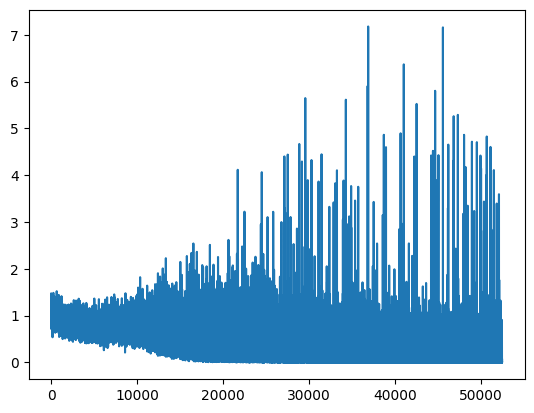

In [35]:
plt.plot(train_losses)

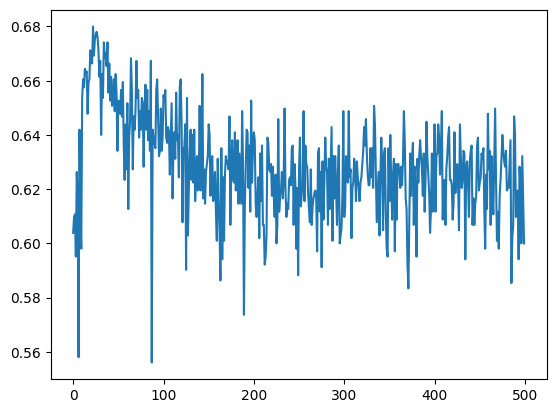

In [36]:
plt.plot(test_accuracy)

In [37]:
metrics3, confusion_matrix3 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics3.compute())
confusion_matrix3.compute()

Correct: 615/1024 (0.6006)
{'acc_detail': tensor([0.7218, 0.5833, 0.7245, 0.3698], device='cuda:0'),
 'acc_unweighted': tensor(0.5999, device='cuda:0'),
 'acc_weighted': tensor(0.6006, device='cuda:0'),
 'f1s': tensor(0.5915, device='cuda:0'),
 'f1s_detail': tensor([0.6982, 0.5519, 0.6869, 0.4289], device='cuda:0'),
 'precision_detail': tensor([0.6761, 0.5236, 0.6531, 0.5104], device='cuda:0'),
 'recall_detail': tensor([0.7218, 0.5833, 0.7245, 0.3698], device='cuda:0'),
 'rocauc': tensor([0.8758, 0.8210, 0.8839, 0.7169], device='cuda:0'),
 'uar': tensor(0.5999, device='cuda:0'),
 'wap': tensor(0.5933, device='cuda:0')}


tensor([[192,  19,  14,  41],
        [ 11, 133,  49,  35],
        [  3,  52, 192,  18],
        [ 78,  50,  39,  98]], device='cuda:0')

In [38]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M12(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m12new_best_23epoch.pt
Correct: 697/1024 (0.6807)
{'acc_detail': tensor([0.8421, 0.6447, 0.8000, 0.4302], device='cuda:0'),
 'acc_unweighted': tensor(0.6793, device='cuda:0'),
 'acc_weighted': tensor(0.6807, device='cuda:0'),
 'f1s': tensor(0.6692, device='cuda:0'),
 'f1s_detail': tensor([0.7791, 0.5963, 0.7737, 0.5278], device='cuda:0'),
 'precision_detail': tensor([0.7249, 0.5547, 0.7491, 0.6826], device='cuda:0'),
 'recall_detail': tensor([0.8421, 0.6447, 0.8000, 0.4302], device='cuda:0'),
 'rocauc': tensor([0.9302, 0.8608, 0.9376, 0.7920], device='cuda:0'),
 'uar': tensor(0.6793, device='cuda:0'),
 'wap': tensor(0.6823, device='cuda:0')}


tensor([[224,  17,   3,  22],
        [  9, 147,  45,  27],
        [  4,  45, 212,   4],
        [ 72,  56,  23, 114]], device='cuda:0')

In [125]:
# del model
# gc.collect()

895